<a href="https://colab.research.google.com/github/gazalssr/HerdNet/blob/main/Correct_One_Phase_Finetunning%2BBinary_head.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEMO - Training and testing HerdNet on nadir aerial images
test

## Installations

In [ ]:
# Check GPU
!nvidia-smi

Mon Nov 20 23:38:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install the dependencies
!pip install h5py
!pip install typing-extensions
!pip install wheel
!pip install albumentations>=1.0.3
!pip install fiftyone>=0.14.3
!pip install hydra-core>=1.1.0
!pip install opencv-python>=4.5.1.48
!pip install pandas>=1.2.3
!pip install pillow>=8.2.0
!pip install scikit-image>=0.18.1
!pip install scikit-learn>=1.0.2
!pip install scipy>=1.6.2
!pip install wandb>=0.10.33
!pip install numpy>=1.20.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Download and install the code
import sys

!git clone https://github.com/gazalssr/HerdNet.git
#!cd '/content/HerdNet' && python setup.py install
!pip install -e /content/HerdNet
sys.path.append('/content/HerdNet')

Cloning into 'HerdNet'...
remote: Enumerating objects: 400, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 400 (delta 22), reused 23 (delta 14), pack-reused 339
Receiving objects: 100% (400/400), 4.97 MiB | 4.61 MiB/s, done.
Resolving deltas: 100% (233/233), done.
Obtaining file:///content/HerdNet
  Preparing metadata (setup.py) ... done
  Running setup.py develop for animaloc


In [ ]:
!wandb login
import wandb

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Create datasets

In [ ]:
# Set the seed
from animaloc.utils.seed import set_seed

set_seed(9292)

Number of patches: 48


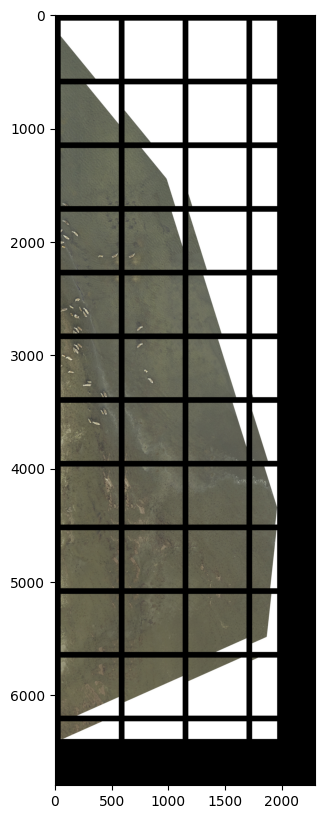

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL.Image as Image

from animaloc.data.patches import ImageToPatches, AnnotatedImageToPatches

img_path = '//content/drive/MyDrive/CAH_small_samples/Train_CAH_Sample/CAH_7_90_2017_BR.jpg'

sample_img = Image.open(img_path)

patcher = ImageToPatches(sample_img, (512,512), overlap = 100)
patches = patcher.make_patches()

print(f'Number of patches: {len(patches)}')

plt.figure(figsize=(15,10))
_ = patcher.show()

In [ ]:
# Create training  patches using the patcher tool
from animaloc.utils.useful_funcs import mkdir
import pandas as pd
from PIL import Image
df = pd.read_csv('/content/drive/MyDrive/Small_CAH_whole/train/train.csv')
df = df.to_csv('/content/drive/MyDrive/Small_CAH_whole/train/train.csv', index=False)
# df = pd.read_csv('/content/drive/MyDrive/CAH_small_samples/Train_CAH_Sample/Train_CAH_Sample.csv')
# df = df.to_csv('/content/drive/MyDrive/CAH_small_samples/Train_CAH_Sample/Train_CAH_Sample.csv', index=False)
mkdir('/content/drive/MyDrive/Train_patches_stratified')
#!python /content/HerdNet/tools/patcher.py /content/drive/MyDrive/CAH_small_samples/Train_CAH_Sample/ 512 512 256 /content/drive/MyDrive/Train_patches -csv /content/drive/MyDrive/CAH_small_samples/Train_CAH_Sample/Train_CAH_Sample.csv -min 0.0 -all False
!python /content/HerdNet/tools/patcher.py  /content/drive/MyDrive/Small_CAH_whole/train 512 512 256  /content/drive/MyDrive/Train_patches_stratified -csv /content/drive/MyDrive/Small_CAH_whole/train/train.csv -min 0.0 -all False

Creating the buffer: 100% 5/5 [00:22<00:00,  4.51s/it]
Exporting patches: 100% 5/5 [00:58<00:00, 11.66s/it]


In [ ]:
# Create validation patches
from animaloc.utils.useful_funcs import mkdir
import pandas as pd
# mkdir('/content/drive/MyDrive/val_patches')
mkdir('/content/drive/MyDrive/val_patches_stratified')
# !python /content/HerdNet/tools/patcher.py /content/drive/MyDrive/CAH_training_session_1/ValCAH 512 512 256 /content/drive/MyDrive/val_patches -csv /content/drive/MyDrive/CAH_training_session_1/ValCAH/ValCAH_2017_1.csv -min 0.0 -all True
!python /content/HerdNet/tools/patcher.py /content/drive/MyDrive/Small_CAH_whole/val/ 512 512 256 /content/drive/MyDrive/val_patches_stratified -csv /content/drive/MyDrive/Small_CAH_whole/val/val.csv -min 0.0 -all False

Creating the buffer: 100% 1/1 [00:02<00:00,  2.02s/it]
Exporting patches: 100% 1/1 [00:05<00:00,  5.38s/it]


In [ ]:
%pdb

Automatic pdb calling has been turned OFF


In [ ]:
# Create test patches
from animaloc.utils.useful_funcs import mkdir
import pandas as pd

# mkdir('/content/drive/MyDrive/test_patches')
mkdir('/content/drive/MyDrive/test_patches_stratified')
!python /content/HerdNet/tools/patcher.py /content/drive/MyDrive/Small_CAH_whole/test/ 512 512 256 /content/drive/MyDrive/test_patches_stratified -csv /content/drive/MyDrive/Small_CAH_whole/test/test.csv -min 0.0 -all False

Creating the buffer: 100% 1/1 [00:13<00:00, 13.79s/it]
Exporting patches: 100% 1/1 [00:13<00:00, 13.03s/it]


## Caribou dataset donwload

In [ ]:
#make a zip file from the patch folders
#Zip file path (destination)       source file path
%cd /content/drive/MyDrive/
# Zip the directory
!zip -jr 'Stratified_patches_zip/Train_patches_stratified.zip' 'Train_patches_stratified'
!zip -jr 'Stratified_patches_zip/val_patches_stratified.zip' 'val_patches_stratified'
!zip -jr 'Stratified_patches_zip/test_patches_stratified.zip' 'test_patches_stratified'

# import shutil
# shutil.make_archive('/content/drive/MyDrive/Train_patches_S', 'zip', '/content/drive/MyDrive/Train_patches')
# shutil.make_archive('/content/drive/MyDrive/val_patches_S', 'zip', '/content/drive/MyDrive/val_patches')
# shutil.make_archive('/content/drive/MyDrive/test_patches_S', 'zip', '/content/drive/MyDrive/test_patches')

Streaming output truncated to the last 5000 lines.
  adding: CAH_6SE_50_2017_Q23_512.jpg (deflated 1%)
  adding: CAH_6SE_50_2017_Q23_513.jpg (deflated 1%)
  adding: CAH_6SE_50_2017_Q23_514.jpg (deflated 1%)
  adding: CAH_6SE_50_2017_Q23_515.jpg (deflated 1%)
  adding: CAH_6SE_50_2017_Q23_516.jpg (deflated 1%)
  adding: CAH_6SE_50_2017_Q23_517.jpg (deflated 1%)
  adding: CAH_6SE_50_2017_Q23_518.jpg (deflated 0%)
  adding: CAH_6SE_50_2017_Q23_519.jpg (deflated 0%)
  adding: CAH_6SE_50_2017_Q23_520.jpg (deflated 0%)
  adding: CAH_6SE_50_2017_Q23_521.jpg (deflated 0%)
  adding: CAH_6SE_50_2017_Q23_522.jpg (deflated 0%)
  adding: CAH_6SE_50_2017_Q23_523.jpg (deflated 0%)
  adding: CAH_6SE_50_2017_Q23_524.jpg (deflated 0%)
  adding: CAH_6SE_50_2017_Q23_525.jpg (deflated 0%)
  adding: CAH_6SE_50_2017_Q23_526.jpg (deflated 0%)
  adding: CAH_6SE_50_2017_Q23_527.jpg (deflated 0%)
  adding: CAH_6SE_50_2017_Q23_528.jpg (deflated 1%)
  adding: CAH_6SE_50_2017_Q23_529.jpg (deflated 0%)
  adding: CAH

In [ ]:
#### Downloading and unziping the files
#zip file download (destination link)
# %cd /content/drive/MyDrive/
!pip install --upgrade --no-cache-dir gdown
# Download the Train zip file

!gdown https://drive.google.com/uc?id=1mI6Ve5v3sAj9h502g75GD1lZSYy4-FR4 -O /content/Train_patches_stratified.zip
# Unzip the file to the specified directory
!unzip -oq /content/Train_patches_stratified.zip -d /content/Train_patches_stratified

# Download the val zip file
!gdown https://drive.google.com/uc?id=1-1lGSZVk-ts0TMo0n-sbwlBGKHhgh9O9 -O /content/val_patches_stratified.zip
# Unzip the file to the specified directory
!unzip -oq /content/val_patches_stratified.zip -d /content/val_patches_stratified

# Download the test zip file
!gdown https://drive.google.com/uc?id=1-1r9sQlC-NxgcSvKKl0WPEmOpkzRV4KB -O /content/test_patches_stratified.zip

# Unzip the file to the specified directory
!unzip -oq /content/test_patches_stratified.zip -d /content/test_patches_stratified



  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Downloading...
From (uriginal): https://drive.google.com/uc?id=1mI6Ve5v3sAj9h502g75GD1lZSYy4-FR4
From (redirected): https://drive.google.com/uc?id=1mI6Ve5v3sAj9h502g75GD1lZSYy4-FR4&confirm=t&uuid=5827b28c-3cf1-443b-b644-898a32dc8c4c
To: /content/Train_patches_stratified.zip
100% 181M/181M [00:01<00:00, 166MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-1lGSZVk-ts0TMo0n-sbwlBGKHhgh9O9
To: /content/val_patches_stratified.zip
100% 17.4M/17.4M [00:00<00:00, 115MB/s] 
Downloading...
From (uriginal): https://drive.google.com/uc?id=1-1r9sQlC-NxgcSvKKl0WPEmOpkzRV4KB
From (redirected): https://drive.google.com/uc?id=1-1r9sQlC-NxgcSvKKl0WPEmOpkzRV4KB&confirm=t&uuid=afe2169f-f691-46b0-9d5e-f7eee33b3536
To: /content/test_patches_stratified.zip
100% 35.9M/35.9M [00:00<00:00, 140MB/s]


In [ ]:
# Download the val zip file
!gdown https://drive.google.com/uc?id=1-1lGSZVk-ts0TMo0n-sbwlBGKHhgh9O9 -O /content/val_patches_stratified.zip
# Unzip the file to the specified directory
!unzip -oq /content/val_patches_stratified.zip -d /content/val_patches_stratified

Downloading...
From: https://drive.google.com/uc?id=1-1lGSZVk-ts0TMo0n-sbwlBGKHhgh9O9
To: /content/val_patches_stratified.zip
100% 17.4M/17.4M [00:00<00:00, 107MB/s] 


In [ ]:

!unzip -l /content/drive/MyDrive/Stratified_patches_zip/Train_patches_stratified.zip


Archive:  /content/drive/MyDrive/Stratified_patches_zip/Train_patches_stratified.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
    27731  2023-11-21 00:47   CAH_6SE_50_2017_Q33_972.jpg
    27050  2023-11-21 00:47   CAH_6SE_50_2017_Q33_973.jpg
    29022  2023-11-21 00:47   CAH_6SE_50_2017_Q33_974.jpg
    29774  2023-11-21 00:47   CAH_6SE_50_2017_Q33_975.jpg
    30072  2023-11-21 00:47   CAH_6SE_50_2017_Q33_976.jpg
    30655  2023-11-21 00:47   CAH_6SE_50_2017_Q33_977.jpg
    31231  2023-11-21 00:47   CAH_6SE_50_2017_Q33_978.jpg
    32113  2023-11-21 00:47   CAH_6SE_50_2017_Q33_979.jpg
    32321  2023-11-21 00:47   CAH_6SE_50_2017_Q33_980.jpg
    31619  2023-11-21 00:47   CAH_6SE_50_2017_Q33_981.jpg
    31020  2023-11-21 00:47   CAH_6SE_50_2017_Q33_982.jpg
    30459  2023-11-21 00:47   CAH_6SE_50_2017_Q33_983.jpg
    29838  2023-11-21 00:47   CAH_6SE_50_2017_Q33_984.jpg
    22649  2023-11-21 00:47   CAH_6SE_50_2017_Q33_985.jpg
    31182  2023-11-21 00:47   CAH

15
4
69
15
14
36
32
63


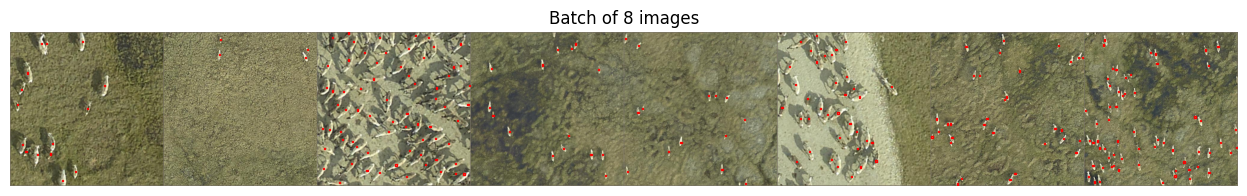

In [ ]:
%matplotlib inline
# Showing some samples of patches and the annotations
import matplotlib.pyplot as plt
from animaloc.datasets import CSVDataset
from animaloc.data.batch_utils import show_batch, collate_fn
from torch.utils.data import DataLoader
import torch
import albumentations as A
batch_size = 8
csv_path = '/content/Train_patches_stratified/gt.csv'
image_path = '/content/Train_patches_stratified'
dataset = CSVDataset(csv_path, image_path, [A.Normalize()])
dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

sample_batch = next(iter(dataloader))
for i in range(len(sample_batch[1])):
  points = sample_batch[1][i]['points'].numpy()
  bbox= []
  for pt in points:
      bbox.append([pt[0]-2,pt[1]-2,pt[0]+2,pt[1]+2])
  print(len(sample_batch[1][i]['labels']))
  sample_batch[1][i]['annotations']=torch.tensor(bbox)
plt.figure(figsize=(16,2))
show_batch(sample_batch)

In [ ]:
# Training, validation and test datasets
import albumentations as A

from animaloc.datasets import FolderDataset
from animaloc.data.transforms import MultiTransformsWrapper, DownSample, PointsToMask, FIDT

patch_size = 512
num_classes = 2
down_ratio: int = 2

train_dataset = CSVDataset(

    csv_file = '/content/Train_patches_stratified/gt.csv',
    root_dir = '/content/Train_patches_stratified',
    # Data Augmentation
    albu_transforms = [
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.Normalize(p=1.0),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.2),
        A.Blur(blur_limit=15, p=0.2),
        ],
    end_transforms = [MultiTransformsWrapper([
        FIDT(num_classes=num_classes, down_ratio=down_ratio),
        PointsToMask(radius=2, num_classes=num_classes, squeeze=True, down_ratio=int(patch_size//16))
        ])]
    )

val_dataset = CSVDataset(

    csv_file = '/content/val_patches_stratified/gt.csv',
    root_dir = '/content/val_patches_stratified',
    albu_transforms = [A.Normalize(p=1.0)],
    end_transforms = [DownSample(down_ratio=down_ratio, anno_type='point')]
    )

test_dataset = CSVDataset(

    csv_file = '/content/test_patches_stratified/gt.csv',
    root_dir = '/content/test_patches_stratified',
    albu_transforms = [A.Normalize(p=1.0)],
    end_transforms = [DownSample(down_ratio=down_ratio, anno_type='point')]
    )

In [ ]:
# Dataloaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset = train_dataset, batch_size = 4, shuffle = True)
val_dataloader = DataLoader(dataset = val_dataset, batch_size = 1, shuffle = False)
test_dataloader = DataLoader(dataset = test_dataset, batch_size = 1, shuffle = False)

## Define HerdNet for training

In [ ]:
# Path to your .pth file
import torch
####################### Transfered weights ###########################
pth_path = '/content/drive/MyDrive/output/Binary.pth'
pretrained_dict = torch.load(pth_path)

In [ ]:
from animaloc.models import HerdNet
from torch import Tensor
from animaloc.models import LossWrapper
from animaloc.train.losses import FocalLoss
from torch.nn import CrossEntropyLoss

herdnet = HerdNet(num_classes=num_classes, down_ratio=down_ratio).cuda()

losses = [
    {'loss': FocalLoss(reduction='mean'), 'idx': 0, 'idy': 0, 'lambda': 1.0, 'name': 'focal_loss'},
    {'loss': CrossEntropyLoss(reduction='mean'), 'idx': 1, 'idy': 1, 'lambda': 1.0, 'name': 'ce_loss'}
    ]

herdnet = LossWrapper(herdnet, losses=losses)
herdnet.load_state_dict(pretrained_dict, strict=False) # /initialisation from a pre-task

Downloading: "http://dl.yf.io/dla/models/imagenet/dla34-ba72cf86.pth" to /root/.cache/torch/hub/checkpoints/dla34-ba72cf86.pth
100%|██████████| 60.3M/60.3M [00:05<00:00, 12.6MB/s]


_IncompatibleKeys(missing_keys=['model.base_0.base_layer.0.weight', 'model.base_0.base_layer.1.weight', 'model.base_0.base_layer.1.bias', 'model.base_0.base_layer.1.running_mean', 'model.base_0.base_layer.1.running_var', 'model.base_0.level0.0.weight', 'model.base_0.level0.1.weight', 'model.base_0.level0.1.bias', 'model.base_0.level0.1.running_mean', 'model.base_0.level0.1.running_var', 'model.base_0.level1.0.weight', 'model.base_0.level1.1.weight', 'model.base_0.level1.1.bias', 'model.base_0.level1.1.running_mean', 'model.base_0.level1.1.running_var', 'model.base_0.level2.tree1.conv1.weight', 'model.base_0.level2.tree1.bn1.weight', 'model.base_0.level2.tree1.bn1.bias', 'model.base_0.level2.tree1.bn1.running_mean', 'model.base_0.level2.tree1.bn1.running_var', 'model.base_0.level2.tree1.conv2.weight', 'model.base_0.level2.tree1.bn2.weight', 'model.base_0.level2.tree1.bn2.bias', 'model.base_0.level2.tree1.bn2.running_mean', 'model.base_0.level2.tree1.bn2.running_var', 'model.base_0.level

## Create the Trainer

In [ ]:
#############Get model layers ###########################
def get_parameter_names(model): # getting the model layers
  param_dict= dict()
  for l, (name,param) in enumerate(model.named_parameters()):
    #print(l,":\t",name,type(param),param.requires_grad)
    param_dict[name]= l
  return param_dict
result = get_parameter_names(herdnet)
print(result)

{'model.base_0.base_layer.0.weight': 0, 'model.base_0.base_layer.1.weight': 1, 'model.base_0.base_layer.1.bias': 2, 'model.base_0.level0.0.weight': 3, 'model.base_0.level0.1.weight': 4, 'model.base_0.level0.1.bias': 5, 'model.base_0.level1.0.weight': 6, 'model.base_0.level1.1.weight': 7, 'model.base_0.level1.1.bias': 8, 'model.base_0.level2.tree1.conv1.weight': 9, 'model.base_0.level2.tree1.bn1.weight': 10, 'model.base_0.level2.tree1.bn1.bias': 11, 'model.base_0.level2.tree1.conv2.weight': 12, 'model.base_0.level2.tree1.bn2.weight': 13, 'model.base_0.level2.tree1.bn2.bias': 14, 'model.base_0.level2.tree2.conv1.weight': 15, 'model.base_0.level2.tree2.bn1.weight': 16, 'model.base_0.level2.tree2.bn1.bias': 17, 'model.base_0.level2.tree2.conv2.weight': 18, 'model.base_0.level2.tree2.bn2.weight': 19, 'model.base_0.level2.tree2.bn2.bias': 20, 'model.base_0.level2.root.conv.weight': 21, 'model.base_0.level2.root.bn.weight': 22, 'model.base_0.level2.root.bn.bias': 23, 'model.base_0.level2.proj

In [ ]:
#Freeze the layers
def freeze_parts(model, get_parameter_names, layers_to_freeze, lr, unfreeze=False):
    params_to_update = []

    for l, (name, param) in enumerate(model.named_parameters()):
        res = any(ele in name for ele in layers_to_freeze)
        param.requires_grad = unfreeze if res else not unfreeze

        if param.requires_grad == True:
            params_to_update.append({
                "params": param,
                "lr": lr,
            })

        # Print parameters to update
        if param.requires_grad:
            print(f"Trainable parameter: {name}")
        else:
            print(f"Frozen parameter: {name}")

    return params_to_update


In [ ]:
#Freeze half of a specified layer
def freeze_parts(model, get_parameter_names, layers_to_freeze, freeze_layer_half=None, lr=0.0001, unfreeze=False):
    params_to_update = []

    for l, (name, param) in enumerate(model.named_parameters()):
        res = any(ele in name for ele in layers_to_freeze)
        param.requires_grad = unfreeze if res else not unfreeze

        # Check if the current layer is the specified layer to freeze half of its parameters
        if freeze_layer_half is not None and freeze_layer_half in name:
            total_params = param.numel()
            half_params = total_params // 2
            param.requires_grad = unfreeze if l < half_params else not unfreeze

        if param.requires_grad:
            params_to_update.append({
                "params": param,
                "lr": lr,
            })

        # Print parameters to update
        if param.requires_grad:
            print(f"Trainable parameter: {name}")
        else:
            print(f"Frozen parameter: {name}")

    return params_to_update


In [ ]:
#Freeze half of the last layer
def freeze_parts(model, get_parameter_names, layers_to_freeze, lr, unfreeze=False, freeze_last_half=False):
    # Initialize an empty list to store parameters to update
    params_to_update = []

    # Iterate through all named parameters in the model
    for name, param in model.named_parameters():
        # Check if the parameter should be frozen based on the layers_to_freeze list
        should_freeze = any(ele in name for ele in layers_to_freeze)

        # If freeze_last_half is True, freeze half of the parameters in the last layer
        if freeze_last_half and 'your_last_layer_keyword' in name:
            # Calculate the number of channels in the last layer
            num_channels = param.size(0)

            # Calculate the number of channels to freeze (half of the total channels)
            num_channels_to_freeze = num_channels // 2

            # Check if the current channel should be frozen
            should_freeze = should_freeze or (param.size(0) >= num_channels - num_channels_to_freeze)

        # Set requires_grad attribute based on whether to freeze or unfreeze
        param.requires_grad = unfreeze if should_freeze else not unfreeze

        # Append parameters to the update list if requires_grad is True
        if param.requires_grad:
            params_to_update.append({
                "params": param,
                "lr": lr,
            })

        # Print information about the parameter (whether it's trainable or frozen)
        if param.requires_grad:
            print(f"Trainable parameter: {name}")
        else:
            print(f"Frozen parameter: {name}")

    return params_to_update


In [ ]:
#freezing half of one lyer+ other layers
params_to_update = freeze_parts(herdnet.model, get_parameter_names, layers_to_freeze=['base_layer','level0','level1','level2','level3'], freeze_layer_half='level_4', lr=0.0001, unfreeze=False)


Frozen parameter: base_0.base_layer.0.weight
Frozen parameter: base_0.base_layer.1.weight
Frozen parameter: base_0.base_layer.1.bias
Frozen parameter: base_0.level0.0.weight
Frozen parameter: base_0.level0.1.weight
Frozen parameter: base_0.level0.1.bias
Frozen parameter: base_0.level1.0.weight
Frozen parameter: base_0.level1.1.weight
Frozen parameter: base_0.level1.1.bias
Frozen parameter: base_0.level2.tree1.conv1.weight
Frozen parameter: base_0.level2.tree1.bn1.weight
Frozen parameter: base_0.level2.tree1.bn1.bias
Frozen parameter: base_0.level2.tree1.conv2.weight
Frozen parameter: base_0.level2.tree1.bn2.weight
Frozen parameter: base_0.level2.tree1.bn2.bias
Frozen parameter: base_0.level2.tree2.conv1.weight
Frozen parameter: base_0.level2.tree2.bn1.weight
Frozen parameter: base_0.level2.tree2.bn1.bias
Frozen parameter: base_0.level2.tree2.conv2.weight
Frozen parameter: base_0.level2.tree2.bn2.weight
Frozen parameter: base_0.level2.tree2.bn2.bias
Frozen parameter: base_0.level2.root.

In [ ]:
#Freezing a whole layer
lr=1e-4
# layers_to_freeze= [] # nothing frozen
# layers_to_freeze= ['base_layer','level0','level1','level2','level3','level4','level5'] # we are feezing all the levels below level5
layers_to_freeze= ['base_layer','level0','level1','level2','level3','level4']

params_to_update= freeze_parts(herdnet.model,get_parameter_names,layers_to_freeze,lr,unfreeze=False)

Frozen parameter: base_0.base_layer.0.weight
Frozen parameter: base_0.base_layer.1.weight
Frozen parameter: base_0.base_layer.1.bias
Frozen parameter: base_0.level0.0.weight
Frozen parameter: base_0.level0.1.weight
Frozen parameter: base_0.level0.1.bias
Frozen parameter: base_0.level1.0.weight
Frozen parameter: base_0.level1.1.weight
Frozen parameter: base_0.level1.1.bias
Frozen parameter: base_0.level2.tree1.conv1.weight
Frozen parameter: base_0.level2.tree1.bn1.weight
Frozen parameter: base_0.level2.tree1.bn1.bias
Frozen parameter: base_0.level2.tree1.conv2.weight
Frozen parameter: base_0.level2.tree1.bn2.weight
Frozen parameter: base_0.level2.tree1.bn2.bias
Frozen parameter: base_0.level2.tree2.conv1.weight
Frozen parameter: base_0.level2.tree2.bn1.weight
Frozen parameter: base_0.level2.tree2.bn1.bias
Frozen parameter: base_0.level2.tree2.conv2.weight
Frozen parameter: base_0.level2.tree2.bn2.weight
Frozen parameter: base_0.level2.tree2.bn2.bias
Frozen parameter: base_0.level2.root.

# Create the Trainer

In [ ]:
from torch.optim import Adam
from animaloc.train import Trainer
from torch.optim.lr_scheduler import StepLR
from animaloc.eval import PointsMetrics, HerdNetStitcher, HerdNetEvaluator
from animaloc.utils.useful_funcs import mkdir

work_dir = '/content/drive/MyDrive/output'
mkdir(work_dir)

lr = 1e-4
weight_decay = 1e-3
epochs = 100
# parameters= herdnet.parameters()
optimizer = Adam(params_to_update, lr=lr, weight_decay=weight_decay)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
# scheduler.step()
metrics = PointsMetrics(radius=20, num_classes=num_classes)

stitcher = HerdNetStitcher(
    model=herdnet,
    size=(patch_size,patch_size),
    overlap=0,
    down_ratio=down_ratio,
    reduction='mean'
    )

evaluator = HerdNetEvaluator(
    model=herdnet,
    dataloader=val_dataloader,
    metrics=metrics,
    stitcher=None,
    work_dir=work_dir,
    header='validation'
    )

trainer = Trainer(
    model=herdnet,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    num_epochs=epochs,
    evaluator=evaluator,             # metric evaluation
    # val_dataloader= val_dataloader, # loss evaluation
    work_dir=work_dir
    )

# Start Training

In [ ]:
import wandb
if wandb.run is not None:
  wandb.finish()
wandb.init(project="herdnet-finetuning")

wandb: Currently logged in as: ghazaleh-serati (wildlife-monitoring). Use `wandb login --relogin` to force relogin


In [ ]:
%pdb

Automatic pdb calling has been turned ON


In [ ]:
trainer.start(warmup_iters=100, checkpoints='best', select='max', validate_on='f1_score', wandb_flag =True)
# validate_on='f1_score'

INFO:20231121_training:[TRAINING] - Epoch: [1] [  1/183] eta: 0:01:16 lr: 0.000002 loss: 84.2547 (84.2547) focal_loss: 83.3723 (83.3723) ce_loss: 0.8823 (0.8823) time: 0.4202 data: 0.1480 max mem: 1723


[TRAINING] - Epoch: [1] [  1/183] eta: 0:01:16 lr: 0.000002 loss: 84.2547 (84.2547) focal_loss: 83.3723 (83.3723) ce_loss: 0.8823 (0.8823) time: 0.4202 data: 0.1480 max mem: 1723


INFO:20231121_training:[TRAINING] - Epoch: [1] [ 51/183] eta: 0:00:34 lr: 0.000051 loss: 35.9258 (40.3376) focal_loss: 35.6793 (40.0018) ce_loss: 0.2353 (0.3358) time: 0.2507 data: 0.0766 max mem: 1856


[TRAINING] - Epoch: [1] [ 51/183] eta: 0:00:34 lr: 0.000051 loss: 35.9258 (40.3376) focal_loss: 35.6793 (40.0018) ce_loss: 0.2353 (0.3358) time: 0.2507 data: 0.0766 max mem: 1856


INFO:20231121_training:[TRAINING] - Epoch: [1] [101/183] eta: 0:00:21 lr: 0.000100 loss: 23.5821 (36.7434) focal_loss: 22.9867 (36.4376) ce_loss: 0.2313 (0.3059) time: 0.2487 data: 0.0728 max mem: 1856


[TRAINING] - Epoch: [1] [101/183] eta: 0:00:21 lr: 0.000100 loss: 23.5821 (36.7434) focal_loss: 22.9867 (36.4376) ce_loss: 0.2313 (0.3059) time: 0.2487 data: 0.0728 max mem: 1856


INFO:20231121_training:[TRAINING] - Epoch: [1] [151/183] eta: 0:00:08 lr: 0.000100 loss: 35.6922 (37.9285) focal_loss: 35.5551 (37.6234) ce_loss: 0.2608 (0.3051) time: 0.2616 data: 0.0821 max mem: 1856


[TRAINING] - Epoch: [1] [151/183] eta: 0:00:08 lr: 0.000100 loss: 35.6922 (37.9285) focal_loss: 35.5551 (37.6234) ce_loss: 0.2608 (0.3051) time: 0.2616 data: 0.0821 max mem: 1856


INFO:20231121_training:[TRAINING] - Epoch: [1] [183/183] eta: 0:00:00 lr: 0.000100 loss: 25.3307 (37.2953) focal_loss: 25.1490 (36.9974) ce_loss: 0.2556 (0.2979) time: 0.2451 data: 0.0687 max mem: 1856
INFO:20231121_training:[TRAINING] - Epoch: [1] Total time: 0:00:46 (0.2560 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [1] [ 1/54] eta: 0:00:05 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0975 data: 0.0082 max mem: 1856


[TRAINING] - Epoch: [1] [183/183] eta: 0:00:00 lr: 0.000100 loss: 25.3307 (37.2953) focal_loss: 25.1490 (36.9974) ce_loss: 0.2556 (0.2979) time: 0.2451 data: 0.0687 max mem: 1856
[TRAINING] - Epoch: [1] Total time: 0:00:46 (0.2560 s / it)
[TRAINING] - Epoch: [1] mean loss: 37.2953
[VALIDATION] - Epoch: [1] [ 1/54] eta: 0:00:05 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0975 data: 0.0082 max mem: 1856


INFO:20231121_validation:[VALIDATION] - Epoch: [1] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.54 f1-score: 0.7 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0338 data: 0.0062 max mem: 1856


[VALIDATION] - Epoch: [1] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.54 f1-score: 0.7 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0338 data: 0.0062 max mem: 1856


INFO:20231121_validation:[VALIDATION] - Epoch: [1] [21/54] eta: 0:00:01 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0292 data: 0.0061 max mem: 1856


[VALIDATION] - Epoch: [1] [21/54] eta: 0:00:01 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0292 data: 0.0061 max mem: 1856


INFO:20231121_validation:[VALIDATION] - Epoch: [1] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0298 data: 0.0065 max mem: 1856


[VALIDATION] - Epoch: [1] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.3 f1-score: 0.46 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0298 data: 0.0065 max mem: 1856


INFO:20231121_validation:[VALIDATION] - Epoch: [1] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0280 data: 0.0063 max mem: 1856


[VALIDATION] - Epoch: [1] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.26 f1-score: 0.41 MAE: 20.0 MSE: 400.0 RMSE: 20.0 time: 0.0280 data: 0.0063 max mem: 1856


INFO:20231121_validation:[VALIDATION] - Epoch: [1] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0273 data: 0.0058 max mem: 1856
INFO:20231121_validation:[VALIDATION] - Epoch: [1] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0274 data: 0.0058 max mem: 1856
INFO:20231121_validation:[VALIDATION] - Epoch: [1] Total time: 0:00:01 (0.0301 s / it)


[VALIDATION] - Epoch: [1] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0273 data: 0.0058 max mem: 1856
[VALIDATION] - Epoch: [1] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0274 data: 0.0058 max mem: 1856
[VALIDATION] - Epoch: [1] Total time: 0:00:01 (0.0301 s / it)
[VALIDATION] - Epoch: [1] f1_score: 0.4346
Best model saved - Epoch 1 - Validation value: 0.434641


INFO:20231121_training:[TRAINING] - Epoch: [2] [  1/183] eta: 0:01:02 lr: 0.000100 loss: 24.9661 (37.2140) focal_loss: 24.6795 (36.9167) ce_loss: 0.2398 (0.2973) time: 0.3434 data: 0.0710 max mem: 1856


[TRAINING] - Epoch: [2] [  1/183] eta: 0:01:02 lr: 0.000100 loss: 24.9661 (37.2140) focal_loss: 24.6795 (36.9167) ce_loss: 0.2398 (0.2973) time: 0.3434 data: 0.0710 max mem: 1856


INFO:20231121_training:[TRAINING] - Epoch: [2] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 33.8594 (37.0554) focal_loss: 33.6278 (36.7634) ce_loss: 0.2346 (0.2920) time: 0.2609 data: 0.0831 max mem: 1856


[TRAINING] - Epoch: [2] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 33.8594 (37.0554) focal_loss: 33.6278 (36.7634) ce_loss: 0.2346 (0.2920) time: 0.2609 data: 0.0831 max mem: 1856


INFO:20231121_training:[TRAINING] - Epoch: [2] [101/183] eta: 0:00:21 lr: 0.000100 loss: 30.4778 (36.1173) focal_loss: 30.3370 (35.8352) ce_loss: 0.1934 (0.2821) time: 0.2559 data: 0.0772 max mem: 1856


[TRAINING] - Epoch: [2] [101/183] eta: 0:00:21 lr: 0.000100 loss: 30.4778 (36.1173) focal_loss: 30.3370 (35.8352) ce_loss: 0.1934 (0.2821) time: 0.2559 data: 0.0772 max mem: 1856


INFO:20231121_training:[TRAINING] - Epoch: [2] [151/183] eta: 0:00:08 lr: 0.000100 loss: 31.9997 (36.1058) focal_loss: 31.8258 (35.8362) ce_loss: 0.1831 (0.2696) time: 0.2659 data: 0.0872 max mem: 1856


[TRAINING] - Epoch: [2] [151/183] eta: 0:00:08 lr: 0.000100 loss: 31.9997 (36.1058) focal_loss: 31.8258 (35.8362) ce_loss: 0.1831 (0.2696) time: 0.2659 data: 0.0872 max mem: 1856


INFO:20231121_training:[TRAINING] - Epoch: [2] [183/183] eta: 0:00:00 lr: 0.000100 loss: 27.2567 (35.5120) focal_loss: 27.0816 (35.2464) ce_loss: 0.2088 (0.2656) time: 0.2458 data: 0.0721 max mem: 1856
INFO:20231121_training:[TRAINING] - Epoch: [2] Total time: 0:00:47 (0.2584 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [2] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0289 data: 0.0077 max mem: 1856


[TRAINING] - Epoch: [2] [183/183] eta: 0:00:00 lr: 0.000100 loss: 27.2567 (35.5120) focal_loss: 27.0816 (35.2464) ce_loss: 0.2088 (0.2656) time: 0.2458 data: 0.0721 max mem: 1856
[TRAINING] - Epoch: [2] Total time: 0:00:47 (0.2584 s / it)
[TRAINING] - Epoch: [2] mean loss: 33.7287
[VALIDATION] - Epoch: [2] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0289 data: 0.0077 max mem: 1856


INFO:20231121_validation:[VALIDATION] - Epoch: [2] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 0.67 f1-score: 0.75 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0289 data: 0.0074 max mem: 1856


[VALIDATION] - Epoch: [2] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 0.67 f1-score: 0.75 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0289 data: 0.0074 max mem: 1856


INFO:20231121_validation:[VALIDATION] - Epoch: [2] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0283 data: 0.0068 max mem: 1856


[VALIDATION] - Epoch: [2] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0283 data: 0.0068 max mem: 1856


INFO:20231121_validation:[VALIDATION] - Epoch: [2] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 0.5 f1-score: 0.57 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0279 data: 0.0063 max mem: 1856


[VALIDATION] - Epoch: [2] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 0.5 f1-score: 0.57 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0279 data: 0.0063 max mem: 1856


INFO:20231121_validation:[VALIDATION] - Epoch: [2] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 0.71 f1-score: 0.71 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0286 data: 0.0070 max mem: 1856


[VALIDATION] - Epoch: [2] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 0.71 f1-score: 0.71 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0286 data: 0.0070 max mem: 1856


INFO:20231121_validation:[VALIDATION] - Epoch: [2] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0287 data: 0.0072 max mem: 1856
INFO:20231121_validation:[VALIDATION] - Epoch: [2] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0285 data: 0.0069 max mem: 1856
INFO:20231121_validation:[VALIDATION] - Epoch: [2] Total time: 0:00:01 (0.0290 s / it)


[VALIDATION] - Epoch: [2] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0287 data: 0.0072 max mem: 1856
[VALIDATION] - Epoch: [2] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0285 data: 0.0069 max mem: 1856
[VALIDATION] - Epoch: [2] Total time: 0:00:01 (0.0290 s / it)
[VALIDATION] - Epoch: [2] f1_score: 0.6085
Best model saved - Epoch 2 - Validation value: 0.608479


INFO:20231121_training:[TRAINING] - Epoch: [3] [  1/183] eta: 0:01:05 lr: 0.000100 loss: 29.6384 (35.5001) focal_loss: 29.4296 (35.2347) ce_loss: 0.2088 (0.2654) time: 0.3566 data: 0.1000 max mem: 1856


[TRAINING] - Epoch: [3] [  1/183] eta: 0:01:05 lr: 0.000100 loss: 29.6384 (35.5001) focal_loss: 29.4296 (35.2347) ce_loss: 0.2088 (0.2654) time: 0.3566 data: 0.1000 max mem: 1856


INFO:20231121_training:[TRAINING] - Epoch: [3] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 25.3845 (35.0397) focal_loss: 25.1605 (34.7820) ce_loss: 0.1730 (0.2577) time: 0.2540 data: 0.0766 max mem: 1856


[TRAINING] - Epoch: [3] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 25.3845 (35.0397) focal_loss: 25.1605 (34.7820) ce_loss: 0.1730 (0.2577) time: 0.2540 data: 0.0766 max mem: 1856


INFO:20231121_training:[TRAINING] - Epoch: [3] [101/183] eta: 0:00:21 lr: 0.000100 loss: 20.0818 (34.7590) focal_loss: 19.9530 (34.5086) ce_loss: 0.1417 (0.2503) time: 0.2471 data: 0.0697 max mem: 1856


[TRAINING] - Epoch: [3] [101/183] eta: 0:00:21 lr: 0.000100 loss: 20.0818 (34.7590) focal_loss: 19.9530 (34.5086) ce_loss: 0.1417 (0.2503) time: 0.2471 data: 0.0697 max mem: 1856


INFO:20231121_training:[TRAINING] - Epoch: [3] [151/183] eta: 0:00:08 lr: 0.000100 loss: 27.1627 (34.1870) focal_loss: 26.9883 (33.9434) ce_loss: 0.1744 (0.2436) time: 0.2520 data: 0.0740 max mem: 1856


[TRAINING] - Epoch: [3] [151/183] eta: 0:00:08 lr: 0.000100 loss: 27.1627 (34.1870) focal_loss: 26.9883 (33.9434) ce_loss: 0.1744 (0.2436) time: 0.2520 data: 0.0740 max mem: 1856


INFO:20231121_training:[TRAINING] - Epoch: [3] [183/183] eta: 0:00:00 lr: 0.000100 loss: 31.4984 (34.1940) focal_loss: 31.3265 (33.9544) ce_loss: 0.1711 (0.2396) time: 0.2519 data: 0.0784 max mem: 1856
INFO:20231121_training:[TRAINING] - Epoch: [3] Total time: 0:00:46 (0.2549 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [3] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 0.67 f1-score: 0.8 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0327 data: 0.0100 max mem: 1856


[TRAINING] - Epoch: [3] [183/183] eta: 0:00:00 lr: 0.000100 loss: 31.4984 (34.1940) focal_loss: 31.3265 (33.9544) ce_loss: 0.1711 (0.2396) time: 0.2519 data: 0.0784 max mem: 1856
[TRAINING] - Epoch: [3] Total time: 0:00:46 (0.2549 s / it)
[TRAINING] - Epoch: [3] mean loss: 31.5580
[VALIDATION] - Epoch: [3] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 0.67 f1-score: 0.8 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0327 data: 0.0100 max mem: 1856


INFO:20231121_validation:[VALIDATION] - Epoch: [3] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 0.75 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0285 data: 0.0069 max mem: 1856


[VALIDATION] - Epoch: [3] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 0.75 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0285 data: 0.0069 max mem: 1856


INFO:20231121_validation:[VALIDATION] - Epoch: [3] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0065 max mem: 1856


[VALIDATION] - Epoch: [3] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0065 max mem: 1856


INFO:20231121_validation:[VALIDATION] - Epoch: [3] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.75 f1-score: 0.86 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0282 data: 0.0065 max mem: 1856


[VALIDATION] - Epoch: [3] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.75 f1-score: 0.86 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0282 data: 0.0065 max mem: 1856


INFO:20231121_validation:[VALIDATION] - Epoch: [3] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.67 f1-score: 0.75 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0282 data: 0.0065 max mem: 1856


[VALIDATION] - Epoch: [3] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.67 f1-score: 0.75 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0282 data: 0.0065 max mem: 1856


INFO:20231121_validation:[VALIDATION] - Epoch: [3] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0284 data: 0.0065 max mem: 1856
INFO:20231121_validation:[VALIDATION] - Epoch: [3] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0286 data: 0.0067 max mem: 1856
INFO:20231121_validation:[VALIDATION] - Epoch: [3] Total time: 0:00:01 (0.0289 s / it)


[VALIDATION] - Epoch: [3] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0284 data: 0.0065 max mem: 1856
[VALIDATION] - Epoch: [3] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0286 data: 0.0067 max mem: 1856
[VALIDATION] - Epoch: [3] Total time: 0:00:01 (0.0289 s / it)
[VALIDATION] - Epoch: [3] f1_score: 0.6176
Best model saved - Epoch 3 - Validation value: 0.617647


INFO:20231121_training:[TRAINING] - Epoch: [4] [  1/183] eta: 0:00:50 lr: 0.000100 loss: 31.4984 (34.1856) focal_loss: 31.3265 (33.9463) ce_loss: 0.1482 (0.2393) time: 0.2761 data: 0.0945 max mem: 1856


[TRAINING] - Epoch: [4] [  1/183] eta: 0:00:50 lr: 0.000100 loss: 31.4984 (34.1856) focal_loss: 31.3265 (33.9463) ce_loss: 0.1482 (0.2393) time: 0.2761 data: 0.0945 max mem: 1856


INFO:20231121_training:[TRAINING] - Epoch: [4] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 33.2078 (34.0921) focal_loss: 32.9891 (33.8587) ce_loss: 0.1537 (0.2334) time: 0.2646 data: 0.0864 max mem: 1856


[TRAINING] - Epoch: [4] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 33.2078 (34.0921) focal_loss: 32.9891 (33.8587) ce_loss: 0.1537 (0.2334) time: 0.2646 data: 0.0864 max mem: 1856


INFO:20231121_training:[TRAINING] - Epoch: [4] [101/183] eta: 0:00:21 lr: 0.000100 loss: 28.2500 (33.6976) focal_loss: 28.1580 (33.4687) ce_loss: 0.1316 (0.2289) time: 0.2517 data: 0.0738 max mem: 1856


[TRAINING] - Epoch: [4] [101/183] eta: 0:00:21 lr: 0.000100 loss: 28.2500 (33.6976) focal_loss: 28.1580 (33.4687) ce_loss: 0.1316 (0.2289) time: 0.2517 data: 0.0738 max mem: 1856


INFO:20231121_training:[TRAINING] - Epoch: [4] [151/183] eta: 0:00:08 lr: 0.000100 loss: 25.3089 (33.6096) focal_loss: 25.1304 (33.3854) ce_loss: 0.1246 (0.2242) time: 0.2546 data: 0.0765 max mem: 1884


[TRAINING] - Epoch: [4] [151/183] eta: 0:00:08 lr: 0.000100 loss: 25.3089 (33.6096) focal_loss: 25.1304 (33.3854) ce_loss: 0.1246 (0.2242) time: 0.2546 data: 0.0765 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [4] [183/183] eta: 0:00:00 lr: 0.000100 loss: 22.0115 (33.4661) focal_loss: 21.8857 (33.2444) ce_loss: 0.1449 (0.2217) time: 0.2574 data: 0.0831 max mem: 1884
INFO:20231121_training:[TRAINING] - Epoch: [4] Total time: 0:00:47 (0.2573 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [4] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0073 max mem: 1884


[TRAINING] - Epoch: [4] [183/183] eta: 0:00:00 lr: 0.000100 loss: 22.0115 (33.4661) focal_loss: 21.8857 (33.2444) ce_loss: 0.1449 (0.2217) time: 0.2574 data: 0.0831 max mem: 1884
[TRAINING] - Epoch: [4] Total time: 0:00:47 (0.2573 s / it)
[TRAINING] - Epoch: [4] mean loss: 31.2824
[VALIDATION] - Epoch: [4] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0073 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [4] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0285 data: 0.0069 max mem: 1884


[VALIDATION] - Epoch: [4] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0285 data: 0.0069 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [4] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0065 max mem: 1884


[VALIDATION] - Epoch: [4] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0065 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [4] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 0.67 f1-score: 0.67 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0064 max mem: 1884


[VALIDATION] - Epoch: [4] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 0.67 f1-score: 0.67 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0064 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [4] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.7 f1-score: 0.82 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0289 data: 0.0069 max mem: 1884


[VALIDATION] - Epoch: [4] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.7 f1-score: 0.82 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0289 data: 0.0069 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [4] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0286 data: 0.0068 max mem: 1884
INFO:20231121_validation:[VALIDATION] - Epoch: [4] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0283 data: 0.0067 max mem: 1884
INFO:20231121_validation:[VALIDATION] - Epoch: [4] Total time: 0:00:01 (0.0290 s / it)


[VALIDATION] - Epoch: [4] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0286 data: 0.0068 max mem: 1884
[VALIDATION] - Epoch: [4] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0283 data: 0.0067 max mem: 1884
[VALIDATION] - Epoch: [4] Total time: 0:00:01 (0.0290 s / it)
[VALIDATION] - Epoch: [4] f1_score: 0.6352
Best model saved - Epoch 4 - Validation value: 0.635171


INFO:20231121_training:[TRAINING] - Epoch: [5] [  1/183] eta: 0:00:46 lr: 0.000100 loss: 21.2163 (33.4456) focal_loss: 21.0713 (33.2240) ce_loss: 0.1449 (0.2216) time: 0.2534 data: 0.0757 max mem: 1884


[TRAINING] - Epoch: [5] [  1/183] eta: 0:00:46 lr: 0.000100 loss: 21.2163 (33.4456) focal_loss: 21.0713 (33.2240) ce_loss: 0.1449 (0.2216) time: 0.2534 data: 0.0757 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [5] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 36.4280 (33.3046) focal_loss: 36.2895 (33.0878) ce_loss: 0.1464 (0.2168) time: 0.2716 data: 0.0934 max mem: 1884


[TRAINING] - Epoch: [5] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 36.4280 (33.3046) focal_loss: 36.2895 (33.0878) ce_loss: 0.1464 (0.2168) time: 0.2716 data: 0.0934 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [5] [101/183] eta: 0:00:21 lr: 0.000100 loss: 29.3276 (33.0951) focal_loss: 29.2282 (32.8834) ce_loss: 0.1206 (0.2117) time: 0.2614 data: 0.0838 max mem: 1884


[TRAINING] - Epoch: [5] [101/183] eta: 0:00:21 lr: 0.000100 loss: 29.3276 (33.0951) focal_loss: 29.2282 (32.8834) ce_loss: 0.1206 (0.2117) time: 0.2614 data: 0.0838 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [5] [151/183] eta: 0:00:08 lr: 0.000100 loss: 23.6000 (33.0248) focal_loss: 23.4988 (32.8166) ce_loss: 0.1131 (0.2082) time: 0.2493 data: 0.0716 max mem: 1884


[TRAINING] - Epoch: [5] [151/183] eta: 0:00:08 lr: 0.000100 loss: 23.6000 (33.0248) focal_loss: 23.4988 (32.8166) ce_loss: 0.1131 (0.2082) time: 0.2493 data: 0.0716 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [5] [183/183] eta: 0:00:00 lr: 0.000100 loss: 20.0577 (32.7517) focal_loss: 19.9514 (32.5461) ce_loss: 0.1308 (0.2057) time: 0.2511 data: 0.0772 max mem: 1884
INFO:20231121_training:[TRAINING] - Epoch: [5] Total time: 0:00:47 (0.2589 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [5] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0073 max mem: 1884


[TRAINING] - Epoch: [5] [183/183] eta: 0:00:00 lr: 0.000100 loss: 20.0577 (32.7517) focal_loss: 19.9514 (32.5461) ce_loss: 0.1308 (0.2057) time: 0.2511 data: 0.0772 max mem: 1884
[TRAINING] - Epoch: [5] Total time: 0:00:47 (0.2589 s / it)
[TRAINING] - Epoch: [5] mean loss: 29.8942
[VALIDATION] - Epoch: [5] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0073 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [5] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.7 f1-score: 0.82 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0271 data: 0.0059 max mem: 1884


[VALIDATION] - Epoch: [5] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.7 f1-score: 0.82 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0271 data: 0.0059 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [5] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0058 max mem: 1884


[VALIDATION] - Epoch: [5] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0058 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [5] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0057 max mem: 1884


[VALIDATION] - Epoch: [5] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0057 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [5] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.54 f1-score: 0.7 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0272 data: 0.0057 max mem: 1884


[VALIDATION] - Epoch: [5] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.54 f1-score: 0.7 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0272 data: 0.0057 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [5] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0273 data: 0.0059 max mem: 1884
INFO:20231121_validation:[VALIDATION] - Epoch: [5] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0274 data: 0.0059 max mem: 1884
INFO:20231121_validation:[VALIDATION] - Epoch: [5] Total time: 0:00:01 (0.0277 s / it)


[VALIDATION] - Epoch: [5] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0273 data: 0.0059 max mem: 1884
[VALIDATION] - Epoch: [5] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0274 data: 0.0059 max mem: 1884
[VALIDATION] - Epoch: [5] Total time: 0:00:01 (0.0277 s / it)
[VALIDATION] - Epoch: [5] f1_score: 0.6684
Best model saved - Epoch 5 - Validation value: 0.668380


INFO:20231121_training:[TRAINING] - Epoch: [6] [  1/183] eta: 0:00:46 lr: 0.000100 loss: 20.0577 (32.7499) focal_loss: 19.9514 (32.5442) ce_loss: 0.1308 (0.2057) time: 0.2562 data: 0.0757 max mem: 1884


[TRAINING] - Epoch: [6] [  1/183] eta: 0:00:46 lr: 0.000100 loss: 20.0577 (32.7499) focal_loss: 19.9514 (32.5442) ce_loss: 0.1308 (0.2057) time: 0.2562 data: 0.0757 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [6] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 30.9331 (32.4792) focal_loss: 30.7673 (32.2775) ce_loss: 0.1023 (0.2018) time: 0.2667 data: 0.0895 max mem: 1884


[TRAINING] - Epoch: [6] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 30.9331 (32.4792) focal_loss: 30.7673 (32.2775) ce_loss: 0.1023 (0.2018) time: 0.2667 data: 0.0895 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [6] [101/183] eta: 0:00:21 lr: 0.000100 loss: 23.5790 (32.2997) focal_loss: 23.4024 (32.1019) ce_loss: 0.1265 (0.1978) time: 0.2510 data: 0.0735 max mem: 1884


[TRAINING] - Epoch: [6] [101/183] eta: 0:00:21 lr: 0.000100 loss: 23.5790 (32.2997) focal_loss: 23.4024 (32.1019) ce_loss: 0.1265 (0.1978) time: 0.2510 data: 0.0735 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [6] [151/183] eta: 0:00:08 lr: 0.000100 loss: 21.7540 (32.1449) focal_loss: 21.6850 (31.9505) ce_loss: 0.1157 (0.1944) time: 0.2590 data: 0.0816 max mem: 1884


[TRAINING] - Epoch: [6] [151/183] eta: 0:00:08 lr: 0.000100 loss: 21.7540 (32.1449) focal_loss: 21.6850 (31.9505) ce_loss: 0.1157 (0.1944) time: 0.2590 data: 0.0816 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [6] [183/183] eta: 0:00:00 lr: 0.000100 loss: 24.3249 (32.1084) focal_loss: 24.2620 (31.9157) ce_loss: 0.1163 (0.1927) time: 0.2456 data: 0.0712 max mem: 1884
INFO:20231121_training:[TRAINING] - Epoch: [6] Total time: 0:00:47 (0.2576 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [6] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 0.8 f1-score: 0.89 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0275 data: 0.0068 max mem: 1884


[TRAINING] - Epoch: [6] [183/183] eta: 0:00:00 lr: 0.000100 loss: 24.3249 (32.1084) focal_loss: 24.2620 (31.9157) ce_loss: 0.1163 (0.1927) time: 0.2456 data: 0.0712 max mem: 1884
[TRAINING] - Epoch: [6] Total time: 0:00:47 (0.2576 s / it)
[TRAINING] - Epoch: [6] mean loss: 28.8915
[VALIDATION] - Epoch: [6] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 0.8 f1-score: 0.89 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0275 data: 0.0068 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [6] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 0.67 f1-score: 0.75 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0276 data: 0.0063 max mem: 1884


[VALIDATION] - Epoch: [6] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 0.67 f1-score: 0.75 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0276 data: 0.0063 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [6] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0064 max mem: 1884


[VALIDATION] - Epoch: [6] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0064 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [6] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0065 max mem: 1884


[VALIDATION] - Epoch: [6] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0065 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [6] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.78 f1-score: 0.88 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0285 data: 0.0065 max mem: 1884


[VALIDATION] - Epoch: [6] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.78 f1-score: 0.88 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0285 data: 0.0065 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [6] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0276 data: 0.0061 max mem: 1884
INFO:20231121_validation:[VALIDATION] - Epoch: [6] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0275 data: 0.0060 max mem: 1884
INFO:20231121_validation:[VALIDATION] - Epoch: [6] Total time: 0:00:01 (0.0284 s / it)


[VALIDATION] - Epoch: [6] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0276 data: 0.0061 max mem: 1884
[VALIDATION] - Epoch: [6] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0275 data: 0.0060 max mem: 1884
[VALIDATION] - Epoch: [6] Total time: 0:00:01 (0.0284 s / it)
[VALIDATION] - Epoch: [6] f1_score: 0.7104
Best model saved - Epoch 6 - Validation value: 0.710383


INFO:20231121_training:[TRAINING] - Epoch: [7] [  1/183] eta: 0:00:48 lr: 0.000100 loss: 24.3249 (32.1049) focal_loss: 24.2620 (31.9122) ce_loss: 0.1163 (0.1927) time: 0.2642 data: 0.0870 max mem: 1884


[TRAINING] - Epoch: [7] [  1/183] eta: 0:00:48 lr: 0.000100 loss: 24.3249 (32.1049) focal_loss: 24.2620 (31.9122) ce_loss: 0.1163 (0.1927) time: 0.2642 data: 0.0870 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [7] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 26.2249 (31.9645) focal_loss: 26.1107 (31.7749) ce_loss: 0.1142 (0.1896) time: 0.2576 data: 0.0795 max mem: 1884


[TRAINING] - Epoch: [7] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 26.2249 (31.9645) focal_loss: 26.1107 (31.7749) ce_loss: 0.1142 (0.1896) time: 0.2576 data: 0.0795 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [7] [101/183] eta: 0:00:21 lr: 0.000100 loss: 28.6697 (31.8159) focal_loss: 28.4665 (31.6289) ce_loss: 0.1139 (0.1870) time: 0.2584 data: 0.0810 max mem: 1884


[TRAINING] - Epoch: [7] [101/183] eta: 0:00:21 lr: 0.000100 loss: 28.6697 (31.8159) focal_loss: 28.4665 (31.6289) ce_loss: 0.1139 (0.1870) time: 0.2584 data: 0.0810 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [7] [151/183] eta: 0:00:08 lr: 0.000100 loss: 16.3420 (31.6880) focal_loss: 16.2612 (31.5037) ce_loss: 0.0957 (0.1844) time: 0.2605 data: 0.0825 max mem: 1884


[TRAINING] - Epoch: [7] [151/183] eta: 0:00:08 lr: 0.000100 loss: 16.3420 (31.6880) focal_loss: 16.2612 (31.5037) ce_loss: 0.0957 (0.1844) time: 0.2605 data: 0.0825 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [7] [183/183] eta: 0:00:00 lr: 0.000100 loss: 19.7505 (31.5159) focal_loss: 19.6842 (31.3336) ce_loss: 0.0984 (0.1823) time: 0.2422 data: 0.0682 max mem: 1884
INFO:20231121_training:[TRAINING] - Epoch: [7] Total time: 0:00:47 (0.2575 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [7] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0300 data: 0.0076 max mem: 1884


[TRAINING] - Epoch: [7] [183/183] eta: 0:00:00 lr: 0.000100 loss: 19.7505 (31.5159) focal_loss: 19.6842 (31.3336) ce_loss: 0.0984 (0.1823) time: 0.2422 data: 0.0682 max mem: 1884
[TRAINING] - Epoch: [7] Total time: 0:00:47 (0.2575 s / it)
[TRAINING] - Epoch: [7] mean loss: 27.9612
[VALIDATION] - Epoch: [7] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0300 data: 0.0076 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [7] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0274 data: 0.0061 max mem: 1884


[VALIDATION] - Epoch: [7] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0274 data: 0.0061 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [7] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0062 max mem: 1884


[VALIDATION] - Epoch: [7] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0062 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [7] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0063 max mem: 1884


[VALIDATION] - Epoch: [7] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0063 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [7] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.7 f1-score: 0.82 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0277 data: 0.0063 max mem: 1884


[VALIDATION] - Epoch: [7] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.7 f1-score: 0.82 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0277 data: 0.0063 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [7] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0065 max mem: 1884
INFO:20231121_validation:[VALIDATION] - Epoch: [7] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0283 data: 0.0066 max mem: 1884
INFO:20231121_validation:[VALIDATION] - Epoch: [7] Total time: 0:00:01 (0.0285 s / it)


[VALIDATION] - Epoch: [7] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0065 max mem: 1884
[VALIDATION] - Epoch: [7] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0283 data: 0.0066 max mem: 1884
[VALIDATION] - Epoch: [7] Total time: 0:00:01 (0.0285 s / it)
[VALIDATION] - Epoch: [7] f1_score: 0.7925
Best model saved - Epoch 7 - Validation value: 0.792453


INFO:20231121_training:[TRAINING] - Epoch: [8] [  1/183] eta: 0:00:54 lr: 0.000100 loss: 20.4492 (31.5275) focal_loss: 20.3744 (31.3452) ce_loss: 0.1005 (0.1823) time: 0.2972 data: 0.1203 max mem: 1884


[TRAINING] - Epoch: [8] [  1/183] eta: 0:00:54 lr: 0.000100 loss: 20.4492 (31.5275) focal_loss: 20.3744 (31.3452) ce_loss: 0.1005 (0.1823) time: 0.2972 data: 0.1203 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [8] [ 51/183] eta: 0:00:35 lr: 0.000100 loss: 23.2799 (31.2977) focal_loss: 23.1489 (31.1176) ce_loss: 0.1150 (0.1801) time: 0.2586 data: 0.0803 max mem: 1884


[TRAINING] - Epoch: [8] [ 51/183] eta: 0:00:35 lr: 0.000100 loss: 23.2799 (31.2977) focal_loss: 23.1489 (31.1176) ce_loss: 0.1150 (0.1801) time: 0.2586 data: 0.0803 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [8] [101/183] eta: 0:00:21 lr: 0.000100 loss: 26.6980 (31.1346) focal_loss: 26.5953 (30.9571) ce_loss: 0.0986 (0.1774) time: 0.2533 data: 0.0752 max mem: 1884


[TRAINING] - Epoch: [8] [101/183] eta: 0:00:21 lr: 0.000100 loss: 26.6980 (31.1346) focal_loss: 26.5953 (30.9571) ce_loss: 0.0986 (0.1774) time: 0.2533 data: 0.0752 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [8] [151/183] eta: 0:00:08 lr: 0.000100 loss: 25.7937 (31.0415) focal_loss: 25.6403 (30.8657) ce_loss: 0.1019 (0.1758) time: 0.2611 data: 0.0827 max mem: 1884


[TRAINING] - Epoch: [8] [151/183] eta: 0:00:08 lr: 0.000100 loss: 25.7937 (31.0415) focal_loss: 25.6403 (30.8657) ce_loss: 0.1019 (0.1758) time: 0.2611 data: 0.0827 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [8] [183/183] eta: 0:00:00 lr: 0.000100 loss: 22.2015 (31.0049) focal_loss: 22.0850 (30.8304) ce_loss: 0.1048 (0.1745) time: 0.2493 data: 0.0755 max mem: 1884
INFO:20231121_training:[TRAINING] - Epoch: [8] Total time: 0:00:47 (0.2591 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [8] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 0.8 f1-score: 0.89 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0295 data: 0.0086 max mem: 1884


[TRAINING] - Epoch: [8] [183/183] eta: 0:00:00 lr: 0.000100 loss: 22.2015 (31.0049) focal_loss: 22.0850 (30.8304) ce_loss: 0.1048 (0.1745) time: 0.2493 data: 0.0755 max mem: 1884
[TRAINING] - Epoch: [8] Total time: 0:00:47 (0.2591 s / it)
[TRAINING] - Epoch: [8] mean loss: 27.4275
[VALIDATION] - Epoch: [8] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 0.8 f1-score: 0.89 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0295 data: 0.0086 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [8] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.7 f1-score: 0.82 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0280 data: 0.0066 max mem: 1884


[VALIDATION] - Epoch: [8] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.7 f1-score: 0.82 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0280 data: 0.0066 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [8] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0066 max mem: 1884


[VALIDATION] - Epoch: [8] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0066 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [8] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0288 data: 0.0070 max mem: 1884


[VALIDATION] - Epoch: [8] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0288 data: 0.0070 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [8] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.78 f1-score: 0.88 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0285 data: 0.0069 max mem: 1884


[VALIDATION] - Epoch: [8] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.78 f1-score: 0.88 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0285 data: 0.0069 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [8] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0066 max mem: 1884
INFO:20231121_validation:[VALIDATION] - Epoch: [8] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0280 data: 0.0065 max mem: 1884
INFO:20231121_validation:[VALIDATION] - Epoch: [8] Total time: 0:00:01 (0.0289 s / it)


[VALIDATION] - Epoch: [8] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0066 max mem: 1884
[VALIDATION] - Epoch: [8] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0280 data: 0.0065 max mem: 1884
[VALIDATION] - Epoch: [8] Total time: 0:00:01 (0.0289 s / it)
[VALIDATION] - Epoch: [8] f1_score: 0.7464


INFO:20231121_training:[TRAINING] - Epoch: [9] [  1/183] eta: 0:00:48 lr: 0.000100 loss: 22.2015 (30.9934) focal_loss: 22.0850 (30.8190) ce_loss: 0.1073 (0.1744) time: 0.2655 data: 0.0883 max mem: 1884


[TRAINING] - Epoch: [9] [  1/183] eta: 0:00:48 lr: 0.000100 loss: 22.2015 (30.9934) focal_loss: 22.0850 (30.8190) ce_loss: 0.1073 (0.1744) time: 0.2655 data: 0.0883 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [9] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 27.6769 (30.8124) focal_loss: 27.6233 (30.6401) ce_loss: 0.1054 (0.1723) time: 0.2601 data: 0.0815 max mem: 1884


[TRAINING] - Epoch: [9] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 27.6769 (30.8124) focal_loss: 27.6233 (30.6401) ce_loss: 0.1054 (0.1723) time: 0.2601 data: 0.0815 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [9] [101/183] eta: 0:00:21 lr: 0.000100 loss: 22.8316 (30.7823) focal_loss: 22.7108 (30.6107) ce_loss: 0.1180 (0.1716) time: 0.2519 data: 0.0740 max mem: 1884


[TRAINING] - Epoch: [9] [101/183] eta: 0:00:21 lr: 0.000100 loss: 22.8316 (30.7823) focal_loss: 22.7108 (30.6107) ce_loss: 0.1180 (0.1716) time: 0.2519 data: 0.0740 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [9] [151/183] eta: 0:00:08 lr: 0.000100 loss: 22.3636 (30.6587) focal_loss: 22.2139 (30.4887) ce_loss: 0.1059 (0.1700) time: 0.2494 data: 0.0718 max mem: 1884


[TRAINING] - Epoch: [9] [151/183] eta: 0:00:08 lr: 0.000100 loss: 22.3636 (30.6587) focal_loss: 22.2139 (30.4887) ce_loss: 0.1059 (0.1700) time: 0.2494 data: 0.0718 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [9] [183/183] eta: 0:00:00 lr: 0.000100 loss: 22.0852 (30.5684) focal_loss: 22.0280 (30.3998) ce_loss: 0.0725 (0.1686) time: 0.2450 data: 0.0718 max mem: 1884
INFO:20231121_training:[TRAINING] - Epoch: [9] Total time: 0:00:46 (0.2561 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [9] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0289 data: 0.0078 max mem: 1884


[TRAINING] - Epoch: [9] [183/183] eta: 0:00:00 lr: 0.000100 loss: 22.0852 (30.5684) focal_loss: 22.0280 (30.3998) ce_loss: 0.0725 (0.1686) time: 0.2450 data: 0.0718 max mem: 1884
[TRAINING] - Epoch: [9] Total time: 0:00:46 (0.2561 s / it)
[TRAINING] - Epoch: [9] mean loss: 27.0767
[VALIDATION] - Epoch: [9] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0289 data: 0.0078 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [9] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0283 data: 0.0067 max mem: 1884


[VALIDATION] - Epoch: [9] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0283 data: 0.0067 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [9] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0067 max mem: 1884


[VALIDATION] - Epoch: [9] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0067 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [9] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0292 data: 0.0072 max mem: 1884


[VALIDATION] - Epoch: [9] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0292 data: 0.0072 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [9] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0291 data: 0.0072 max mem: 1884


[VALIDATION] - Epoch: [9] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0291 data: 0.0072 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [9] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0068 max mem: 1884
INFO:20231121_validation:[VALIDATION] - Epoch: [9] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0283 data: 0.0067 max mem: 1884
INFO:20231121_validation:[VALIDATION] - Epoch: [9] Total time: 0:00:01 (0.0293 s / it)


[VALIDATION] - Epoch: [9] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0068 max mem: 1884
[VALIDATION] - Epoch: [9] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0283 data: 0.0067 max mem: 1884
[VALIDATION] - Epoch: [9] Total time: 0:00:01 (0.0293 s / it)
[VALIDATION] - Epoch: [9] f1_score: 0.7478


INFO:20231121_training:[TRAINING] - Epoch: [10] [  1/183] eta: 0:00:47 lr: 0.000100 loss: 22.0852 (30.5621) focal_loss: 22.0280 (30.3936) ce_loss: 0.0713 (0.1686) time: 0.2581 data: 0.0814 max mem: 1884


[TRAINING] - Epoch: [10] [  1/183] eta: 0:00:47 lr: 0.000100 loss: 22.0852 (30.5621) focal_loss: 22.0280 (30.3936) ce_loss: 0.0713 (0.1686) time: 0.2581 data: 0.0814 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [10] [ 51/183] eta: 0:00:33 lr: 0.000100 loss: 26.8401 (30.4179) focal_loss: 26.7500 (30.2512) ce_loss: 0.0901 (0.1667) time: 0.2616 data: 0.0836 max mem: 1884


[TRAINING] - Epoch: [10] [ 51/183] eta: 0:00:33 lr: 0.000100 loss: 26.8401 (30.4179) focal_loss: 26.7500 (30.2512) ce_loss: 0.0901 (0.1667) time: 0.2616 data: 0.0836 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [10] [101/183] eta: 0:00:21 lr: 0.000100 loss: 26.2138 (30.2728) focal_loss: 26.0777 (30.1077) ce_loss: 0.0968 (0.1652) time: 0.2555 data: 0.0778 max mem: 1884


[TRAINING] - Epoch: [10] [101/183] eta: 0:00:21 lr: 0.000100 loss: 26.2138 (30.2728) focal_loss: 26.0777 (30.1077) ce_loss: 0.0968 (0.1652) time: 0.2555 data: 0.0778 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [10] [151/183] eta: 0:00:08 lr: 0.000100 loss: 22.5605 (30.2595) focal_loss: 22.4676 (30.0957) ce_loss: 0.1031 (0.1638) time: 0.2547 data: 0.0765 max mem: 1884


[TRAINING] - Epoch: [10] [151/183] eta: 0:00:08 lr: 0.000100 loss: 22.5605 (30.2595) focal_loss: 22.4676 (30.0957) ce_loss: 0.1031 (0.1638) time: 0.2547 data: 0.0765 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [10] [183/183] eta: 0:00:00 lr: 0.000100 loss: 21.2341 (30.1589) focal_loss: 21.1401 (29.9962) ce_loss: 0.0965 (0.1627) time: 0.2513 data: 0.0773 max mem: 1884
INFO:20231121_training:[TRAINING] - Epoch: [10] Total time: 0:00:46 (0.2566 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [10] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0300 data: 0.0080 max mem: 1884


[TRAINING] - Epoch: [10] [183/183] eta: 0:00:00 lr: 0.000100 loss: 21.2341 (30.1589) focal_loss: 21.1401 (29.9962) ce_loss: 0.0965 (0.1627) time: 0.2513 data: 0.0773 max mem: 1884
[TRAINING] - Epoch: [10] Total time: 0:00:46 (0.2566 s / it)
[TRAINING] - Epoch: [10] mean loss: 26.4730
[VALIDATION] - Epoch: [10] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0300 data: 0.0080 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [10] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0072 max mem: 1884


[VALIDATION] - Epoch: [10] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0072 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [10] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0289 data: 0.0071 max mem: 1884


[VALIDATION] - Epoch: [10] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0289 data: 0.0071 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [10] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0284 data: 0.0066 max mem: 1884


[VALIDATION] - Epoch: [10] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0284 data: 0.0066 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [10] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0062 max mem: 1884


[VALIDATION] - Epoch: [10] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0062 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [10] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0064 max mem: 1884
INFO:20231121_validation:[VALIDATION] - Epoch: [10] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0280 data: 0.0064 max mem: 1884
INFO:20231121_validation:[VALIDATION] - Epoch: [10] Total time: 0:00:01 (0.0289 s / it)


[VALIDATION] - Epoch: [10] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0064 max mem: 1884
[VALIDATION] - Epoch: [10] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0280 data: 0.0064 max mem: 1884
[VALIDATION] - Epoch: [10] Total time: 0:00:01 (0.0289 s / it)
[VALIDATION] - Epoch: [10] f1_score: 0.8215
Best model saved - Epoch 10 - Validation value: 0.821549


INFO:20231121_training:[TRAINING] - Epoch: [11] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 21.2341 (30.1560) focal_loss: 21.1401 (29.9934) ce_loss: 0.0913 (0.1626) time: 0.2687 data: 0.0882 max mem: 1884


[TRAINING] - Epoch: [11] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 21.2341 (30.1560) focal_loss: 21.1401 (29.9934) ce_loss: 0.0913 (0.1626) time: 0.2687 data: 0.0882 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [11] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 22.5128 (29.9849) focal_loss: 22.4430 (29.8236) ce_loss: 0.0977 (0.1613) time: 0.2638 data: 0.0859 max mem: 1884


[TRAINING] - Epoch: [11] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 22.5128 (29.9849) focal_loss: 22.4430 (29.8236) ce_loss: 0.0977 (0.1613) time: 0.2638 data: 0.0859 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [11] [101/183] eta: 0:00:21 lr: 0.000100 loss: 20.9580 (29.8480) focal_loss: 20.8687 (29.6881) ce_loss: 0.0861 (0.1598) time: 0.2541 data: 0.0763 max mem: 1884


[TRAINING] - Epoch: [11] [101/183] eta: 0:00:21 lr: 0.000100 loss: 20.9580 (29.8480) focal_loss: 20.8687 (29.6881) ce_loss: 0.0861 (0.1598) time: 0.2541 data: 0.0763 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [11] [151/183] eta: 0:00:08 lr: 0.000100 loss: 20.8133 (29.7584) focal_loss: 20.7265 (29.5999) ce_loss: 0.0948 (0.1585) time: 0.2543 data: 0.0760 max mem: 1884


[TRAINING] - Epoch: [11] [151/183] eta: 0:00:08 lr: 0.000100 loss: 20.8133 (29.7584) focal_loss: 20.7265 (29.5999) ce_loss: 0.0948 (0.1585) time: 0.2543 data: 0.0760 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [11] [183/183] eta: 0:00:00 lr: 0.000100 loss: 19.9887 (29.6928) focal_loss: 19.7937 (29.5353) ce_loss: 0.0865 (0.1575) time: 0.2521 data: 0.0783 max mem: 1884
INFO:20231121_training:[TRAINING] - Epoch: [11] Total time: 0:00:47 (0.2570 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [11] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 0.57 f1-score: 0.73 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0291 data: 0.0080 max mem: 1884


[TRAINING] - Epoch: [11] [183/183] eta: 0:00:00 lr: 0.000100 loss: 19.9887 (29.6928) focal_loss: 19.7937 (29.5353) ce_loss: 0.0865 (0.1575) time: 0.2521 data: 0.0783 max mem: 1884
[TRAINING] - Epoch: [11] Total time: 0:00:47 (0.2570 s / it)
[TRAINING] - Epoch: [11] mean loss: 25.0320
[VALIDATION] - Epoch: [11] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 0.57 f1-score: 0.73 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0291 data: 0.0080 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [11] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0278 data: 0.0064 max mem: 1884


[VALIDATION] - Epoch: [11] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0278 data: 0.0064 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [11] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0061 max mem: 1884


[VALIDATION] - Epoch: [11] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0061 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [11] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0061 max mem: 1884


[VALIDATION] - Epoch: [11] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0061 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [11] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.7 f1-score: 0.82 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0277 data: 0.0062 max mem: 1884


[VALIDATION] - Epoch: [11] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.7 f1-score: 0.82 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0277 data: 0.0062 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [11] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0061 max mem: 1884
INFO:20231121_validation:[VALIDATION] - Epoch: [11] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0276 data: 0.0061 max mem: 1884
INFO:20231121_validation:[VALIDATION] - Epoch: [11] Total time: 0:00:01 (0.0282 s / it)


[VALIDATION] - Epoch: [11] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0061 max mem: 1884
[VALIDATION] - Epoch: [11] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0276 data: 0.0061 max mem: 1884
[VALIDATION] - Epoch: [11] Total time: 0:00:01 (0.0282 s / it)
[VALIDATION] - Epoch: [11] f1_score: 0.8391
Best model saved - Epoch 11 - Validation value: 0.839117


INFO:20231121_training:[TRAINING] - Epoch: [12] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 19.9887 (29.6950) focal_loss: 19.7937 (29.5376) ce_loss: 0.0781 (0.1574) time: 0.2729 data: 0.0940 max mem: 1884


[TRAINING] - Epoch: [12] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 19.9887 (29.6950) focal_loss: 19.7937 (29.5376) ce_loss: 0.0781 (0.1574) time: 0.2729 data: 0.0940 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [12] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 23.7569 (29.5603) focal_loss: 23.6723 (29.4040) ce_loss: 0.1066 (0.1563) time: 0.2611 data: 0.0833 max mem: 1884


[TRAINING] - Epoch: [12] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 23.7569 (29.5603) focal_loss: 23.6723 (29.4040) ce_loss: 0.1066 (0.1563) time: 0.2611 data: 0.0833 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [12] [101/183] eta: 0:00:21 lr: 0.000100 loss: 19.0112 (29.4688) focal_loss: 18.9070 (29.3140) ce_loss: 0.0883 (0.1548) time: 0.2609 data: 0.0830 max mem: 1884


[TRAINING] - Epoch: [12] [101/183] eta: 0:00:21 lr: 0.000100 loss: 19.0112 (29.4688) focal_loss: 18.9070 (29.3140) ce_loss: 0.0883 (0.1548) time: 0.2609 data: 0.0830 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [12] [151/183] eta: 0:00:08 lr: 0.000100 loss: 17.6480 (29.3364) focal_loss: 17.5625 (29.1831) ce_loss: 0.0767 (0.1534) time: 0.2511 data: 0.0733 max mem: 1884


[TRAINING] - Epoch: [12] [151/183] eta: 0:00:08 lr: 0.000100 loss: 17.6480 (29.3364) focal_loss: 17.5625 (29.1831) ce_loss: 0.0767 (0.1534) time: 0.2511 data: 0.0733 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [12] [183/183] eta: 0:00:00 lr: 0.000100 loss: 23.5913 (29.2726) focal_loss: 23.5372 (29.1200) ce_loss: 0.0917 (0.1525) time: 0.2518 data: 0.0774 max mem: 1884
INFO:20231121_training:[TRAINING] - Epoch: [12] Total time: 0:00:47 (0.2579 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [12] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0071 max mem: 1884


[TRAINING] - Epoch: [12] [183/183] eta: 0:00:00 lr: 0.000100 loss: 23.5913 (29.2726) focal_loss: 23.5372 (29.1200) ce_loss: 0.0917 (0.1525) time: 0.2518 data: 0.0774 max mem: 1884
[TRAINING] - Epoch: [12] Total time: 0:00:47 (0.2579 s / it)
[TRAINING] - Epoch: [12] mean loss: 24.6500
[VALIDATION] - Epoch: [12] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0071 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [12] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0275 data: 0.0063 max mem: 1884


[VALIDATION] - Epoch: [12] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0275 data: 0.0063 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [12] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0062 max mem: 1884


[VALIDATION] - Epoch: [12] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0062 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [12] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0276 data: 0.0061 max mem: 1884


[VALIDATION] - Epoch: [12] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0276 data: 0.0061 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [12] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0276 data: 0.0060 max mem: 1884


[VALIDATION] - Epoch: [12] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0276 data: 0.0060 max mem: 1884


INFO:20231121_validation:[VALIDATION] - Epoch: [12] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0060 max mem: 1884
INFO:20231121_validation:[VALIDATION] - Epoch: [12] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0276 data: 0.0060 max mem: 1884
INFO:20231121_validation:[VALIDATION] - Epoch: [12] Total time: 0:00:01 (0.0282 s / it)


[VALIDATION] - Epoch: [12] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0060 max mem: 1884
[VALIDATION] - Epoch: [12] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0276 data: 0.0060 max mem: 1884
[VALIDATION] - Epoch: [12] Total time: 0:00:01 (0.0282 s / it)
[VALIDATION] - Epoch: [12] f1_score: 0.7852


INFO:20231121_training:[TRAINING] - Epoch: [13] [  1/183] eta: 0:00:47 lr: 0.000100 loss: 24.5357 (29.2721) focal_loss: 24.3959 (29.1196) ce_loss: 0.0975 (0.1525) time: 0.2607 data: 0.0832 max mem: 1884


[TRAINING] - Epoch: [13] [  1/183] eta: 0:00:47 lr: 0.000100 loss: 24.5357 (29.2721) focal_loss: 24.3959 (29.1196) ce_loss: 0.0975 (0.1525) time: 0.2607 data: 0.0832 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [13] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 26.2618 (29.2323) focal_loss: 26.2081 (29.0808) ce_loss: 0.1007 (0.1515) time: 0.2628 data: 0.0850 max mem: 1884


[TRAINING] - Epoch: [13] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 26.2618 (29.2323) focal_loss: 26.2081 (29.0808) ce_loss: 0.1007 (0.1515) time: 0.2628 data: 0.0850 max mem: 1884


INFO:20231121_training:[TRAINING] - Epoch: [13] [101/183] eta: 0:00:21 lr: 0.000100 loss: 20.7757 (29.0894) focal_loss: 20.7151 (28.9391) ce_loss: 0.1070 (0.1503) time: 0.2565 data: 0.0785 max mem: 1890


[TRAINING] - Epoch: [13] [101/183] eta: 0:00:21 lr: 0.000100 loss: 20.7757 (29.0894) focal_loss: 20.7151 (28.9391) ce_loss: 0.1070 (0.1503) time: 0.2565 data: 0.0785 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [13] [151/183] eta: 0:00:08 lr: 0.000100 loss: 24.0964 (28.9225) focal_loss: 23.9939 (28.7733) ce_loss: 0.1007 (0.1492) time: 0.2675 data: 0.0901 max mem: 1890


[TRAINING] - Epoch: [13] [151/183] eta: 0:00:08 lr: 0.000100 loss: 24.0964 (28.9225) focal_loss: 23.9939 (28.7733) ce_loss: 0.1007 (0.1492) time: 0.2675 data: 0.0901 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [13] [183/183] eta: 0:00:00 lr: 0.000100 loss: 20.9420 (28.8841) focal_loss: 20.9070 (28.7357) ce_loss: 0.0916 (0.1485) time: 0.2465 data: 0.0728 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [13] Total time: 0:00:46 (0.2566 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [13] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 0.8 f1-score: 0.89 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0074 max mem: 1890


[TRAINING] - Epoch: [13] [183/183] eta: 0:00:00 lr: 0.000100 loss: 20.9420 (28.8841) focal_loss: 20.9070 (28.7357) ce_loss: 0.0916 (0.1485) time: 0.2465 data: 0.0728 max mem: 1890
[TRAINING] - Epoch: [13] Total time: 0:00:46 (0.2566 s / it)
[TRAINING] - Epoch: [13] mean loss: 24.2232
[VALIDATION] - Epoch: [13] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 0.8 f1-score: 0.89 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0074 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [13] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0060 max mem: 1890


[VALIDATION] - Epoch: [13] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0060 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [13] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0057 max mem: 1890


[VALIDATION] - Epoch: [13] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0057 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [13] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0059 max mem: 1890


[VALIDATION] - Epoch: [13] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0059 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [13] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0274 data: 0.0060 max mem: 1890


[VALIDATION] - Epoch: [13] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0274 data: 0.0060 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [13] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0059 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [13] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0273 data: 0.0058 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [13] Total time: 0:00:01 (0.0279 s / it)


[VALIDATION] - Epoch: [13] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0059 max mem: 1890
[VALIDATION] - Epoch: [13] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0273 data: 0.0058 max mem: 1890
[VALIDATION] - Epoch: [13] Total time: 0:00:01 (0.0279 s / it)
[VALIDATION] - Epoch: [13] f1_score: 0.8146


INFO:20231121_training:[TRAINING] - Epoch: [14] [  1/183] eta: 0:00:53 lr: 0.000100 loss: 21.9873 (28.8924) focal_loss: 21.8606 (28.7440) ce_loss: 0.0839 (0.1484) time: 0.2898 data: 0.1106 max mem: 1890


[TRAINING] - Epoch: [14] [  1/183] eta: 0:00:53 lr: 0.000100 loss: 21.9873 (28.8924) focal_loss: 21.8606 (28.7440) ce_loss: 0.0839 (0.1484) time: 0.2898 data: 0.1106 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [14] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 18.0143 (28.8085) focal_loss: 17.9245 (28.6612) ce_loss: 0.0857 (0.1473) time: 0.2558 data: 0.0776 max mem: 1890


[TRAINING] - Epoch: [14] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 18.0143 (28.8085) focal_loss: 17.9245 (28.6612) ce_loss: 0.0857 (0.1473) time: 0.2558 data: 0.0776 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [14] [101/183] eta: 0:00:21 lr: 0.000100 loss: 18.3498 (28.7064) focal_loss: 18.2375 (28.5603) ce_loss: 0.0879 (0.1461) time: 0.2553 data: 0.0777 max mem: 1890


[TRAINING] - Epoch: [14] [101/183] eta: 0:00:21 lr: 0.000100 loss: 18.3498 (28.7064) focal_loss: 18.2375 (28.5603) ce_loss: 0.0879 (0.1461) time: 0.2553 data: 0.0777 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [14] [151/183] eta: 0:00:08 lr: 0.000100 loss: 20.0396 (28.5556) focal_loss: 19.9633 (28.4104) ce_loss: 0.0934 (0.1452) time: 0.2629 data: 0.0853 max mem: 1890


[TRAINING] - Epoch: [14] [151/183] eta: 0:00:08 lr: 0.000100 loss: 20.0396 (28.5556) focal_loss: 19.9633 (28.4104) ce_loss: 0.0934 (0.1452) time: 0.2629 data: 0.0853 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [14] [183/183] eta: 0:00:00 lr: 0.000100 loss: 20.9241 (28.4905) focal_loss: 20.8044 (28.3459) ce_loss: 0.0894 (0.1447) time: 0.2475 data: 0.0737 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [14] Total time: 0:00:46 (0.2554 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [14] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 0.8 f1-score: 0.89 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0291 data: 0.0081 max mem: 1890


[TRAINING] - Epoch: [14] [183/183] eta: 0:00:00 lr: 0.000100 loss: 20.9241 (28.4905) focal_loss: 20.8044 (28.3459) ce_loss: 0.0894 (0.1447) time: 0.2475 data: 0.0737 max mem: 1890
[TRAINING] - Epoch: [14] Total time: 0:00:46 (0.2554 s / it)
[TRAINING] - Epoch: [14] mean loss: 23.3738
[VALIDATION] - Epoch: [14] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 0.8 f1-score: 0.89 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0291 data: 0.0081 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [14] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.78 f1-score: 0.88 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0279 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [14] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.78 f1-score: 0.88 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0279 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [14] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0063 max mem: 1890


[VALIDATION] - Epoch: [14] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0063 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [14] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0063 max mem: 1890


[VALIDATION] - Epoch: [14] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0063 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [14] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0063 max mem: 1890


[VALIDATION] - Epoch: [14] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0063 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [14] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0062 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [14] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0275 data: 0.0061 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [14] Total time: 0:00:01 (0.0284 s / it)


[VALIDATION] - Epoch: [14] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0062 max mem: 1890
[VALIDATION] - Epoch: [14] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0275 data: 0.0061 max mem: 1890
[VALIDATION] - Epoch: [14] Total time: 0:00:01 (0.0284 s / it)
[VALIDATION] - Epoch: [14] f1_score: 0.8000


INFO:20231121_training:[TRAINING] - Epoch: [15] [  1/183] eta: 0:00:46 lr: 0.000100 loss: 20.9241 (28.4825) focal_loss: 20.8044 (28.3378) ce_loss: 0.0870 (0.1446) time: 0.2567 data: 0.0796 max mem: 1890


[TRAINING] - Epoch: [15] [  1/183] eta: 0:00:46 lr: 0.000100 loss: 20.9241 (28.4825) focal_loss: 20.8044 (28.3378) ce_loss: 0.0870 (0.1446) time: 0.2567 data: 0.0796 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [15] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 22.5542 (28.4022) focal_loss: 22.4830 (28.2587) ce_loss: 0.0726 (0.1435) time: 0.2556 data: 0.0783 max mem: 1890


[TRAINING] - Epoch: [15] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 22.5542 (28.4022) focal_loss: 22.4830 (28.2587) ce_loss: 0.0726 (0.1435) time: 0.2556 data: 0.0783 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [15] [101/183] eta: 0:00:21 lr: 0.000100 loss: 21.2637 (28.3013) focal_loss: 21.1720 (28.1587) ce_loss: 0.0814 (0.1426) time: 0.2500 data: 0.0724 max mem: 1890


[TRAINING] - Epoch: [15] [101/183] eta: 0:00:21 lr: 0.000100 loss: 21.2637 (28.3013) focal_loss: 21.1720 (28.1587) ce_loss: 0.0814 (0.1426) time: 0.2500 data: 0.0724 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [15] [151/183] eta: 0:00:08 lr: 0.000100 loss: 17.2286 (28.1691) focal_loss: 17.1438 (28.0276) ce_loss: 0.0785 (0.1415) time: 0.2519 data: 0.0741 max mem: 1890


[TRAINING] - Epoch: [15] [151/183] eta: 0:00:08 lr: 0.000100 loss: 17.2286 (28.1691) focal_loss: 17.1438 (28.0276) ce_loss: 0.0785 (0.1415) time: 0.2519 data: 0.0741 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [15] [183/183] eta: 0:00:00 lr: 0.000100 loss: 20.9480 (28.1028) focal_loss: 20.9032 (27.9620) ce_loss: 0.0840 (0.1409) time: 0.2514 data: 0.0771 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [15] Total time: 0:00:46 (0.2554 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [15] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0291 data: 0.0079 max mem: 1890


[TRAINING] - Epoch: [15] [183/183] eta: 0:00:00 lr: 0.000100 loss: 20.9480 (28.1028) focal_loss: 20.9032 (27.9620) ce_loss: 0.0840 (0.1409) time: 0.2514 data: 0.0771 max mem: 1890
[TRAINING] - Epoch: [15] Total time: 0:00:46 (0.2554 s / it)
[TRAINING] - Epoch: [15] mean loss: 22.6749
[VALIDATION] - Epoch: [15] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0291 data: 0.0079 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [15] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.78 f1-score: 0.88 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0281 data: 0.0066 max mem: 1890


[VALIDATION] - Epoch: [15] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.78 f1-score: 0.88 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0281 data: 0.0066 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [15] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0065 max mem: 1890


[VALIDATION] - Epoch: [15] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0065 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [15] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0066 max mem: 1890


[VALIDATION] - Epoch: [15] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0066 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [15] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0068 max mem: 1890


[VALIDATION] - Epoch: [15] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0068 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [15] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0067 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [15] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0283 data: 0.0067 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [15] Total time: 0:00:01 (0.0289 s / it)


[VALIDATION] - Epoch: [15] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0067 max mem: 1890
[VALIDATION] - Epoch: [15] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0283 data: 0.0067 max mem: 1890
[VALIDATION] - Epoch: [15] Total time: 0:00:01 (0.0289 s / it)
[VALIDATION] - Epoch: [15] f1_score: 0.8283


INFO:20231121_training:[TRAINING] - Epoch: [16] [  1/183] eta: 0:00:46 lr: 0.000100 loss: 22.5293 (28.1008) focal_loss: 22.4253 (27.9600) ce_loss: 0.0886 (0.1408) time: 0.2546 data: 0.0769 max mem: 1890


[TRAINING] - Epoch: [16] [  1/183] eta: 0:00:46 lr: 0.000100 loss: 22.5293 (28.1008) focal_loss: 22.4253 (27.9600) ce_loss: 0.0886 (0.1408) time: 0.2546 data: 0.0769 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [16] [ 51/183] eta: 0:00:33 lr: 0.000100 loss: 17.7599 (27.9630) focal_loss: 17.5784 (27.8230) ce_loss: 0.1065 (0.1401) time: 0.2544 data: 0.0767 max mem: 1890


[TRAINING] - Epoch: [16] [ 51/183] eta: 0:00:33 lr: 0.000100 loss: 17.7599 (27.9630) focal_loss: 17.5784 (27.8230) ce_loss: 0.1065 (0.1401) time: 0.2544 data: 0.0767 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [16] [101/183] eta: 0:00:21 lr: 0.000100 loss: 20.7294 (27.8971) focal_loss: 20.6449 (27.7578) ce_loss: 0.0845 (0.1393) time: 0.2535 data: 0.0754 max mem: 1890


[TRAINING] - Epoch: [16] [101/183] eta: 0:00:21 lr: 0.000100 loss: 20.7294 (27.8971) focal_loss: 20.6449 (27.7578) ce_loss: 0.0845 (0.1393) time: 0.2535 data: 0.0754 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [16] [151/183] eta: 0:00:08 lr: 0.000100 loss: 17.5013 (27.8062) focal_loss: 17.4363 (27.6677) ce_loss: 0.0840 (0.1385) time: 0.2579 data: 0.0808 max mem: 1890


[TRAINING] - Epoch: [16] [151/183] eta: 0:00:08 lr: 0.000100 loss: 17.5013 (27.8062) focal_loss: 17.4363 (27.6677) ce_loss: 0.0840 (0.1385) time: 0.2579 data: 0.0808 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [16] [183/183] eta: 0:00:00 lr: 0.000100 loss: 21.8120 (27.7650) focal_loss: 21.6398 (27.6272) ce_loss: 0.0678 (0.1378) time: 0.2512 data: 0.0769 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [16] Total time: 0:00:46 (0.2562 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [16] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0072 max mem: 1890


[TRAINING] - Epoch: [16] [183/183] eta: 0:00:00 lr: 0.000100 loss: 21.8120 (27.7650) focal_loss: 21.6398 (27.6272) ce_loss: 0.0678 (0.1378) time: 0.2512 data: 0.0769 max mem: 1890
[TRAINING] - Epoch: [16] Total time: 0:00:46 (0.2562 s / it)
[TRAINING] - Epoch: [16] mean loss: 22.6980
[VALIDATION] - Epoch: [16] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0072 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [16] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0278 data: 0.0063 max mem: 1890


[VALIDATION] - Epoch: [16] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0278 data: 0.0063 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [16] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [16] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [16] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0065 max mem: 1890


[VALIDATION] - Epoch: [16] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0065 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [16] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0067 max mem: 1890


[VALIDATION] - Epoch: [16] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0067 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [16] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0072 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [16] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0285 data: 0.0069 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [16] Total time: 0:00:01 (0.0289 s / it)


[VALIDATION] - Epoch: [16] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0072 max mem: 1890
[VALIDATION] - Epoch: [16] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0285 data: 0.0069 max mem: 1890
[VALIDATION] - Epoch: [16] Total time: 0:00:01 (0.0289 s / it)
[VALIDATION] - Epoch: [16] f1_score: 0.8676
Best model saved - Epoch 16 - Validation value: 0.867647


INFO:20231121_training:[TRAINING] - Epoch: [17] [  1/183] eta: 0:00:48 lr: 0.000100 loss: 20.2762 (27.7602) focal_loss: 20.2084 (27.6224) ce_loss: 0.0709 (0.1378) time: 0.2636 data: 0.0846 max mem: 1890


[TRAINING] - Epoch: [17] [  1/183] eta: 0:00:48 lr: 0.000100 loss: 20.2762 (27.7602) focal_loss: 20.2084 (27.6224) ce_loss: 0.0709 (0.1378) time: 0.2636 data: 0.0846 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [17] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 20.9914 (27.6757) focal_loss: 20.9177 (27.5389) ce_loss: 0.0693 (0.1368) time: 0.2614 data: 0.0834 max mem: 1890


[TRAINING] - Epoch: [17] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 20.9914 (27.6757) focal_loss: 20.9177 (27.5389) ce_loss: 0.0693 (0.1368) time: 0.2614 data: 0.0834 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [17] [101/183] eta: 0:00:21 lr: 0.000100 loss: 21.3352 (27.5824) focal_loss: 21.2523 (27.4463) ce_loss: 0.0848 (0.1361) time: 0.2573 data: 0.0796 max mem: 1890


[TRAINING] - Epoch: [17] [101/183] eta: 0:00:21 lr: 0.000100 loss: 21.3352 (27.5824) focal_loss: 21.2523 (27.4463) ce_loss: 0.0848 (0.1361) time: 0.2573 data: 0.0796 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [17] [151/183] eta: 0:00:08 lr: 0.000100 loss: 17.5094 (27.4643) focal_loss: 17.4106 (27.3289) ce_loss: 0.0759 (0.1354) time: 0.2524 data: 0.0742 max mem: 1890


[TRAINING] - Epoch: [17] [151/183] eta: 0:00:08 lr: 0.000100 loss: 17.5094 (27.4643) focal_loss: 17.4106 (27.3289) ce_loss: 0.0759 (0.1354) time: 0.2524 data: 0.0742 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [17] [183/183] eta: 0:00:00 lr: 0.000100 loss: 16.9297 (27.4301) focal_loss: 16.8012 (27.2945) ce_loss: 0.1083 (0.1355) time: 0.2579 data: 0.0839 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [17] Total time: 0:00:47 (0.2575 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [17] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0296 data: 0.0086 max mem: 1890


[TRAINING] - Epoch: [17] [183/183] eta: 0:00:00 lr: 0.000100 loss: 16.9297 (27.4301) focal_loss: 16.8012 (27.2945) ce_loss: 0.1083 (0.1355) time: 0.2579 data: 0.0839 max mem: 1890
[TRAINING] - Epoch: [17] Total time: 0:00:47 (0.2575 s / it)
[TRAINING] - Epoch: [17] mean loss: 22.0706
[VALIDATION] - Epoch: [17] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0296 data: 0.0086 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [17] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0287 data: 0.0072 max mem: 1890


[VALIDATION] - Epoch: [17] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0287 data: 0.0072 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [17] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0070 max mem: 1890


[VALIDATION] - Epoch: [17] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0070 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [17] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0293 data: 0.0073 max mem: 1890


[VALIDATION] - Epoch: [17] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0293 data: 0.0073 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [17] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0293 data: 0.0072 max mem: 1890


[VALIDATION] - Epoch: [17] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0293 data: 0.0072 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [17] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0284 data: 0.0067 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [17] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0280 data: 0.0065 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [17] Total time: 0:00:01 (0.0294 s / it)


[VALIDATION] - Epoch: [17] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0284 data: 0.0067 max mem: 1890
[VALIDATION] - Epoch: [17] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.1 f1-score: 0.18 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0280 data: 0.0065 max mem: 1890
[VALIDATION] - Epoch: [17] Total time: 0:00:01 (0.0294 s / it)
[VALIDATION] - Epoch: [17] f1_score: 0.7440


INFO:20231121_training:[TRAINING] - Epoch: [18] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 18.9081 (27.4279) focal_loss: 18.7911 (27.2924) ce_loss: 0.1075 (0.1355) time: 0.2709 data: 0.0930 max mem: 1890


[TRAINING] - Epoch: [18] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 18.9081 (27.4279) focal_loss: 18.7911 (27.2924) ce_loss: 0.1075 (0.1355) time: 0.2709 data: 0.0930 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [18] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 19.0433 (27.3390) focal_loss: 18.9456 (27.2041) ce_loss: 0.0939 (0.1349) time: 0.2626 data: 0.0850 max mem: 1890


[TRAINING] - Epoch: [18] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 19.0433 (27.3390) focal_loss: 18.9456 (27.2041) ce_loss: 0.0939 (0.1349) time: 0.2626 data: 0.0850 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [18] [101/183] eta: 0:00:21 lr: 0.000100 loss: 19.8726 (27.2466) focal_loss: 19.7987 (27.1124) ce_loss: 0.0865 (0.1342) time: 0.2543 data: 0.0761 max mem: 1890


[TRAINING] - Epoch: [18] [101/183] eta: 0:00:21 lr: 0.000100 loss: 19.8726 (27.2466) focal_loss: 19.7987 (27.1124) ce_loss: 0.0865 (0.1342) time: 0.2543 data: 0.0761 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [18] [151/183] eta: 0:00:08 lr: 0.000100 loss: 15.3153 (27.1429) focal_loss: 15.2694 (27.0095) ce_loss: 0.0666 (0.1334) time: 0.2494 data: 0.0715 max mem: 1890


[TRAINING] - Epoch: [18] [151/183] eta: 0:00:08 lr: 0.000100 loss: 15.3153 (27.1429) focal_loss: 15.2694 (27.0095) ce_loss: 0.0666 (0.1334) time: 0.2494 data: 0.0715 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [18] [183/183] eta: 0:00:00 lr: 0.000100 loss: 23.5244 (27.0836) focal_loss: 23.4697 (26.9506) ce_loss: 0.0920 (0.1330) time: 0.2585 data: 0.0845 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [18] Total time: 0:00:46 (0.2557 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [18] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0292 data: 0.0085 max mem: 1890


[TRAINING] - Epoch: [18] [183/183] eta: 0:00:00 lr: 0.000100 loss: 23.5244 (27.0836) focal_loss: 23.4697 (26.9506) ce_loss: 0.0920 (0.1330) time: 0.2585 data: 0.0845 max mem: 1890
[TRAINING] - Epoch: [18] Total time: 0:00:46 (0.2557 s / it)
[TRAINING] - Epoch: [18] mean loss: 21.1931
[VALIDATION] - Epoch: [18] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0292 data: 0.0085 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [18] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0279 data: 0.0066 max mem: 1890


[VALIDATION] - Epoch: [18] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0279 data: 0.0066 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [18] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0065 max mem: 1890


[VALIDATION] - Epoch: [18] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0065 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [18] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0065 max mem: 1890


[VALIDATION] - Epoch: [18] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0065 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [18] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.78 f1-score: 0.88 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0273 data: 0.0059 max mem: 1890


[VALIDATION] - Epoch: [18] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.78 f1-score: 0.88 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0273 data: 0.0059 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [18] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0059 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [18] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0273 data: 0.0059 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [18] Total time: 0:00:01 (0.0283 s / it)


[VALIDATION] - Epoch: [18] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0059 max mem: 1890
[VALIDATION] - Epoch: [18] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0273 data: 0.0059 max mem: 1890
[VALIDATION] - Epoch: [18] Total time: 0:00:01 (0.0283 s / it)
[VALIDATION] - Epoch: [18] f1_score: 0.8729
Best model saved - Epoch 18 - Validation value: 0.872852


INFO:20231121_training:[TRAINING] - Epoch: [19] [  1/183] eta: 0:00:56 lr: 0.000100 loss: 23.5244 (27.0884) focal_loss: 23.4697 (26.9554) ce_loss: 0.0843 (0.1330) time: 0.3065 data: 0.1284 max mem: 1890


[TRAINING] - Epoch: [19] [  1/183] eta: 0:00:56 lr: 0.000100 loss: 23.5244 (27.0884) focal_loss: 23.4697 (26.9554) ce_loss: 0.0843 (0.1330) time: 0.3065 data: 0.1284 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [19] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 19.6336 (27.0188) focal_loss: 19.5153 (26.8863) ce_loss: 0.0990 (0.1325) time: 0.2654 data: 0.0874 max mem: 1890


[TRAINING] - Epoch: [19] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 19.6336 (27.0188) focal_loss: 19.5153 (26.8863) ce_loss: 0.0990 (0.1325) time: 0.2654 data: 0.0874 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [19] [101/183] eta: 0:00:21 lr: 0.000100 loss: 19.0452 (26.9279) focal_loss: 18.9615 (26.7960) ce_loss: 0.0764 (0.1319) time: 0.2560 data: 0.0771 max mem: 1890


[TRAINING] - Epoch: [19] [101/183] eta: 0:00:21 lr: 0.000100 loss: 19.0452 (26.9279) focal_loss: 18.9615 (26.7960) ce_loss: 0.0764 (0.1319) time: 0.2560 data: 0.0771 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [19] [151/183] eta: 0:00:08 lr: 0.000100 loss: 19.2076 (26.8405) focal_loss: 19.1238 (26.7093) ce_loss: 0.0734 (0.1312) time: 0.2544 data: 0.0766 max mem: 1890


[TRAINING] - Epoch: [19] [151/183] eta: 0:00:08 lr: 0.000100 loss: 19.2076 (26.8405) focal_loss: 19.1238 (26.7093) ce_loss: 0.0734 (0.1312) time: 0.2544 data: 0.0766 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [19] [183/183] eta: 0:00:00 lr: 0.000100 loss: 17.3261 (26.7772) focal_loss: 17.2754 (26.6465) ce_loss: 0.0730 (0.1308) time: 0.2520 data: 0.0782 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [19] Total time: 0:00:46 (0.2567 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [19] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0303 data: 0.0083 max mem: 1890


[TRAINING] - Epoch: [19] [183/183] eta: 0:00:00 lr: 0.000100 loss: 17.3261 (26.7772) focal_loss: 17.2754 (26.6465) ce_loss: 0.0730 (0.1308) time: 0.2520 data: 0.0782 max mem: 1890
[TRAINING] - Epoch: [19] Total time: 0:00:46 (0.2567 s / it)
[TRAINING] - Epoch: [19] mean loss: 21.2632
[VALIDATION] - Epoch: [19] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0303 data: 0.0083 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [19] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 0.75 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0278 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [19] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 0.75 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0278 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [19] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0060 max mem: 1890


[VALIDATION] - Epoch: [19] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0060 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [19] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0057 max mem: 1890


[VALIDATION] - Epoch: [19] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0057 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [19] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0270 data: 0.0057 max mem: 1890


[VALIDATION] - Epoch: [19] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0270 data: 0.0057 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [19] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0270 data: 0.0057 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [19] [54/54] eta: 0:00:00 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0269 data: 0.0057 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [19] Total time: 0:00:01 (0.0279 s / it)


[VALIDATION] - Epoch: [19] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0270 data: 0.0057 max mem: 1890
[VALIDATION] - Epoch: [19] [54/54] eta: 0:00:00 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0269 data: 0.0057 max mem: 1890
[VALIDATION] - Epoch: [19] Total time: 0:00:01 (0.0279 s / it)
[VALIDATION] - Epoch: [19] f1_score: 0.8483


INFO:20231121_training:[TRAINING] - Epoch: [20] [  1/183] eta: 0:00:48 lr: 0.000100 loss: 20.1190 (26.7753) focal_loss: 20.0616 (26.6446) ce_loss: 0.0686 (0.1307) time: 0.2640 data: 0.0886 max mem: 1890


[TRAINING] - Epoch: [20] [  1/183] eta: 0:00:48 lr: 0.000100 loss: 20.1190 (26.7753) focal_loss: 20.0616 (26.6446) ce_loss: 0.0686 (0.1307) time: 0.2640 data: 0.0886 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [20] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 18.2493 (26.6679) focal_loss: 18.1613 (26.5378) ce_loss: 0.0674 (0.1301) time: 0.2613 data: 0.0831 max mem: 1890


[TRAINING] - Epoch: [20] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 18.2493 (26.6679) focal_loss: 18.1613 (26.5378) ce_loss: 0.0674 (0.1301) time: 0.2613 data: 0.0831 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [20] [101/183] eta: 0:00:21 lr: 0.000100 loss: 20.6984 (26.5907) focal_loss: 20.6109 (26.4614) ce_loss: 0.0780 (0.1293) time: 0.2671 data: 0.0894 max mem: 1890


[TRAINING] - Epoch: [20] [101/183] eta: 0:00:21 lr: 0.000100 loss: 20.6984 (26.5907) focal_loss: 20.6109 (26.4614) ce_loss: 0.0780 (0.1293) time: 0.2671 data: 0.0894 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [20] [151/183] eta: 0:00:08 lr: 0.000100 loss: 17.6882 (26.5137) focal_loss: 17.6334 (26.3849) ce_loss: 0.0659 (0.1288) time: 0.2637 data: 0.0849 max mem: 1890


[TRAINING] - Epoch: [20] [151/183] eta: 0:00:08 lr: 0.000100 loss: 17.6882 (26.5137) focal_loss: 17.6334 (26.3849) ce_loss: 0.0659 (0.1288) time: 0.2637 data: 0.0849 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [20] [183/183] eta: 0:00:00 lr: 0.000100 loss: 21.1941 (26.4719) focal_loss: 21.1032 (26.3435) ce_loss: 0.0808 (0.1284) time: 0.2485 data: 0.0747 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [20] Total time: 0:00:47 (0.2575 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [20] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0295 data: 0.0082 max mem: 1890


[TRAINING] - Epoch: [20] [183/183] eta: 0:00:00 lr: 0.000100 loss: 21.1941 (26.4719) focal_loss: 21.1032 (26.3435) ce_loss: 0.0808 (0.1284) time: 0.2485 data: 0.0747 max mem: 1890
[TRAINING] - Epoch: [20] Total time: 0:00:47 (0.2575 s / it)
[TRAINING] - Epoch: [20] mean loss: 20.6710
[VALIDATION] - Epoch: [20] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0295 data: 0.0082 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [20] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.78 f1-score: 0.88 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0279 data: 0.0066 max mem: 1890


[VALIDATION] - Epoch: [20] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.78 f1-score: 0.88 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0279 data: 0.0066 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [20] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0065 max mem: 1890


[VALIDATION] - Epoch: [20] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0065 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [20] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0063 max mem: 1890


[VALIDATION] - Epoch: [20] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0063 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [20] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.75 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0279 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [20] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.75 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0279 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [20] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0065 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [20] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0285 data: 0.0067 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [20] Total time: 0:00:01 (0.0288 s / it)


[VALIDATION] - Epoch: [20] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0065 max mem: 1890
[VALIDATION] - Epoch: [20] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.12 f1-score: 0.22 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0285 data: 0.0067 max mem: 1890
[VALIDATION] - Epoch: [20] Total time: 0:00:01 (0.0288 s / it)
[VALIDATION] - Epoch: [20] f1_score: 0.8444


INFO:20231121_training:[TRAINING] - Epoch: [21] [  1/183] eta: 0:00:50 lr: 0.000100 loss: 21.1941 (26.4717) focal_loss: 21.1032 (26.3433) ce_loss: 0.0808 (0.1284) time: 0.2773 data: 0.1015 max mem: 1890


[TRAINING] - Epoch: [21] [  1/183] eta: 0:00:50 lr: 0.000100 loss: 21.1941 (26.4717) focal_loss: 21.1032 (26.3433) ce_loss: 0.0808 (0.1284) time: 0.2773 data: 0.1015 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [21] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 16.1709 (26.3575) focal_loss: 16.0885 (26.2298) ce_loss: 0.0824 (0.1277) time: 0.2579 data: 0.0806 max mem: 1890


[TRAINING] - Epoch: [21] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 16.1709 (26.3575) focal_loss: 16.0885 (26.2298) ce_loss: 0.0824 (0.1277) time: 0.2579 data: 0.0806 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [21] [101/183] eta: 0:00:21 lr: 0.000100 loss: 17.2509 (26.2799) focal_loss: 17.1989 (26.1528) ce_loss: 0.0721 (0.1270) time: 0.2625 data: 0.0843 max mem: 1890


[TRAINING] - Epoch: [21] [101/183] eta: 0:00:21 lr: 0.000100 loss: 17.2509 (26.2799) focal_loss: 17.1989 (26.1528) ce_loss: 0.0721 (0.1270) time: 0.2625 data: 0.0843 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [21] [151/183] eta: 0:00:08 lr: 0.000100 loss: 21.9381 (26.2269) focal_loss: 21.7878 (26.1004) ce_loss: 0.0797 (0.1265) time: 0.2641 data: 0.0864 max mem: 1890


[TRAINING] - Epoch: [21] [151/183] eta: 0:00:08 lr: 0.000100 loss: 21.9381 (26.2269) focal_loss: 21.7878 (26.1004) ce_loss: 0.0797 (0.1265) time: 0.2641 data: 0.0864 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [21] [183/183] eta: 0:00:00 lr: 0.000100 loss: 17.2873 (26.1634) focal_loss: 17.2337 (26.0373) ce_loss: 0.0687 (0.1261) time: 0.2442 data: 0.0705 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [21] Total time: 0:00:46 (0.2556 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [21] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0071 max mem: 1890


[TRAINING] - Epoch: [21] [183/183] eta: 0:00:00 lr: 0.000100 loss: 17.2873 (26.1634) focal_loss: 17.2337 (26.0373) ce_loss: 0.0687 (0.1261) time: 0.2442 data: 0.0705 max mem: 1890
[TRAINING] - Epoch: [21] Total time: 0:00:46 (0.2556 s / it)
[TRAINING] - Epoch: [21] mean loss: 19.9935
[VALIDATION] - Epoch: [21] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0071 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [21] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.78 f1-score: 0.88 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0274 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [21] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.78 f1-score: 0.88 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0274 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [21] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [21] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [21] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [21] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [21] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [21] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [21] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0062 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [21] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0278 data: 0.0062 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [21] Total time: 0:00:01 (0.0284 s / it)


[VALIDATION] - Epoch: [21] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0062 max mem: 1890
[VALIDATION] - Epoch: [21] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0278 data: 0.0062 max mem: 1890
[VALIDATION] - Epoch: [21] Total time: 0:00:01 (0.0284 s / it)
[VALIDATION] - Epoch: [21] f1_score: 0.8404


INFO:20231121_training:[TRAINING] - Epoch: [22] [  1/183] eta: 0:00:47 lr: 0.000100 loss: 17.2873 (26.1594) focal_loss: 17.2337 (26.0333) ce_loss: 0.0687 (0.1261) time: 0.2572 data: 0.0777 max mem: 1890


[TRAINING] - Epoch: [22] [  1/183] eta: 0:00:47 lr: 0.000100 loss: 17.2873 (26.1594) focal_loss: 17.2337 (26.0333) ce_loss: 0.0687 (0.1261) time: 0.2572 data: 0.0777 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [22] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 17.1818 (26.0595) focal_loss: 17.1176 (25.9340) ce_loss: 0.0722 (0.1255) time: 0.2568 data: 0.0788 max mem: 1890


[TRAINING] - Epoch: [22] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 17.1818 (26.0595) focal_loss: 17.1176 (25.9340) ce_loss: 0.0722 (0.1255) time: 0.2568 data: 0.0788 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [22] [101/183] eta: 0:00:21 lr: 0.000100 loss: 18.0551 (25.9754) focal_loss: 17.9826 (25.8506) ce_loss: 0.0623 (0.1249) time: 0.2565 data: 0.0786 max mem: 1890


[TRAINING] - Epoch: [22] [101/183] eta: 0:00:21 lr: 0.000100 loss: 18.0551 (25.9754) focal_loss: 17.9826 (25.8506) ce_loss: 0.0623 (0.1249) time: 0.2565 data: 0.0786 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [22] [151/183] eta: 0:00:08 lr: 0.000100 loss: 17.6171 (25.8863) focal_loss: 17.5240 (25.7619) ce_loss: 0.0812 (0.1244) time: 0.2589 data: 0.0814 max mem: 1890


[TRAINING] - Epoch: [22] [151/183] eta: 0:00:08 lr: 0.000100 loss: 17.6171 (25.8863) focal_loss: 17.5240 (25.7619) ce_loss: 0.0812 (0.1244) time: 0.2589 data: 0.0814 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [22] [183/183] eta: 0:00:00 lr: 0.000100 loss: 20.8468 (25.8485) focal_loss: 20.7733 (25.7244) ce_loss: 0.0738 (0.1240) time: 0.2489 data: 0.0750 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [22] Total time: 0:00:46 (0.2550 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [22] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 0.8 f1-score: 0.89 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0284 data: 0.0076 max mem: 1890


[TRAINING] - Epoch: [22] [183/183] eta: 0:00:00 lr: 0.000100 loss: 20.8468 (25.8485) focal_loss: 20.7733 (25.7244) ce_loss: 0.0738 (0.1240) time: 0.2489 data: 0.0750 max mem: 1890
[TRAINING] - Epoch: [22] Total time: 0:00:46 (0.2550 s / it)
[TRAINING] - Epoch: [22] mean loss: 19.2344
[VALIDATION] - Epoch: [22] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 0.8 f1-score: 0.89 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0284 data: 0.0076 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [22] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.78 f1-score: 0.88 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0273 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [22] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.78 f1-score: 0.88 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0273 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [22] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [22] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [22] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0060 max mem: 1890


[VALIDATION] - Epoch: [22] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0060 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [22] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.75 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [22] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.75 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [22] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0286 data: 0.0068 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [22] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0287 data: 0.0069 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [22] Total time: 0:00:01 (0.0287 s / it)


[VALIDATION] - Epoch: [22] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0286 data: 0.0068 max mem: 1890
[VALIDATION] - Epoch: [22] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0287 data: 0.0069 max mem: 1890
[VALIDATION] - Epoch: [22] Total time: 0:00:01 (0.0287 s / it)
[VALIDATION] - Epoch: [22] f1_score: 0.8505


INFO:20231121_training:[TRAINING] - Epoch: [23] [  1/183] eta: 0:00:53 lr: 0.000100 loss: 22.1667 (25.8499) focal_loss: 22.1185 (25.7259) ce_loss: 0.0735 (0.1240) time: 0.2900 data: 0.1127 max mem: 1890


[TRAINING] - Epoch: [23] [  1/183] eta: 0:00:53 lr: 0.000100 loss: 22.1667 (25.8499) focal_loss: 22.1185 (25.7259) ce_loss: 0.0735 (0.1240) time: 0.2900 data: 0.1127 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [23] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 17.5556 (25.7534) focal_loss: 17.4958 (25.6300) ce_loss: 0.0779 (0.1234) time: 0.2614 data: 0.0837 max mem: 1890


[TRAINING] - Epoch: [23] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 17.5556 (25.7534) focal_loss: 17.4958 (25.6300) ce_loss: 0.0779 (0.1234) time: 0.2614 data: 0.0837 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [23] [101/183] eta: 0:00:21 lr: 0.000100 loss: 15.1917 (25.6821) focal_loss: 15.1375 (25.5593) ce_loss: 0.0741 (0.1228) time: 0.2525 data: 0.0753 max mem: 1890


[TRAINING] - Epoch: [23] [101/183] eta: 0:00:21 lr: 0.000100 loss: 15.1917 (25.6821) focal_loss: 15.1375 (25.5593) ce_loss: 0.0741 (0.1228) time: 0.2525 data: 0.0753 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [23] [151/183] eta: 0:00:08 lr: 0.000100 loss: 19.7304 (25.6084) focal_loss: 19.6275 (25.4861) ce_loss: 0.0728 (0.1223) time: 0.2610 data: 0.0827 max mem: 1890


[TRAINING] - Epoch: [23] [151/183] eta: 0:00:08 lr: 0.000100 loss: 19.7304 (25.6084) focal_loss: 19.6275 (25.4861) ce_loss: 0.0728 (0.1223) time: 0.2610 data: 0.0827 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [23] [183/183] eta: 0:00:00 lr: 0.000100 loss: 14.4569 (25.5477) focal_loss: 14.3585 (25.4257) ce_loss: 0.0642 (0.1220) time: 0.2438 data: 0.0700 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [23] Total time: 0:00:46 (0.2545 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [23] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0298 data: 0.0091 max mem: 1890


[TRAINING] - Epoch: [23] [183/183] eta: 0:00:00 lr: 0.000100 loss: 14.4569 (25.5477) focal_loss: 14.3585 (25.4257) ce_loss: 0.0642 (0.1220) time: 0.2438 data: 0.0700 max mem: 1890
[TRAINING] - Epoch: [23] Total time: 0:00:46 (0.2545 s / it)
[TRAINING] - Epoch: [23] mean loss: 18.9309
[VALIDATION] - Epoch: [23] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0298 data: 0.0091 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [23] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.78 f1-score: 0.88 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0282 data: 0.0068 max mem: 1890


[VALIDATION] - Epoch: [23] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.78 f1-score: 0.88 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0282 data: 0.0068 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [23] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0066 max mem: 1890


[VALIDATION] - Epoch: [23] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0066 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [23] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0068 max mem: 1890


[VALIDATION] - Epoch: [23] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0068 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [23] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [23] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [23] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0064 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [23] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0279 data: 0.0065 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [23] Total time: 0:00:01 (0.0287 s / it)


[VALIDATION] - Epoch: [23] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0064 max mem: 1890
[VALIDATION] - Epoch: [23] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0279 data: 0.0065 max mem: 1890
[VALIDATION] - Epoch: [23] Total time: 0:00:01 (0.0287 s / it)
[VALIDATION] - Epoch: [23] f1_score: 0.7959


INFO:20231121_training:[TRAINING] - Epoch: [24] [  1/183] eta: 0:00:52 lr: 0.000100 loss: 14.4865 (25.5466) focal_loss: 14.4223 (25.4246) ce_loss: 0.0642 (0.1220) time: 0.2875 data: 0.1067 max mem: 1890


[TRAINING] - Epoch: [24] [  1/183] eta: 0:00:52 lr: 0.000100 loss: 14.4865 (25.5466) focal_loss: 14.4223 (25.4246) ce_loss: 0.0642 (0.1220) time: 0.2875 data: 0.1067 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [24] [ 51/183] eta: 0:00:33 lr: 0.000100 loss: 15.0378 (25.4464) focal_loss: 14.9805 (25.3250) ce_loss: 0.0643 (0.1214) time: 0.2532 data: 0.0758 max mem: 1890


[TRAINING] - Epoch: [24] [ 51/183] eta: 0:00:33 lr: 0.000100 loss: 15.0378 (25.4464) focal_loss: 14.9805 (25.3250) ce_loss: 0.0643 (0.1214) time: 0.2532 data: 0.0758 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [24] [101/183] eta: 0:00:21 lr: 0.000100 loss: 17.2628 (25.4025) focal_loss: 17.1861 (25.2815) ce_loss: 0.0768 (0.1210) time: 0.2538 data: 0.0766 max mem: 1890


[TRAINING] - Epoch: [24] [101/183] eta: 0:00:21 lr: 0.000100 loss: 17.2628 (25.4025) focal_loss: 17.1861 (25.2815) ce_loss: 0.0768 (0.1210) time: 0.2538 data: 0.0766 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [24] [151/183] eta: 0:00:08 lr: 0.000100 loss: 16.8777 (25.3267) focal_loss: 16.8067 (25.2061) ce_loss: 0.0784 (0.1205) time: 0.2581 data: 0.0798 max mem: 1890


[TRAINING] - Epoch: [24] [151/183] eta: 0:00:08 lr: 0.000100 loss: 16.8777 (25.3267) focal_loss: 16.8067 (25.2061) ce_loss: 0.0784 (0.1205) time: 0.2581 data: 0.0798 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [24] [183/183] eta: 0:00:00 lr: 0.000100 loss: 16.0515 (25.2565) focal_loss: 15.9160 (25.1362) ce_loss: 0.0761 (0.1203) time: 0.2511 data: 0.0773 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [24] Total time: 0:00:46 (0.2552 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [24] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 0.8 f1-score: 0.89 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0075 max mem: 1890


[TRAINING] - Epoch: [24] [183/183] eta: 0:00:00 lr: 0.000100 loss: 16.0515 (25.2565) focal_loss: 15.9160 (25.1362) ce_loss: 0.0761 (0.1203) time: 0.2511 data: 0.0773 max mem: 1890
[TRAINING] - Epoch: [24] Total time: 0:00:46 (0.2552 s / it)
[TRAINING] - Epoch: [24] mean loss: 18.5595
[VALIDATION] - Epoch: [24] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 0.8 f1-score: 0.89 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0075 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [24] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 0.75 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0276 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [24] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 0.75 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0276 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [24] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [24] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [24] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0286 data: 0.0068 max mem: 1890


[VALIDATION] - Epoch: [24] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0286 data: 0.0068 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [24] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.67 f1-score: 0.75 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0290 data: 0.0070 max mem: 1890


[VALIDATION] - Epoch: [24] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.67 f1-score: 0.75 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0290 data: 0.0070 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [24] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0285 data: 0.0068 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [24] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0284 data: 0.0067 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [24] Total time: 0:00:01 (0.0290 s / it)


[VALIDATION] - Epoch: [24] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0285 data: 0.0068 max mem: 1890
[VALIDATION] - Epoch: [24] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0284 data: 0.0067 max mem: 1890
[VALIDATION] - Epoch: [24] Total time: 0:00:01 (0.0290 s / it)
[VALIDATION] - Epoch: [24] f1_score: 0.7852


INFO:20231121_training:[TRAINING] - Epoch: [25] [  1/183] eta: 0:00:50 lr: 0.000100 loss: 16.0515 (25.2558) focal_loss: 15.9160 (25.1355) ce_loss: 0.0756 (0.1203) time: 0.2779 data: 0.0999 max mem: 1890


[TRAINING] - Epoch: [25] [  1/183] eta: 0:00:50 lr: 0.000100 loss: 16.0515 (25.2558) focal_loss: 15.9160 (25.1355) ce_loss: 0.0756 (0.1203) time: 0.2779 data: 0.0999 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [25] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 15.0586 (25.1822) focal_loss: 14.9857 (25.0625) ce_loss: 0.0729 (0.1197) time: 0.2605 data: 0.0827 max mem: 1890


[TRAINING] - Epoch: [25] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 15.0586 (25.1822) focal_loss: 14.9857 (25.0625) ce_loss: 0.0729 (0.1197) time: 0.2605 data: 0.0827 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [25] [101/183] eta: 0:00:21 lr: 0.000100 loss: 13.0383 (25.1144) focal_loss: 12.9600 (24.9952) ce_loss: 0.0782 (0.1192) time: 0.2515 data: 0.0739 max mem: 1890


[TRAINING] - Epoch: [25] [101/183] eta: 0:00:21 lr: 0.000100 loss: 13.0383 (25.1144) focal_loss: 12.9600 (24.9952) ce_loss: 0.0782 (0.1192) time: 0.2515 data: 0.0739 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [25] [151/183] eta: 0:00:08 lr: 0.000100 loss: 13.7184 (25.0315) focal_loss: 13.6458 (24.9125) ce_loss: 0.0901 (0.1189) time: 0.2529 data: 0.0746 max mem: 1890


[TRAINING] - Epoch: [25] [151/183] eta: 0:00:08 lr: 0.000100 loss: 13.7184 (25.0315) focal_loss: 13.6458 (24.9125) ce_loss: 0.0901 (0.1189) time: 0.2529 data: 0.0746 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [25] [183/183] eta: 0:00:00 lr: 0.000100 loss: 12.4991 (24.9832) focal_loss: 12.4490 (24.8646) ce_loss: 0.0620 (0.1186) time: 0.2519 data: 0.0780 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [25] Total time: 0:00:46 (0.2551 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [25] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0310 data: 0.0099 max mem: 1890


[TRAINING] - Epoch: [25] [183/183] eta: 0:00:00 lr: 0.000100 loss: 12.4991 (24.9832) focal_loss: 12.4490 (24.8646) ce_loss: 0.0620 (0.1186) time: 0.2519 data: 0.0780 max mem: 1890
[TRAINING] - Epoch: [25] Total time: 0:00:46 (0.2551 s / it)
[TRAINING] - Epoch: [25] mean loss: 18.4232
[VALIDATION] - Epoch: [25] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0310 data: 0.0099 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [25] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0292 data: 0.0075 max mem: 1890


[VALIDATION] - Epoch: [25] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0292 data: 0.0075 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [25] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0291 data: 0.0074 max mem: 1890


[VALIDATION] - Epoch: [25] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0291 data: 0.0074 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [25] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0292 data: 0.0074 max mem: 1890


[VALIDATION] - Epoch: [25] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0292 data: 0.0074 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [25] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0072 max mem: 1890


[VALIDATION] - Epoch: [25] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0072 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [25] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0070 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [25] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0285 data: 0.0068 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [25] Total time: 0:00:01 (0.0296 s / it)


[VALIDATION] - Epoch: [25] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0070 max mem: 1890
[VALIDATION] - Epoch: [25] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0285 data: 0.0068 max mem: 1890
[VALIDATION] - Epoch: [25] Total time: 0:00:01 (0.0296 s / it)
[VALIDATION] - Epoch: [25] f1_score: 0.8448


INFO:20231121_training:[TRAINING] - Epoch: [26] [  1/183] eta: 0:00:55 lr: 0.000100 loss: 14.1897 (24.9849) focal_loss: 14.0919 (24.8663) ce_loss: 0.0629 (0.1186) time: 0.3047 data: 0.1255 max mem: 1890


[TRAINING] - Epoch: [26] [  1/183] eta: 0:00:55 lr: 0.000100 loss: 14.1897 (24.9849) focal_loss: 14.0919 (24.8663) ce_loss: 0.0629 (0.1186) time: 0.3047 data: 0.1255 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [26] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 16.2879 (24.8995) focal_loss: 16.2500 (24.7814) ce_loss: 0.0786 (0.1182) time: 0.2594 data: 0.0814 max mem: 1890


[TRAINING] - Epoch: [26] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 16.2879 (24.8995) focal_loss: 16.2500 (24.7814) ce_loss: 0.0786 (0.1182) time: 0.2594 data: 0.0814 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [26] [101/183] eta: 0:00:21 lr: 0.000100 loss: 16.3966 (24.8148) focal_loss: 16.3024 (24.6971) ce_loss: 0.0784 (0.1177) time: 0.2522 data: 0.0745 max mem: 1890


[TRAINING] - Epoch: [26] [101/183] eta: 0:00:21 lr: 0.000100 loss: 16.3966 (24.8148) focal_loss: 16.3024 (24.6971) ce_loss: 0.0784 (0.1177) time: 0.2522 data: 0.0745 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [26] [151/183] eta: 0:00:08 lr: 0.000100 loss: 15.2387 (24.7555) focal_loss: 15.1424 (24.6381) ce_loss: 0.0803 (0.1174) time: 0.2519 data: 0.0741 max mem: 1890


[TRAINING] - Epoch: [26] [151/183] eta: 0:00:08 lr: 0.000100 loss: 15.2387 (24.7555) focal_loss: 15.1424 (24.6381) ce_loss: 0.0803 (0.1174) time: 0.2519 data: 0.0741 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [26] [183/183] eta: 0:00:00 lr: 0.000100 loss: 18.5678 (24.7134) focal_loss: 18.4829 (24.5963) ce_loss: 0.0815 (0.1171) time: 0.2571 data: 0.0829 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [26] Total time: 0:00:46 (0.2556 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [26] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 0.8 f1-score: 0.89 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0285 data: 0.0074 max mem: 1890


[TRAINING] - Epoch: [26] [183/183] eta: 0:00:00 lr: 0.000100 loss: 18.5678 (24.7134) focal_loss: 18.4829 (24.5963) ce_loss: 0.0815 (0.1171) time: 0.2571 data: 0.0829 max mem: 1890
[TRAINING] - Epoch: [26] Total time: 0:00:46 (0.2556 s / it)
[TRAINING] - Epoch: [26] mean loss: 17.9691
[VALIDATION] - Epoch: [26] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 0.8 f1-score: 0.89 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0285 data: 0.0074 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [26] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.78 f1-score: 0.88 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0278 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [26] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.78 f1-score: 0.88 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0278 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [26] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [26] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [26] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [26] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [26] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [26] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [26] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0059 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [26] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0276 data: 0.0060 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [26] Total time: 0:00:01 (0.0285 s / it)


[VALIDATION] - Epoch: [26] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0059 max mem: 1890
[VALIDATION] - Epoch: [26] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0276 data: 0.0060 max mem: 1890
[VALIDATION] - Epoch: [26] Total time: 0:00:01 (0.0285 s / it)
[VALIDATION] - Epoch: [26] f1_score: 0.8592


INFO:20231121_training:[TRAINING] - Epoch: [27] [  1/183] eta: 0:00:48 lr: 0.000100 loss: 18.8149 (24.7143) focal_loss: 18.6907 (24.5972) ce_loss: 0.0766 (0.1171) time: 0.2639 data: 0.0884 max mem: 1890


[TRAINING] - Epoch: [27] [  1/183] eta: 0:00:48 lr: 0.000100 loss: 18.8149 (24.7143) focal_loss: 18.6907 (24.5972) ce_loss: 0.0766 (0.1171) time: 0.2639 data: 0.0884 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [27] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 16.8317 (24.6324) focal_loss: 16.7111 (24.5157) ce_loss: 0.0859 (0.1167) time: 0.2679 data: 0.0899 max mem: 1890


[TRAINING] - Epoch: [27] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 16.8317 (24.6324) focal_loss: 16.7111 (24.5157) ce_loss: 0.0859 (0.1167) time: 0.2679 data: 0.0899 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [27] [101/183] eta: 0:00:21 lr: 0.000100 loss: 15.0805 (24.5658) focal_loss: 15.0192 (24.4496) ce_loss: 0.0624 (0.1163) time: 0.2568 data: 0.0796 max mem: 1890


[TRAINING] - Epoch: [27] [101/183] eta: 0:00:21 lr: 0.000100 loss: 15.0805 (24.5658) focal_loss: 15.0192 (24.4496) ce_loss: 0.0624 (0.1163) time: 0.2568 data: 0.0796 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [27] [151/183] eta: 0:00:08 lr: 0.000100 loss: 16.4582 (24.4805) focal_loss: 16.3731 (24.3647) ce_loss: 0.0771 (0.1158) time: 0.2539 data: 0.0758 max mem: 1890


[TRAINING] - Epoch: [27] [151/183] eta: 0:00:08 lr: 0.000100 loss: 16.4582 (24.4805) focal_loss: 16.3731 (24.3647) ce_loss: 0.0771 (0.1158) time: 0.2539 data: 0.0758 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [27] [183/183] eta: 0:00:00 lr: 0.000100 loss: 18.7311 (24.4431) focal_loss: 18.6768 (24.3277) ce_loss: 0.0576 (0.1155) time: 0.2561 data: 0.0824 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [27] Total time: 0:00:46 (0.2566 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [27] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0292 data: 0.0081 max mem: 1890


[TRAINING] - Epoch: [27] [183/183] eta: 0:00:00 lr: 0.000100 loss: 18.7311 (24.4431) focal_loss: 18.6768 (24.3277) ce_loss: 0.0576 (0.1155) time: 0.2561 data: 0.0824 max mem: 1890
[TRAINING] - Epoch: [27] Total time: 0:00:46 (0.2566 s / it)
[TRAINING] - Epoch: [27] mean loss: 17.4161
[VALIDATION] - Epoch: [27] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0292 data: 0.0081 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [27] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0288 data: 0.0072 max mem: 1890


[VALIDATION] - Epoch: [27] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0288 data: 0.0072 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [27] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0069 max mem: 1890


[VALIDATION] - Epoch: [27] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0069 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [27] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [27] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [27] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0272 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [27] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0272 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [27] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0063 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [27] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0061 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [27] Total time: 0:00:01 (0.0283 s / it)


[VALIDATION] - Epoch: [27] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0063 max mem: 1890
[VALIDATION] - Epoch: [27] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0061 max mem: 1890
[VALIDATION] - Epoch: [27] Total time: 0:00:01 (0.0283 s / it)
[VALIDATION] - Epoch: [27] f1_score: 0.8480


INFO:20231121_training:[TRAINING] - Epoch: [28] [  1/183] eta: 0:00:56 lr: 0.000100 loss: 18.9630 (24.4459) focal_loss: 18.8843 (24.3304) ce_loss: 0.0591 (0.1155) time: 0.3089 data: 0.1310 max mem: 1890


[TRAINING] - Epoch: [28] [  1/183] eta: 0:00:56 lr: 0.000100 loss: 18.9630 (24.4459) focal_loss: 18.8843 (24.3304) ce_loss: 0.0591 (0.1155) time: 0.3089 data: 0.1310 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [28] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 15.0948 (24.3592) focal_loss: 15.0299 (24.2441) ce_loss: 0.0804 (0.1151) time: 0.2671 data: 0.0894 max mem: 1890


[TRAINING] - Epoch: [28] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 15.0948 (24.3592) focal_loss: 15.0299 (24.2441) ce_loss: 0.0804 (0.1151) time: 0.2671 data: 0.0894 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [28] [101/183] eta: 0:00:21 lr: 0.000100 loss: 12.9430 (24.2851) focal_loss: 12.8567 (24.1704) ce_loss: 0.0664 (0.1147) time: 0.2586 data: 0.0806 max mem: 1890


[TRAINING] - Epoch: [28] [101/183] eta: 0:00:21 lr: 0.000100 loss: 12.9430 (24.2851) focal_loss: 12.8567 (24.1704) ce_loss: 0.0664 (0.1147) time: 0.2586 data: 0.0806 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [28] [151/183] eta: 0:00:08 lr: 0.000100 loss: 15.0432 (24.2096) focal_loss: 14.9523 (24.0953) ce_loss: 0.0565 (0.1143) time: 0.2579 data: 0.0800 max mem: 1890


[TRAINING] - Epoch: [28] [151/183] eta: 0:00:08 lr: 0.000100 loss: 15.0432 (24.2096) focal_loss: 14.9523 (24.0953) ce_loss: 0.0565 (0.1143) time: 0.2579 data: 0.0800 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [28] [183/183] eta: 0:00:00 lr: 0.000100 loss: 17.2834 (24.1677) focal_loss: 17.2019 (24.0537) ce_loss: 0.0740 (0.1141) time: 0.2483 data: 0.0742 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [28] Total time: 0:00:46 (0.2561 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [28] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0074 max mem: 1890


[TRAINING] - Epoch: [28] [183/183] eta: 0:00:00 lr: 0.000100 loss: 17.2834 (24.1677) focal_loss: 17.2019 (24.0537) ce_loss: 0.0740 (0.1141) time: 0.2483 data: 0.0742 max mem: 1890
[TRAINING] - Epoch: [28] Total time: 0:00:46 (0.2561 s / it)
[TRAINING] - Epoch: [28] mean loss: 16.7312
[VALIDATION] - Epoch: [28] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0074 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [28] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0065 max mem: 1890


[VALIDATION] - Epoch: [28] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0065 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [28] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [28] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [28] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0060 max mem: 1890


[VALIDATION] - Epoch: [28] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0060 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [28] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [28] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [28] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0063 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [28] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0064 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [28] Total time: 0:00:01 (0.0284 s / it)


[VALIDATION] - Epoch: [28] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0063 max mem: 1890
[VALIDATION] - Epoch: [28] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0064 max mem: 1890
[VALIDATION] - Epoch: [28] Total time: 0:00:01 (0.0284 s / it)
[VALIDATION] - Epoch: [28] f1_score: 0.8652


INFO:20231121_training:[TRAINING] - Epoch: [29] [  1/183] eta: 0:00:55 lr: 0.000100 loss: 17.1894 (24.1664) focal_loss: 17.1232 (24.0523) ce_loss: 0.0731 (0.1140) time: 0.3016 data: 0.1211 max mem: 1890


[TRAINING] - Epoch: [29] [  1/183] eta: 0:00:55 lr: 0.000100 loss: 17.1894 (24.1664) focal_loss: 17.1232 (24.0523) ce_loss: 0.0731 (0.1140) time: 0.3016 data: 0.1211 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [29] [ 51/183] eta: 0:00:35 lr: 0.000100 loss: 13.1810 (24.1105) focal_loss: 13.1559 (23.9968) ce_loss: 0.0631 (0.1136) time: 0.2621 data: 0.0836 max mem: 1890


[TRAINING] - Epoch: [29] [ 51/183] eta: 0:00:35 lr: 0.000100 loss: 13.1810 (24.1105) focal_loss: 13.1559 (23.9968) ce_loss: 0.0631 (0.1136) time: 0.2621 data: 0.0836 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [29] [101/183] eta: 0:00:21 lr: 0.000100 loss: 17.2738 (24.0411) focal_loss: 17.1820 (23.9279) ce_loss: 0.0592 (0.1133) time: 0.2676 data: 0.0900 max mem: 1890


[TRAINING] - Epoch: [29] [101/183] eta: 0:00:21 lr: 0.000100 loss: 17.2738 (24.0411) focal_loss: 17.1820 (23.9279) ce_loss: 0.0592 (0.1133) time: 0.2676 data: 0.0900 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [29] [151/183] eta: 0:00:08 lr: 0.000100 loss: 16.2565 (23.9822) focal_loss: 16.1724 (23.8692) ce_loss: 0.0725 (0.1130) time: 0.2563 data: 0.0787 max mem: 1890


[TRAINING] - Epoch: [29] [151/183] eta: 0:00:08 lr: 0.000100 loss: 16.2565 (23.9822) focal_loss: 16.1724 (23.8692) ce_loss: 0.0725 (0.1130) time: 0.2563 data: 0.0787 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [29] [183/183] eta: 0:00:00 lr: 0.000100 loss: 13.0956 (23.9142) focal_loss: 13.0337 (23.8015) ce_loss: 0.0649 (0.1127) time: 0.2405 data: 0.0670 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [29] Total time: 0:00:46 (0.2565 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [29] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0288 data: 0.0079 max mem: 1890


[TRAINING] - Epoch: [29] [183/183] eta: 0:00:00 lr: 0.000100 loss: 13.0956 (23.9142) focal_loss: 13.0337 (23.8015) ce_loss: 0.0649 (0.1127) time: 0.2405 data: 0.0670 max mem: 1890
[TRAINING] - Epoch: [29] Total time: 0:00:46 (0.2565 s / it)
[TRAINING] - Epoch: [29] mean loss: 16.8167
[VALIDATION] - Epoch: [29] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0288 data: 0.0079 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [29] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0270 data: 0.0058 max mem: 1890


[VALIDATION] - Epoch: [29] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0270 data: 0.0058 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [29] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0060 max mem: 1890


[VALIDATION] - Epoch: [29] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0060 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [29] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0060 max mem: 1890


[VALIDATION] - Epoch: [29] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0060 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [29] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0269 data: 0.0057 max mem: 1890


[VALIDATION] - Epoch: [29] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0269 data: 0.0057 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [29] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0270 data: 0.0058 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [29] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0058 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [29] Total time: 0:00:01 (0.0279 s / it)


[VALIDATION] - Epoch: [29] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0270 data: 0.0058 max mem: 1890
[VALIDATION] - Epoch: [29] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0058 max mem: 1890
[VALIDATION] - Epoch: [29] Total time: 0:00:01 (0.0279 s / it)
[VALIDATION] - Epoch: [29] f1_score: 0.9023
Best model saved - Epoch 29 - Validation value: 0.902256


INFO:20231121_training:[TRAINING] - Epoch: [30] [  1/183] eta: 0:00:46 lr: 0.000100 loss: 11.4247 (23.9107) focal_loss: 11.3598 (23.7980) ce_loss: 0.0649 (0.1127) time: 0.2526 data: 0.0759 max mem: 1890


[TRAINING] - Epoch: [30] [  1/183] eta: 0:00:46 lr: 0.000100 loss: 11.4247 (23.9107) focal_loss: 11.3598 (23.7980) ce_loss: 0.0649 (0.1127) time: 0.2526 data: 0.0759 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [30] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 13.6752 (23.8387) focal_loss: 13.5064 (23.7264) ce_loss: 0.0607 (0.1123) time: 0.2590 data: 0.0813 max mem: 1890


[TRAINING] - Epoch: [30] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 13.6752 (23.8387) focal_loss: 13.5064 (23.7264) ce_loss: 0.0607 (0.1123) time: 0.2590 data: 0.0813 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [30] [101/183] eta: 0:00:21 lr: 0.000100 loss: 16.4609 (23.7827) focal_loss: 16.3585 (23.6707) ce_loss: 0.0734 (0.1119) time: 0.2595 data: 0.0824 max mem: 1890


[TRAINING] - Epoch: [30] [101/183] eta: 0:00:21 lr: 0.000100 loss: 16.4609 (23.7827) focal_loss: 16.3585 (23.6707) ce_loss: 0.0734 (0.1119) time: 0.2595 data: 0.0824 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [30] [151/183] eta: 0:00:08 lr: 0.000100 loss: 10.9452 (23.7045) focal_loss: 10.9089 (23.5930) ce_loss: 0.0551 (0.1116) time: 0.2544 data: 0.0765 max mem: 1890


[TRAINING] - Epoch: [30] [151/183] eta: 0:00:08 lr: 0.000100 loss: 10.9452 (23.7045) focal_loss: 10.9089 (23.5930) ce_loss: 0.0551 (0.1116) time: 0.2544 data: 0.0765 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [30] [183/183] eta: 0:00:00 lr: 0.000100 loss: 13.0557 (23.6569) focal_loss: 12.9702 (23.5456) ce_loss: 0.0711 (0.1114) time: 0.2452 data: 0.0714 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [30] Total time: 0:00:46 (0.2566 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [30] [ 1/54] eta: 0:00:02 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0389 data: 0.0181 max mem: 1890


[TRAINING] - Epoch: [30] [183/183] eta: 0:00:00 lr: 0.000100 loss: 13.0557 (23.6569) focal_loss: 12.9702 (23.5456) ce_loss: 0.0711 (0.1114) time: 0.2452 data: 0.0714 max mem: 1890
[TRAINING] - Epoch: [30] Total time: 0:00:46 (0.2566 s / it)
[TRAINING] - Epoch: [30] mean loss: 16.1956
[VALIDATION] - Epoch: [30] [ 1/54] eta: 0:00:02 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0389 data: 0.0181 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [30] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0286 data: 0.0072 max mem: 1890


[VALIDATION] - Epoch: [30] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0286 data: 0.0072 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [30] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [30] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [30] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.75 f1-score: 0.86 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0278 data: 0.0063 max mem: 1890


[VALIDATION] - Epoch: [30] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.75 f1-score: 0.86 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0278 data: 0.0063 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [30] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [30] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [30] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0065 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [30] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0280 data: 0.0065 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [30] Total time: 0:00:01 (0.0288 s / it)


[VALIDATION] - Epoch: [30] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0065 max mem: 1890
[VALIDATION] - Epoch: [30] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0280 data: 0.0065 max mem: 1890
[VALIDATION] - Epoch: [30] Total time: 0:00:01 (0.0288 s / it)
[VALIDATION] - Epoch: [30] f1_score: 0.8428


INFO:20231121_training:[TRAINING] - Epoch: [31] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 11.9564 (23.6543) focal_loss: 11.8533 (23.5430) ce_loss: 0.0707 (0.1114) time: 0.2712 data: 0.0924 max mem: 1890


[TRAINING] - Epoch: [31] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 11.9564 (23.6543) focal_loss: 11.8533 (23.5430) ce_loss: 0.0707 (0.1114) time: 0.2712 data: 0.0924 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [31] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 15.1084 (23.5886) focal_loss: 15.0693 (23.4776) ce_loss: 0.0670 (0.1110) time: 0.2568 data: 0.0793 max mem: 1890


[TRAINING] - Epoch: [31] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 15.1084 (23.5886) focal_loss: 15.0693 (23.4776) ce_loss: 0.0670 (0.1110) time: 0.2568 data: 0.0793 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [31] [101/183] eta: 0:00:21 lr: 0.000100 loss: 14.0337 (23.5297) focal_loss: 13.9780 (23.4191) ce_loss: 0.0676 (0.1106) time: 0.2535 data: 0.0763 max mem: 1890


[TRAINING] - Epoch: [31] [101/183] eta: 0:00:21 lr: 0.000100 loss: 14.0337 (23.5297) focal_loss: 13.9780 (23.4191) ce_loss: 0.0676 (0.1106) time: 0.2535 data: 0.0763 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [31] [151/183] eta: 0:00:08 lr: 0.000100 loss: 10.2433 (23.4491) focal_loss: 10.1926 (23.3389) ce_loss: 0.0508 (0.1102) time: 0.2484 data: 0.0706 max mem: 1890


[TRAINING] - Epoch: [31] [151/183] eta: 0:00:08 lr: 0.000100 loss: 10.2433 (23.4491) focal_loss: 10.1926 (23.3389) ce_loss: 0.0508 (0.1102) time: 0.2484 data: 0.0706 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [31] [183/183] eta: 0:00:00 lr: 0.000100 loss: 14.5435 (23.4098) focal_loss: 14.4174 (23.2998) ce_loss: 0.0697 (0.1100) time: 0.2508 data: 0.0765 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [31] Total time: 0:00:46 (0.2560 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [31] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0293 data: 0.0082 max mem: 1890


[TRAINING] - Epoch: [31] [183/183] eta: 0:00:00 lr: 0.000100 loss: 14.5435 (23.4098) focal_loss: 14.4174 (23.2998) ce_loss: 0.0697 (0.1100) time: 0.2508 data: 0.0765 max mem: 1890
[TRAINING] - Epoch: [31] Total time: 0:00:46 (0.2560 s / it)
[TRAINING] - Epoch: [31] mean loss: 15.9939
[VALIDATION] - Epoch: [31] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0293 data: 0.0082 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [31] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0284 data: 0.0071 max mem: 1890


[VALIDATION] - Epoch: [31] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0284 data: 0.0071 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [31] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0067 max mem: 1890


[VALIDATION] - Epoch: [31] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0067 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [31] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0069 max mem: 1890


[VALIDATION] - Epoch: [31] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0069 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [31] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 0.83 f1-score: 0.77 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0293 data: 0.0075 max mem: 1890


[VALIDATION] - Epoch: [31] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 0.83 f1-score: 0.77 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0293 data: 0.0075 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [31] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0072 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [31] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0280 data: 0.0068 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [31] Total time: 0:00:01 (0.0294 s / it)


[VALIDATION] - Epoch: [31] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0072 max mem: 1890
[VALIDATION] - Epoch: [31] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0280 data: 0.0068 max mem: 1890
[VALIDATION] - Epoch: [31] Total time: 0:00:01 (0.0294 s / it)
[VALIDATION] - Epoch: [31] f1_score: 0.8509


INFO:20231121_training:[TRAINING] - Epoch: [32] [  1/183] eta: 0:00:51 lr: 0.000100 loss: 14.4841 (23.4077) focal_loss: 14.3695 (23.2977) ce_loss: 0.0704 (0.1100) time: 0.2794 data: 0.1028 max mem: 1890


[TRAINING] - Epoch: [32] [  1/183] eta: 0:00:51 lr: 0.000100 loss: 14.4841 (23.4077) focal_loss: 14.3695 (23.2977) ce_loss: 0.0704 (0.1100) time: 0.2794 data: 0.1028 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [32] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 11.8431 (23.3462) focal_loss: 11.7504 (23.2365) ce_loss: 0.0645 (0.1097) time: 0.2553 data: 0.0780 max mem: 1890


[TRAINING] - Epoch: [32] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 11.8431 (23.3462) focal_loss: 11.7504 (23.2365) ce_loss: 0.0645 (0.1097) time: 0.2553 data: 0.0780 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [32] [101/183] eta: 0:00:21 lr: 0.000100 loss: 13.7969 (23.2808) focal_loss: 13.7557 (23.1715) ce_loss: 0.0613 (0.1093) time: 0.2529 data: 0.0755 max mem: 1890


[TRAINING] - Epoch: [32] [101/183] eta: 0:00:21 lr: 0.000100 loss: 13.7969 (23.2808) focal_loss: 13.7557 (23.1715) ce_loss: 0.0613 (0.1093) time: 0.2529 data: 0.0755 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [32] [151/183] eta: 0:00:08 lr: 0.000100 loss: 15.3419 (23.2159) focal_loss: 15.2891 (23.1070) ce_loss: 0.0695 (0.1090) time: 0.2554 data: 0.0775 max mem: 1890


[TRAINING] - Epoch: [32] [151/183] eta: 0:00:08 lr: 0.000100 loss: 15.3419 (23.2159) focal_loss: 15.2891 (23.1070) ce_loss: 0.0695 (0.1090) time: 0.2554 data: 0.0775 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [32] [183/183] eta: 0:00:00 lr: 0.000100 loss: 11.9928 (23.1762) focal_loss: 11.9459 (23.0675) ce_loss: 0.0619 (0.1087) time: 0.2469 data: 0.0735 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [32] Total time: 0:00:46 (0.2563 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [32] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0079 max mem: 1890


[TRAINING] - Epoch: [32] [183/183] eta: 0:00:00 lr: 0.000100 loss: 11.9928 (23.1762) focal_loss: 11.9459 (23.0675) ce_loss: 0.0619 (0.1087) time: 0.2469 data: 0.0735 max mem: 1890
[TRAINING] - Epoch: [32] Total time: 0:00:46 (0.2563 s / it)
[TRAINING] - Epoch: [32] mean loss: 15.9374
[VALIDATION] - Epoch: [32] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0079 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [32] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0070 max mem: 1890


[VALIDATION] - Epoch: [32] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0070 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [32] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0069 max mem: 1890


[VALIDATION] - Epoch: [32] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0069 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [32] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0285 data: 0.0070 max mem: 1890


[VALIDATION] - Epoch: [32] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0285 data: 0.0070 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [32] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0068 max mem: 1890


[VALIDATION] - Epoch: [32] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0068 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [32] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0068 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [32] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0282 data: 0.0068 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [32] Total time: 0:00:01 (0.0292 s / it)


[VALIDATION] - Epoch: [32] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0068 max mem: 1890
[VALIDATION] - Epoch: [32] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0282 data: 0.0068 max mem: 1890
[VALIDATION] - Epoch: [32] Total time: 0:00:01 (0.0292 s / it)
[VALIDATION] - Epoch: [32] f1_score: 0.8834


INFO:20231121_training:[TRAINING] - Epoch: [33] [  1/183] eta: 0:00:53 lr: 0.000100 loss: 12.2189 (23.1786) focal_loss: 12.1343 (23.0698) ce_loss: 0.0619 (0.1087) time: 0.2902 data: 0.1114 max mem: 1890


[TRAINING] - Epoch: [33] [  1/183] eta: 0:00:53 lr: 0.000100 loss: 12.2189 (23.1786) focal_loss: 12.1343 (23.0698) ce_loss: 0.0619 (0.1087) time: 0.2902 data: 0.1114 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [33] [ 51/183] eta: 0:00:33 lr: 0.000100 loss: 13.1071 (23.1028) focal_loss: 13.0426 (22.9944) ce_loss: 0.0520 (0.1083) time: 0.2579 data: 0.0803 max mem: 1890


[TRAINING] - Epoch: [33] [ 51/183] eta: 0:00:33 lr: 0.000100 loss: 13.1071 (23.1028) focal_loss: 13.0426 (22.9944) ce_loss: 0.0520 (0.1083) time: 0.2579 data: 0.0803 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [33] [101/183] eta: 0:00:21 lr: 0.000100 loss: 11.6867 (23.0334) focal_loss: 11.6258 (22.9254) ce_loss: 0.0654 (0.1080) time: 0.2506 data: 0.0729 max mem: 1890


[TRAINING] - Epoch: [33] [101/183] eta: 0:00:21 lr: 0.000100 loss: 11.6867 (23.0334) focal_loss: 11.6258 (22.9254) ce_loss: 0.0654 (0.1080) time: 0.2506 data: 0.0729 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [33] [151/183] eta: 0:00:08 lr: 0.000100 loss: 16.2390 (22.9735) focal_loss: 16.2063 (22.8658) ce_loss: 0.0651 (0.1077) time: 0.2557 data: 0.0776 max mem: 1890


[TRAINING] - Epoch: [33] [151/183] eta: 0:00:08 lr: 0.000100 loss: 16.2390 (22.9735) focal_loss: 16.2063 (22.8658) ce_loss: 0.0651 (0.1077) time: 0.2557 data: 0.0776 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [33] [183/183] eta: 0:00:00 lr: 0.000100 loss: 11.1989 (22.9315) focal_loss: 11.0796 (22.8240) ce_loss: 0.0533 (0.1074) time: 0.2496 data: 0.0756 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [33] Total time: 0:00:46 (0.2559 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [33] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0081 max mem: 1890


[TRAINING] - Epoch: [33] [183/183] eta: 0:00:00 lr: 0.000100 loss: 11.1989 (22.9315) focal_loss: 11.0796 (22.8240) ce_loss: 0.0533 (0.1074) time: 0.2496 data: 0.0756 max mem: 1890
[TRAINING] - Epoch: [33] Total time: 0:00:46 (0.2559 s / it)
[TRAINING] - Epoch: [33] mean loss: 15.0987
[VALIDATION] - Epoch: [33] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0081 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [33] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0070 max mem: 1890


[VALIDATION] - Epoch: [33] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0070 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [33] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0069 max mem: 1890


[VALIDATION] - Epoch: [33] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0069 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [33] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0067 max mem: 1890


[VALIDATION] - Epoch: [33] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0067 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [33] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [33] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [33] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0063 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [33] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0064 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [33] Total time: 0:00:01 (0.0288 s / it)


[VALIDATION] - Epoch: [33] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0063 max mem: 1890
[VALIDATION] - Epoch: [33] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0064 max mem: 1890
[VALIDATION] - Epoch: [33] Total time: 0:00:01 (0.0288 s / it)
[VALIDATION] - Epoch: [33] f1_score: 0.8708


INFO:20231121_training:[TRAINING] - Epoch: [34] [  1/183] eta: 0:00:59 lr: 0.000100 loss: 11.5540 (22.9316) focal_loss: 11.4922 (22.8242) ce_loss: 0.0551 (0.1074) time: 0.3244 data: 0.1428 max mem: 1890


[TRAINING] - Epoch: [34] [  1/183] eta: 0:00:59 lr: 0.000100 loss: 11.5540 (22.9316) focal_loss: 11.4922 (22.8242) ce_loss: 0.0551 (0.1074) time: 0.3244 data: 0.1428 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [34] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 12.5492 (22.8618) focal_loss: 12.4893 (22.7547) ce_loss: 0.0586 (0.1071) time: 0.2670 data: 0.0888 max mem: 1890


[TRAINING] - Epoch: [34] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 12.5492 (22.8618) focal_loss: 12.4893 (22.7547) ce_loss: 0.0586 (0.1071) time: 0.2670 data: 0.0888 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [34] [101/183] eta: 0:00:21 lr: 0.000100 loss: 11.4573 (22.7910) focal_loss: 11.3441 (22.6842) ce_loss: 0.0605 (0.1067) time: 0.2524 data: 0.0749 max mem: 1890


[TRAINING] - Epoch: [34] [101/183] eta: 0:00:21 lr: 0.000100 loss: 11.4573 (22.7910) focal_loss: 11.3441 (22.6842) ce_loss: 0.0605 (0.1067) time: 0.2524 data: 0.0749 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [34] [151/183] eta: 0:00:08 lr: 0.000100 loss: 12.5202 (22.7244) focal_loss: 12.4662 (22.6179) ce_loss: 0.0565 (0.1064) time: 0.2517 data: 0.0744 max mem: 1890


[TRAINING] - Epoch: [34] [151/183] eta: 0:00:08 lr: 0.000100 loss: 12.5202 (22.7244) focal_loss: 12.4662 (22.6179) ce_loss: 0.0565 (0.1064) time: 0.2517 data: 0.0744 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [34] [183/183] eta: 0:00:00 lr: 0.000100 loss: 14.1410 (22.6996) focal_loss: 14.0552 (22.5934) ce_loss: 0.0492 (0.1062) time: 0.2630 data: 0.0897 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [34] Total time: 0:00:47 (0.2577 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [34] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0074 max mem: 1890


[TRAINING] - Epoch: [34] [183/183] eta: 0:00:00 lr: 0.000100 loss: 14.1410 (22.6996) focal_loss: 14.0552 (22.5934) ce_loss: 0.0492 (0.1062) time: 0.2630 data: 0.0897 max mem: 1890
[TRAINING] - Epoch: [34] Total time: 0:00:47 (0.2577 s / it)
[TRAINING] - Epoch: [34] mean loss: 15.0487
[VALIDATION] - Epoch: [34] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0074 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [34] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0066 max mem: 1890


[VALIDATION] - Epoch: [34] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0066 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [34] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0065 max mem: 1890


[VALIDATION] - Epoch: [34] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0065 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [34] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0067 max mem: 1890


[VALIDATION] - Epoch: [34] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0067 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [34] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.78 f1-score: 0.88 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0283 data: 0.0070 max mem: 1890


[VALIDATION] - Epoch: [34] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.78 f1-score: 0.88 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0283 data: 0.0070 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [34] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0068 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [34] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0283 data: 0.0068 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [34] Total time: 0:00:01 (0.0290 s / it)


[VALIDATION] - Epoch: [34] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0068 max mem: 1890
[VALIDATION] - Epoch: [34] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0283 data: 0.0068 max mem: 1890
[VALIDATION] - Epoch: [34] Total time: 0:00:01 (0.0290 s / it)
[VALIDATION] - Epoch: [34] f1_score: 0.8163


INFO:20231121_training:[TRAINING] - Epoch: [35] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 13.8340 (22.6982) focal_loss: 13.7589 (22.5920) ce_loss: 0.0492 (0.1062) time: 0.2687 data: 0.0894 max mem: 1890


[TRAINING] - Epoch: [35] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 13.8340 (22.6982) focal_loss: 13.7589 (22.5920) ce_loss: 0.0492 (0.1062) time: 0.2687 data: 0.0894 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [35] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 13.8323 (22.6367) focal_loss: 13.7791 (22.5307) ce_loss: 0.0660 (0.1060) time: 0.2719 data: 0.0941 max mem: 1890


[TRAINING] - Epoch: [35] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 13.8323 (22.6367) focal_loss: 13.7791 (22.5307) ce_loss: 0.0660 (0.1060) time: 0.2719 data: 0.0941 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [35] [101/183] eta: 0:00:21 lr: 0.000100 loss: 13.6131 (22.5944) focal_loss: 13.5540 (22.4888) ce_loss: 0.0623 (0.1057) time: 0.2526 data: 0.0745 max mem: 1890


[TRAINING] - Epoch: [35] [101/183] eta: 0:00:21 lr: 0.000100 loss: 13.6131 (22.5944) focal_loss: 13.5540 (22.4888) ce_loss: 0.0623 (0.1057) time: 0.2526 data: 0.0745 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [35] [151/183] eta: 0:00:08 lr: 0.000100 loss: 9.5750 (22.5293) focal_loss: 9.5040 (22.4239) ce_loss: 0.0617 (0.1054) time: 0.2528 data: 0.0751 max mem: 1890


[TRAINING] - Epoch: [35] [151/183] eta: 0:00:08 lr: 0.000100 loss: 9.5750 (22.5293) focal_loss: 9.5040 (22.4239) ce_loss: 0.0617 (0.1054) time: 0.2528 data: 0.0751 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [35] [183/183] eta: 0:00:00 lr: 0.000100 loss: 17.2670 (22.5012) focal_loss: 17.1407 (22.3960) ce_loss: 0.0612 (0.1052) time: 0.2546 data: 0.0803 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [35] Total time: 0:00:46 (0.2568 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [35] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0075 max mem: 1890


[TRAINING] - Epoch: [35] [183/183] eta: 0:00:00 lr: 0.000100 loss: 17.2670 (22.5012) focal_loss: 17.1407 (22.3960) ce_loss: 0.0612 (0.1052) time: 0.2546 data: 0.0803 max mem: 1890
[TRAINING] - Epoch: [35] Total time: 0:00:46 (0.2568 s / it)
[TRAINING] - Epoch: [35] mean loss: 15.7552
[VALIDATION] - Epoch: [35] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0075 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [35] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0275 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [35] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0275 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [35] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [35] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [35] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [35] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [35] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [35] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [35] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0060 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [35] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0274 data: 0.0061 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [35] Total time: 0:00:01 (0.0282 s / it)


[VALIDATION] - Epoch: [35] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0060 max mem: 1890
[VALIDATION] - Epoch: [35] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0274 data: 0.0061 max mem: 1890
[VALIDATION] - Epoch: [35] Total time: 0:00:01 (0.0282 s / it)
[VALIDATION] - Epoch: [35] f1_score: 0.8582


INFO:20231121_training:[TRAINING] - Epoch: [36] [  1/183] eta: 0:00:46 lr: 0.000100 loss: 17.2670 (22.4992) focal_loss: 17.1407 (22.3940) ce_loss: 0.0593 (0.1052) time: 0.2556 data: 0.0764 max mem: 1890


[TRAINING] - Epoch: [36] [  1/183] eta: 0:00:46 lr: 0.000100 loss: 17.2670 (22.4992) focal_loss: 17.1407 (22.3940) ce_loss: 0.0593 (0.1052) time: 0.2556 data: 0.0764 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [36] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 12.3497 (22.4338) focal_loss: 12.2715 (22.3289) ce_loss: 0.0544 (0.1049) time: 0.2623 data: 0.0842 max mem: 1890


[TRAINING] - Epoch: [36] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 12.3497 (22.4338) focal_loss: 12.2715 (22.3289) ce_loss: 0.0544 (0.1049) time: 0.2623 data: 0.0842 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [36] [101/183] eta: 0:00:21 lr: 0.000100 loss: 13.3819 (22.3649) focal_loss: 13.2683 (22.2603) ce_loss: 0.0627 (0.1046) time: 0.2580 data: 0.0800 max mem: 1890


[TRAINING] - Epoch: [36] [101/183] eta: 0:00:21 lr: 0.000100 loss: 13.3819 (22.3649) focal_loss: 13.2683 (22.2603) ce_loss: 0.0627 (0.1046) time: 0.2580 data: 0.0800 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [36] [151/183] eta: 0:00:08 lr: 0.000100 loss: 11.6154 (22.2976) focal_loss: 11.5549 (22.1934) ce_loss: 0.0605 (0.1042) time: 0.2575 data: 0.0798 max mem: 1890


[TRAINING] - Epoch: [36] [151/183] eta: 0:00:08 lr: 0.000100 loss: 11.6154 (22.2976) focal_loss: 11.5549 (22.1934) ce_loss: 0.0605 (0.1042) time: 0.2575 data: 0.0798 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [36] [183/183] eta: 0:00:00 lr: 0.000100 loss: 14.9777 (22.2685) focal_loss: 14.9239 (22.1644) ce_loss: 0.0550 (0.1041) time: 0.2493 data: 0.0756 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [36] Total time: 0:00:46 (0.2565 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [36] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0304 data: 0.0096 max mem: 1890


[TRAINING] - Epoch: [36] [183/183] eta: 0:00:00 lr: 0.000100 loss: 14.9777 (22.2685) focal_loss: 14.9239 (22.1644) ce_loss: 0.0550 (0.1041) time: 0.2493 data: 0.0756 max mem: 1890
[TRAINING] - Epoch: [36] Total time: 0:00:46 (0.2565 s / it)
[TRAINING] - Epoch: [36] mean loss: 14.1223
[VALIDATION] - Epoch: [36] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0304 data: 0.0096 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [36] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0065 max mem: 1890


[VALIDATION] - Epoch: [36] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0065 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [36] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [36] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [36] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [36] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [36] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [36] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [36] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0061 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [36] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0061 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [36] Total time: 0:00:01 (0.0283 s / it)


[VALIDATION] - Epoch: [36] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0061 max mem: 1890
[VALIDATION] - Epoch: [36] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0061 max mem: 1890
[VALIDATION] - Epoch: [36] Total time: 0:00:01 (0.0283 s / it)
[VALIDATION] - Epoch: [36] f1_score: 0.8905


INFO:20231121_training:[TRAINING] - Epoch: [37] [  1/183] eta: 0:00:54 lr: 0.000100 loss: 15.3668 (22.2685) focal_loss: 15.3355 (22.1645) ce_loss: 0.0550 (0.1040) time: 0.2979 data: 0.1210 max mem: 1890


[TRAINING] - Epoch: [37] [  1/183] eta: 0:00:54 lr: 0.000100 loss: 15.3668 (22.2685) focal_loss: 15.3355 (22.1645) ce_loss: 0.0550 (0.1040) time: 0.2979 data: 0.1210 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [37] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 16.4236 (22.2093) focal_loss: 16.3838 (22.1056) ce_loss: 0.0569 (0.1037) time: 0.2638 data: 0.0857 max mem: 1890


[TRAINING] - Epoch: [37] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 16.4236 (22.2093) focal_loss: 16.3838 (22.1056) ce_loss: 0.0569 (0.1037) time: 0.2638 data: 0.0857 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [37] [101/183] eta: 0:00:21 lr: 0.000100 loss: 13.1939 (22.1559) focal_loss: 13.1175 (22.0525) ce_loss: 0.0581 (0.1034) time: 0.2630 data: 0.0846 max mem: 1890


[TRAINING] - Epoch: [37] [101/183] eta: 0:00:21 lr: 0.000100 loss: 13.1939 (22.1559) focal_loss: 13.1175 (22.0525) ce_loss: 0.0581 (0.1034) time: 0.2630 data: 0.0846 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [37] [151/183] eta: 0:00:08 lr: 0.000100 loss: 9.9686 (22.0875) focal_loss: 9.9380 (21.9843) ce_loss: 0.0573 (0.1032) time: 0.2609 data: 0.0825 max mem: 1890


[TRAINING] - Epoch: [37] [151/183] eta: 0:00:08 lr: 0.000100 loss: 9.9686 (22.0875) focal_loss: 9.9380 (21.9843) ce_loss: 0.0573 (0.1032) time: 0.2609 data: 0.0825 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [37] [183/183] eta: 0:00:00 lr: 0.000100 loss: 10.6583 (22.0438) focal_loss: 10.5697 (21.9408) ce_loss: 0.0597 (0.1030) time: 0.2419 data: 0.0686 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [37] Total time: 0:00:47 (0.2572 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [37] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0291 data: 0.0082 max mem: 1890


[TRAINING] - Epoch: [37] [183/183] eta: 0:00:00 lr: 0.000100 loss: 10.6583 (22.0438) focal_loss: 10.5697 (21.9408) ce_loss: 0.0597 (0.1030) time: 0.2419 data: 0.0686 max mem: 1890
[TRAINING] - Epoch: [37] Total time: 0:00:47 (0.2572 s / it)
[TRAINING] - Epoch: [37] mean loss: 13.9554
[VALIDATION] - Epoch: [37] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0291 data: 0.0082 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [37] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0274 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [37] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0274 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [37] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0060 max mem: 1890


[VALIDATION] - Epoch: [37] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0060 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [37] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [37] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [37] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [37] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [37] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0062 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [37] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0278 data: 0.0064 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [37] Total time: 0:00:01 (0.0284 s / it)


[VALIDATION] - Epoch: [37] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0062 max mem: 1890
[VALIDATION] - Epoch: [37] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0278 data: 0.0064 max mem: 1890
[VALIDATION] - Epoch: [37] Total time: 0:00:01 (0.0284 s / it)
[VALIDATION] - Epoch: [37] f1_score: 0.8509


INFO:20231121_training:[TRAINING] - Epoch: [38] [  1/183] eta: 0:00:44 lr: 0.000100 loss: 10.6583 (22.0412) focal_loss: 10.5697 (21.9382) ce_loss: 0.0595 (0.1030) time: 0.2415 data: 0.0653 max mem: 1890


[TRAINING] - Epoch: [38] [  1/183] eta: 0:00:44 lr: 0.000100 loss: 10.6583 (22.0412) focal_loss: 10.5697 (21.9382) ce_loss: 0.0595 (0.1030) time: 0.2415 data: 0.0653 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [38] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 13.6157 (21.9961) focal_loss: 13.5554 (21.8934) ce_loss: 0.0603 (0.1027) time: 0.2628 data: 0.0843 max mem: 1890


[TRAINING] - Epoch: [38] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 13.6157 (21.9961) focal_loss: 13.5554 (21.8934) ce_loss: 0.0603 (0.1027) time: 0.2628 data: 0.0843 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [38] [101/183] eta: 0:00:21 lr: 0.000100 loss: 9.1915 (21.9301) focal_loss: 9.1211 (21.8277) ce_loss: 0.0560 (0.1024) time: 0.2552 data: 0.0770 max mem: 1890


[TRAINING] - Epoch: [38] [101/183] eta: 0:00:21 lr: 0.000100 loss: 9.1915 (21.9301) focal_loss: 9.1211 (21.8277) ce_loss: 0.0560 (0.1024) time: 0.2552 data: 0.0770 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [38] [151/183] eta: 0:00:08 lr: 0.000100 loss: 17.3524 (21.8687) focal_loss: 17.3051 (21.7666) ce_loss: 0.0558 (0.1021) time: 0.2700 data: 0.0913 max mem: 1890


[TRAINING] - Epoch: [38] [151/183] eta: 0:00:08 lr: 0.000100 loss: 17.3524 (21.8687) focal_loss: 17.3051 (21.7666) ce_loss: 0.0558 (0.1021) time: 0.2700 data: 0.0913 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [38] [183/183] eta: 0:00:00 lr: 0.000100 loss: 13.2320 (21.8417) focal_loss: 13.1314 (21.7395) ce_loss: 0.0783 (0.1021) time: 0.2473 data: 0.0734 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [38] Total time: 0:00:47 (0.2571 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [38] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0078 max mem: 1890


[TRAINING] - Epoch: [38] [183/183] eta: 0:00:00 lr: 0.000100 loss: 13.2320 (21.8417) focal_loss: 13.1314 (21.7395) ce_loss: 0.0783 (0.1021) time: 0.2473 data: 0.0734 max mem: 1890
[TRAINING] - Epoch: [38] Total time: 0:00:47 (0.2571 s / it)
[TRAINING] - Epoch: [38] mean loss: 14.3627
[VALIDATION] - Epoch: [38] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0078 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [38] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0275 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [38] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0275 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [38] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [38] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [38] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [38] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [38] [41/54] eta: 0:00:00 n: 7 recall: 0.57 precision: 0.67 f1-score: 0.62 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0279 data: 0.0065 max mem: 1890


[VALIDATION] - Epoch: [38] [41/54] eta: 0:00:00 n: 7 recall: 0.57 precision: 0.67 f1-score: 0.62 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0279 data: 0.0065 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [38] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0067 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [38] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0282 data: 0.0066 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [38] Total time: 0:00:01 (0.0285 s / it)


[VALIDATION] - Epoch: [38] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0067 max mem: 1890
[VALIDATION] - Epoch: [38] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0282 data: 0.0066 max mem: 1890
[VALIDATION] - Epoch: [38] Total time: 0:00:01 (0.0285 s / it)
[VALIDATION] - Epoch: [38] f1_score: 0.8057


INFO:20231121_training:[TRAINING] - Epoch: [39] [  1/183] eta: 0:00:54 lr: 0.000100 loss: 13.2320 (21.8406) focal_loss: 13.1314 (21.7385) ce_loss: 0.0783 (0.1021) time: 0.2965 data: 0.1166 max mem: 1890


[TRAINING] - Epoch: [39] [  1/183] eta: 0:00:54 lr: 0.000100 loss: 13.2320 (21.8406) focal_loss: 13.1314 (21.7385) ce_loss: 0.0783 (0.1021) time: 0.2965 data: 0.1166 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [39] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 7.7715 (21.7786) focal_loss: 7.7214 (21.6768) ce_loss: 0.0569 (0.1019) time: 0.2585 data: 0.0806 max mem: 1890


[TRAINING] - Epoch: [39] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 7.7715 (21.7786) focal_loss: 7.7214 (21.6768) ce_loss: 0.0569 (0.1019) time: 0.2585 data: 0.0806 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [39] [101/183] eta: 0:00:21 lr: 0.000100 loss: 12.9134 (21.7240) focal_loss: 12.8446 (21.6224) ce_loss: 0.0584 (0.1016) time: 0.2521 data: 0.0749 max mem: 1890


[TRAINING] - Epoch: [39] [101/183] eta: 0:00:21 lr: 0.000100 loss: 12.9134 (21.7240) focal_loss: 12.8446 (21.6224) ce_loss: 0.0584 (0.1016) time: 0.2521 data: 0.0749 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [39] [151/183] eta: 0:00:08 lr: 0.000100 loss: 12.8517 (21.6822) focal_loss: 12.7387 (21.5809) ce_loss: 0.0599 (0.1013) time: 0.2602 data: 0.0821 max mem: 1890


[TRAINING] - Epoch: [39] [151/183] eta: 0:00:08 lr: 0.000100 loss: 12.8517 (21.6822) focal_loss: 12.7387 (21.5809) ce_loss: 0.0599 (0.1013) time: 0.2602 data: 0.0821 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [39] [183/183] eta: 0:00:00 lr: 0.000100 loss: 11.7114 (21.6434) focal_loss: 11.6599 (21.5422) ce_loss: 0.0620 (0.1012) time: 0.2478 data: 0.0742 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [39] Total time: 0:00:46 (0.2565 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [39] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0307 data: 0.0098 max mem: 1890


[TRAINING] - Epoch: [39] [183/183] eta: 0:00:00 lr: 0.000100 loss: 11.7114 (21.6434) focal_loss: 11.6599 (21.5422) ce_loss: 0.0620 (0.1012) time: 0.2478 data: 0.0742 max mem: 1890
[TRAINING] - Epoch: [39] Total time: 0:00:46 (0.2565 s / it)
[TRAINING] - Epoch: [39] mean loss: 14.1090
[VALIDATION] - Epoch: [39] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0307 data: 0.0098 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [39] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0280 data: 0.0069 max mem: 1890


[VALIDATION] - Epoch: [39] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0280 data: 0.0069 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [39] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0068 max mem: 1890


[VALIDATION] - Epoch: [39] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0068 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [39] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0286 data: 0.0068 max mem: 1890


[VALIDATION] - Epoch: [39] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0286 data: 0.0068 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [39] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0283 data: 0.0067 max mem: 1890


[VALIDATION] - Epoch: [39] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0283 data: 0.0067 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [39] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0280 data: 0.0067 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [39] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0282 data: 0.0068 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [39] Total time: 0:00:01 (0.0292 s / it)


[VALIDATION] - Epoch: [39] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0280 data: 0.0067 max mem: 1890
[VALIDATION] - Epoch: [39] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0282 data: 0.0068 max mem: 1890
[VALIDATION] - Epoch: [39] Total time: 0:00:01 (0.0292 s / it)
[VALIDATION] - Epoch: [39] f1_score: 0.8352


INFO:20231121_training:[TRAINING] - Epoch: [40] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 11.5916 (21.6419) focal_loss: 11.5452 (21.5407) ce_loss: 0.0657 (0.1012) time: 0.2698 data: 0.0929 max mem: 1890


[TRAINING] - Epoch: [40] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 11.5916 (21.6419) focal_loss: 11.5452 (21.5407) ce_loss: 0.0657 (0.1012) time: 0.2698 data: 0.0929 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [40] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 8.1133 (21.5870) focal_loss: 8.0304 (21.4861) ce_loss: 0.0617 (0.1009) time: 0.2552 data: 0.0772 max mem: 1890


[TRAINING] - Epoch: [40] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 8.1133 (21.5870) focal_loss: 8.0304 (21.4861) ce_loss: 0.0617 (0.1009) time: 0.2552 data: 0.0772 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [40] [101/183] eta: 0:00:21 lr: 0.000100 loss: 10.2698 (21.5281) focal_loss: 10.2233 (21.4275) ce_loss: 0.0605 (0.1007) time: 0.2573 data: 0.0807 max mem: 1890


[TRAINING] - Epoch: [40] [101/183] eta: 0:00:21 lr: 0.000100 loss: 10.2698 (21.5281) focal_loss: 10.2233 (21.4275) ce_loss: 0.0605 (0.1007) time: 0.2573 data: 0.0807 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [40] [151/183] eta: 0:00:08 lr: 0.000100 loss: 13.3307 (21.4836) focal_loss: 13.2666 (21.3832) ce_loss: 0.0640 (0.1004) time: 0.2603 data: 0.0822 max mem: 1890


[TRAINING] - Epoch: [40] [151/183] eta: 0:00:08 lr: 0.000100 loss: 13.3307 (21.4836) focal_loss: 13.2666 (21.3832) ce_loss: 0.0640 (0.1004) time: 0.2603 data: 0.0822 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [40] [183/183] eta: 0:00:00 lr: 0.000100 loss: 11.4852 (21.4487) focal_loss: 11.4356 (21.3484) ce_loss: 0.0458 (0.1003) time: 0.2490 data: 0.0750 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [40] Total time: 0:00:47 (0.2571 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [40] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0079 max mem: 1890


[TRAINING] - Epoch: [40] [183/183] eta: 0:00:00 lr: 0.000100 loss: 11.4852 (21.4487) focal_loss: 11.4356 (21.3484) ce_loss: 0.0458 (0.1003) time: 0.2490 data: 0.0750 max mem: 1890
[TRAINING] - Epoch: [40] Total time: 0:00:47 (0.2571 s / it)
[TRAINING] - Epoch: [40] mean loss: 13.8555
[VALIDATION] - Epoch: [40] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0079 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [40] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0284 data: 0.0072 max mem: 1890


[VALIDATION] - Epoch: [40] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0284 data: 0.0072 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [40] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0288 data: 0.0074 max mem: 1890


[VALIDATION] - Epoch: [40] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0288 data: 0.0074 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [40] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0073 max mem: 1890


[VALIDATION] - Epoch: [40] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0073 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [40] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0284 data: 0.0069 max mem: 1890


[VALIDATION] - Epoch: [40] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0284 data: 0.0069 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [40] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0068 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [40] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0288 data: 0.0069 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [40] Total time: 0:00:01 (0.0295 s / it)


[VALIDATION] - Epoch: [40] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0068 max mem: 1890
[VALIDATION] - Epoch: [40] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0288 data: 0.0069 max mem: 1890
[VALIDATION] - Epoch: [40] Total time: 0:00:01 (0.0295 s / it)
[VALIDATION] - Epoch: [40] f1_score: 0.8727


INFO:20231121_training:[TRAINING] - Epoch: [41] [  1/183] eta: 0:00:53 lr: 0.000100 loss: 12.0254 (21.4474) focal_loss: 11.9670 (21.3472) ce_loss: 0.0458 (0.1003) time: 0.2907 data: 0.1108 max mem: 1890


[TRAINING] - Epoch: [41] [  1/183] eta: 0:00:53 lr: 0.000100 loss: 12.0254 (21.4474) focal_loss: 11.9670 (21.3472) ce_loss: 0.0458 (0.1003) time: 0.2907 data: 0.1108 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [41] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 10.8448 (21.4016) focal_loss: 10.7895 (21.3016) ce_loss: 0.0526 (0.1000) time: 0.2571 data: 0.0792 max mem: 1890


[TRAINING] - Epoch: [41] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 10.8448 (21.4016) focal_loss: 10.7895 (21.3016) ce_loss: 0.0526 (0.1000) time: 0.2571 data: 0.0792 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [41] [101/183] eta: 0:00:21 lr: 0.000100 loss: 11.2213 (21.3448) focal_loss: 11.1411 (21.2451) ce_loss: 0.0513 (0.0997) time: 0.2507 data: 0.0722 max mem: 1890


[TRAINING] - Epoch: [41] [101/183] eta: 0:00:21 lr: 0.000100 loss: 11.2213 (21.3448) focal_loss: 11.1411 (21.2451) ce_loss: 0.0513 (0.0997) time: 0.2507 data: 0.0722 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [41] [151/183] eta: 0:00:08 lr: 0.000100 loss: 9.1839 (21.2934) focal_loss: 9.1337 (21.1940) ce_loss: 0.0502 (0.0995) time: 0.2523 data: 0.0745 max mem: 1890


[TRAINING] - Epoch: [41] [151/183] eta: 0:00:08 lr: 0.000100 loss: 9.1839 (21.2934) focal_loss: 9.1337 (21.1940) ce_loss: 0.0502 (0.0995) time: 0.2523 data: 0.0745 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [41] [183/183] eta: 0:00:00 lr: 0.000100 loss: 10.8006 (21.2572) focal_loss: 10.7519 (21.1579) ce_loss: 0.0486 (0.0993) time: 0.2546 data: 0.0807 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [41] Total time: 0:00:46 (0.2558 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [41] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0297 data: 0.0079 max mem: 1890


[TRAINING] - Epoch: [41] [183/183] eta: 0:00:00 lr: 0.000100 loss: 10.8006 (21.2572) focal_loss: 10.7519 (21.1579) ce_loss: 0.0486 (0.0993) time: 0.2546 data: 0.0807 max mem: 1890
[TRAINING] - Epoch: [41] Total time: 0:00:46 (0.2558 s / it)
[TRAINING] - Epoch: [41] mean loss: 13.5972
[VALIDATION] - Epoch: [41] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0297 data: 0.0079 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [41] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0285 data: 0.0069 max mem: 1890


[VALIDATION] - Epoch: [41] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0285 data: 0.0069 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [41] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0068 max mem: 1890


[VALIDATION] - Epoch: [41] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0068 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [41] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0282 data: 0.0066 max mem: 1890


[VALIDATION] - Epoch: [41] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0282 data: 0.0066 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [41] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0274 data: 0.0060 max mem: 1890


[VALIDATION] - Epoch: [41] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0274 data: 0.0060 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [41] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0266 data: 0.0055 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [41] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0058 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [41] Total time: 0:00:01 (0.0285 s / it)


[VALIDATION] - Epoch: [41] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0266 data: 0.0055 max mem: 1890
[VALIDATION] - Epoch: [41] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0058 max mem: 1890
[VALIDATION] - Epoch: [41] Total time: 0:00:01 (0.0285 s / it)
[VALIDATION] - Epoch: [41] f1_score: 0.8498


INFO:20231121_training:[TRAINING] - Epoch: [42] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 10.5089 (21.2554) focal_loss: 10.4548 (21.1562) ce_loss: 0.0470 (0.0993) time: 0.2691 data: 0.0900 max mem: 1890


[TRAINING] - Epoch: [42] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 10.5089 (21.2554) focal_loss: 10.4548 (21.1562) ce_loss: 0.0470 (0.0993) time: 0.2691 data: 0.0900 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [42] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 12.0381 (21.2012) focal_loss: 11.9686 (21.1021) ce_loss: 0.0584 (0.0991) time: 0.2762 data: 0.0982 max mem: 1890


[TRAINING] - Epoch: [42] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 12.0381 (21.2012) focal_loss: 11.9686 (21.1021) ce_loss: 0.0584 (0.0991) time: 0.2762 data: 0.0982 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [42] [101/183] eta: 0:00:21 lr: 0.000100 loss: 9.2049 (21.1552) focal_loss: 9.1189 (21.0564) ce_loss: 0.0510 (0.0988) time: 0.2525 data: 0.0755 max mem: 1890


[TRAINING] - Epoch: [42] [101/183] eta: 0:00:21 lr: 0.000100 loss: 9.2049 (21.1552) focal_loss: 9.1189 (21.0564) ce_loss: 0.0510 (0.0988) time: 0.2525 data: 0.0755 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [42] [151/183] eta: 0:00:08 lr: 0.000100 loss: 12.2913 (21.0957) focal_loss: 12.2473 (20.9972) ce_loss: 0.0499 (0.0985) time: 0.2559 data: 0.0782 max mem: 1890


[TRAINING] - Epoch: [42] [151/183] eta: 0:00:08 lr: 0.000100 loss: 12.2913 (21.0957) focal_loss: 12.2473 (20.9972) ce_loss: 0.0499 (0.0985) time: 0.2559 data: 0.0782 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [42] [183/183] eta: 0:00:00 lr: 0.000100 loss: 11.0610 (21.0638) focal_loss: 10.9906 (20.9654) ce_loss: 0.0467 (0.0984) time: 0.2525 data: 0.0787 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [42] Total time: 0:00:47 (0.2576 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [42] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 0.8 f1-score: 0.89 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0071 max mem: 1890


[TRAINING] - Epoch: [42] [183/183] eta: 0:00:00 lr: 0.000100 loss: 11.0610 (21.0638) focal_loss: 10.9906 (20.9654) ce_loss: 0.0467 (0.0984) time: 0.2525 data: 0.0787 max mem: 1890
[TRAINING] - Epoch: [42] Total time: 0:00:47 (0.2576 s / it)
[TRAINING] - Epoch: [42] mean loss: 13.1341
[VALIDATION] - Epoch: [42] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 0.8 f1-score: 0.89 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0071 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [42] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0069 max mem: 1890


[VALIDATION] - Epoch: [42] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0069 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [42] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0065 max mem: 1890


[VALIDATION] - Epoch: [42] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0065 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [42] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [42] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [42] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0276 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [42] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0276 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [42] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0062 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [42] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0062 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [42] Total time: 0:00:01 (0.0287 s / it)


[VALIDATION] - Epoch: [42] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0062 max mem: 1890
[VALIDATION] - Epoch: [42] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0062 max mem: 1890
[VALIDATION] - Epoch: [42] Total time: 0:00:01 (0.0287 s / it)
[VALIDATION] - Epoch: [42] f1_score: 0.8495


INFO:20231121_training:[TRAINING] - Epoch: [43] [  1/183] eta: 0:00:55 lr: 0.000100 loss: 11.0610 (21.0642) focal_loss: 10.9906 (20.9659) ce_loss: 0.0486 (0.0984) time: 0.3022 data: 0.1219 max mem: 1890


[TRAINING] - Epoch: [43] [  1/183] eta: 0:00:55 lr: 0.000100 loss: 11.0610 (21.0642) focal_loss: 10.9906 (20.9659) ce_loss: 0.0486 (0.0984) time: 0.3022 data: 0.1219 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [43] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 13.0459 (21.0265) focal_loss: 13.0070 (20.9283) ce_loss: 0.0568 (0.0982) time: 0.2681 data: 0.0893 max mem: 1890


[TRAINING] - Epoch: [43] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 13.0459 (21.0265) focal_loss: 13.0070 (20.9283) ce_loss: 0.0568 (0.0982) time: 0.2681 data: 0.0893 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [43] [101/183] eta: 0:00:21 lr: 0.000100 loss: 10.0411 (20.9752) focal_loss: 10.0071 (20.8773) ce_loss: 0.0510 (0.0979) time: 0.2621 data: 0.0840 max mem: 1890


[TRAINING] - Epoch: [43] [101/183] eta: 0:00:21 lr: 0.000100 loss: 10.0411 (20.9752) focal_loss: 10.0071 (20.8773) ce_loss: 0.0510 (0.0979) time: 0.2621 data: 0.0840 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [43] [151/183] eta: 0:00:08 lr: 0.000100 loss: 10.2491 (20.9200) focal_loss: 10.2121 (20.8223) ce_loss: 0.0558 (0.0977) time: 0.2533 data: 0.0757 max mem: 1890


[TRAINING] - Epoch: [43] [151/183] eta: 0:00:08 lr: 0.000100 loss: 10.2491 (20.9200) focal_loss: 10.2121 (20.8223) ce_loss: 0.0558 (0.0977) time: 0.2533 data: 0.0757 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [43] [183/183] eta: 0:00:00 lr: 0.000100 loss: 10.7244 (20.8850) focal_loss: 10.6751 (20.7875) ce_loss: 0.0490 (0.0975) time: 0.2521 data: 0.0776 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [43] Total time: 0:00:47 (0.2570 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [43] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0306 data: 0.0069 max mem: 1890


[TRAINING] - Epoch: [43] [183/183] eta: 0:00:00 lr: 0.000100 loss: 10.7244 (20.8850) focal_loss: 10.6751 (20.7875) ce_loss: 0.0490 (0.0975) time: 0.2521 data: 0.0776 max mem: 1890
[TRAINING] - Epoch: [43] Total time: 0:00:47 (0.2570 s / it)
[TRAINING] - Epoch: [43] mean loss: 13.3769
[VALIDATION] - Epoch: [43] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0306 data: 0.0069 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [43] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0276 data: 0.0063 max mem: 1890


[VALIDATION] - Epoch: [43] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0276 data: 0.0063 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [43] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0060 max mem: 1890


[VALIDATION] - Epoch: [43] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0060 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [43] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0278 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [43] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0278 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [43] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0063 max mem: 1890


[VALIDATION] - Epoch: [43] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0063 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [43] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0063 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [43] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0279 data: 0.0064 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [43] Total time: 0:00:01 (0.0287 s / it)


[VALIDATION] - Epoch: [43] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0063 max mem: 1890
[VALIDATION] - Epoch: [43] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0279 data: 0.0064 max mem: 1890
[VALIDATION] - Epoch: [43] Total time: 0:00:01 (0.0287 s / it)
[VALIDATION] - Epoch: [43] f1_score: 0.8655


INFO:20231121_training:[TRAINING] - Epoch: [44] [  1/183] eta: 0:00:48 lr: 0.000100 loss: 10.7244 (20.8834) focal_loss: 10.6751 (20.7859) ce_loss: 0.0493 (0.0975) time: 0.2640 data: 0.0866 max mem: 1890


[TRAINING] - Epoch: [44] [  1/183] eta: 0:00:48 lr: 0.000100 loss: 10.7244 (20.8834) focal_loss: 10.6751 (20.7859) ce_loss: 0.0493 (0.0975) time: 0.2640 data: 0.0866 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [44] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 11.1806 (20.8277) focal_loss: 11.0653 (20.7304) ce_loss: 0.0528 (0.0973) time: 0.2623 data: 0.0849 max mem: 1890


[TRAINING] - Epoch: [44] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 11.1806 (20.8277) focal_loss: 11.0653 (20.7304) ce_loss: 0.0528 (0.0973) time: 0.2623 data: 0.0849 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [44] [101/183] eta: 0:00:21 lr: 0.000100 loss: 11.1339 (20.7829) focal_loss: 11.0577 (20.6858) ce_loss: 0.0706 (0.0971) time: 0.2624 data: 0.0846 max mem: 1890


[TRAINING] - Epoch: [44] [101/183] eta: 0:00:21 lr: 0.000100 loss: 11.1339 (20.7829) focal_loss: 11.0577 (20.6858) ce_loss: 0.0706 (0.0971) time: 0.2624 data: 0.0846 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [44] [151/183] eta: 0:00:08 lr: 0.000100 loss: 11.0804 (20.7397) focal_loss: 11.0046 (20.6429) ce_loss: 0.0597 (0.0969) time: 0.2567 data: 0.0787 max mem: 1890


[TRAINING] - Epoch: [44] [151/183] eta: 0:00:08 lr: 0.000100 loss: 11.0804 (20.7397) focal_loss: 11.0046 (20.6429) ce_loss: 0.0597 (0.0969) time: 0.2567 data: 0.0787 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [44] [183/183] eta: 0:00:00 lr: 0.000100 loss: 10.1637 (20.7110) focal_loss: 10.1255 (20.6143) ce_loss: 0.0581 (0.0967) time: 0.2455 data: 0.0718 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [44] Total time: 0:00:47 (0.2568 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [44] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0073 max mem: 1890


[TRAINING] - Epoch: [44] [183/183] eta: 0:00:00 lr: 0.000100 loss: 10.1637 (20.7110) focal_loss: 10.1255 (20.6143) ce_loss: 0.0581 (0.0967) time: 0.2455 data: 0.0718 max mem: 1890
[TRAINING] - Epoch: [44] Total time: 0:00:47 (0.2568 s / it)
[TRAINING] - Epoch: [44] mean loss: 13.2304
[VALIDATION] - Epoch: [44] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0073 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [44] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0270 data: 0.0059 max mem: 1890


[VALIDATION] - Epoch: [44] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0270 data: 0.0059 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [44] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0270 data: 0.0058 max mem: 1890


[VALIDATION] - Epoch: [44] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0270 data: 0.0058 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [44] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0057 max mem: 1890


[VALIDATION] - Epoch: [44] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0057 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [44] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0269 data: 0.0057 max mem: 1890


[VALIDATION] - Epoch: [44] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0269 data: 0.0057 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [44] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0059 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [44] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0060 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [44] Total time: 0:00:01 (0.0279 s / it)


[VALIDATION] - Epoch: [44] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0059 max mem: 1890
[VALIDATION] - Epoch: [44] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0060 max mem: 1890
[VALIDATION] - Epoch: [44] Total time: 0:00:01 (0.0279 s / it)
[VALIDATION] - Epoch: [44] f1_score: 0.8132


INFO:20231121_training:[TRAINING] - Epoch: [45] [  1/183] eta: 0:00:51 lr: 0.000100 loss: 10.1637 (20.7092) focal_loss: 10.1255 (20.6125) ce_loss: 0.0581 (0.0967) time: 0.2815 data: 0.1017 max mem: 1890


[TRAINING] - Epoch: [45] [  1/183] eta: 0:00:51 lr: 0.000100 loss: 10.1637 (20.7092) focal_loss: 10.1255 (20.6125) ce_loss: 0.0581 (0.0967) time: 0.2815 data: 0.1017 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [45] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 9.7494 (20.6523) focal_loss: 9.7064 (20.5558) ce_loss: 0.0548 (0.0965) time: 0.2629 data: 0.0847 max mem: 1890


[TRAINING] - Epoch: [45] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 9.7494 (20.6523) focal_loss: 9.7064 (20.5558) ce_loss: 0.0548 (0.0965) time: 0.2629 data: 0.0847 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [45] [101/183] eta: 0:00:21 lr: 0.000100 loss: 9.8051 (20.6069) focal_loss: 9.7366 (20.5107) ce_loss: 0.0621 (0.0962) time: 0.2608 data: 0.0828 max mem: 1890


[TRAINING] - Epoch: [45] [101/183] eta: 0:00:21 lr: 0.000100 loss: 9.8051 (20.6069) focal_loss: 9.7366 (20.5107) ce_loss: 0.0621 (0.0962) time: 0.2608 data: 0.0828 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [45] [151/183] eta: 0:00:08 lr: 0.000100 loss: 11.6325 (20.5615) focal_loss: 11.5682 (20.4654) ce_loss: 0.0588 (0.0960) time: 0.2632 data: 0.0858 max mem: 1890


[TRAINING] - Epoch: [45] [151/183] eta: 0:00:08 lr: 0.000100 loss: 11.6325 (20.5615) focal_loss: 11.5682 (20.4654) ce_loss: 0.0588 (0.0960) time: 0.2632 data: 0.0858 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [45] [183/183] eta: 0:00:00 lr: 0.000100 loss: 9.8564 (20.5279) focal_loss: 9.7825 (20.4321) ce_loss: 0.0515 (0.0959) time: 0.2448 data: 0.0706 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [45] Total time: 0:00:46 (0.2562 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [45] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0288 data: 0.0078 max mem: 1890


[TRAINING] - Epoch: [45] [183/183] eta: 0:00:00 lr: 0.000100 loss: 9.8564 (20.5279) focal_loss: 9.7825 (20.4321) ce_loss: 0.0515 (0.0959) time: 0.2448 data: 0.0706 max mem: 1890
[TRAINING] - Epoch: [45] Total time: 0:00:46 (0.2562 s / it)
[TRAINING] - Epoch: [45] mean loss: 12.4713
[VALIDATION] - Epoch: [45] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0288 data: 0.0078 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [45] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0274 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [45] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0274 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [45] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [45] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [45] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [45] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [45] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0059 max mem: 1890


[VALIDATION] - Epoch: [45] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0059 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [45] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0062 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [45] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0063 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [45] Total time: 0:00:01 (0.0284 s / it)


[VALIDATION] - Epoch: [45] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0062 max mem: 1890
[VALIDATION] - Epoch: [45] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0063 max mem: 1890
[VALIDATION] - Epoch: [45] Total time: 0:00:01 (0.0284 s / it)
[VALIDATION] - Epoch: [45] f1_score: 0.8602


INFO:20231121_training:[TRAINING] - Epoch: [46] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 10.9834 (20.5272) focal_loss: 10.9326 (20.4313) ce_loss: 0.0555 (0.0959) time: 0.2725 data: 0.0924 max mem: 1890


[TRAINING] - Epoch: [46] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 10.9834 (20.5272) focal_loss: 10.9326 (20.4313) ce_loss: 0.0555 (0.0959) time: 0.2725 data: 0.0924 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [46] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 12.6579 (20.4818) focal_loss: 12.5957 (20.3861) ce_loss: 0.0545 (0.0957) time: 0.2589 data: 0.0809 max mem: 1890


[TRAINING] - Epoch: [46] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 12.6579 (20.4818) focal_loss: 12.5957 (20.3861) ce_loss: 0.0545 (0.0957) time: 0.2589 data: 0.0809 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [46] [101/183] eta: 0:00:21 lr: 0.000100 loss: 9.6237 (20.4287) focal_loss: 9.5721 (20.3332) ce_loss: 0.0577 (0.0955) time: 0.2572 data: 0.0795 max mem: 1890


[TRAINING] - Epoch: [46] [101/183] eta: 0:00:21 lr: 0.000100 loss: 9.6237 (20.4287) focal_loss: 9.5721 (20.3332) ce_loss: 0.0577 (0.0955) time: 0.2572 data: 0.0795 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [46] [151/183] eta: 0:00:08 lr: 0.000100 loss: 8.5447 (20.3723) focal_loss: 8.4893 (20.2770) ce_loss: 0.0522 (0.0953) time: 0.2576 data: 0.0797 max mem: 1890


[TRAINING] - Epoch: [46] [151/183] eta: 0:00:08 lr: 0.000100 loss: 8.5447 (20.3723) focal_loss: 8.4893 (20.2770) ce_loss: 0.0522 (0.0953) time: 0.2576 data: 0.0797 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [46] [183/183] eta: 0:00:00 lr: 0.000100 loss: 10.9287 (20.3505) focal_loss: 10.8821 (20.2554) ce_loss: 0.0510 (0.0951) time: 0.2497 data: 0.0759 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [46] Total time: 0:00:46 (0.2564 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [46] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0068 max mem: 1890


[TRAINING] - Epoch: [46] [183/183] eta: 0:00:00 lr: 0.000100 loss: 10.9287 (20.3505) focal_loss: 10.8821 (20.2554) ce_loss: 0.0510 (0.0951) time: 0.2497 data: 0.0759 max mem: 1890
[TRAINING] - Epoch: [46] Total time: 0:00:46 (0.2564 s / it)
[TRAINING] - Epoch: [46] mean loss: 12.3678
[VALIDATION] - Epoch: [46] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0068 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [46] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0275 data: 0.0063 max mem: 1890


[VALIDATION] - Epoch: [46] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0275 data: 0.0063 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [46] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [46] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [46] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0276 data: 0.0060 max mem: 1890


[VALIDATION] - Epoch: [46] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0276 data: 0.0060 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [46] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.78 f1-score: 0.88 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0279 data: 0.0063 max mem: 1890


[VALIDATION] - Epoch: [46] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.78 f1-score: 0.88 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0279 data: 0.0063 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [46] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0067 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [46] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0066 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [46] Total time: 0:00:01 (0.0289 s / it)


[VALIDATION] - Epoch: [46] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0067 max mem: 1890
[VALIDATION] - Epoch: [46] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0066 max mem: 1890
[VALIDATION] - Epoch: [46] Total time: 0:00:01 (0.0289 s / it)
[VALIDATION] - Epoch: [46] f1_score: 0.8693


INFO:20231121_training:[TRAINING] - Epoch: [47] [  1/183] eta: 0:00:50 lr: 0.000100 loss: 10.1720 (20.3491) focal_loss: 10.1239 (20.2540) ce_loss: 0.0510 (0.0951) time: 0.2777 data: 0.1020 max mem: 1890


[TRAINING] - Epoch: [47] [  1/183] eta: 0:00:50 lr: 0.000100 loss: 10.1720 (20.3491) focal_loss: 10.1239 (20.2540) ce_loss: 0.0510 (0.0951) time: 0.2777 data: 0.1020 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [47] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 8.5378 (20.2982) focal_loss: 8.4516 (20.2033) ce_loss: 0.0551 (0.0949) time: 0.2539 data: 0.0763 max mem: 1890


[TRAINING] - Epoch: [47] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 8.5378 (20.2982) focal_loss: 8.4516 (20.2033) ce_loss: 0.0551 (0.0949) time: 0.2539 data: 0.0763 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [47] [101/183] eta: 0:00:21 lr: 0.000100 loss: 9.7341 (20.2540) focal_loss: 9.6785 (20.1593) ce_loss: 0.0556 (0.0947) time: 0.2535 data: 0.0757 max mem: 1890


[TRAINING] - Epoch: [47] [101/183] eta: 0:00:21 lr: 0.000100 loss: 9.7341 (20.2540) focal_loss: 9.6785 (20.1593) ce_loss: 0.0556 (0.0947) time: 0.2535 data: 0.0757 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [47] [151/183] eta: 0:00:08 lr: 0.000100 loss: 10.9250 (20.2092) focal_loss: 10.8545 (20.1146) ce_loss: 0.0672 (0.0945) time: 0.2576 data: 0.0799 max mem: 1890


[TRAINING] - Epoch: [47] [151/183] eta: 0:00:08 lr: 0.000100 loss: 10.9250 (20.2092) focal_loss: 10.8545 (20.1146) ce_loss: 0.0672 (0.0945) time: 0.2576 data: 0.0799 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [47] [183/183] eta: 0:00:00 lr: 0.000100 loss: 8.9812 (20.1801) focal_loss: 8.9267 (20.0857) ce_loss: 0.0567 (0.0944) time: 0.2463 data: 0.0729 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [47] Total time: 0:00:47 (0.2570 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [47] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0323 data: 0.0111 max mem: 1890


[TRAINING] - Epoch: [47] [183/183] eta: 0:00:00 lr: 0.000100 loss: 8.9812 (20.1801) focal_loss: 8.9267 (20.0857) ce_loss: 0.0567 (0.0944) time: 0.2463 data: 0.0729 max mem: 1890
[TRAINING] - Epoch: [47] Total time: 0:00:47 (0.2570 s / it)
[TRAINING] - Epoch: [47] mean loss: 12.3390
[VALIDATION] - Epoch: [47] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0323 data: 0.0111 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [47] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0073 max mem: 1890


[VALIDATION] - Epoch: [47] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0073 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [47] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0071 max mem: 1890


[VALIDATION] - Epoch: [47] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0071 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [47] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0291 data: 0.0073 max mem: 1890


[VALIDATION] - Epoch: [47] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0291 data: 0.0073 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [47] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0070 max mem: 1890


[VALIDATION] - Epoch: [47] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0070 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [47] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0068 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [47] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0068 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [47] Total time: 0:00:01 (0.0295 s / it)


[VALIDATION] - Epoch: [47] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0068 max mem: 1890
[VALIDATION] - Epoch: [47] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0068 max mem: 1890
[VALIDATION] - Epoch: [47] Total time: 0:00:01 (0.0295 s / it)
[VALIDATION] - Epoch: [47] f1_score: 0.8961


INFO:20231121_training:[TRAINING] - Epoch: [48] [  1/183] eta: 0:00:48 lr: 0.000100 loss: 8.7620 (20.1781) focal_loss: 8.7315 (20.0836) ce_loss: 0.0567 (0.0944) time: 0.2656 data: 0.0863 max mem: 1890


[TRAINING] - Epoch: [48] [  1/183] eta: 0:00:48 lr: 0.000100 loss: 8.7620 (20.1781) focal_loss: 8.7315 (20.0836) ce_loss: 0.0567 (0.0944) time: 0.2656 data: 0.0863 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [48] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 9.5456 (20.1325) focal_loss: 9.5004 (20.0382) ce_loss: 0.0570 (0.0942) time: 0.2570 data: 0.0791 max mem: 1890


[TRAINING] - Epoch: [48] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 9.5456 (20.1325) focal_loss: 9.5004 (20.0382) ce_loss: 0.0570 (0.0942) time: 0.2570 data: 0.0791 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [48] [101/183] eta: 0:00:21 lr: 0.000100 loss: 11.9033 (20.0817) focal_loss: 11.8262 (19.9877) ce_loss: 0.0596 (0.0940) time: 0.2536 data: 0.0759 max mem: 1890


[TRAINING] - Epoch: [48] [101/183] eta: 0:00:21 lr: 0.000100 loss: 11.9033 (20.0817) focal_loss: 11.8262 (19.9877) ce_loss: 0.0596 (0.0940) time: 0.2536 data: 0.0759 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [48] [151/183] eta: 0:00:08 lr: 0.000100 loss: 13.0383 (20.0437) focal_loss: 12.9827 (19.9499) ce_loss: 0.0540 (0.0938) time: 0.2574 data: 0.0794 max mem: 1890


[TRAINING] - Epoch: [48] [151/183] eta: 0:00:08 lr: 0.000100 loss: 13.0383 (20.0437) focal_loss: 12.9827 (19.9499) ce_loss: 0.0540 (0.0938) time: 0.2574 data: 0.0794 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [48] [183/183] eta: 0:00:00 lr: 0.000100 loss: 7.4970 (20.0087) focal_loss: 7.3994 (19.9150) ce_loss: 0.0549 (0.0937) time: 0.2471 data: 0.0730 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [48] Total time: 0:00:46 (0.2567 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [48] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 0.8 f1-score: 0.89 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0301 data: 0.0090 max mem: 1890


[TRAINING] - Epoch: [48] [183/183] eta: 0:00:00 lr: 0.000100 loss: 7.4970 (20.0087) focal_loss: 7.3994 (19.9150) ce_loss: 0.0549 (0.0937) time: 0.2471 data: 0.0730 max mem: 1890
[TRAINING] - Epoch: [48] Total time: 0:00:46 (0.2567 s / it)
[TRAINING] - Epoch: [48] mean loss: 11.9533
[VALIDATION] - Epoch: [48] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 0.8 f1-score: 0.89 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0301 data: 0.0090 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [48] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0284 data: 0.0068 max mem: 1890


[VALIDATION] - Epoch: [48] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0284 data: 0.0068 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [48] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0068 max mem: 1890


[VALIDATION] - Epoch: [48] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0068 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [48] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0286 data: 0.0068 max mem: 1890


[VALIDATION] - Epoch: [48] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0286 data: 0.0068 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [48] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0283 data: 0.0067 max mem: 1890


[VALIDATION] - Epoch: [48] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0283 data: 0.0067 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [48] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0070 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [48] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0289 data: 0.0071 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [48] Total time: 0:00:01 (0.0296 s / it)


[VALIDATION] - Epoch: [48] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0070 max mem: 1890
[VALIDATION] - Epoch: [48] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0289 data: 0.0071 max mem: 1890
[VALIDATION] - Epoch: [48] Total time: 0:00:01 (0.0296 s / it)
[VALIDATION] - Epoch: [48] f1_score: 0.8720


INFO:20231121_training:[TRAINING] - Epoch: [49] [  1/183] eta: 0:00:51 lr: 0.000100 loss: 7.4970 (20.0082) focal_loss: 7.3994 (19.9145) ce_loss: 0.0549 (0.0937) time: 0.2839 data: 0.1055 max mem: 1890


[TRAINING] - Epoch: [49] [  1/183] eta: 0:00:51 lr: 0.000100 loss: 7.4970 (20.0082) focal_loss: 7.3994 (19.9145) ce_loss: 0.0549 (0.0937) time: 0.2839 data: 0.1055 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [49] [ 51/183] eta: 0:00:33 lr: 0.000100 loss: 8.5021 (19.9535) focal_loss: 8.4464 (19.8600) ce_loss: 0.0557 (0.0935) time: 0.2570 data: 0.0787 max mem: 1890


[TRAINING] - Epoch: [49] [ 51/183] eta: 0:00:33 lr: 0.000100 loss: 8.5021 (19.9535) focal_loss: 8.4464 (19.8600) ce_loss: 0.0557 (0.0935) time: 0.2570 data: 0.0787 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [49] [101/183] eta: 0:00:21 lr: 0.000100 loss: 9.9447 (19.9081) focal_loss: 9.8961 (19.8148) ce_loss: 0.0494 (0.0933) time: 0.2588 data: 0.0803 max mem: 1890


[TRAINING] - Epoch: [49] [101/183] eta: 0:00:21 lr: 0.000100 loss: 9.9447 (19.9081) focal_loss: 9.8961 (19.8148) ce_loss: 0.0494 (0.0933) time: 0.2588 data: 0.0803 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [49] [151/183] eta: 0:00:08 lr: 0.000100 loss: 11.6959 (19.8593) focal_loss: 11.6687 (19.7662) ce_loss: 0.0483 (0.0932) time: 0.2503 data: 0.0727 max mem: 1890


[TRAINING] - Epoch: [49] [151/183] eta: 0:00:08 lr: 0.000100 loss: 11.6959 (19.8593) focal_loss: 11.6687 (19.7662) ce_loss: 0.0483 (0.0932) time: 0.2503 data: 0.0727 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [49] [183/183] eta: 0:00:00 lr: 0.000100 loss: 13.4055 (19.8406) focal_loss: 13.3439 (19.7476) ce_loss: 0.0612 (0.0931) time: 0.2559 data: 0.0817 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [49] Total time: 0:00:47 (0.2570 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [49] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0310 data: 0.0083 max mem: 1890


[TRAINING] - Epoch: [49] [183/183] eta: 0:00:00 lr: 0.000100 loss: 13.4055 (19.8406) focal_loss: 13.3439 (19.7476) ce_loss: 0.0612 (0.0931) time: 0.2559 data: 0.0817 max mem: 1890
[TRAINING] - Epoch: [49] Total time: 0:00:47 (0.2570 s / it)
[TRAINING] - Epoch: [49] mean loss: 11.7740
[VALIDATION] - Epoch: [49] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0310 data: 0.0083 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [49] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0290 data: 0.0072 max mem: 1890


[VALIDATION] - Epoch: [49] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0290 data: 0.0072 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [49] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0288 data: 0.0070 max mem: 1890


[VALIDATION] - Epoch: [49] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0288 data: 0.0070 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [49] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0289 data: 0.0069 max mem: 1890


[VALIDATION] - Epoch: [49] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0289 data: 0.0069 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [49] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0286 data: 0.0068 max mem: 1890


[VALIDATION] - Epoch: [49] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0286 data: 0.0068 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [49] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0064 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [49] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0065 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [49] Total time: 0:00:01 (0.0295 s / it)


[VALIDATION] - Epoch: [49] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0064 max mem: 1890
[VALIDATION] - Epoch: [49] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0065 max mem: 1890
[VALIDATION] - Epoch: [49] Total time: 0:00:01 (0.0295 s / it)
[VALIDATION] - Epoch: [49] f1_score: 0.8817


INFO:20231121_training:[TRAINING] - Epoch: [50] [  1/183] eta: 0:00:46 lr: 0.000100 loss: 13.4055 (19.8390) focal_loss: 13.3439 (19.7460) ce_loss: 0.0612 (0.0930) time: 0.2558 data: 0.0758 max mem: 1890


[TRAINING] - Epoch: [50] [  1/183] eta: 0:00:46 lr: 0.000100 loss: 13.4055 (19.8390) focal_loss: 13.3439 (19.7460) ce_loss: 0.0612 (0.0930) time: 0.2558 data: 0.0758 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [50] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 8.3422 (19.7906) focal_loss: 8.2765 (19.6978) ce_loss: 0.0546 (0.0929) time: 0.2601 data: 0.0820 max mem: 1890


[TRAINING] - Epoch: [50] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 8.3422 (19.7906) focal_loss: 8.2765 (19.6978) ce_loss: 0.0546 (0.0929) time: 0.2601 data: 0.0820 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [50] [101/183] eta: 0:00:21 lr: 0.000100 loss: 12.3407 (19.7546) focal_loss: 12.2651 (19.6619) ce_loss: 0.0649 (0.0927) time: 0.2593 data: 0.0812 max mem: 1890


[TRAINING] - Epoch: [50] [101/183] eta: 0:00:21 lr: 0.000100 loss: 12.3407 (19.7546) focal_loss: 12.2651 (19.6619) ce_loss: 0.0649 (0.0927) time: 0.2593 data: 0.0812 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [50] [151/183] eta: 0:00:08 lr: 0.000100 loss: 8.8992 (19.7114) focal_loss: 8.8391 (19.6189) ce_loss: 0.0490 (0.0925) time: 0.2535 data: 0.0752 max mem: 1890


[TRAINING] - Epoch: [50] [151/183] eta: 0:00:08 lr: 0.000100 loss: 8.8992 (19.7114) focal_loss: 8.8391 (19.6189) ce_loss: 0.0490 (0.0925) time: 0.2535 data: 0.0752 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [50] [183/183] eta: 0:00:00 lr: 0.000100 loss: 8.3974 (19.6801) focal_loss: 8.3407 (19.5878) ce_loss: 0.0469 (0.0923) time: 0.2548 data: 0.0809 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [50] Total time: 0:00:47 (0.2574 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [50] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0301 data: 0.0092 max mem: 1890


[TRAINING] - Epoch: [50] [183/183] eta: 0:00:00 lr: 0.000100 loss: 8.3974 (19.6801) focal_loss: 8.3407 (19.5878) ce_loss: 0.0469 (0.0923) time: 0.2548 data: 0.0809 max mem: 1890
[TRAINING] - Epoch: [50] Total time: 0:00:47 (0.2574 s / it)
[TRAINING] - Epoch: [50] mean loss: 11.8159
[VALIDATION] - Epoch: [50] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0301 data: 0.0092 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [50] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0280 data: 0.0067 max mem: 1890


[VALIDATION] - Epoch: [50] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0280 data: 0.0067 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [50] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [50] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [50] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0063 max mem: 1890


[VALIDATION] - Epoch: [50] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0063 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [50] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [50] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [50] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0280 data: 0.0064 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [50] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0064 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [50] Total time: 0:00:01 (0.0291 s / it)


[VALIDATION] - Epoch: [50] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0280 data: 0.0064 max mem: 1890
[VALIDATION] - Epoch: [50] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0064 max mem: 1890
[VALIDATION] - Epoch: [50] Total time: 0:00:01 (0.0291 s / it)
[VALIDATION] - Epoch: [50] f1_score: 0.9193
Best model saved - Epoch 50 - Validation value: 0.919298


INFO:20231121_training:[TRAINING] - Epoch: [51] [  1/183] eta: 0:01:02 lr: 0.000100 loss: 8.3974 (19.6790) focal_loss: 8.3407 (19.5867) ce_loss: 0.0505 (0.0923) time: 0.3420 data: 0.0917 max mem: 1890


[TRAINING] - Epoch: [51] [  1/183] eta: 0:01:02 lr: 0.000100 loss: 8.3974 (19.6790) focal_loss: 8.3407 (19.5867) ce_loss: 0.0505 (0.0923) time: 0.3420 data: 0.0917 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [51] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 11.1192 (19.6332) focal_loss: 11.0561 (19.5411) ce_loss: 0.0566 (0.0921) time: 0.2618 data: 0.0841 max mem: 1890


[TRAINING] - Epoch: [51] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 11.1192 (19.6332) focal_loss: 11.0561 (19.5411) ce_loss: 0.0566 (0.0921) time: 0.2618 data: 0.0841 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [51] [101/183] eta: 0:00:21 lr: 0.000100 loss: 10.6497 (19.5861) focal_loss: 10.6103 (19.4941) ce_loss: 0.0458 (0.0920) time: 0.2577 data: 0.0802 max mem: 1890


[TRAINING] - Epoch: [51] [101/183] eta: 0:00:21 lr: 0.000100 loss: 10.6497 (19.5861) focal_loss: 10.6103 (19.4941) ce_loss: 0.0458 (0.0920) time: 0.2577 data: 0.0802 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [51] [151/183] eta: 0:00:08 lr: 0.000100 loss: 12.4330 (19.5483) focal_loss: 12.3828 (19.4565) ce_loss: 0.0502 (0.0918) time: 0.2623 data: 0.0849 max mem: 1890


[TRAINING] - Epoch: [51] [151/183] eta: 0:00:08 lr: 0.000100 loss: 12.4330 (19.5483) focal_loss: 12.3828 (19.4565) ce_loss: 0.0502 (0.0918) time: 0.2623 data: 0.0849 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [51] [183/183] eta: 0:00:00 lr: 0.000100 loss: 9.7701 (19.5170) focal_loss: 9.6989 (19.4253) ce_loss: 0.0400 (0.0917) time: 0.2496 data: 0.0755 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [51] Total time: 0:00:47 (0.2571 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [51] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0303 data: 0.0091 max mem: 1890


[TRAINING] - Epoch: [51] [183/183] eta: 0:00:00 lr: 0.000100 loss: 9.7701 (19.5170) focal_loss: 9.6989 (19.4253) ce_loss: 0.0400 (0.0917) time: 0.2496 data: 0.0755 max mem: 1890
[TRAINING] - Epoch: [51] Total time: 0:00:47 (0.2571 s / it)
[TRAINING] - Epoch: [51] mean loss: 11.3577
[VALIDATION] - Epoch: [51] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0303 data: 0.0091 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [51] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0287 data: 0.0070 max mem: 1890


[VALIDATION] - Epoch: [51] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0287 data: 0.0070 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [51] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0067 max mem: 1890


[VALIDATION] - Epoch: [51] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0067 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [51] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0065 max mem: 1890


[VALIDATION] - Epoch: [51] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0065 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [51] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0279 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [51] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0279 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [51] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0064 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [51] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0284 data: 0.0066 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [51] Total time: 0:00:01 (0.0293 s / it)


[VALIDATION] - Epoch: [51] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0064 max mem: 1890
[VALIDATION] - Epoch: [51] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.14 f1-score: 0.25 MAE: 6.0 MSE: 36.0 RMSE: 6.0 time: 0.0284 data: 0.0066 max mem: 1890
[VALIDATION] - Epoch: [51] Total time: 0:00:01 (0.0293 s / it)
[VALIDATION] - Epoch: [51] f1_score: 0.8632


INFO:20231121_training:[TRAINING] - Epoch: [52] [  1/183] eta: 0:00:47 lr: 0.000100 loss: 8.2246 (19.5154) focal_loss: 8.1797 (19.4237) ce_loss: 0.0400 (0.0917) time: 0.2571 data: 0.0782 max mem: 1890


[TRAINING] - Epoch: [52] [  1/183] eta: 0:00:47 lr: 0.000100 loss: 8.2246 (19.5154) focal_loss: 8.1797 (19.4237) ce_loss: 0.0400 (0.0917) time: 0.2571 data: 0.0782 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [52] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 9.7129 (19.4694) focal_loss: 9.6639 (19.3779) ce_loss: 0.0547 (0.0915) time: 0.2658 data: 0.0876 max mem: 1890


[TRAINING] - Epoch: [52] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 9.7129 (19.4694) focal_loss: 9.6639 (19.3779) ce_loss: 0.0547 (0.0915) time: 0.2658 data: 0.0876 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [52] [101/183] eta: 0:00:21 lr: 0.000100 loss: 8.2597 (19.4259) focal_loss: 8.2124 (19.3346) ce_loss: 0.0488 (0.0913) time: 0.2639 data: 0.0863 max mem: 1890


[TRAINING] - Epoch: [52] [101/183] eta: 0:00:21 lr: 0.000100 loss: 8.2597 (19.4259) focal_loss: 8.2124 (19.3346) ce_loss: 0.0488 (0.0913) time: 0.2639 data: 0.0863 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [52] [151/183] eta: 0:00:08 lr: 0.000100 loss: 7.2114 (19.3902) focal_loss: 7.1709 (19.2991) ce_loss: 0.0445 (0.0911) time: 0.2573 data: 0.0802 max mem: 1890


[TRAINING] - Epoch: [52] [151/183] eta: 0:00:08 lr: 0.000100 loss: 7.2114 (19.3902) focal_loss: 7.1709 (19.2991) ce_loss: 0.0445 (0.0911) time: 0.2573 data: 0.0802 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [52] [183/183] eta: 0:00:00 lr: 0.000100 loss: 14.2385 (19.3698) focal_loss: 14.1602 (19.2788) ce_loss: 0.0502 (0.0910) time: 0.2502 data: 0.0766 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [52] Total time: 0:00:47 (0.2586 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [52] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0286 data: 0.0078 max mem: 1890


[TRAINING] - Epoch: [52] [183/183] eta: 0:00:00 lr: 0.000100 loss: 14.2385 (19.3698) focal_loss: 14.1602 (19.2788) ce_loss: 0.0502 (0.0910) time: 0.2502 data: 0.0766 max mem: 1890
[TRAINING] - Epoch: [52] Total time: 0:00:47 (0.2586 s / it)
[TRAINING] - Epoch: [52] mean loss: 11.8664
[VALIDATION] - Epoch: [52] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0286 data: 0.0078 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [52] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0270 data: 0.0060 max mem: 1890


[VALIDATION] - Epoch: [52] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0270 data: 0.0060 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [52] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [52] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [52] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0065 max mem: 1890


[VALIDATION] - Epoch: [52] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0065 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [52] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0276 data: 0.0063 max mem: 1890


[VALIDATION] - Epoch: [52] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0276 data: 0.0063 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [52] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0060 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [52] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0274 data: 0.0061 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [52] Total time: 0:00:01 (0.0284 s / it)


[VALIDATION] - Epoch: [52] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0060 max mem: 1890
[VALIDATION] - Epoch: [52] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0274 data: 0.0061 max mem: 1890
[VALIDATION] - Epoch: [52] Total time: 0:00:01 (0.0284 s / it)
[VALIDATION] - Epoch: [52] f1_score: 0.8832


INFO:20231121_training:[TRAINING] - Epoch: [53] [  1/183] eta: 0:00:44 lr: 0.000100 loss: 14.2385 (19.3683) focal_loss: 14.1602 (19.2773) ce_loss: 0.0502 (0.0910) time: 0.2447 data: 0.0653 max mem: 1890


[TRAINING] - Epoch: [53] [  1/183] eta: 0:00:44 lr: 0.000100 loss: 14.2385 (19.3683) focal_loss: 14.1602 (19.2773) ce_loss: 0.0502 (0.0910) time: 0.2447 data: 0.0653 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [53] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 8.2242 (19.3315) focal_loss: 8.1514 (19.2407) ce_loss: 0.0434 (0.0908) time: 0.2583 data: 0.0803 max mem: 1890


[TRAINING] - Epoch: [53] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 8.2242 (19.3315) focal_loss: 8.1514 (19.2407) ce_loss: 0.0434 (0.0908) time: 0.2583 data: 0.0803 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [53] [101/183] eta: 0:00:21 lr: 0.000100 loss: 10.0392 (19.2899) focal_loss: 9.9178 (19.1993) ce_loss: 0.0468 (0.0907) time: 0.2586 data: 0.0810 max mem: 1890


[TRAINING] - Epoch: [53] [101/183] eta: 0:00:21 lr: 0.000100 loss: 10.0392 (19.2899) focal_loss: 9.9178 (19.1993) ce_loss: 0.0468 (0.0907) time: 0.2586 data: 0.0810 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [53] [151/183] eta: 0:00:08 lr: 0.000100 loss: 11.3944 (19.2447) focal_loss: 11.2863 (19.1542) ce_loss: 0.0510 (0.0905) time: 0.2610 data: 0.0826 max mem: 1890


[TRAINING] - Epoch: [53] [151/183] eta: 0:00:08 lr: 0.000100 loss: 11.3944 (19.2447) focal_loss: 11.2863 (19.1542) ce_loss: 0.0510 (0.0905) time: 0.2610 data: 0.0826 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [53] [183/183] eta: 0:00:00 lr: 0.000100 loss: 8.1438 (19.2267) focal_loss: 8.0739 (19.1364) ce_loss: 0.0530 (0.0904) time: 0.2451 data: 0.0712 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [53] Total time: 0:00:46 (0.2566 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [53] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0080 max mem: 1890


[TRAINING] - Epoch: [53] [183/183] eta: 0:00:00 lr: 0.000100 loss: 8.1438 (19.2267) focal_loss: 8.0739 (19.1364) ce_loss: 0.0530 (0.0904) time: 0.2451 data: 0.0712 max mem: 1890
[TRAINING] - Epoch: [53] Total time: 0:00:46 (0.2566 s / it)
[TRAINING] - Epoch: [53] mean loss: 11.7852
[VALIDATION] - Epoch: [53] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0080 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [53] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0281 data: 0.0068 max mem: 1890


[VALIDATION] - Epoch: [53] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0281 data: 0.0068 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [53] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0066 max mem: 1890


[VALIDATION] - Epoch: [53] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0066 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [53] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0063 max mem: 1890


[VALIDATION] - Epoch: [53] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0063 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [53] [41/54] eta: 0:00:00 n: 7 recall: 0.57 precision: 1.0 f1-score: 0.73 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0272 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [53] [41/54] eta: 0:00:00 n: 7 recall: 0.57 precision: 1.0 f1-score: 0.73 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0272 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [53] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0060 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [53] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0059 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [53] Total time: 0:00:01 (0.0285 s / it)


[VALIDATION] - Epoch: [53] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0060 max mem: 1890
[VALIDATION] - Epoch: [53] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0059 max mem: 1890
[VALIDATION] - Epoch: [53] Total time: 0:00:01 (0.0285 s / it)
[VALIDATION] - Epoch: [53] f1_score: 0.8638


INFO:20231121_training:[TRAINING] - Epoch: [54] [  1/183] eta: 0:00:52 lr: 0.000100 loss: 8.8244 (19.2257) focal_loss: 8.7620 (19.1353) ce_loss: 0.0544 (0.0904) time: 0.2892 data: 0.1143 max mem: 1890


[TRAINING] - Epoch: [54] [  1/183] eta: 0:00:52 lr: 0.000100 loss: 8.8244 (19.2257) focal_loss: 8.7620 (19.1353) ce_loss: 0.0544 (0.0904) time: 0.2892 data: 0.1143 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [54] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 6.8162 (19.1793) focal_loss: 6.7842 (19.0891) ce_loss: 0.0467 (0.0902) time: 0.2578 data: 0.0799 max mem: 1890


[TRAINING] - Epoch: [54] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 6.8162 (19.1793) focal_loss: 6.7842 (19.0891) ce_loss: 0.0467 (0.0902) time: 0.2578 data: 0.0799 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [54] [101/183] eta: 0:00:21 lr: 0.000100 loss: 10.9441 (19.1447) focal_loss: 10.9170 (19.0546) ce_loss: 0.0432 (0.0900) time: 0.2571 data: 0.0794 max mem: 1890


[TRAINING] - Epoch: [54] [101/183] eta: 0:00:21 lr: 0.000100 loss: 10.9441 (19.1447) focal_loss: 10.9170 (19.0546) ce_loss: 0.0432 (0.0900) time: 0.2571 data: 0.0794 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [54] [151/183] eta: 0:00:08 lr: 0.000100 loss: 8.6040 (19.1022) focal_loss: 8.5588 (19.0123) ce_loss: 0.0452 (0.0899) time: 0.2635 data: 0.0859 max mem: 1890


[TRAINING] - Epoch: [54] [151/183] eta: 0:00:08 lr: 0.000100 loss: 8.6040 (19.1022) focal_loss: 8.5588 (19.0123) ce_loss: 0.0452 (0.0899) time: 0.2635 data: 0.0859 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [54] [183/183] eta: 0:00:00 lr: 0.000100 loss: 9.1487 (19.0728) focal_loss: 9.0834 (18.9831) ce_loss: 0.0468 (0.0897) time: 0.2512 data: 0.0775 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [54] Total time: 0:00:46 (0.2555 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [54] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0292 data: 0.0083 max mem: 1890


[TRAINING] - Epoch: [54] [183/183] eta: 0:00:00 lr: 0.000100 loss: 9.1487 (19.0728) focal_loss: 9.0834 (18.9831) ce_loss: 0.0468 (0.0897) time: 0.2512 data: 0.0775 max mem: 1890
[TRAINING] - Epoch: [54] Total time: 0:00:46 (0.2555 s / it)
[TRAINING] - Epoch: [54] mean loss: 10.9158
[VALIDATION] - Epoch: [54] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0292 data: 0.0083 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [54] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0282 data: 0.0068 max mem: 1890


[VALIDATION] - Epoch: [54] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0282 data: 0.0068 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [54] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0067 max mem: 1890


[VALIDATION] - Epoch: [54] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0067 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [54] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0066 max mem: 1890


[VALIDATION] - Epoch: [54] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0066 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [54] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.75 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0278 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [54] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.75 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0278 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [54] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0066 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [54] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0068 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [54] Total time: 0:00:01 (0.0293 s / it)


[VALIDATION] - Epoch: [54] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0066 max mem: 1890
[VALIDATION] - Epoch: [54] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0068 max mem: 1890
[VALIDATION] - Epoch: [54] Total time: 0:00:01 (0.0293 s / it)
[VALIDATION] - Epoch: [54] f1_score: 0.8727


INFO:20231121_training:[TRAINING] - Epoch: [55] [  1/183] eta: 0:00:52 lr: 0.000100 loss: 9.1487 (19.0724) focal_loss: 9.0834 (18.9827) ce_loss: 0.0468 (0.0897) time: 0.2876 data: 0.1112 max mem: 1890


[TRAINING] - Epoch: [55] [  1/183] eta: 0:00:52 lr: 0.000100 loss: 9.1487 (19.0724) focal_loss: 9.0834 (18.9827) ce_loss: 0.0468 (0.0897) time: 0.2876 data: 0.1112 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [55] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 12.2918 (19.0350) focal_loss: 12.2521 (18.9454) ce_loss: 0.0583 (0.0896) time: 0.2584 data: 0.0814 max mem: 1890


[TRAINING] - Epoch: [55] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 12.2918 (19.0350) focal_loss: 12.2521 (18.9454) ce_loss: 0.0583 (0.0896) time: 0.2584 data: 0.0814 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [55] [101/183] eta: 0:00:21 lr: 0.000100 loss: 8.8855 (18.9928) focal_loss: 8.8032 (18.9033) ce_loss: 0.0533 (0.0894) time: 0.2511 data: 0.0739 max mem: 1890


[TRAINING] - Epoch: [55] [101/183] eta: 0:00:21 lr: 0.000100 loss: 8.8855 (18.9928) focal_loss: 8.8032 (18.9033) ce_loss: 0.0533 (0.0894) time: 0.2511 data: 0.0739 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [55] [151/183] eta: 0:00:08 lr: 0.000100 loss: 9.2505 (18.9488) focal_loss: 9.2211 (18.8595) ce_loss: 0.0507 (0.0893) time: 0.2608 data: 0.0827 max mem: 1890


[TRAINING] - Epoch: [55] [151/183] eta: 0:00:08 lr: 0.000100 loss: 9.2505 (18.9488) focal_loss: 9.2211 (18.8595) ce_loss: 0.0507 (0.0893) time: 0.2608 data: 0.0827 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [55] [183/183] eta: 0:00:00 lr: 0.000100 loss: 8.6609 (18.9185) focal_loss: 8.5847 (18.8293) ce_loss: 0.0515 (0.0892) time: 0.2457 data: 0.0720 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [55] Total time: 0:00:47 (0.2570 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [55] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0074 max mem: 1890


[TRAINING] - Epoch: [55] [183/183] eta: 0:00:00 lr: 0.000100 loss: 8.6609 (18.9185) focal_loss: 8.5847 (18.8293) ce_loss: 0.0515 (0.0892) time: 0.2457 data: 0.0720 max mem: 1890
[TRAINING] - Epoch: [55] Total time: 0:00:47 (0.2570 s / it)
[TRAINING] - Epoch: [55] mean loss: 10.5837
[VALIDATION] - Epoch: [55] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0074 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [55] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0278 data: 0.0066 max mem: 1890


[VALIDATION] - Epoch: [55] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0278 data: 0.0066 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [55] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0066 max mem: 1890


[VALIDATION] - Epoch: [55] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0066 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [55] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0066 max mem: 1890


[VALIDATION] - Epoch: [55] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0066 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [55] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0280 data: 0.0066 max mem: 1890


[VALIDATION] - Epoch: [55] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0280 data: 0.0066 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [55] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0068 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [55] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0284 data: 0.0068 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [55] Total time: 0:00:01 (0.0291 s / it)


[VALIDATION] - Epoch: [55] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0068 max mem: 1890
[VALIDATION] - Epoch: [55] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0284 data: 0.0068 max mem: 1890
[VALIDATION] - Epoch: [55] Total time: 0:00:01 (0.0291 s / it)
[VALIDATION] - Epoch: [55] f1_score: 0.8864


INFO:20231121_training:[TRAINING] - Epoch: [56] [  1/183] eta: 0:00:56 lr: 0.000100 loss: 8.6609 (18.9175) focal_loss: 8.5847 (18.8283) ce_loss: 0.0515 (0.0892) time: 0.3106 data: 0.1300 max mem: 1890


[TRAINING] - Epoch: [56] [  1/183] eta: 0:00:56 lr: 0.000100 loss: 8.6609 (18.9175) focal_loss: 8.5847 (18.8283) ce_loss: 0.0515 (0.0892) time: 0.3106 data: 0.1300 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [56] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 10.6842 (18.8813) focal_loss: 10.6344 (18.7923) ce_loss: 0.0423 (0.0890) time: 0.2627 data: 0.0849 max mem: 1890


[TRAINING] - Epoch: [56] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 10.6842 (18.8813) focal_loss: 10.6344 (18.7923) ce_loss: 0.0423 (0.0890) time: 0.2627 data: 0.0849 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [56] [101/183] eta: 0:00:21 lr: 0.000100 loss: 10.4346 (18.8413) focal_loss: 10.3763 (18.7525) ce_loss: 0.0568 (0.0888) time: 0.2519 data: 0.0745 max mem: 1890


[TRAINING] - Epoch: [56] [101/183] eta: 0:00:21 lr: 0.000100 loss: 10.4346 (18.8413) focal_loss: 10.3763 (18.7525) ce_loss: 0.0568 (0.0888) time: 0.2519 data: 0.0745 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [56] [151/183] eta: 0:00:08 lr: 0.000100 loss: 9.2773 (18.8031) focal_loss: 9.2166 (18.7144) ce_loss: 0.0444 (0.0887) time: 0.2561 data: 0.0782 max mem: 1890


[TRAINING] - Epoch: [56] [151/183] eta: 0:00:08 lr: 0.000100 loss: 9.2773 (18.8031) focal_loss: 9.2166 (18.7144) ce_loss: 0.0444 (0.0887) time: 0.2561 data: 0.0782 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [56] [183/183] eta: 0:00:00 lr: 0.000100 loss: 8.4111 (18.7784) focal_loss: 8.3516 (18.6898) ce_loss: 0.0505 (0.0886) time: 0.2582 data: 0.0853 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [56] Total time: 0:00:47 (0.2582 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [56] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0301 data: 0.0072 max mem: 1890


[TRAINING] - Epoch: [56] [183/183] eta: 0:00:00 lr: 0.000100 loss: 8.4111 (18.7784) focal_loss: 8.3516 (18.6898) ce_loss: 0.0505 (0.0886) time: 0.2582 data: 0.0853 max mem: 1890
[TRAINING] - Epoch: [56] Total time: 0:00:47 (0.2582 s / it)
[TRAINING] - Epoch: [56] mean loss: 11.0741
[VALIDATION] - Epoch: [56] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0301 data: 0.0072 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [56] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0279 data: 0.0065 max mem: 1890


[VALIDATION] - Epoch: [56] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0279 data: 0.0065 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [56] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0068 max mem: 1890


[VALIDATION] - Epoch: [56] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0068 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [56] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0293 data: 0.0072 max mem: 1890


[VALIDATION] - Epoch: [56] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0293 data: 0.0072 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [56] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0288 data: 0.0071 max mem: 1890


[VALIDATION] - Epoch: [56] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0288 data: 0.0071 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [56] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0286 data: 0.0070 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [56] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0285 data: 0.0069 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [56] Total time: 0:00:01 (0.0297 s / it)


[VALIDATION] - Epoch: [56] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0286 data: 0.0070 max mem: 1890
[VALIDATION] - Epoch: [56] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0285 data: 0.0069 max mem: 1890
[VALIDATION] - Epoch: [56] Total time: 0:00:01 (0.0297 s / it)
[VALIDATION] - Epoch: [56] f1_score: 0.8722


INFO:20231121_training:[TRAINING] - Epoch: [57] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 8.4111 (18.7775) focal_loss: 8.3516 (18.6889) ce_loss: 0.0517 (0.0886) time: 0.2698 data: 0.0913 max mem: 1890


[TRAINING] - Epoch: [57] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 8.4111 (18.7775) focal_loss: 8.3516 (18.6889) ce_loss: 0.0517 (0.0886) time: 0.2698 data: 0.0913 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [57] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 7.7181 (18.7393) focal_loss: 7.6732 (18.6509) ce_loss: 0.0444 (0.0884) time: 0.2558 data: 0.0783 max mem: 1890


[TRAINING] - Epoch: [57] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 7.7181 (18.7393) focal_loss: 7.6732 (18.6509) ce_loss: 0.0444 (0.0884) time: 0.2558 data: 0.0783 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [57] [101/183] eta: 0:00:21 lr: 0.000100 loss: 8.5035 (18.6947) focal_loss: 8.4395 (18.6065) ce_loss: 0.0429 (0.0882) time: 0.2533 data: 0.0762 max mem: 1890


[TRAINING] - Epoch: [57] [101/183] eta: 0:00:21 lr: 0.000100 loss: 8.5035 (18.6947) focal_loss: 8.4395 (18.6065) ce_loss: 0.0429 (0.0882) time: 0.2533 data: 0.0762 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [57] [151/183] eta: 0:00:08 lr: 0.000100 loss: 11.0745 (18.6608) focal_loss: 11.0296 (18.5728) ce_loss: 0.0510 (0.0881) time: 0.2587 data: 0.0808 max mem: 1890


[TRAINING] - Epoch: [57] [151/183] eta: 0:00:08 lr: 0.000100 loss: 11.0745 (18.6608) focal_loss: 11.0296 (18.5728) ce_loss: 0.0510 (0.0881) time: 0.2587 data: 0.0808 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [57] [183/183] eta: 0:00:00 lr: 0.000100 loss: 11.6326 (18.6424) focal_loss: 11.5873 (18.5544) ce_loss: 0.0521 (0.0880) time: 0.2593 data: 0.0847 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [57] Total time: 0:00:47 (0.2574 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [57] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0078 max mem: 1890


[TRAINING] - Epoch: [57] [183/183] eta: 0:00:00 lr: 0.000100 loss: 11.6326 (18.6424) focal_loss: 11.5873 (18.5544) ce_loss: 0.0521 (0.0880) time: 0.2593 data: 0.0847 max mem: 1890
[TRAINING] - Epoch: [57] Total time: 0:00:47 (0.2574 s / it)
[TRAINING] - Epoch: [57] mean loss: 11.0267
[VALIDATION] - Epoch: [57] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0078 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [57] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0284 data: 0.0068 max mem: 1890


[VALIDATION] - Epoch: [57] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0284 data: 0.0068 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [57] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0068 max mem: 1890


[VALIDATION] - Epoch: [57] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0068 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [57] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0068 max mem: 1890


[VALIDATION] - Epoch: [57] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0068 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [57] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0284 data: 0.0068 max mem: 1890


[VALIDATION] - Epoch: [57] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0284 data: 0.0068 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [57] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0067 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [57] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0067 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [57] Total time: 0:00:01 (0.0294 s / it)


[VALIDATION] - Epoch: [57] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0067 max mem: 1890
[VALIDATION] - Epoch: [57] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0067 max mem: 1890
[VALIDATION] - Epoch: [57] Total time: 0:00:01 (0.0294 s / it)
[VALIDATION] - Epoch: [57] f1_score: 0.8454


INFO:20231121_training:[TRAINING] - Epoch: [58] [  1/183] eta: 0:00:50 lr: 0.000100 loss: 11.6326 (18.6413) focal_loss: 11.5873 (18.5533) ce_loss: 0.0521 (0.0880) time: 0.2756 data: 0.0961 max mem: 1890


[TRAINING] - Epoch: [58] [  1/183] eta: 0:00:50 lr: 0.000100 loss: 11.6326 (18.6413) focal_loss: 11.5873 (18.5533) ce_loss: 0.0521 (0.0880) time: 0.2756 data: 0.0961 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [58] [ 51/183] eta: 0:00:33 lr: 0.000100 loss: 6.4627 (18.5956) focal_loss: 6.3866 (18.5078) ce_loss: 0.0531 (0.0878) time: 0.2627 data: 0.0843 max mem: 1890


[TRAINING] - Epoch: [58] [ 51/183] eta: 0:00:33 lr: 0.000100 loss: 6.4627 (18.5956) focal_loss: 6.3866 (18.5078) ce_loss: 0.0531 (0.0878) time: 0.2627 data: 0.0843 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [58] [101/183] eta: 0:00:21 lr: 0.000100 loss: 8.4260 (18.5578) focal_loss: 8.3510 (18.4702) ce_loss: 0.0458 (0.0876) time: 0.2582 data: 0.0809 max mem: 1890


[TRAINING] - Epoch: [58] [101/183] eta: 0:00:21 lr: 0.000100 loss: 8.4260 (18.5578) focal_loss: 8.3510 (18.4702) ce_loss: 0.0458 (0.0876) time: 0.2582 data: 0.0809 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [58] [151/183] eta: 0:00:08 lr: 0.000100 loss: 11.1929 (18.5200) focal_loss: 11.0969 (18.4326) ce_loss: 0.0457 (0.0875) time: 0.2572 data: 0.0795 max mem: 1890


[TRAINING] - Epoch: [58] [151/183] eta: 0:00:08 lr: 0.000100 loss: 11.1929 (18.5200) focal_loss: 11.0969 (18.4326) ce_loss: 0.0457 (0.0875) time: 0.2572 data: 0.0795 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [58] [183/183] eta: 0:00:00 lr: 0.000100 loss: 7.2859 (18.5014) focal_loss: 7.2686 (18.4141) ce_loss: 0.0460 (0.0874) time: 0.2535 data: 0.0805 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [58] Total time: 0:00:46 (0.2555 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [58] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0317 data: 0.0093 max mem: 1890


[TRAINING] - Epoch: [58] [183/183] eta: 0:00:00 lr: 0.000100 loss: 7.2859 (18.5014) focal_loss: 7.2686 (18.4141) ce_loss: 0.0460 (0.0874) time: 0.2535 data: 0.0805 max mem: 1890
[TRAINING] - Epoch: [58] Total time: 0:00:46 (0.2555 s / it)
[TRAINING] - Epoch: [58] mean loss: 10.4660
[VALIDATION] - Epoch: [58] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0317 data: 0.0093 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [58] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [58] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [58] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [58] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [58] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [58] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [58] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.75 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [58] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.75 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [58] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0063 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [58] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0062 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [58] Total time: 0:00:01 (0.0288 s / it)


[VALIDATION] - Epoch: [58] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0063 max mem: 1890
[VALIDATION] - Epoch: [58] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0062 max mem: 1890
[VALIDATION] - Epoch: [58] Total time: 0:00:01 (0.0288 s / it)
[VALIDATION] - Epoch: [58] f1_score: 0.8718


INFO:20231121_training:[TRAINING] - Epoch: [59] [  1/183] eta: 0:00:52 lr: 0.000100 loss: 7.4789 (18.5011) focal_loss: 7.4537 (18.4138) ce_loss: 0.0460 (0.0874) time: 0.2890 data: 0.1131 max mem: 1890


[TRAINING] - Epoch: [59] [  1/183] eta: 0:00:52 lr: 0.000100 loss: 7.4789 (18.5011) focal_loss: 7.4537 (18.4138) ce_loss: 0.0460 (0.0874) time: 0.2890 data: 0.1131 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [59] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 9.4399 (18.4673) focal_loss: 9.3832 (18.3801) ce_loss: 0.0546 (0.0872) time: 0.2640 data: 0.0864 max mem: 1890


[TRAINING] - Epoch: [59] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 9.4399 (18.4673) focal_loss: 9.3832 (18.3801) ce_loss: 0.0546 (0.0872) time: 0.2640 data: 0.0864 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [59] [101/183] eta: 0:00:21 lr: 0.000100 loss: 11.1795 (18.4310) focal_loss: 11.1333 (18.3440) ce_loss: 0.0496 (0.0871) time: 0.2758 data: 0.0974 max mem: 1890


[TRAINING] - Epoch: [59] [101/183] eta: 0:00:21 lr: 0.000100 loss: 11.1795 (18.4310) focal_loss: 11.1333 (18.3440) ce_loss: 0.0496 (0.0871) time: 0.2758 data: 0.0974 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [59] [151/183] eta: 0:00:08 lr: 0.000100 loss: 7.5161 (18.3942) focal_loss: 7.4705 (18.3073) ce_loss: 0.0529 (0.0869) time: 0.2559 data: 0.0772 max mem: 1890


[TRAINING] - Epoch: [59] [151/183] eta: 0:00:08 lr: 0.000100 loss: 7.5161 (18.3942) focal_loss: 7.4705 (18.3073) ce_loss: 0.0529 (0.0869) time: 0.2559 data: 0.0772 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [59] [183/183] eta: 0:00:00 lr: 0.000100 loss: 7.7013 (18.3693) focal_loss: 7.6232 (18.2825) ce_loss: 0.0538 (0.0868) time: 0.2437 data: 0.0696 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [59] Total time: 0:00:47 (0.2574 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [59] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0074 max mem: 1890


[TRAINING] - Epoch: [59] [183/183] eta: 0:00:00 lr: 0.000100 loss: 7.7013 (18.3693) focal_loss: 7.6232 (18.2825) ce_loss: 0.0538 (0.0868) time: 0.2437 data: 0.0696 max mem: 1890
[TRAINING] - Epoch: [59] Total time: 0:00:47 (0.2574 s / it)
[TRAINING] - Epoch: [59] mean loss: 10.7073
[VALIDATION] - Epoch: [59] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0074 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [59] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0276 data: 0.0063 max mem: 1890


[VALIDATION] - Epoch: [59] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0276 data: 0.0063 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [59] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [59] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [59] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [59] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [59] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0275 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [59] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0275 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [59] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0063 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [59] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0063 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [59] Total time: 0:00:01 (0.0285 s / it)


[VALIDATION] - Epoch: [59] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0063 max mem: 1890
[VALIDATION] - Epoch: [59] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0063 max mem: 1890
[VALIDATION] - Epoch: [59] Total time: 0:00:01 (0.0285 s / it)
[VALIDATION] - Epoch: [59] f1_score: 0.8727


INFO:20231121_training:[TRAINING] - Epoch: [60] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 7.7013 (18.3686) focal_loss: 7.6232 (18.2818) ce_loss: 0.0509 (0.0868) time: 0.2678 data: 0.0881 max mem: 1890


[TRAINING] - Epoch: [60] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 7.7013 (18.3686) focal_loss: 7.6232 (18.2818) ce_loss: 0.0509 (0.0868) time: 0.2678 data: 0.0881 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [60] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 10.8434 (18.3368) focal_loss: 10.7765 (18.2502) ce_loss: 0.0487 (0.0866) time: 0.2635 data: 0.0857 max mem: 1890


[TRAINING] - Epoch: [60] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 10.8434 (18.3368) focal_loss: 10.7765 (18.2502) ce_loss: 0.0487 (0.0866) time: 0.2635 data: 0.0857 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [60] [101/183] eta: 0:00:21 lr: 0.000100 loss: 9.6440 (18.3034) focal_loss: 9.5915 (18.2169) ce_loss: 0.0555 (0.0865) time: 0.2664 data: 0.0882 max mem: 1890


[TRAINING] - Epoch: [60] [101/183] eta: 0:00:21 lr: 0.000100 loss: 9.6440 (18.3034) focal_loss: 9.5915 (18.2169) ce_loss: 0.0555 (0.0865) time: 0.2664 data: 0.0882 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [60] [151/183] eta: 0:00:08 lr: 0.000100 loss: 7.7291 (18.2666) focal_loss: 7.6668 (18.1803) ce_loss: 0.0481 (0.0864) time: 0.2600 data: 0.0822 max mem: 1890


[TRAINING] - Epoch: [60] [151/183] eta: 0:00:08 lr: 0.000100 loss: 7.7291 (18.2666) focal_loss: 7.6668 (18.1803) ce_loss: 0.0481 (0.0864) time: 0.2600 data: 0.0822 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [60] [183/183] eta: 0:00:00 lr: 0.000100 loss: 9.1813 (18.2457) focal_loss: 9.1416 (18.1594) ce_loss: 0.0560 (0.0863) time: 0.2486 data: 0.0748 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [60] Total time: 0:00:47 (0.2571 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [60] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0072 max mem: 1890


[TRAINING] - Epoch: [60] [183/183] eta: 0:00:00 lr: 0.000100 loss: 9.1813 (18.2457) focal_loss: 9.1416 (18.1594) ce_loss: 0.0560 (0.0863) time: 0.2486 data: 0.0748 max mem: 1890
[TRAINING] - Epoch: [60] Total time: 0:00:47 (0.2571 s / it)
[TRAINING] - Epoch: [60] mean loss: 10.9511
[VALIDATION] - Epoch: [60] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0072 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [60] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0060 max mem: 1890


[VALIDATION] - Epoch: [60] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0060 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [60] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [60] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [60] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [60] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [60] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [60] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [60] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0064 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [60] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0064 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [60] Total time: 0:00:01 (0.0290 s / it)


[VALIDATION] - Epoch: [60] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0064 max mem: 1890
[VALIDATION] - Epoch: [60] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0064 max mem: 1890
[VALIDATION] - Epoch: [60] Total time: 0:00:01 (0.0290 s / it)
[VALIDATION] - Epoch: [60] f1_score: 0.8864


INFO:20231121_training:[TRAINING] - Epoch: [61] [  1/183] eta: 0:00:50 lr: 0.000100 loss: 9.7794 (18.2452) focal_loss: 9.6924 (18.1590) ce_loss: 0.0560 (0.0863) time: 0.2781 data: 0.0986 max mem: 1890


[TRAINING] - Epoch: [61] [  1/183] eta: 0:00:50 lr: 0.000100 loss: 9.7794 (18.2452) focal_loss: 9.6924 (18.1590) ce_loss: 0.0560 (0.0863) time: 0.2781 data: 0.0986 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [61] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 7.3345 (18.2055) focal_loss: 7.2917 (18.1193) ce_loss: 0.0518 (0.0861) time: 0.2561 data: 0.0784 max mem: 1890


[TRAINING] - Epoch: [61] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 7.3345 (18.2055) focal_loss: 7.2917 (18.1193) ce_loss: 0.0518 (0.0861) time: 0.2561 data: 0.0784 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [61] [101/183] eta: 0:00:21 lr: 0.000100 loss: 7.8646 (18.1649) focal_loss: 7.8198 (18.0790) ce_loss: 0.0516 (0.0859) time: 0.2575 data: 0.0799 max mem: 1890


[TRAINING] - Epoch: [61] [101/183] eta: 0:00:21 lr: 0.000100 loss: 7.8646 (18.1649) focal_loss: 7.8198 (18.0790) ce_loss: 0.0516 (0.0859) time: 0.2575 data: 0.0799 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [61] [151/183] eta: 0:00:08 lr: 0.000100 loss: 8.6230 (18.1358) focal_loss: 8.5606 (18.0500) ce_loss: 0.0507 (0.0858) time: 0.2659 data: 0.0883 max mem: 1890


[TRAINING] - Epoch: [61] [151/183] eta: 0:00:08 lr: 0.000100 loss: 8.6230 (18.1358) focal_loss: 8.5606 (18.0500) ce_loss: 0.0507 (0.0858) time: 0.2659 data: 0.0883 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [61] [183/183] eta: 0:00:00 lr: 0.000100 loss: 7.1796 (18.1091) focal_loss: 7.1618 (18.0234) ce_loss: 0.0454 (0.0857) time: 0.2530 data: 0.0793 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [61] Total time: 0:00:46 (0.2568 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [61] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0288 data: 0.0075 max mem: 1890


[TRAINING] - Epoch: [61] [183/183] eta: 0:00:00 lr: 0.000100 loss: 7.1796 (18.1091) focal_loss: 7.1618 (18.0234) ce_loss: 0.0454 (0.0857) time: 0.2530 data: 0.0793 max mem: 1890
[TRAINING] - Epoch: [61] Total time: 0:00:46 (0.2568 s / it)
[TRAINING] - Epoch: [61] mean loss: 9.9140
[VALIDATION] - Epoch: [61] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0288 data: 0.0075 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [61] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0065 max mem: 1890


[VALIDATION] - Epoch: [61] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0065 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [61] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [61] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [61] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0279 data: 0.0063 max mem: 1890


[VALIDATION] - Epoch: [61] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0279 data: 0.0063 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [61] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0279 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [61] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0279 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [61] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0067 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [61] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0067 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [61] Total time: 0:00:01 (0.0291 s / it)


[VALIDATION] - Epoch: [61] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0067 max mem: 1890
[VALIDATION] - Epoch: [61] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0067 max mem: 1890
[VALIDATION] - Epoch: [61] Total time: 0:00:01 (0.0291 s / it)
[VALIDATION] - Epoch: [61] f1_score: 0.8657


INFO:20231121_training:[TRAINING] - Epoch: [62] [  1/183] eta: 0:00:51 lr: 0.000100 loss: 7.6819 (18.1082) focal_loss: 7.6385 (18.0225) ce_loss: 0.0454 (0.0857) time: 0.2808 data: 0.1001 max mem: 1890


[TRAINING] - Epoch: [62] [  1/183] eta: 0:00:51 lr: 0.000100 loss: 7.6819 (18.1082) focal_loss: 7.6385 (18.0225) ce_loss: 0.0454 (0.0857) time: 0.2808 data: 0.1001 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [62] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 6.8960 (18.0678) focal_loss: 6.8766 (17.9823) ce_loss: 0.0381 (0.0855) time: 0.2577 data: 0.0790 max mem: 1890


[TRAINING] - Epoch: [62] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 6.8960 (18.0678) focal_loss: 6.8766 (17.9823) ce_loss: 0.0381 (0.0855) time: 0.2577 data: 0.0790 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [62] [101/183] eta: 0:00:21 lr: 0.000100 loss: 7.2735 (18.0324) focal_loss: 7.2434 (17.9470) ce_loss: 0.0398 (0.0854) time: 0.2491 data: 0.0716 max mem: 1890


[TRAINING] - Epoch: [62] [101/183] eta: 0:00:21 lr: 0.000100 loss: 7.2735 (18.0324) focal_loss: 7.2434 (17.9470) ce_loss: 0.0398 (0.0854) time: 0.2491 data: 0.0716 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [62] [151/183] eta: 0:00:08 lr: 0.000100 loss: 9.2751 (17.9972) focal_loss: 9.2197 (17.9120) ce_loss: 0.0530 (0.0852) time: 0.2592 data: 0.0800 max mem: 1890


[TRAINING] - Epoch: [62] [151/183] eta: 0:00:08 lr: 0.000100 loss: 9.2751 (17.9972) focal_loss: 9.2197 (17.9120) ce_loss: 0.0530 (0.0852) time: 0.2592 data: 0.0800 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [62] [183/183] eta: 0:00:00 lr: 0.000100 loss: 7.1636 (17.9786) focal_loss: 7.1268 (17.8935) ce_loss: 0.0489 (0.0852) time: 0.2481 data: 0.0750 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [62] Total time: 0:00:46 (0.2564 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [62] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0309 data: 0.0094 max mem: 1890


[TRAINING] - Epoch: [62] [183/183] eta: 0:00:00 lr: 0.000100 loss: 7.1636 (17.9786) focal_loss: 7.1268 (17.8935) ce_loss: 0.0489 (0.0852) time: 0.2481 data: 0.0750 max mem: 1890
[TRAINING] - Epoch: [62] Total time: 0:00:46 (0.2564 s / it)
[TRAINING] - Epoch: [62] mean loss: 10.0200
[VALIDATION] - Epoch: [62] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0309 data: 0.0094 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [62] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0287 data: 0.0071 max mem: 1890


[VALIDATION] - Epoch: [62] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0287 data: 0.0071 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [62] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0288 data: 0.0069 max mem: 1890


[VALIDATION] - Epoch: [62] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0288 data: 0.0069 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [62] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0070 max mem: 1890


[VALIDATION] - Epoch: [62] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0070 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [62] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0069 max mem: 1890


[VALIDATION] - Epoch: [62] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0069 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [62] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0068 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [62] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0288 data: 0.0070 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [62] Total time: 0:00:01 (0.0299 s / it)


[VALIDATION] - Epoch: [62] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0068 max mem: 1890
[VALIDATION] - Epoch: [62] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0288 data: 0.0070 max mem: 1890
[VALIDATION] - Epoch: [62] Total time: 0:00:01 (0.0299 s / it)
[VALIDATION] - Epoch: [62] f1_score: 0.8773


INFO:20231121_training:[TRAINING] - Epoch: [63] [  1/183] eta: 0:00:48 lr: 0.000100 loss: 7.1636 (17.9779) focal_loss: 7.1268 (17.8928) ce_loss: 0.0495 (0.0852) time: 0.2642 data: 0.0857 max mem: 1890


[TRAINING] - Epoch: [63] [  1/183] eta: 0:00:48 lr: 0.000100 loss: 7.1636 (17.9779) focal_loss: 7.1268 (17.8928) ce_loss: 0.0495 (0.0852) time: 0.2642 data: 0.0857 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [63] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 5.9298 (17.9384) focal_loss: 5.8827 (17.8534) ce_loss: 0.0435 (0.0850) time: 0.2564 data: 0.0784 max mem: 1890


[TRAINING] - Epoch: [63] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 5.9298 (17.9384) focal_loss: 5.8827 (17.8534) ce_loss: 0.0435 (0.0850) time: 0.2564 data: 0.0784 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [63] [101/183] eta: 0:00:21 lr: 0.000100 loss: 7.9674 (17.9018) focal_loss: 7.8739 (17.8170) ce_loss: 0.0501 (0.0849) time: 0.2547 data: 0.0769 max mem: 1890


[TRAINING] - Epoch: [63] [101/183] eta: 0:00:21 lr: 0.000100 loss: 7.9674 (17.9018) focal_loss: 7.8739 (17.8170) ce_loss: 0.0501 (0.0849) time: 0.2547 data: 0.0769 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [63] [151/183] eta: 0:00:08 lr: 0.000100 loss: 7.4509 (17.8607) focal_loss: 7.3896 (17.7760) ce_loss: 0.0504 (0.0847) time: 0.2540 data: 0.0761 max mem: 1890


[TRAINING] - Epoch: [63] [151/183] eta: 0:00:08 lr: 0.000100 loss: 7.4509 (17.8607) focal_loss: 7.3896 (17.7760) ce_loss: 0.0504 (0.0847) time: 0.2540 data: 0.0761 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [63] [183/183] eta: 0:00:00 lr: 0.000100 loss: 6.9415 (17.8366) focal_loss: 6.9138 (17.7520) ce_loss: 0.0368 (0.0846) time: 0.2524 data: 0.0787 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [63] Total time: 0:00:46 (0.2566 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [63] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0083 max mem: 1890


[TRAINING] - Epoch: [63] [183/183] eta: 0:00:00 lr: 0.000100 loss: 6.9415 (17.8366) focal_loss: 6.9138 (17.7520) ce_loss: 0.0368 (0.0846) time: 0.2524 data: 0.0787 max mem: 1890
[TRAINING] - Epoch: [63] Total time: 0:00:46 (0.2566 s / it)
[TRAINING] - Epoch: [63] mean loss: 9.0325
[VALIDATION] - Epoch: [63] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0083 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [63] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0069 max mem: 1890


[VALIDATION] - Epoch: [63] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0069 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [63] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0067 max mem: 1890


[VALIDATION] - Epoch: [63] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0067 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [63] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 0.67 f1-score: 0.67 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0069 max mem: 1890


[VALIDATION] - Epoch: [63] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 0.67 f1-score: 0.67 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0069 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [63] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0282 data: 0.0067 max mem: 1890


[VALIDATION] - Epoch: [63] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0282 data: 0.0067 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [63] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0282 data: 0.0066 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [63] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0067 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [63] Total time: 0:00:01 (0.0293 s / it)


[VALIDATION] - Epoch: [63] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0282 data: 0.0066 max mem: 1890
[VALIDATION] - Epoch: [63] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0067 max mem: 1890
[VALIDATION] - Epoch: [63] Total time: 0:00:01 (0.0293 s / it)
[VALIDATION] - Epoch: [63] f1_score: 0.8491


INFO:20231121_training:[TRAINING] - Epoch: [64] [  1/183] eta: 0:00:57 lr: 0.000100 loss: 7.5887 (17.8360) focal_loss: 7.5663 (17.7514) ce_loss: 0.0368 (0.0846) time: 0.3135 data: 0.1368 max mem: 1890


[TRAINING] - Epoch: [64] [  1/183] eta: 0:00:57 lr: 0.000100 loss: 7.5887 (17.8360) focal_loss: 7.5663 (17.7514) ce_loss: 0.0368 (0.0846) time: 0.3135 data: 0.1368 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [64] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 9.6286 (17.7999) focal_loss: 9.5509 (17.7154) ce_loss: 0.0582 (0.0845) time: 0.2636 data: 0.0862 max mem: 1890


[TRAINING] - Epoch: [64] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 9.6286 (17.7999) focal_loss: 9.5509 (17.7154) ce_loss: 0.0582 (0.0845) time: 0.2636 data: 0.0862 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [64] [101/183] eta: 0:00:21 lr: 0.000100 loss: 7.9515 (17.7705) focal_loss: 7.9206 (17.6862) ce_loss: 0.0410 (0.0843) time: 0.2534 data: 0.0764 max mem: 1890


[TRAINING] - Epoch: [64] [101/183] eta: 0:00:21 lr: 0.000100 loss: 7.9515 (17.7705) focal_loss: 7.9206 (17.6862) ce_loss: 0.0410 (0.0843) time: 0.2534 data: 0.0764 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [64] [151/183] eta: 0:00:08 lr: 0.000100 loss: 10.4705 (17.7377) focal_loss: 10.4460 (17.6535) ce_loss: 0.0474 (0.0842) time: 0.2566 data: 0.0795 max mem: 1890


[TRAINING] - Epoch: [64] [151/183] eta: 0:00:08 lr: 0.000100 loss: 10.4705 (17.7377) focal_loss: 10.4460 (17.6535) ce_loss: 0.0474 (0.0842) time: 0.2566 data: 0.0795 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [64] [183/183] eta: 0:00:00 lr: 0.000100 loss: 8.4933 (17.7144) focal_loss: 8.4399 (17.6303) ce_loss: 0.0551 (0.0841) time: 0.2531 data: 0.0795 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [64] Total time: 0:00:46 (0.2567 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [64] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0313 data: 0.0103 max mem: 1890


[TRAINING] - Epoch: [64] [183/183] eta: 0:00:00 lr: 0.000100 loss: 8.4933 (17.7144) focal_loss: 8.4399 (17.6303) ce_loss: 0.0551 (0.0841) time: 0.2531 data: 0.0795 max mem: 1890
[TRAINING] - Epoch: [64] Total time: 0:00:46 (0.2567 s / it)
[TRAINING] - Epoch: [64] mean loss: 10.0128
[VALIDATION] - Epoch: [64] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0313 data: 0.0103 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [64] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0289 data: 0.0074 max mem: 1890


[VALIDATION] - Epoch: [64] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0289 data: 0.0074 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [64] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0286 data: 0.0071 max mem: 1890


[VALIDATION] - Epoch: [64] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0286 data: 0.0071 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [64] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0068 max mem: 1890


[VALIDATION] - Epoch: [64] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0068 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [64] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0277 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [64] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0277 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [64] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0059 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [64] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0059 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [64] Total time: 0:00:01 (0.0291 s / it)


[VALIDATION] - Epoch: [64] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0059 max mem: 1890
[VALIDATION] - Epoch: [64] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0059 max mem: 1890
[VALIDATION] - Epoch: [64] Total time: 0:00:01 (0.0291 s / it)
[VALIDATION] - Epoch: [64] f1_score: 0.8358


INFO:20231121_training:[TRAINING] - Epoch: [65] [  1/183] eta: 0:00:54 lr: 0.000100 loss: 8.4933 (17.7153) focal_loss: 8.4399 (17.6312) ce_loss: 0.0534 (0.0841) time: 0.2959 data: 0.1188 max mem: 1890


[TRAINING] - Epoch: [65] [  1/183] eta: 0:00:54 lr: 0.000100 loss: 8.4933 (17.7153) focal_loss: 8.4399 (17.6312) ce_loss: 0.0534 (0.0841) time: 0.2959 data: 0.1188 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [65] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 6.3459 (17.6745) focal_loss: 6.2754 (17.5905) ce_loss: 0.0460 (0.0840) time: 0.2607 data: 0.0829 max mem: 1890


[TRAINING] - Epoch: [65] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 6.3459 (17.6745) focal_loss: 6.2754 (17.5905) ce_loss: 0.0460 (0.0840) time: 0.2607 data: 0.0829 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [65] [101/183] eta: 0:00:21 lr: 0.000100 loss: 7.0619 (17.6395) focal_loss: 6.9978 (17.5556) ce_loss: 0.0431 (0.0839) time: 0.2563 data: 0.0786 max mem: 1890


[TRAINING] - Epoch: [65] [101/183] eta: 0:00:21 lr: 0.000100 loss: 7.0619 (17.6395) focal_loss: 6.9978 (17.5556) ce_loss: 0.0431 (0.0839) time: 0.2563 data: 0.0786 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [65] [151/183] eta: 0:00:08 lr: 0.000100 loss: 8.7628 (17.6058) focal_loss: 8.7291 (17.5221) ce_loss: 0.0437 (0.0837) time: 0.2559 data: 0.0784 max mem: 1890


[TRAINING] - Epoch: [65] [151/183] eta: 0:00:08 lr: 0.000100 loss: 8.7628 (17.6058) focal_loss: 8.7291 (17.5221) ce_loss: 0.0437 (0.0837) time: 0.2559 data: 0.0784 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [65] [183/183] eta: 0:00:00 lr: 0.000100 loss: 7.1288 (17.5819) focal_loss: 7.0753 (17.4983) ce_loss: 0.0479 (0.0836) time: 0.2526 data: 0.0783 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [65] Total time: 0:00:46 (0.2566 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [65] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0289 data: 0.0079 max mem: 1890


[TRAINING] - Epoch: [65] [183/183] eta: 0:00:00 lr: 0.000100 loss: 7.1288 (17.5819) focal_loss: 7.0753 (17.4983) ce_loss: 0.0479 (0.0836) time: 0.2526 data: 0.0783 max mem: 1890
[TRAINING] - Epoch: [65] Total time: 0:00:46 (0.2566 s / it)
[TRAINING] - Epoch: [65] mean loss: 9.1053
[VALIDATION] - Epoch: [65] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0289 data: 0.0079 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [65] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0275 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [65] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0275 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [65] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0060 max mem: 1890


[VALIDATION] - Epoch: [65] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0060 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [65] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.75 f1-score: 0.86 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0273 data: 0.0059 max mem: 1890


[VALIDATION] - Epoch: [65] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.75 f1-score: 0.86 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0273 data: 0.0059 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [65] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0271 data: 0.0059 max mem: 1890


[VALIDATION] - Epoch: [65] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0271 data: 0.0059 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [65] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0059 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [65] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0059 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [65] Total time: 0:00:01 (0.0282 s / it)


[VALIDATION] - Epoch: [65] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0059 max mem: 1890
[VALIDATION] - Epoch: [65] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0059 max mem: 1890
[VALIDATION] - Epoch: [65] Total time: 0:00:01 (0.0282 s / it)
[VALIDATION] - Epoch: [65] f1_score: 0.8649


INFO:20231121_training:[TRAINING] - Epoch: [66] [  1/183] eta: 0:00:51 lr: 0.000100 loss: 7.2044 (17.5818) focal_loss: 7.1662 (17.4981) ce_loss: 0.0535 (0.0836) time: 0.2832 data: 0.1060 max mem: 1890


[TRAINING] - Epoch: [66] [  1/183] eta: 0:00:51 lr: 0.000100 loss: 7.2044 (17.5818) focal_loss: 7.1662 (17.4981) ce_loss: 0.0535 (0.0836) time: 0.2832 data: 0.1060 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [66] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 7.2415 (17.5511) focal_loss: 7.2012 (17.4676) ce_loss: 0.0450 (0.0835) time: 0.2636 data: 0.0862 max mem: 1890


[TRAINING] - Epoch: [66] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 7.2415 (17.5511) focal_loss: 7.2012 (17.4676) ce_loss: 0.0450 (0.0835) time: 0.2636 data: 0.0862 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [66] [101/183] eta: 0:00:21 lr: 0.000100 loss: 8.7573 (17.5181) focal_loss: 8.7266 (17.4347) ce_loss: 0.0504 (0.0834) time: 0.2573 data: 0.0798 max mem: 1890


[TRAINING] - Epoch: [66] [101/183] eta: 0:00:21 lr: 0.000100 loss: 8.7573 (17.5181) focal_loss: 8.7266 (17.4347) ce_loss: 0.0504 (0.0834) time: 0.2573 data: 0.0798 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [66] [151/183] eta: 0:00:08 lr: 0.000100 loss: 5.1385 (17.4841) focal_loss: 5.0375 (17.4009) ce_loss: 0.0440 (0.0832) time: 0.2508 data: 0.0732 max mem: 1890


[TRAINING] - Epoch: [66] [151/183] eta: 0:00:08 lr: 0.000100 loss: 5.1385 (17.4841) focal_loss: 5.0375 (17.4009) ce_loss: 0.0440 (0.0832) time: 0.2508 data: 0.0732 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [66] [183/183] eta: 0:00:00 lr: 0.000100 loss: 7.3676 (17.4676) focal_loss: 7.3483 (17.3844) ce_loss: 0.0495 (0.0832) time: 0.2528 data: 0.0795 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [66] Total time: 0:00:46 (0.2563 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [66] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0082 max mem: 1890


[TRAINING] - Epoch: [66] [183/183] eta: 0:00:00 lr: 0.000100 loss: 7.3676 (17.4676) focal_loss: 7.3483 (17.3844) ce_loss: 0.0495 (0.0832) time: 0.2528 data: 0.0795 max mem: 1890
[TRAINING] - Epoch: [66] Total time: 0:00:46 (0.2563 s / it)
[TRAINING] - Epoch: [66] mean loss: 10.0341
[VALIDATION] - Epoch: [66] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0082 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [66] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0272 data: 0.0059 max mem: 1890


[VALIDATION] - Epoch: [66] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0272 data: 0.0059 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [66] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0058 max mem: 1890


[VALIDATION] - Epoch: [66] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0058 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [66] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0271 data: 0.0058 max mem: 1890


[VALIDATION] - Epoch: [66] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0271 data: 0.0058 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [66] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0271 data: 0.0058 max mem: 1890


[VALIDATION] - Epoch: [66] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0271 data: 0.0058 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [66] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0057 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [66] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0269 data: 0.0056 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [66] Total time: 0:00:01 (0.0281 s / it)


[VALIDATION] - Epoch: [66] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0057 max mem: 1890
[VALIDATION] - Epoch: [66] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0269 data: 0.0056 max mem: 1890
[VALIDATION] - Epoch: [66] Total time: 0:00:01 (0.0281 s / it)
[VALIDATION] - Epoch: [66] f1_score: 0.8540


INFO:20231121_training:[TRAINING] - Epoch: [67] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 9.0335 (17.4669) focal_loss: 8.9082 (17.3837) ce_loss: 0.0406 (0.0832) time: 0.2695 data: 0.0908 max mem: 1890


[TRAINING] - Epoch: [67] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 9.0335 (17.4669) focal_loss: 8.9082 (17.3837) ce_loss: 0.0406 (0.0832) time: 0.2695 data: 0.0908 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [67] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 8.2055 (17.4337) focal_loss: 8.1468 (17.3506) ce_loss: 0.0571 (0.0831) time: 0.2639 data: 0.0865 max mem: 1890


[TRAINING] - Epoch: [67] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 8.2055 (17.4337) focal_loss: 8.1468 (17.3506) ce_loss: 0.0571 (0.0831) time: 0.2639 data: 0.0865 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [67] [101/183] eta: 0:00:21 lr: 0.000100 loss: 8.2013 (17.4012) focal_loss: 8.1380 (17.3182) ce_loss: 0.0543 (0.0830) time: 0.2639 data: 0.0858 max mem: 1890


[TRAINING] - Epoch: [67] [101/183] eta: 0:00:21 lr: 0.000100 loss: 8.2013 (17.4012) focal_loss: 8.1380 (17.3182) ce_loss: 0.0543 (0.0830) time: 0.2639 data: 0.0858 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [67] [151/183] eta: 0:00:08 lr: 0.000100 loss: 6.9097 (17.3688) focal_loss: 6.8508 (17.2859) ce_loss: 0.0495 (0.0828) time: 0.2531 data: 0.0754 max mem: 1890


[TRAINING] - Epoch: [67] [151/183] eta: 0:00:08 lr: 0.000100 loss: 6.9097 (17.3688) focal_loss: 6.8508 (17.2859) ce_loss: 0.0495 (0.0828) time: 0.2531 data: 0.0754 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [67] [183/183] eta: 0:00:00 lr: 0.000100 loss: 7.1443 (17.3472) focal_loss: 7.1124 (17.2645) ce_loss: 0.0413 (0.0827) time: 0.2494 data: 0.0754 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [67] Total time: 0:00:47 (0.2570 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [67] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0078 max mem: 1890


[TRAINING] - Epoch: [67] [183/183] eta: 0:00:00 lr: 0.000100 loss: 7.1443 (17.3472) focal_loss: 7.1124 (17.2645) ce_loss: 0.0413 (0.0827) time: 0.2494 data: 0.0754 max mem: 1890
[TRAINING] - Epoch: [67] Total time: 0:00:47 (0.2570 s / it)
[TRAINING] - Epoch: [67] mean loss: 9.4037
[VALIDATION] - Epoch: [67] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0078 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [67] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 0.83 f1-score: 0.77 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0063 max mem: 1890


[VALIDATION] - Epoch: [67] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 0.83 f1-score: 0.77 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0063 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [67] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [67] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [67] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [67] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [67] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0277 data: 0.0063 max mem: 1890


[VALIDATION] - Epoch: [67] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0277 data: 0.0063 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [67] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0061 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [67] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0273 data: 0.0061 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [67] Total time: 0:00:01 (0.0285 s / it)


[VALIDATION] - Epoch: [67] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0061 max mem: 1890
[VALIDATION] - Epoch: [67] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0273 data: 0.0061 max mem: 1890
[VALIDATION] - Epoch: [67] Total time: 0:00:01 (0.0285 s / it)
[VALIDATION] - Epoch: [67] f1_score: 0.8333


INFO:20231121_training:[TRAINING] - Epoch: [68] [  1/183] eta: 0:00:58 lr: 0.000100 loss: 7.1443 (17.3475) focal_loss: 7.1124 (17.2647) ce_loss: 0.0413 (0.0828) time: 0.3188 data: 0.1404 max mem: 1890


[TRAINING] - Epoch: [68] [  1/183] eta: 0:00:58 lr: 0.000100 loss: 7.1443 (17.3475) focal_loss: 7.1124 (17.2647) ce_loss: 0.0413 (0.0828) time: 0.3188 data: 0.1404 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [68] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 6.8970 (17.3119) focal_loss: 6.8599 (17.2293) ce_loss: 0.0514 (0.0826) time: 0.2564 data: 0.0783 max mem: 1890


[TRAINING] - Epoch: [68] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 6.8970 (17.3119) focal_loss: 6.8599 (17.2293) ce_loss: 0.0514 (0.0826) time: 0.2564 data: 0.0783 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [68] [101/183] eta: 0:00:21 lr: 0.000100 loss: 7.3067 (17.2762) focal_loss: 7.2771 (17.1937) ce_loss: 0.0356 (0.0825) time: 0.2627 data: 0.0843 max mem: 1890


[TRAINING] - Epoch: [68] [101/183] eta: 0:00:21 lr: 0.000100 loss: 7.3067 (17.2762) focal_loss: 7.2771 (17.1937) ce_loss: 0.0356 (0.0825) time: 0.2627 data: 0.0843 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [68] [151/183] eta: 0:00:08 lr: 0.000100 loss: 5.1288 (17.2436) focal_loss: 5.1021 (17.1612) ce_loss: 0.0431 (0.0824) time: 0.2570 data: 0.0787 max mem: 1890


[TRAINING] - Epoch: [68] [151/183] eta: 0:00:08 lr: 0.000100 loss: 5.1288 (17.2436) focal_loss: 5.1021 (17.1612) ce_loss: 0.0431 (0.0824) time: 0.2570 data: 0.0787 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [68] [183/183] eta: 0:00:00 lr: 0.000100 loss: 7.0267 (17.2216) focal_loss: 6.9726 (17.1393) ce_loss: 0.0427 (0.0823) time: 0.2438 data: 0.0704 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [68] Total time: 0:00:46 (0.2560 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [68] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0069 max mem: 1890


[TRAINING] - Epoch: [68] [183/183] eta: 0:00:00 lr: 0.000100 loss: 7.0267 (17.2216) focal_loss: 6.9726 (17.1393) ce_loss: 0.0427 (0.0823) time: 0.2438 data: 0.0704 max mem: 1890
[TRAINING] - Epoch: [68] Total time: 0:00:46 (0.2560 s / it)
[TRAINING] - Epoch: [68] mean loss: 8.8035
[VALIDATION] - Epoch: [68] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0069 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [68] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0273 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [68] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0273 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [68] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0060 max mem: 1890


[VALIDATION] - Epoch: [68] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0060 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [68] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0272 data: 0.0059 max mem: 1890


[VALIDATION] - Epoch: [68] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0272 data: 0.0059 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [68] [41/54] eta: 0:00:00 n: 7 recall: 0.57 precision: 1.0 f1-score: 0.73 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0270 data: 0.0058 max mem: 1890


[VALIDATION] - Epoch: [68] [41/54] eta: 0:00:00 n: 7 recall: 0.57 precision: 1.0 f1-score: 0.73 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0270 data: 0.0058 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [68] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0060 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [68] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0271 data: 0.0060 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [68] Total time: 0:00:01 (0.0282 s / it)


[VALIDATION] - Epoch: [68] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0060 max mem: 1890
[VALIDATION] - Epoch: [68] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0271 data: 0.0060 max mem: 1890
[VALIDATION] - Epoch: [68] Total time: 0:00:01 (0.0282 s / it)
[VALIDATION] - Epoch: [68] f1_score: 0.8093


INFO:20231121_training:[TRAINING] - Epoch: [69] [  1/183] eta: 0:00:48 lr: 0.000100 loss: 7.0267 (17.2205) focal_loss: 6.9726 (17.1382) ce_loss: 0.0427 (0.0823) time: 0.2655 data: 0.0848 max mem: 1890


[TRAINING] - Epoch: [69] [  1/183] eta: 0:00:48 lr: 0.000100 loss: 7.0267 (17.2205) focal_loss: 6.9726 (17.1382) ce_loss: 0.0427 (0.0823) time: 0.2655 data: 0.0848 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [69] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 8.5445 (17.1922) focal_loss: 8.5034 (17.1100) ce_loss: 0.0524 (0.0822) time: 0.2580 data: 0.0803 max mem: 1890


[TRAINING] - Epoch: [69] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 8.5445 (17.1922) focal_loss: 8.5034 (17.1100) ce_loss: 0.0524 (0.0822) time: 0.2580 data: 0.0803 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [69] [101/183] eta: 0:00:21 lr: 0.000100 loss: 11.2044 (17.1682) focal_loss: 11.1051 (17.0861) ce_loss: 0.0519 (0.0821) time: 0.2573 data: 0.0795 max mem: 1890


[TRAINING] - Epoch: [69] [101/183] eta: 0:00:21 lr: 0.000100 loss: 11.2044 (17.1682) focal_loss: 11.1051 (17.0861) ce_loss: 0.0519 (0.0821) time: 0.2573 data: 0.0795 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [69] [151/183] eta: 0:00:08 lr: 0.000100 loss: 8.7769 (17.1375) focal_loss: 8.7433 (17.0555) ce_loss: 0.0450 (0.0820) time: 0.2636 data: 0.0859 max mem: 1890


[TRAINING] - Epoch: [69] [151/183] eta: 0:00:08 lr: 0.000100 loss: 8.7769 (17.1375) focal_loss: 8.7433 (17.0555) ce_loss: 0.0450 (0.0820) time: 0.2636 data: 0.0859 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [69] [183/183] eta: 0:00:00 lr: 0.000100 loss: 5.9772 (17.1163) focal_loss: 5.9334 (17.0345) ce_loss: 0.0384 (0.0819) time: 0.2443 data: 0.0705 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [69] Total time: 0:00:47 (0.2575 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [69] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0070 max mem: 1890


[TRAINING] - Epoch: [69] [183/183] eta: 0:00:00 lr: 0.000100 loss: 5.9772 (17.1163) focal_loss: 5.9334 (17.0345) ce_loss: 0.0384 (0.0819) time: 0.2443 data: 0.0705 max mem: 1890
[TRAINING] - Epoch: [69] Total time: 0:00:47 (0.2575 s / it)
[TRAINING] - Epoch: [69] mean loss: 9.9607
[VALIDATION] - Epoch: [69] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0070 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [69] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0270 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [69] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0270 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [69] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [69] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [69] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [69] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [69] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0059 max mem: 1890


[VALIDATION] - Epoch: [69] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0059 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [69] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0270 data: 0.0058 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [69] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0271 data: 0.0059 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [69] Total time: 0:00:01 (0.0284 s / it)


[VALIDATION] - Epoch: [69] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0270 data: 0.0058 max mem: 1890
[VALIDATION] - Epoch: [69] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0271 data: 0.0059 max mem: 1890
[VALIDATION] - Epoch: [69] Total time: 0:00:01 (0.0284 s / it)
[VALIDATION] - Epoch: [69] f1_score: 0.8346


INFO:20231121_training:[TRAINING] - Epoch: [70] [  1/183] eta: 0:00:46 lr: 0.000100 loss: 5.9772 (17.1155) focal_loss: 5.9334 (17.0336) ce_loss: 0.0384 (0.0819) time: 0.2541 data: 0.0752 max mem: 1890


[TRAINING] - Epoch: [70] [  1/183] eta: 0:00:46 lr: 0.000100 loss: 5.9772 (17.1155) focal_loss: 5.9334 (17.0336) ce_loss: 0.0384 (0.0819) time: 0.2541 data: 0.0752 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [70] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 5.8066 (17.0818) focal_loss: 5.7502 (17.0001) ce_loss: 0.0397 (0.0818) time: 0.2529 data: 0.0753 max mem: 1890


[TRAINING] - Epoch: [70] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 5.8066 (17.0818) focal_loss: 5.7502 (17.0001) ce_loss: 0.0397 (0.0818) time: 0.2529 data: 0.0753 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [70] [101/183] eta: 0:00:21 lr: 0.000100 loss: 7.6704 (17.0456) focal_loss: 7.6528 (16.9640) ce_loss: 0.0443 (0.0816) time: 0.2564 data: 0.0793 max mem: 1890


[TRAINING] - Epoch: [70] [101/183] eta: 0:00:21 lr: 0.000100 loss: 7.6704 (17.0456) focal_loss: 7.6528 (16.9640) ce_loss: 0.0443 (0.0816) time: 0.2564 data: 0.0793 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [70] [151/183] eta: 0:00:08 lr: 0.000100 loss: 8.3144 (17.0159) focal_loss: 8.2836 (16.9344) ce_loss: 0.0450 (0.0815) time: 0.2600 data: 0.0816 max mem: 1890


[TRAINING] - Epoch: [70] [151/183] eta: 0:00:08 lr: 0.000100 loss: 8.3144 (17.0159) focal_loss: 8.2836 (16.9344) ce_loss: 0.0450 (0.0815) time: 0.2600 data: 0.0816 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [70] [183/183] eta: 0:00:00 lr: 0.000100 loss: 6.7296 (16.9959) focal_loss: 6.6971 (16.9145) ce_loss: 0.0326 (0.0814) time: 0.2425 data: 0.0689 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [70] Total time: 0:00:46 (0.2568 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [70] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0288 data: 0.0077 max mem: 1890


[TRAINING] - Epoch: [70] [183/183] eta: 0:00:00 lr: 0.000100 loss: 6.7296 (16.9959) focal_loss: 6.6971 (16.9145) ce_loss: 0.0326 (0.0814) time: 0.2425 data: 0.0689 max mem: 1890
[TRAINING] - Epoch: [70] Total time: 0:00:46 (0.2568 s / it)
[TRAINING] - Epoch: [70] mean loss: 8.6841
[VALIDATION] - Epoch: [70] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0288 data: 0.0077 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [70] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [70] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [70] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0059 max mem: 1890


[VALIDATION] - Epoch: [70] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0059 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [70] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0273 data: 0.0060 max mem: 1890


[VALIDATION] - Epoch: [70] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0273 data: 0.0060 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [70] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [70] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [70] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0065 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [70] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0278 data: 0.0064 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [70] Total time: 0:00:01 (0.0286 s / it)


[VALIDATION] - Epoch: [70] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0065 max mem: 1890
[VALIDATION] - Epoch: [70] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0278 data: 0.0064 max mem: 1890
[VALIDATION] - Epoch: [70] Total time: 0:00:01 (0.0286 s / it)
[VALIDATION] - Epoch: [70] f1_score: 0.8718


INFO:20231121_training:[TRAINING] - Epoch: [71] [  1/183] eta: 0:00:55 lr: 0.000100 loss: 6.3191 (16.9948) focal_loss: 6.2973 (16.9135) ce_loss: 0.0325 (0.0814) time: 0.3056 data: 0.1259 max mem: 1890


[TRAINING] - Epoch: [71] [  1/183] eta: 0:00:55 lr: 0.000100 loss: 6.3191 (16.9948) focal_loss: 6.2973 (16.9135) ce_loss: 0.0325 (0.0814) time: 0.3056 data: 0.1259 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [71] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 7.3780 (16.9622) focal_loss: 7.2949 (16.8809) ce_loss: 0.0456 (0.0813) time: 0.2567 data: 0.0786 max mem: 1890


[TRAINING] - Epoch: [71] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 7.3780 (16.9622) focal_loss: 7.2949 (16.8809) ce_loss: 0.0456 (0.0813) time: 0.2567 data: 0.0786 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [71] [101/183] eta: 0:00:21 lr: 0.000100 loss: 7.2765 (16.9301) focal_loss: 7.2135 (16.8490) ce_loss: 0.0487 (0.0812) time: 0.2601 data: 0.0824 max mem: 1890


[TRAINING] - Epoch: [71] [101/183] eta: 0:00:21 lr: 0.000100 loss: 7.2765 (16.9301) focal_loss: 7.2135 (16.8490) ce_loss: 0.0487 (0.0812) time: 0.2601 data: 0.0824 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [71] [151/183] eta: 0:00:08 lr: 0.000100 loss: 7.2374 (16.8982) focal_loss: 7.1831 (16.8172) ce_loss: 0.0441 (0.0810) time: 0.2538 data: 0.0761 max mem: 1890


[TRAINING] - Epoch: [71] [151/183] eta: 0:00:08 lr: 0.000100 loss: 7.2374 (16.8982) focal_loss: 7.1831 (16.8172) ce_loss: 0.0441 (0.0810) time: 0.2538 data: 0.0761 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [71] [183/183] eta: 0:00:00 lr: 0.000100 loss: 10.6131 (16.8835) focal_loss: 10.5698 (16.8025) ce_loss: 0.0495 (0.0810) time: 0.2510 data: 0.0773 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [71] Total time: 0:00:47 (0.2593 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [71] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0307 data: 0.0094 max mem: 1890


[TRAINING] - Epoch: [71] [183/183] eta: 0:00:00 lr: 0.000100 loss: 10.6131 (16.8835) focal_loss: 10.5698 (16.8025) ce_loss: 0.0495 (0.0810) time: 0.2510 data: 0.0773 max mem: 1890
[TRAINING] - Epoch: [71] Total time: 0:00:47 (0.2593 s / it)
[TRAINING] - Epoch: [71] mean loss: 9.0141
[VALIDATION] - Epoch: [71] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0307 data: 0.0094 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [71] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0280 data: 0.0069 max mem: 1890


[VALIDATION] - Epoch: [71] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0280 data: 0.0069 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [71] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0066 max mem: 1890


[VALIDATION] - Epoch: [71] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0066 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [71] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0278 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [71] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0278 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [71] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 0.83 f1-score: 0.77 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0278 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [71] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 0.83 f1-score: 0.77 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0278 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [71] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0066 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [71] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0280 data: 0.0066 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [71] Total time: 0:00:01 (0.0291 s / it)


[VALIDATION] - Epoch: [71] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0066 max mem: 1890
[VALIDATION] - Epoch: [71] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0280 data: 0.0066 max mem: 1890
[VALIDATION] - Epoch: [71] Total time: 0:00:01 (0.0291 s / it)
[VALIDATION] - Epoch: [71] f1_score: 0.8485


INFO:20231121_training:[TRAINING] - Epoch: [72] [  1/183] eta: 0:00:51 lr: 0.000100 loss: 7.4646 (16.8827) focal_loss: 7.4323 (16.8018) ce_loss: 0.0433 (0.0810) time: 0.2803 data: 0.1050 max mem: 1890


[TRAINING] - Epoch: [72] [  1/183] eta: 0:00:51 lr: 0.000100 loss: 7.4646 (16.8827) focal_loss: 7.4323 (16.8018) ce_loss: 0.0433 (0.0810) time: 0.2803 data: 0.1050 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [72] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 5.5043 (16.8507) focal_loss: 5.4566 (16.7698) ce_loss: 0.0476 (0.0809) time: 0.2620 data: 0.0836 max mem: 1890


[TRAINING] - Epoch: [72] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 5.5043 (16.8507) focal_loss: 5.4566 (16.7698) ce_loss: 0.0476 (0.0809) time: 0.2620 data: 0.0836 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [72] [101/183] eta: 0:00:21 lr: 0.000100 loss: 7.6563 (16.8260) focal_loss: 7.6123 (16.7452) ce_loss: 0.0497 (0.0808) time: 0.2548 data: 0.0773 max mem: 1890


[TRAINING] - Epoch: [72] [101/183] eta: 0:00:21 lr: 0.000100 loss: 7.6563 (16.8260) focal_loss: 7.6123 (16.7452) ce_loss: 0.0497 (0.0808) time: 0.2548 data: 0.0773 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [72] [151/183] eta: 0:00:08 lr: 0.000100 loss: 6.4166 (16.7924) focal_loss: 6.3484 (16.7118) ce_loss: 0.0377 (0.0807) time: 0.2558 data: 0.0779 max mem: 1890


[TRAINING] - Epoch: [72] [151/183] eta: 0:00:08 lr: 0.000100 loss: 6.4166 (16.7924) focal_loss: 6.3484 (16.7118) ce_loss: 0.0377 (0.0807) time: 0.2558 data: 0.0779 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [72] [183/183] eta: 0:00:00 lr: 0.000100 loss: 9.0086 (16.7766) focal_loss: 8.9821 (16.6960) ce_loss: 0.0556 (0.0806) time: 0.2585 data: 0.0846 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [72] Total time: 0:00:47 (0.2574 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [72] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0311 data: 0.0100 max mem: 1890


[TRAINING] - Epoch: [72] [183/183] eta: 0:00:00 lr: 0.000100 loss: 9.0086 (16.7766) focal_loss: 8.9821 (16.6960) ce_loss: 0.0556 (0.0806) time: 0.2585 data: 0.0846 max mem: 1890
[TRAINING] - Epoch: [72] Total time: 0:00:47 (0.2574 s / it)
[TRAINING] - Epoch: [72] mean loss: 9.1888
[VALIDATION] - Epoch: [72] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0311 data: 0.0100 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [72] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0290 data: 0.0077 max mem: 1890


[VALIDATION] - Epoch: [72] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0290 data: 0.0077 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [72] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0293 data: 0.0075 max mem: 1890


[VALIDATION] - Epoch: [72] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0293 data: 0.0075 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [72] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0295 data: 0.0075 max mem: 1890


[VALIDATION] - Epoch: [72] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0295 data: 0.0075 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [72] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 0.83 f1-score: 0.77 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0290 data: 0.0073 max mem: 1890


[VALIDATION] - Epoch: [72] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 0.83 f1-score: 0.77 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0290 data: 0.0073 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [72] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0293 data: 0.0073 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [72] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0294 data: 0.0074 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [72] Total time: 0:00:01 (0.0305 s / it)


[VALIDATION] - Epoch: [72] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0293 data: 0.0073 max mem: 1890
[VALIDATION] - Epoch: [72] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0294 data: 0.0074 max mem: 1890
[VALIDATION] - Epoch: [72] Total time: 0:00:01 (0.0305 s / it)
[VALIDATION] - Epoch: [72] f1_score: 0.8148


INFO:20231121_training:[TRAINING] - Epoch: [73] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 9.0430 (16.7762) focal_loss: 8.9937 (16.6956) ce_loss: 0.0556 (0.0806) time: 0.2684 data: 0.0914 max mem: 1890


[TRAINING] - Epoch: [73] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 9.0430 (16.7762) focal_loss: 8.9937 (16.6956) ce_loss: 0.0556 (0.0806) time: 0.2684 data: 0.0914 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [73] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 8.7200 (16.7456) focal_loss: 8.6467 (16.6652) ce_loss: 0.0485 (0.0805) time: 0.2658 data: 0.0872 max mem: 1890


[TRAINING] - Epoch: [73] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 8.7200 (16.7456) focal_loss: 8.6467 (16.6652) ce_loss: 0.0485 (0.0805) time: 0.2658 data: 0.0872 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [73] [101/183] eta: 0:00:21 lr: 0.000100 loss: 4.7241 (16.7138) focal_loss: 4.6869 (16.6335) ce_loss: 0.0371 (0.0803) time: 0.2530 data: 0.0746 max mem: 1890


[TRAINING] - Epoch: [73] [101/183] eta: 0:00:21 lr: 0.000100 loss: 4.7241 (16.7138) focal_loss: 4.6869 (16.6335) ce_loss: 0.0371 (0.0803) time: 0.2530 data: 0.0746 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [73] [151/183] eta: 0:00:08 lr: 0.000100 loss: 7.2473 (16.6844) focal_loss: 7.2159 (16.6042) ce_loss: 0.0395 (0.0802) time: 0.2520 data: 0.0742 max mem: 1890


[TRAINING] - Epoch: [73] [151/183] eta: 0:00:08 lr: 0.000100 loss: 7.2473 (16.6844) focal_loss: 7.2159 (16.6042) ce_loss: 0.0395 (0.0802) time: 0.2520 data: 0.0742 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [73] [183/183] eta: 0:00:00 lr: 0.000100 loss: 6.9305 (16.6629) focal_loss: 6.8716 (16.5827) ce_loss: 0.0369 (0.0802) time: 0.2537 data: 0.0803 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [73] Total time: 0:00:47 (0.2570 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [73] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0074 max mem: 1890


[TRAINING] - Epoch: [73] [183/183] eta: 0:00:00 lr: 0.000100 loss: 6.9305 (16.6629) focal_loss: 6.8716 (16.5827) ce_loss: 0.0369 (0.0802) time: 0.2537 data: 0.0803 max mem: 1890
[TRAINING] - Epoch: [73] Total time: 0:00:47 (0.2570 s / it)
[TRAINING] - Epoch: [73] mean loss: 8.4742
[VALIDATION] - Epoch: [73] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0074 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [73] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0063 max mem: 1890


[VALIDATION] - Epoch: [73] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0063 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [73] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0063 max mem: 1890


[VALIDATION] - Epoch: [73] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0063 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [73] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.75 f1-score: 0.86 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0060 max mem: 1890


[VALIDATION] - Epoch: [73] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.75 f1-score: 0.86 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0060 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [73] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.75 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0269 data: 0.0056 max mem: 1890


[VALIDATION] - Epoch: [73] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.75 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0269 data: 0.0056 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [73] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0059 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [73] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0273 data: 0.0060 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [73] Total time: 0:00:01 (0.0285 s / it)


[VALIDATION] - Epoch: [73] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0059 max mem: 1890
[VALIDATION] - Epoch: [73] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0273 data: 0.0060 max mem: 1890
[VALIDATION] - Epoch: [73] Total time: 0:00:01 (0.0285 s / it)
[VALIDATION] - Epoch: [73] f1_score: 0.8491


INFO:20231121_training:[TRAINING] - Epoch: [74] [  1/183] eta: 0:00:50 lr: 0.000100 loss: 6.9305 (16.6621) focal_loss: 6.8716 (16.5819) ce_loss: 0.0369 (0.0801) time: 0.2766 data: 0.1002 max mem: 1890


[TRAINING] - Epoch: [74] [  1/183] eta: 0:00:50 lr: 0.000100 loss: 6.9305 (16.6621) focal_loss: 6.8716 (16.5819) ce_loss: 0.0369 (0.0801) time: 0.2766 data: 0.1002 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [74] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 5.6674 (16.6323) focal_loss: 5.6052 (16.5522) ce_loss: 0.0486 (0.0800) time: 0.2553 data: 0.0769 max mem: 1890


[TRAINING] - Epoch: [74] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 5.6674 (16.6323) focal_loss: 5.6052 (16.5522) ce_loss: 0.0486 (0.0800) time: 0.2553 data: 0.0769 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [74] [101/183] eta: 0:00:21 lr: 0.000100 loss: 7.5849 (16.6054) focal_loss: 7.5455 (16.5255) ce_loss: 0.0395 (0.0799) time: 0.2586 data: 0.0802 max mem: 1890


[TRAINING] - Epoch: [74] [101/183] eta: 0:00:21 lr: 0.000100 loss: 7.5849 (16.6054) focal_loss: 7.5455 (16.5255) ce_loss: 0.0395 (0.0799) time: 0.2586 data: 0.0802 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [74] [151/183] eta: 0:00:08 lr: 0.000100 loss: 6.1790 (16.5752) focal_loss: 6.1651 (16.4954) ce_loss: 0.0327 (0.0798) time: 0.2486 data: 0.0707 max mem: 1890


[TRAINING] - Epoch: [74] [151/183] eta: 0:00:08 lr: 0.000100 loss: 6.1790 (16.5752) focal_loss: 6.1651 (16.4954) ce_loss: 0.0327 (0.0798) time: 0.2486 data: 0.0707 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [74] [183/183] eta: 0:00:00 lr: 0.000100 loss: 6.3565 (16.5532) focal_loss: 6.3278 (16.4734) ce_loss: 0.0407 (0.0797) time: 0.2503 data: 0.0764 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [74] Total time: 0:00:46 (0.2551 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [74] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0073 max mem: 1890


[TRAINING] - Epoch: [74] [183/183] eta: 0:00:00 lr: 0.000100 loss: 6.3565 (16.5532) focal_loss: 6.3278 (16.4734) ce_loss: 0.0407 (0.0797) time: 0.2503 data: 0.0764 max mem: 1890
[TRAINING] - Epoch: [74] Total time: 0:00:46 (0.2551 s / it)
[TRAINING] - Epoch: [74] mean loss: 8.5446
[VALIDATION] - Epoch: [74] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0073 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [74] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0276 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [74] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0276 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [74] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [74] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [74] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0282 data: 0.0066 max mem: 1890


[VALIDATION] - Epoch: [74] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0282 data: 0.0066 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [74] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0282 data: 0.0065 max mem: 1890


[VALIDATION] - Epoch: [74] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0282 data: 0.0065 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [74] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0062 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [74] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0061 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [74] Total time: 0:00:01 (0.0290 s / it)


[VALIDATION] - Epoch: [74] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0062 max mem: 1890
[VALIDATION] - Epoch: [74] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0061 max mem: 1890
[VALIDATION] - Epoch: [74] Total time: 0:00:01 (0.0290 s / it)
[VALIDATION] - Epoch: [74] f1_score: 0.8151


INFO:20231121_training:[TRAINING] - Epoch: [75] [  1/183] eta: 0:00:47 lr: 0.000100 loss: 6.3565 (16.5524) focal_loss: 6.3278 (16.4727) ce_loss: 0.0407 (0.0797) time: 0.2597 data: 0.0826 max mem: 1890


[TRAINING] - Epoch: [75] [  1/183] eta: 0:00:47 lr: 0.000100 loss: 6.3565 (16.5524) focal_loss: 6.3278 (16.4727) ce_loss: 0.0407 (0.0797) time: 0.2597 data: 0.0826 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [75] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 8.6424 (16.5238) focal_loss: 8.5927 (16.4442) ce_loss: 0.0444 (0.0796) time: 0.2671 data: 0.0891 max mem: 1890


[TRAINING] - Epoch: [75] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 8.6424 (16.5238) focal_loss: 8.5927 (16.4442) ce_loss: 0.0444 (0.0796) time: 0.2671 data: 0.0891 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [75] [101/183] eta: 0:00:21 lr: 0.000100 loss: 9.7546 (16.5006) focal_loss: 9.7180 (16.4211) ce_loss: 0.0489 (0.0795) time: 0.2606 data: 0.0824 max mem: 1890


[TRAINING] - Epoch: [75] [101/183] eta: 0:00:21 lr: 0.000100 loss: 9.7546 (16.5006) focal_loss: 9.7180 (16.4211) ce_loss: 0.0489 (0.0795) time: 0.2606 data: 0.0824 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [75] [151/183] eta: 0:00:08 lr: 0.000100 loss: 5.2486 (16.4686) focal_loss: 5.1893 (16.3892) ce_loss: 0.0482 (0.0794) time: 0.2483 data: 0.0710 max mem: 1890


[TRAINING] - Epoch: [75] [151/183] eta: 0:00:08 lr: 0.000100 loss: 5.2486 (16.4686) focal_loss: 5.1893 (16.3892) ce_loss: 0.0482 (0.0794) time: 0.2483 data: 0.0710 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [75] [183/183] eta: 0:00:00 lr: 0.000100 loss: 7.3813 (16.4519) focal_loss: 7.3495 (16.3726) ce_loss: 0.0385 (0.0793) time: 0.2515 data: 0.0769 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [75] Total time: 0:00:46 (0.2564 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [75] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0293 data: 0.0084 max mem: 1890


[TRAINING] - Epoch: [75] [183/183] eta: 0:00:00 lr: 0.000100 loss: 7.3813 (16.4519) focal_loss: 7.3495 (16.3726) ce_loss: 0.0385 (0.0793) time: 0.2515 data: 0.0769 max mem: 1890
[TRAINING] - Epoch: [75] Total time: 0:00:46 (0.2564 s / it)
[TRAINING] - Epoch: [75] mean loss: 8.9598
[VALIDATION] - Epoch: [75] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0293 data: 0.0084 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [75] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0271 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [75] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0271 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [75] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0059 max mem: 1890


[VALIDATION] - Epoch: [75] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0059 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [75] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0276 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [75] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0276 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [75] [41/54] eta: 0:00:00 n: 7 recall: 0.57 precision: 1.0 f1-score: 0.73 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0275 data: 0.0063 max mem: 1890


[VALIDATION] - Epoch: [75] [41/54] eta: 0:00:00 n: 7 recall: 0.57 precision: 1.0 f1-score: 0.73 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0275 data: 0.0063 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [75] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0065 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [75] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0064 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [75] Total time: 0:00:01 (0.0287 s / it)


[VALIDATION] - Epoch: [75] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0065 max mem: 1890
[VALIDATION] - Epoch: [75] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0064 max mem: 1890
[VALIDATION] - Epoch: [75] Total time: 0:00:01 (0.0287 s / it)
[VALIDATION] - Epoch: [75] f1_score: 0.8353


INFO:20231121_training:[TRAINING] - Epoch: [76] [  1/183] eta: 0:00:56 lr: 0.000100 loss: 7.5174 (16.4522) focal_loss: 7.4892 (16.3729) ce_loss: 0.0380 (0.0793) time: 0.3086 data: 0.1290 max mem: 1890


[TRAINING] - Epoch: [76] [  1/183] eta: 0:00:56 lr: 0.000100 loss: 7.5174 (16.4522) focal_loss: 7.4892 (16.3729) ce_loss: 0.0380 (0.0793) time: 0.3086 data: 0.1290 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [76] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 7.4894 (16.4228) focal_loss: 7.4519 (16.3436) ce_loss: 0.0375 (0.0792) time: 0.2678 data: 0.0897 max mem: 1890


[TRAINING] - Epoch: [76] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 7.4894 (16.4228) focal_loss: 7.4519 (16.3436) ce_loss: 0.0375 (0.0792) time: 0.2678 data: 0.0897 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [76] [101/183] eta: 0:00:21 lr: 0.000100 loss: 7.9914 (16.3955) focal_loss: 7.9394 (16.3164) ce_loss: 0.0434 (0.0791) time: 0.2627 data: 0.0848 max mem: 1890


[TRAINING] - Epoch: [76] [101/183] eta: 0:00:21 lr: 0.000100 loss: 7.9914 (16.3955) focal_loss: 7.9394 (16.3164) ce_loss: 0.0434 (0.0791) time: 0.2627 data: 0.0848 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [76] [151/183] eta: 0:00:08 lr: 0.000100 loss: 6.4274 (16.3618) focal_loss: 6.4032 (16.2829) ce_loss: 0.0357 (0.0790) time: 0.2526 data: 0.0742 max mem: 1890


[TRAINING] - Epoch: [76] [151/183] eta: 0:00:08 lr: 0.000100 loss: 6.4274 (16.3618) focal_loss: 6.4032 (16.2829) ce_loss: 0.0357 (0.0790) time: 0.2526 data: 0.0742 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [76] [183/183] eta: 0:00:00 lr: 0.000100 loss: 7.0723 (16.3433) focal_loss: 7.0406 (16.2644) ce_loss: 0.0384 (0.0789) time: 0.2440 data: 0.0701 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [76] Total time: 0:00:46 (0.2549 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [76] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0079 max mem: 1890


[TRAINING] - Epoch: [76] [183/183] eta: 0:00:00 lr: 0.000100 loss: 7.0723 (16.3433) focal_loss: 7.0406 (16.2644) ce_loss: 0.0384 (0.0789) time: 0.2440 data: 0.0701 max mem: 1890
[TRAINING] - Epoch: [76] Total time: 0:00:46 (0.2549 s / it)
[TRAINING] - Epoch: [76] mean loss: 8.1979
[VALIDATION] - Epoch: [76] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0079 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [76] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0279 data: 0.0067 max mem: 1890


[VALIDATION] - Epoch: [76] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0279 data: 0.0067 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [76] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0066 max mem: 1890


[VALIDATION] - Epoch: [76] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0066 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [76] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [76] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [76] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0274 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [76] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0274 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [76] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0060 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [76] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0060 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [76] Total time: 0:00:01 (0.0289 s / it)


[VALIDATION] - Epoch: [76] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0060 max mem: 1890
[VALIDATION] - Epoch: [76] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0060 max mem: 1890
[VALIDATION] - Epoch: [76] Total time: 0:00:01 (0.0289 s / it)
[VALIDATION] - Epoch: [76] f1_score: 0.8726


INFO:20231121_training:[TRAINING] - Epoch: [77] [  1/183] eta: 0:00:46 lr: 0.000100 loss: 7.0723 (16.3427) focal_loss: 7.0406 (16.2638) ce_loss: 0.0384 (0.0789) time: 0.2515 data: 0.0764 max mem: 1890


[TRAINING] - Epoch: [77] [  1/183] eta: 0:00:46 lr: 0.000100 loss: 7.0723 (16.3427) focal_loss: 7.0406 (16.2638) ce_loss: 0.0384 (0.0789) time: 0.2515 data: 0.0764 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [77] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 8.3520 (16.3201) focal_loss: 8.2759 (16.2414) ce_loss: 0.0470 (0.0788) time: 0.2553 data: 0.0775 max mem: 1890


[TRAINING] - Epoch: [77] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 8.3520 (16.3201) focal_loss: 8.2759 (16.2414) ce_loss: 0.0470 (0.0788) time: 0.2553 data: 0.0775 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [77] [101/183] eta: 0:00:21 lr: 0.000100 loss: 6.9540 (16.2914) focal_loss: 6.8787 (16.2127) ce_loss: 0.0428 (0.0787) time: 0.2600 data: 0.0823 max mem: 1890


[TRAINING] - Epoch: [77] [101/183] eta: 0:00:21 lr: 0.000100 loss: 6.9540 (16.2914) focal_loss: 6.8787 (16.2127) ce_loss: 0.0428 (0.0787) time: 0.2600 data: 0.0823 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [77] [151/183] eta: 0:00:08 lr: 0.000100 loss: 5.6330 (16.2588) focal_loss: 5.6197 (16.1803) ce_loss: 0.0401 (0.0785) time: 0.2597 data: 0.0817 max mem: 1890


[TRAINING] - Epoch: [77] [151/183] eta: 0:00:08 lr: 0.000100 loss: 5.6330 (16.2588) focal_loss: 5.6197 (16.1803) ce_loss: 0.0401 (0.0785) time: 0.2597 data: 0.0817 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [77] [183/183] eta: 0:00:00 lr: 0.000100 loss: 5.7085 (16.2410) focal_loss: 5.6777 (16.1626) ce_loss: 0.0536 (0.0785) time: 0.2464 data: 0.0725 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [77] Total time: 0:00:46 (0.2554 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [77] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0295 data: 0.0087 max mem: 1890


[TRAINING] - Epoch: [77] [183/183] eta: 0:00:00 lr: 0.000100 loss: 5.7085 (16.2410) focal_loss: 5.6777 (16.1626) ce_loss: 0.0536 (0.0785) time: 0.2464 data: 0.0725 max mem: 1890
[TRAINING] - Epoch: [77] Total time: 0:00:46 (0.2554 s / it)
[TRAINING] - Epoch: [77] mean loss: 8.4695
[VALIDATION] - Epoch: [77] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0295 data: 0.0087 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [77] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0272 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [77] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0272 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [77] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0058 max mem: 1890


[VALIDATION] - Epoch: [77] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0058 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [77] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0059 max mem: 1890


[VALIDATION] - Epoch: [77] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0059 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [77] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.75 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0272 data: 0.0060 max mem: 1890


[VALIDATION] - Epoch: [77] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.75 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0272 data: 0.0060 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [77] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0060 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [77] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0058 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [77] Total time: 0:00:01 (0.0283 s / it)


[VALIDATION] - Epoch: [77] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0060 max mem: 1890
[VALIDATION] - Epoch: [77] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0058 max mem: 1890
[VALIDATION] - Epoch: [77] Total time: 0:00:01 (0.0283 s / it)
[VALIDATION] - Epoch: [77] f1_score: 0.8582


INFO:20231121_training:[TRAINING] - Epoch: [78] [  1/183] eta: 0:00:45 lr: 0.000100 loss: 5.7085 (16.2402) focal_loss: 5.6777 (16.1618) ce_loss: 0.0536 (0.0785) time: 0.2476 data: 0.0712 max mem: 1890


[TRAINING] - Epoch: [78] [  1/183] eta: 0:00:45 lr: 0.000100 loss: 5.7085 (16.2402) focal_loss: 5.6777 (16.1618) ce_loss: 0.0536 (0.0785) time: 0.2476 data: 0.0712 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [78] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 7.8052 (16.2127) focal_loss: 7.7611 (16.1344) ce_loss: 0.0431 (0.0784) time: 0.2520 data: 0.0749 max mem: 1890


[TRAINING] - Epoch: [78] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 7.8052 (16.2127) focal_loss: 7.7611 (16.1344) ce_loss: 0.0431 (0.0784) time: 0.2520 data: 0.0749 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [78] [101/183] eta: 0:00:21 lr: 0.000100 loss: 7.3799 (16.1911) focal_loss: 7.3570 (16.1128) ce_loss: 0.0354 (0.0783) time: 0.2588 data: 0.0810 max mem: 1890


[TRAINING] - Epoch: [78] [101/183] eta: 0:00:21 lr: 0.000100 loss: 7.3799 (16.1911) focal_loss: 7.3570 (16.1128) ce_loss: 0.0354 (0.0783) time: 0.2588 data: 0.0810 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [78] [151/183] eta: 0:00:08 lr: 0.000100 loss: 6.2983 (16.1620) focal_loss: 6.2643 (16.0839) ce_loss: 0.0370 (0.0782) time: 0.2585 data: 0.0806 max mem: 1890


[TRAINING] - Epoch: [78] [151/183] eta: 0:00:08 lr: 0.000100 loss: 6.2983 (16.1620) focal_loss: 6.2643 (16.0839) ce_loss: 0.0370 (0.0782) time: 0.2585 data: 0.0806 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [78] [183/183] eta: 0:00:00 lr: 0.000100 loss: 7.2145 (16.1445) focal_loss: 7.1714 (16.0664) ce_loss: 0.0431 (0.0781) time: 0.2569 data: 0.0831 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [78] Total time: 0:00:47 (0.2589 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [78] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0291 data: 0.0080 max mem: 1890


[TRAINING] - Epoch: [78] [183/183] eta: 0:00:00 lr: 0.000100 loss: 7.2145 (16.1445) focal_loss: 7.1714 (16.0664) ce_loss: 0.0431 (0.0781) time: 0.2569 data: 0.0831 max mem: 1890
[TRAINING] - Epoch: [78] Total time: 0:00:47 (0.2589 s / it)
[TRAINING] - Epoch: [78] mean loss: 8.7114
[VALIDATION] - Epoch: [78] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0291 data: 0.0080 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [78] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0293 data: 0.0076 max mem: 1890


[VALIDATION] - Epoch: [78] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0293 data: 0.0076 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [78] [21/54] eta: 0:00:01 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0297 data: 0.0077 max mem: 1890


[VALIDATION] - Epoch: [78] [21/54] eta: 0:00:01 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0297 data: 0.0077 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [78] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0299 data: 0.0077 max mem: 1890


[VALIDATION] - Epoch: [78] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0299 data: 0.0077 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [78] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.78 f1-score: 0.88 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0292 data: 0.0074 max mem: 1890


[VALIDATION] - Epoch: [78] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.78 f1-score: 0.88 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0292 data: 0.0074 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [78] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0071 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [78] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0290 data: 0.0071 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [78] Total time: 0:00:01 (0.0308 s / it)


[VALIDATION] - Epoch: [78] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0071 max mem: 1890
[VALIDATION] - Epoch: [78] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0290 data: 0.0071 max mem: 1890
[VALIDATION] - Epoch: [78] Total time: 0:00:01 (0.0308 s / it)
[VALIDATION] - Epoch: [78] f1_score: 0.8824


INFO:20231121_training:[TRAINING] - Epoch: [79] [  1/183] eta: 0:00:56 lr: 0.000100 loss: 6.8272 (16.1437) focal_loss: 6.7833 (16.0656) ce_loss: 0.0431 (0.0781) time: 0.3074 data: 0.1258 max mem: 1890


[TRAINING] - Epoch: [79] [  1/183] eta: 0:00:56 lr: 0.000100 loss: 6.8272 (16.1437) focal_loss: 6.7833 (16.0656) ce_loss: 0.0431 (0.0781) time: 0.3074 data: 0.1258 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [79] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 7.6055 (16.1159) focal_loss: 7.5882 (16.0379) ce_loss: 0.0443 (0.0780) time: 0.2598 data: 0.0818 max mem: 1890


[TRAINING] - Epoch: [79] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 7.6055 (16.1159) focal_loss: 7.5882 (16.0379) ce_loss: 0.0443 (0.0780) time: 0.2598 data: 0.0818 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [79] [101/183] eta: 0:00:21 lr: 0.000100 loss: 6.4936 (16.0903) focal_loss: 6.4433 (16.0124) ce_loss: 0.0485 (0.0779) time: 0.2530 data: 0.0754 max mem: 1890


[TRAINING] - Epoch: [79] [101/183] eta: 0:00:21 lr: 0.000100 loss: 6.4936 (16.0903) focal_loss: 6.4433 (16.0124) ce_loss: 0.0485 (0.0779) time: 0.2530 data: 0.0754 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [79] [151/183] eta: 0:00:08 lr: 0.000100 loss: 6.6326 (16.0619) focal_loss: 6.5889 (15.9842) ce_loss: 0.0362 (0.0778) time: 0.2560 data: 0.0780 max mem: 1890


[TRAINING] - Epoch: [79] [151/183] eta: 0:00:08 lr: 0.000100 loss: 6.6326 (16.0619) focal_loss: 6.5889 (15.9842) ce_loss: 0.0362 (0.0778) time: 0.2560 data: 0.0780 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [79] [183/183] eta: 0:00:00 lr: 0.000100 loss: 6.8979 (16.0431) focal_loss: 6.8465 (15.9654) ce_loss: 0.0354 (0.0777) time: 0.2474 data: 0.0731 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [79] Total time: 0:00:47 (0.2574 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [79] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0294 data: 0.0081 max mem: 1890


[TRAINING] - Epoch: [79] [183/183] eta: 0:00:00 lr: 0.000100 loss: 6.8979 (16.0431) focal_loss: 6.8465 (15.9654) ce_loss: 0.0354 (0.0777) time: 0.2474 data: 0.0731 max mem: 1890
[TRAINING] - Epoch: [79] Total time: 0:00:47 (0.2574 s / it)
[TRAINING] - Epoch: [79] mean loss: 8.1333
[VALIDATION] - Epoch: [79] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0294 data: 0.0081 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [79] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0291 data: 0.0074 max mem: 1890


[VALIDATION] - Epoch: [79] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0291 data: 0.0074 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [79] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0072 max mem: 1890


[VALIDATION] - Epoch: [79] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0072 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [79] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0072 max mem: 1890


[VALIDATION] - Epoch: [79] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0072 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [79] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0288 data: 0.0072 max mem: 1890


[VALIDATION] - Epoch: [79] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0288 data: 0.0072 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [79] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0286 data: 0.0071 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [79] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0067 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [79] Total time: 0:00:01 (0.0299 s / it)


[VALIDATION] - Epoch: [79] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0286 data: 0.0071 max mem: 1890
[VALIDATION] - Epoch: [79] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0067 max mem: 1890
[VALIDATION] - Epoch: [79] Total time: 0:00:01 (0.0299 s / it)
[VALIDATION] - Epoch: [79] f1_score: 0.8657


INFO:20231121_training:[TRAINING] - Epoch: [80] [  1/183] eta: 0:00:43 lr: 0.000100 loss: 6.8979 (16.0421) focal_loss: 6.8465 (15.9644) ce_loss: 0.0354 (0.0777) time: 0.2384 data: 0.0588 max mem: 1890


[TRAINING] - Epoch: [80] [  1/183] eta: 0:00:43 lr: 0.000100 loss: 6.8979 (16.0421) focal_loss: 6.8465 (15.9644) ce_loss: 0.0354 (0.0777) time: 0.2384 data: 0.0588 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [80] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 8.7615 (16.0166) focal_loss: 8.7030 (15.9390) ce_loss: 0.0527 (0.0776) time: 0.2610 data: 0.0831 max mem: 1890


[TRAINING] - Epoch: [80] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 8.7615 (16.0166) focal_loss: 8.7030 (15.9390) ce_loss: 0.0527 (0.0776) time: 0.2610 data: 0.0831 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [80] [101/183] eta: 0:00:21 lr: 0.000100 loss: 9.7214 (15.9930) focal_loss: 9.6832 (15.9155) ce_loss: 0.0437 (0.0775) time: 0.2555 data: 0.0781 max mem: 1890


[TRAINING] - Epoch: [80] [101/183] eta: 0:00:21 lr: 0.000100 loss: 9.7214 (15.9930) focal_loss: 9.6832 (15.9155) ce_loss: 0.0437 (0.0775) time: 0.2555 data: 0.0781 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [80] [151/183] eta: 0:00:08 lr: 0.000100 loss: 5.9120 (15.9695) focal_loss: 5.8718 (15.8921) ce_loss: 0.0412 (0.0774) time: 0.2508 data: 0.0737 max mem: 1890


[TRAINING] - Epoch: [80] [151/183] eta: 0:00:08 lr: 0.000100 loss: 5.9120 (15.9695) focal_loss: 5.8718 (15.8921) ce_loss: 0.0412 (0.0774) time: 0.2508 data: 0.0737 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [80] [183/183] eta: 0:00:00 lr: 0.000100 loss: 5.5038 (15.9496) focal_loss: 5.4556 (15.8722) ce_loss: 0.0438 (0.0773) time: 0.2463 data: 0.0728 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [80] Total time: 0:00:46 (0.2554 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [80] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0298 data: 0.0088 max mem: 1890


[TRAINING] - Epoch: [80] [183/183] eta: 0:00:00 lr: 0.000100 loss: 5.5038 (15.9496) focal_loss: 5.4556 (15.8722) ce_loss: 0.0438 (0.0773) time: 0.2463 data: 0.0728 max mem: 1890
[TRAINING] - Epoch: [80] Total time: 0:00:46 (0.2554 s / it)
[TRAINING] - Epoch: [80] mean loss: 8.5618
[VALIDATION] - Epoch: [80] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0298 data: 0.0088 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [80] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0296 data: 0.0077 max mem: 1890


[VALIDATION] - Epoch: [80] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0296 data: 0.0077 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [80] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0289 data: 0.0072 max mem: 1890


[VALIDATION] - Epoch: [80] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0289 data: 0.0072 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [80] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0286 data: 0.0070 max mem: 1890


[VALIDATION] - Epoch: [80] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0286 data: 0.0070 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [80] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0285 data: 0.0070 max mem: 1890


[VALIDATION] - Epoch: [80] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0285 data: 0.0070 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [80] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0068 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [80] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0068 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [80] Total time: 0:00:01 (0.0299 s / it)


[VALIDATION] - Epoch: [80] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0068 max mem: 1890
[VALIDATION] - Epoch: [80] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0068 max mem: 1890
[VALIDATION] - Epoch: [80] Total time: 0:00:01 (0.0299 s / it)
[VALIDATION] - Epoch: [80] f1_score: 0.8768


INFO:20231121_training:[TRAINING] - Epoch: [81] [  1/183] eta: 0:00:52 lr: 0.000100 loss: 5.8217 (15.9493) focal_loss: 5.7865 (15.8720) ce_loss: 0.0437 (0.0773) time: 0.2867 data: 0.1095 max mem: 1890


[TRAINING] - Epoch: [81] [  1/183] eta: 0:00:52 lr: 0.000100 loss: 5.8217 (15.9493) focal_loss: 5.7865 (15.8720) ce_loss: 0.0437 (0.0773) time: 0.2867 data: 0.1095 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [81] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 7.4059 (15.9226) focal_loss: 7.3509 (15.8454) ce_loss: 0.0363 (0.0772) time: 0.2664 data: 0.0887 max mem: 1890


[TRAINING] - Epoch: [81] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 7.4059 (15.9226) focal_loss: 7.3509 (15.8454) ce_loss: 0.0363 (0.0772) time: 0.2664 data: 0.0887 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [81] [101/183] eta: 0:00:21 lr: 0.000100 loss: 8.1363 (15.8956) focal_loss: 8.0890 (15.8185) ce_loss: 0.0386 (0.0771) time: 0.2501 data: 0.0728 max mem: 1890


[TRAINING] - Epoch: [81] [101/183] eta: 0:00:21 lr: 0.000100 loss: 8.1363 (15.8956) focal_loss: 8.0890 (15.8185) ce_loss: 0.0386 (0.0771) time: 0.2501 data: 0.0728 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [81] [151/183] eta: 0:00:08 lr: 0.000100 loss: 4.1834 (15.8696) focal_loss: 4.0986 (15.7926) ce_loss: 0.0365 (0.0770) time: 0.2466 data: 0.0692 max mem: 1890


[TRAINING] - Epoch: [81] [151/183] eta: 0:00:08 lr: 0.000100 loss: 4.1834 (15.8696) focal_loss: 4.0986 (15.7926) ce_loss: 0.0365 (0.0770) time: 0.2466 data: 0.0692 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [81] [183/183] eta: 0:00:00 lr: 0.000100 loss: 5.4452 (15.8514) focal_loss: 5.4070 (15.7745) ce_loss: 0.0427 (0.0769) time: 0.2556 data: 0.0822 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [81] Total time: 0:00:46 (0.2563 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [81] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0301 data: 0.0093 max mem: 1890


[TRAINING] - Epoch: [81] [183/183] eta: 0:00:00 lr: 0.000100 loss: 5.4452 (15.8514) focal_loss: 5.4070 (15.7745) ce_loss: 0.0427 (0.0769) time: 0.2556 data: 0.0822 max mem: 1890
[TRAINING] - Epoch: [81] Total time: 0:00:46 (0.2563 s / it)
[TRAINING] - Epoch: [81] mean loss: 7.9995
[VALIDATION] - Epoch: [81] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0301 data: 0.0093 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [81] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0278 data: 0.0066 max mem: 1890


[VALIDATION] - Epoch: [81] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0278 data: 0.0066 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [81] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [81] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [81] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0060 max mem: 1890


[VALIDATION] - Epoch: [81] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0060 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [81] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0269 data: 0.0058 max mem: 1890


[VALIDATION] - Epoch: [81] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0269 data: 0.0058 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [81] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0061 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [81] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0060 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [81] Total time: 0:00:01 (0.0284 s / it)


[VALIDATION] - Epoch: [81] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0061 max mem: 1890
[VALIDATION] - Epoch: [81] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0060 max mem: 1890
[VALIDATION] - Epoch: [81] Total time: 0:00:01 (0.0284 s / it)
[VALIDATION] - Epoch: [81] f1_score: 0.8881


INFO:20231121_training:[TRAINING] - Epoch: [82] [  1/183] eta: 0:00:52 lr: 0.000100 loss: 5.4452 (15.8507) focal_loss: 5.4070 (15.7738) ce_loss: 0.0427 (0.0769) time: 0.2872 data: 0.1066 max mem: 1890


[TRAINING] - Epoch: [82] [  1/183] eta: 0:00:52 lr: 0.000100 loss: 5.4452 (15.8507) focal_loss: 5.4070 (15.7738) ce_loss: 0.0427 (0.0769) time: 0.2872 data: 0.1066 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [82] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 5.7014 (15.8209) focal_loss: 5.6559 (15.7441) ce_loss: 0.0368 (0.0768) time: 0.2713 data: 0.0931 max mem: 1890


[TRAINING] - Epoch: [82] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 5.7014 (15.8209) focal_loss: 5.6559 (15.7441) ce_loss: 0.0368 (0.0768) time: 0.2713 data: 0.0931 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [82] [101/183] eta: 0:00:21 lr: 0.000100 loss: 7.3012 (15.7977) focal_loss: 7.2700 (15.7209) ce_loss: 0.0432 (0.0767) time: 0.2552 data: 0.0774 max mem: 1890


[TRAINING] - Epoch: [82] [101/183] eta: 0:00:21 lr: 0.000100 loss: 7.3012 (15.7977) focal_loss: 7.2700 (15.7209) ce_loss: 0.0432 (0.0767) time: 0.2552 data: 0.0774 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [82] [151/183] eta: 0:00:08 lr: 0.000100 loss: 5.4983 (15.7721) focal_loss: 5.4646 (15.6955) ce_loss: 0.0372 (0.0766) time: 0.2492 data: 0.0713 max mem: 1890


[TRAINING] - Epoch: [82] [151/183] eta: 0:00:08 lr: 0.000100 loss: 5.4983 (15.7721) focal_loss: 5.4646 (15.6955) ce_loss: 0.0372 (0.0766) time: 0.2492 data: 0.0713 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [82] [183/183] eta: 0:00:00 lr: 0.000100 loss: 6.9062 (15.7583) focal_loss: 6.8846 (15.6817) ce_loss: 0.0379 (0.0766) time: 0.2498 data: 0.0762 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [82] Total time: 0:00:46 (0.2565 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [82] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0068 max mem: 1890


[TRAINING] - Epoch: [82] [183/183] eta: 0:00:00 lr: 0.000100 loss: 6.9062 (15.7583) focal_loss: 6.8846 (15.6817) ce_loss: 0.0379 (0.0766) time: 0.2498 data: 0.0762 max mem: 1890
[TRAINING] - Epoch: [82] Total time: 0:00:46 (0.2565 s / it)
[TRAINING] - Epoch: [82] mean loss: 8.2142
[VALIDATION] - Epoch: [82] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0068 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [82] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0271 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [82] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0271 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [82] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0060 max mem: 1890


[VALIDATION] - Epoch: [82] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0060 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [82] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.75 f1-score: 0.86 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0274 data: 0.0060 max mem: 1890


[VALIDATION] - Epoch: [82] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.75 f1-score: 0.86 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0274 data: 0.0060 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [82] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0272 data: 0.0060 max mem: 1890


[VALIDATION] - Epoch: [82] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0272 data: 0.0060 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [82] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0062 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [82] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0062 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [82] Total time: 0:00:01 (0.0286 s / it)


[VALIDATION] - Epoch: [82] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0062 max mem: 1890
[VALIDATION] - Epoch: [82] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0062 max mem: 1890
[VALIDATION] - Epoch: [82] Total time: 0:00:01 (0.0286 s / it)
[VALIDATION] - Epoch: [82] f1_score: 0.8841


INFO:20231121_training:[TRAINING] - Epoch: [83] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 7.4156 (15.7578) focal_loss: 7.3668 (15.6812) ce_loss: 0.0379 (0.0766) time: 0.2712 data: 0.0930 max mem: 1890


[TRAINING] - Epoch: [83] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 7.4156 (15.7578) focal_loss: 7.3668 (15.6812) ce_loss: 0.0379 (0.0766) time: 0.2712 data: 0.0930 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [83] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 7.4632 (15.7308) focal_loss: 7.3751 (15.6543) ce_loss: 0.0471 (0.0765) time: 0.2700 data: 0.0924 max mem: 1890


[TRAINING] - Epoch: [83] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 7.4632 (15.7308) focal_loss: 7.3751 (15.6543) ce_loss: 0.0471 (0.0765) time: 0.2700 data: 0.0924 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [83] [101/183] eta: 0:00:21 lr: 0.000100 loss: 6.5952 (15.7052) focal_loss: 6.5458 (15.6289) ce_loss: 0.0438 (0.0764) time: 0.2583 data: 0.0803 max mem: 1890


[TRAINING] - Epoch: [83] [101/183] eta: 0:00:21 lr: 0.000100 loss: 6.5952 (15.7052) focal_loss: 6.5458 (15.6289) ce_loss: 0.0438 (0.0764) time: 0.2583 data: 0.0803 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [83] [151/183] eta: 0:00:08 lr: 0.000100 loss: 6.9696 (15.6807) focal_loss: 6.9134 (15.6044) ce_loss: 0.0404 (0.0763) time: 0.2522 data: 0.0743 max mem: 1890


[TRAINING] - Epoch: [83] [151/183] eta: 0:00:08 lr: 0.000100 loss: 6.9696 (15.6807) focal_loss: 6.9134 (15.6044) ce_loss: 0.0404 (0.0763) time: 0.2522 data: 0.0743 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [83] [183/183] eta: 0:00:00 lr: 0.000100 loss: 6.1708 (15.6630) focal_loss: 6.1521 (15.5868) ce_loss: 0.0480 (0.0762) time: 0.2461 data: 0.0727 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [83] Total time: 0:00:46 (0.2560 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [83] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0304 data: 0.0095 max mem: 1890


[TRAINING] - Epoch: [83] [183/183] eta: 0:00:00 lr: 0.000100 loss: 6.1708 (15.6630) focal_loss: 6.1521 (15.5868) ce_loss: 0.0480 (0.0762) time: 0.2461 data: 0.0727 max mem: 1890
[TRAINING] - Epoch: [83] Total time: 0:00:46 (0.2560 s / it)
[TRAINING] - Epoch: [83] mean loss: 7.8514
[VALIDATION] - Epoch: [83] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0304 data: 0.0095 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [83] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0277 data: 0.0066 max mem: 1890


[VALIDATION] - Epoch: [83] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0277 data: 0.0066 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [83] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [83] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [83] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0063 max mem: 1890


[VALIDATION] - Epoch: [83] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0063 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [83] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [83] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [83] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0270 data: 0.0059 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [83] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0268 data: 0.0058 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [83] Total time: 0:00:01 (0.0285 s / it)


[VALIDATION] - Epoch: [83] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0270 data: 0.0059 max mem: 1890
[VALIDATION] - Epoch: [83] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.2 f1-score: 0.33 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0268 data: 0.0058 max mem: 1890
[VALIDATION] - Epoch: [83] Total time: 0:00:01 (0.0285 s / it)
[VALIDATION] - Epoch: [83] f1_score: 0.8413


INFO:20231121_training:[TRAINING] - Epoch: [84] [  1/183] eta: 0:00:47 lr: 0.000100 loss: 6.3367 (15.6630) focal_loss: 6.3155 (15.5868) ce_loss: 0.0523 (0.0762) time: 0.2596 data: 0.0832 max mem: 1890


[TRAINING] - Epoch: [84] [  1/183] eta: 0:00:47 lr: 0.000100 loss: 6.3367 (15.6630) focal_loss: 6.3155 (15.5868) ce_loss: 0.0523 (0.0762) time: 0.2596 data: 0.0832 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [84] [ 51/183] eta: 0:00:33 lr: 0.000100 loss: 5.1555 (15.6341) focal_loss: 5.1190 (15.5580) ce_loss: 0.0594 (0.0761) time: 0.2606 data: 0.0825 max mem: 1890


[TRAINING] - Epoch: [84] [ 51/183] eta: 0:00:33 lr: 0.000100 loss: 5.1555 (15.6341) focal_loss: 5.1190 (15.5580) ce_loss: 0.0594 (0.0761) time: 0.2606 data: 0.0825 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [84] [101/183] eta: 0:00:21 lr: 0.000100 loss: 9.0436 (15.6151) focal_loss: 9.0029 (15.5391) ce_loss: 0.0383 (0.0760) time: 0.2694 data: 0.0915 max mem: 1890


[TRAINING] - Epoch: [84] [101/183] eta: 0:00:21 lr: 0.000100 loss: 9.0436 (15.6151) focal_loss: 9.0029 (15.5391) ce_loss: 0.0383 (0.0760) time: 0.2694 data: 0.0915 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [84] [151/183] eta: 0:00:08 lr: 0.000100 loss: 6.5925 (15.5901) focal_loss: 6.5485 (15.5142) ce_loss: 0.0367 (0.0759) time: 0.2539 data: 0.0764 max mem: 1890


[TRAINING] - Epoch: [84] [151/183] eta: 0:00:08 lr: 0.000100 loss: 6.5925 (15.5901) focal_loss: 6.5485 (15.5142) ce_loss: 0.0367 (0.0759) time: 0.2539 data: 0.0764 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [84] [183/183] eta: 0:00:00 lr: 0.000100 loss: 7.6021 (15.5740) focal_loss: 7.5557 (15.4982) ce_loss: 0.0455 (0.0759) time: 0.2460 data: 0.0718 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [84] Total time: 0:00:46 (0.2554 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [84] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0074 max mem: 1890


[TRAINING] - Epoch: [84] [183/183] eta: 0:00:00 lr: 0.000100 loss: 7.6021 (15.5740) focal_loss: 7.5557 (15.4982) ce_loss: 0.0455 (0.0759) time: 0.2460 data: 0.0718 max mem: 1890
[TRAINING] - Epoch: [84] Total time: 0:00:46 (0.2554 s / it)
[TRAINING] - Epoch: [84] mean loss: 8.1870
[VALIDATION] - Epoch: [84] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0074 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [84] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0274 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [84] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0274 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [84] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [84] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [84] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [84] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [84] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 0.83 f1-score: 0.77 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0272 data: 0.0060 max mem: 1890


[VALIDATION] - Epoch: [84] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 0.83 f1-score: 0.77 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0272 data: 0.0060 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [84] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0270 data: 0.0059 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [84] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0059 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [84] Total time: 0:00:01 (0.0284 s / it)


[VALIDATION] - Epoch: [84] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0270 data: 0.0059 max mem: 1890
[VALIDATION] - Epoch: [84] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0059 max mem: 1890
[VALIDATION] - Epoch: [84] Total time: 0:00:01 (0.0284 s / it)
[VALIDATION] - Epoch: [84] f1_score: 0.8881


INFO:20231121_training:[TRAINING] - Epoch: [85] [  1/183] eta: 0:00:44 lr: 0.000100 loss: 7.6021 (15.5732) focal_loss: 7.5557 (15.4973) ce_loss: 0.0455 (0.0759) time: 0.2433 data: 0.0650 max mem: 1890


[TRAINING] - Epoch: [85] [  1/183] eta: 0:00:44 lr: 0.000100 loss: 7.6021 (15.5732) focal_loss: 7.5557 (15.4973) ce_loss: 0.0455 (0.0759) time: 0.2433 data: 0.0650 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [85] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 5.8616 (15.5455) focal_loss: 5.8160 (15.4697) ce_loss: 0.0456 (0.0758) time: 0.2584 data: 0.0804 max mem: 1890


[TRAINING] - Epoch: [85] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 5.8616 (15.5455) focal_loss: 5.8160 (15.4697) ce_loss: 0.0456 (0.0758) time: 0.2584 data: 0.0804 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [85] [101/183] eta: 0:00:21 lr: 0.000100 loss: 6.2334 (15.5194) focal_loss: 6.1741 (15.4437) ce_loss: 0.0335 (0.0757) time: 0.2703 data: 0.0932 max mem: 1890


[TRAINING] - Epoch: [85] [101/183] eta: 0:00:21 lr: 0.000100 loss: 6.2334 (15.5194) focal_loss: 6.1741 (15.4437) ce_loss: 0.0335 (0.0757) time: 0.2703 data: 0.0932 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [85] [151/183] eta: 0:00:08 lr: 0.000100 loss: 5.6477 (15.4960) focal_loss: 5.5888 (15.4204) ce_loss: 0.0376 (0.0756) time: 0.2613 data: 0.0839 max mem: 1890


[TRAINING] - Epoch: [85] [151/183] eta: 0:00:08 lr: 0.000100 loss: 5.6477 (15.4960) focal_loss: 5.5888 (15.4204) ce_loss: 0.0376 (0.0756) time: 0.2613 data: 0.0839 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [85] [183/183] eta: 0:00:00 lr: 0.000100 loss: 5.9651 (15.4802) focal_loss: 5.9163 (15.4047) ce_loss: 0.0388 (0.0755) time: 0.2456 data: 0.0719 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [85] Total time: 0:00:47 (0.2584 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [85] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0070 max mem: 1890


[TRAINING] - Epoch: [85] [183/183] eta: 0:00:00 lr: 0.000100 loss: 5.9651 (15.4802) focal_loss: 5.9163 (15.4047) ce_loss: 0.0388 (0.0755) time: 0.2456 data: 0.0719 max mem: 1890
[TRAINING] - Epoch: [85] Total time: 0:00:47 (0.2584 s / it)
[TRAINING] - Epoch: [85] mean loss: 7.5988
[VALIDATION] - Epoch: [85] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0070 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [85] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0280 data: 0.0067 max mem: 1890


[VALIDATION] - Epoch: [85] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0280 data: 0.0067 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [85] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [85] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [85] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0065 max mem: 1890


[VALIDATION] - Epoch: [85] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0065 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [85] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 0.83 f1-score: 0.77 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0065 max mem: 1890


[VALIDATION] - Epoch: [85] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 0.83 f1-score: 0.77 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0065 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [85] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0065 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [85] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0067 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [85] Total time: 0:00:01 (0.0293 s / it)


[VALIDATION] - Epoch: [85] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0065 max mem: 1890
[VALIDATION] - Epoch: [85] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0067 max mem: 1890
[VALIDATION] - Epoch: [85] Total time: 0:00:01 (0.0293 s / it)
[VALIDATION] - Epoch: [85] f1_score: 0.8157


INFO:20231121_training:[TRAINING] - Epoch: [86] [  1/183] eta: 0:00:47 lr: 0.000100 loss: 5.9651 (15.4795) focal_loss: 5.9163 (15.4040) ce_loss: 0.0409 (0.0755) time: 0.2613 data: 0.0804 max mem: 1890


[TRAINING] - Epoch: [86] [  1/183] eta: 0:00:47 lr: 0.000100 loss: 5.9651 (15.4795) focal_loss: 5.9163 (15.4040) ce_loss: 0.0409 (0.0755) time: 0.2613 data: 0.0804 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [86] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 5.6246 (15.4500) focal_loss: 5.5598 (15.3746) ce_loss: 0.0404 (0.0754) time: 0.2600 data: 0.0819 max mem: 1890


[TRAINING] - Epoch: [86] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 5.6246 (15.4500) focal_loss: 5.5598 (15.3746) ce_loss: 0.0404 (0.0754) time: 0.2600 data: 0.0819 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [86] [101/183] eta: 0:00:21 lr: 0.000100 loss: 6.0425 (15.4244) focal_loss: 6.0100 (15.3491) ce_loss: 0.0415 (0.0754) time: 0.2559 data: 0.0773 max mem: 1890


[TRAINING] - Epoch: [86] [101/183] eta: 0:00:21 lr: 0.000100 loss: 6.0425 (15.4244) focal_loss: 6.0100 (15.3491) ce_loss: 0.0415 (0.0754) time: 0.2559 data: 0.0773 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [86] [151/183] eta: 0:00:08 lr: 0.000100 loss: 5.5495 (15.4025) focal_loss: 5.5305 (15.3272) ce_loss: 0.0358 (0.0753) time: 0.2648 data: 0.0869 max mem: 1890


[TRAINING] - Epoch: [86] [151/183] eta: 0:00:08 lr: 0.000100 loss: 5.5495 (15.4025) focal_loss: 5.5305 (15.3272) ce_loss: 0.0358 (0.0753) time: 0.2648 data: 0.0869 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [86] [183/183] eta: 0:00:00 lr: 0.000100 loss: 5.6781 (15.3849) focal_loss: 5.6471 (15.3098) ce_loss: 0.0337 (0.0752) time: 0.2430 data: 0.0694 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [86] Total time: 0:00:47 (0.2589 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [86] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0297 data: 0.0089 max mem: 1890


[TRAINING] - Epoch: [86] [183/183] eta: 0:00:00 lr: 0.000100 loss: 5.6781 (15.3849) focal_loss: 5.6471 (15.3098) ce_loss: 0.0337 (0.0752) time: 0.2430 data: 0.0694 max mem: 1890
[TRAINING] - Epoch: [86] Total time: 0:00:47 (0.2589 s / it)
[TRAINING] - Epoch: [86] mean loss: 7.2870
[VALIDATION] - Epoch: [86] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0297 data: 0.0089 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [86] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0070 max mem: 1890


[VALIDATION] - Epoch: [86] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0070 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [86] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0068 max mem: 1890


[VALIDATION] - Epoch: [86] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0068 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [86] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0282 data: 0.0066 max mem: 1890


[VALIDATION] - Epoch: [86] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0282 data: 0.0066 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [86] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0066 max mem: 1890


[VALIDATION] - Epoch: [86] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0066 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [86] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0066 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [86] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0065 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [86] Total time: 0:00:01 (0.0294 s / it)


[VALIDATION] - Epoch: [86] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0066 max mem: 1890
[VALIDATION] - Epoch: [86] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0065 max mem: 1890
[VALIDATION] - Epoch: [86] Total time: 0:00:01 (0.0294 s / it)
[VALIDATION] - Epoch: [86] f1_score: 0.8284


INFO:20231121_training:[TRAINING] - Epoch: [87] [  1/183] eta: 0:00:53 lr: 0.000100 loss: 6.1318 (15.3847) focal_loss: 6.1013 (15.3096) ce_loss: 0.0332 (0.0752) time: 0.2949 data: 0.1174 max mem: 1890


[TRAINING] - Epoch: [87] [  1/183] eta: 0:00:53 lr: 0.000100 loss: 6.1318 (15.3847) focal_loss: 6.1013 (15.3096) ce_loss: 0.0332 (0.0752) time: 0.2949 data: 0.1174 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [87] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 6.1585 (15.3582) focal_loss: 6.1157 (15.2831) ce_loss: 0.0380 (0.0751) time: 0.2552 data: 0.0777 max mem: 1890


[TRAINING] - Epoch: [87] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 6.1585 (15.3582) focal_loss: 6.1157 (15.2831) ce_loss: 0.0380 (0.0751) time: 0.2552 data: 0.0777 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [87] [101/183] eta: 0:00:21 lr: 0.000100 loss: 5.6422 (15.3312) focal_loss: 5.5705 (15.2562) ce_loss: 0.0350 (0.0750) time: 0.2534 data: 0.0757 max mem: 1890


[TRAINING] - Epoch: [87] [101/183] eta: 0:00:21 lr: 0.000100 loss: 5.6422 (15.3312) focal_loss: 5.5705 (15.2562) ce_loss: 0.0350 (0.0750) time: 0.2534 data: 0.0757 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [87] [151/183] eta: 0:00:08 lr: 0.000100 loss: 4.0014 (15.3032) focal_loss: 3.9786 (15.2283) ce_loss: 0.0368 (0.0749) time: 0.2550 data: 0.0770 max mem: 1890


[TRAINING] - Epoch: [87] [151/183] eta: 0:00:08 lr: 0.000100 loss: 4.0014 (15.3032) focal_loss: 3.9786 (15.2283) ce_loss: 0.0368 (0.0749) time: 0.2550 data: 0.0770 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [87] [183/183] eta: 0:00:00 lr: 0.000100 loss: 4.7895 (15.2893) focal_loss: 4.7559 (15.2144) ce_loss: 0.0362 (0.0748) time: 0.2498 data: 0.0761 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [87] Total time: 0:00:46 (0.2564 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [87] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0368 data: 0.0116 max mem: 1890


[TRAINING] - Epoch: [87] [183/183] eta: 0:00:00 lr: 0.000100 loss: 4.7895 (15.2893) focal_loss: 4.7559 (15.2144) ce_loss: 0.0362 (0.0748) time: 0.2498 data: 0.0761 max mem: 1890
[TRAINING] - Epoch: [87] Total time: 0:00:46 (0.2564 s / it)
[TRAINING] - Epoch: [87] mean loss: 7.0601
[VALIDATION] - Epoch: [87] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0368 data: 0.0116 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [87] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 0.83 f1-score: 0.77 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0301 data: 0.0079 max mem: 1890


[VALIDATION] - Epoch: [87] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 0.83 f1-score: 0.77 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0301 data: 0.0079 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [87] [21/54] eta: 0:00:01 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0294 data: 0.0075 max mem: 1890


[VALIDATION] - Epoch: [87] [21/54] eta: 0:00:01 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0294 data: 0.0075 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [87] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0298 data: 0.0078 max mem: 1890


[VALIDATION] - Epoch: [87] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0298 data: 0.0078 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [87] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 0.83 f1-score: 0.77 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0291 data: 0.0074 max mem: 1890


[VALIDATION] - Epoch: [87] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 0.83 f1-score: 0.77 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0291 data: 0.0074 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [87] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0068 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [87] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0286 data: 0.0069 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [87] Total time: 0:00:01 (0.0307 s / it)


[VALIDATION] - Epoch: [87] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0068 max mem: 1890
[VALIDATION] - Epoch: [87] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0286 data: 0.0069 max mem: 1890
[VALIDATION] - Epoch: [87] Total time: 0:00:01 (0.0307 s / it)
[VALIDATION] - Epoch: [87] f1_score: 0.8222


INFO:20231121_training:[TRAINING] - Epoch: [88] [  1/183] eta: 0:00:52 lr: 0.000100 loss: 5.5554 (15.2890) focal_loss: 5.5112 (15.2142) ce_loss: 0.0377 (0.0748) time: 0.2893 data: 0.1106 max mem: 1890


[TRAINING] - Epoch: [88] [  1/183] eta: 0:00:52 lr: 0.000100 loss: 5.5554 (15.2890) focal_loss: 5.5112 (15.2142) ce_loss: 0.0377 (0.0748) time: 0.2893 data: 0.1106 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [88] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 5.4426 (15.2657) focal_loss: 5.4107 (15.1910) ce_loss: 0.0319 (0.0747) time: 0.2626 data: 0.0838 max mem: 1890


[TRAINING] - Epoch: [88] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 5.4426 (15.2657) focal_loss: 5.4107 (15.1910) ce_loss: 0.0319 (0.0747) time: 0.2626 data: 0.0838 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [88] [101/183] eta: 0:00:21 lr: 0.000100 loss: 6.2669 (15.2412) focal_loss: 6.2297 (15.1666) ce_loss: 0.0371 (0.0746) time: 0.2522 data: 0.0738 max mem: 1890


[TRAINING] - Epoch: [88] [101/183] eta: 0:00:21 lr: 0.000100 loss: 6.2669 (15.2412) focal_loss: 6.2297 (15.1666) ce_loss: 0.0371 (0.0746) time: 0.2522 data: 0.0738 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [88] [151/183] eta: 0:00:08 lr: 0.000100 loss: 9.1638 (15.2197) focal_loss: 9.1438 (15.1452) ce_loss: 0.0443 (0.0745) time: 0.2580 data: 0.0803 max mem: 1890


[TRAINING] - Epoch: [88] [151/183] eta: 0:00:08 lr: 0.000100 loss: 9.1638 (15.2197) focal_loss: 9.1438 (15.1452) ce_loss: 0.0443 (0.0745) time: 0.2580 data: 0.0803 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [88] [183/183] eta: 0:00:00 lr: 0.000100 loss: 5.0248 (15.2039) focal_loss: 4.9894 (15.1294) ce_loss: 0.0345 (0.0744) time: 0.2505 data: 0.0768 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [88] Total time: 0:00:47 (0.2584 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [88] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0080 max mem: 1890


[TRAINING] - Epoch: [88] [183/183] eta: 0:00:00 lr: 0.000100 loss: 5.0248 (15.2039) focal_loss: 4.9894 (15.1294) ce_loss: 0.0345 (0.0744) time: 0.2505 data: 0.0768 max mem: 1890
[TRAINING] - Epoch: [88] Total time: 0:00:47 (0.2584 s / it)
[TRAINING] - Epoch: [88] mean loss: 7.7764
[VALIDATION] - Epoch: [88] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0080 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [88] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0283 data: 0.0069 max mem: 1890


[VALIDATION] - Epoch: [88] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0283 data: 0.0069 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [88] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0068 max mem: 1890


[VALIDATION] - Epoch: [88] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0068 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [88] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0067 max mem: 1890


[VALIDATION] - Epoch: [88] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0067 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [88] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 0.83 f1-score: 0.77 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0066 max mem: 1890


[VALIDATION] - Epoch: [88] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 0.83 f1-score: 0.77 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0066 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [88] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0067 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [88] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0066 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [88] Total time: 0:00:01 (0.0296 s / it)


[VALIDATION] - Epoch: [88] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0067 max mem: 1890
[VALIDATION] - Epoch: [88] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0066 max mem: 1890
[VALIDATION] - Epoch: [88] Total time: 0:00:01 (0.0296 s / it)
[VALIDATION] - Epoch: [88] f1_score: 0.8171


INFO:20231121_training:[TRAINING] - Epoch: [89] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 5.0248 (15.2034) focal_loss: 4.9894 (15.1290) ce_loss: 0.0341 (0.0744) time: 0.2709 data: 0.0930 max mem: 1890


[TRAINING] - Epoch: [89] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 5.0248 (15.2034) focal_loss: 4.9894 (15.1290) ce_loss: 0.0341 (0.0744) time: 0.2709 data: 0.0930 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [89] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 5.7157 (15.1810) focal_loss: 5.6681 (15.1066) ce_loss: 0.0455 (0.0744) time: 0.2665 data: 0.0885 max mem: 1890


[TRAINING] - Epoch: [89] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 5.7157 (15.1810) focal_loss: 5.6681 (15.1066) ce_loss: 0.0455 (0.0744) time: 0.2665 data: 0.0885 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [89] [101/183] eta: 0:00:21 lr: 0.000100 loss: 7.0256 (15.1629) focal_loss: 6.9701 (15.0886) ce_loss: 0.0449 (0.0743) time: 0.2540 data: 0.0764 max mem: 1890


[TRAINING] - Epoch: [89] [101/183] eta: 0:00:21 lr: 0.000100 loss: 7.0256 (15.1629) focal_loss: 6.9701 (15.0886) ce_loss: 0.0449 (0.0743) time: 0.2540 data: 0.0764 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [89] [151/183] eta: 0:00:08 lr: 0.000100 loss: 6.4279 (15.1397) focal_loss: 6.3968 (15.0654) ce_loss: 0.0460 (0.0742) time: 0.2527 data: 0.0752 max mem: 1890


[TRAINING] - Epoch: [89] [151/183] eta: 0:00:08 lr: 0.000100 loss: 6.4279 (15.1397) focal_loss: 6.3968 (15.0654) ce_loss: 0.0460 (0.0742) time: 0.2527 data: 0.0752 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [89] [183/183] eta: 0:00:00 lr: 0.000100 loss: 5.3967 (15.1234) focal_loss: 5.3622 (15.0492) ce_loss: 0.0367 (0.0742) time: 0.2572 data: 0.0827 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [89] Total time: 0:00:46 (0.2564 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [89] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0299 data: 0.0090 max mem: 1890


[TRAINING] - Epoch: [89] [183/183] eta: 0:00:00 lr: 0.000100 loss: 5.3967 (15.1234) focal_loss: 5.3622 (15.0492) ce_loss: 0.0367 (0.0742) time: 0.2572 data: 0.0827 max mem: 1890
[TRAINING] - Epoch: [89] Total time: 0:00:46 (0.2564 s / it)
[TRAINING] - Epoch: [89] mean loss: 8.0402
[VALIDATION] - Epoch: [89] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0299 data: 0.0090 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [89] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0283 data: 0.0068 max mem: 1890


[VALIDATION] - Epoch: [89] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0283 data: 0.0068 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [89] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0069 max mem: 1890


[VALIDATION] - Epoch: [89] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0069 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [89] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0285 data: 0.0069 max mem: 1890


[VALIDATION] - Epoch: [89] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0285 data: 0.0069 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [89] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 0.83 f1-score: 0.77 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0065 max mem: 1890


[VALIDATION] - Epoch: [89] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 0.83 f1-score: 0.77 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0065 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [89] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0066 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [89] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0066 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [89] Total time: 0:00:01 (0.0295 s / it)


[VALIDATION] - Epoch: [89] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0066 max mem: 1890
[VALIDATION] - Epoch: [89] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0066 max mem: 1890
[VALIDATION] - Epoch: [89] Total time: 0:00:01 (0.0295 s / it)
[VALIDATION] - Epoch: [89] f1_score: 0.8538


INFO:20231121_training:[TRAINING] - Epoch: [90] [  1/183] eta: 0:00:52 lr: 0.000100 loss: 5.3967 (15.1230) focal_loss: 5.3622 (15.0488) ce_loss: 0.0367 (0.0742) time: 0.2858 data: 0.1059 max mem: 1890


[TRAINING] - Epoch: [90] [  1/183] eta: 0:00:52 lr: 0.000100 loss: 5.3967 (15.1230) focal_loss: 5.3622 (15.0488) ce_loss: 0.0367 (0.0742) time: 0.2858 data: 0.1059 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [90] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 5.1662 (15.0987) focal_loss: 5.1501 (15.0246) ce_loss: 0.0444 (0.0741) time: 0.2617 data: 0.0835 max mem: 1890


[TRAINING] - Epoch: [90] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 5.1662 (15.0987) focal_loss: 5.1501 (15.0246) ce_loss: 0.0444 (0.0741) time: 0.2617 data: 0.0835 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [90] [101/183] eta: 0:00:21 lr: 0.000100 loss: 5.1884 (15.0738) focal_loss: 5.1120 (14.9998) ce_loss: 0.0295 (0.0740) time: 0.2546 data: 0.0765 max mem: 1890


[TRAINING] - Epoch: [90] [101/183] eta: 0:00:21 lr: 0.000100 loss: 5.1884 (15.0738) focal_loss: 5.1120 (14.9998) ce_loss: 0.0295 (0.0740) time: 0.2546 data: 0.0765 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [90] [151/183] eta: 0:00:08 lr: 0.000100 loss: 8.8962 (15.0525) focal_loss: 8.8786 (14.9785) ce_loss: 0.0422 (0.0739) time: 0.2592 data: 0.0812 max mem: 1890


[TRAINING] - Epoch: [90] [151/183] eta: 0:00:08 lr: 0.000100 loss: 8.8962 (15.0525) focal_loss: 8.8786 (14.9785) ce_loss: 0.0422 (0.0739) time: 0.2592 data: 0.0812 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [90] [183/183] eta: 0:00:00 lr: 0.000100 loss: 6.2542 (15.0416) focal_loss: 6.2300 (14.9678) ce_loss: 0.0396 (0.0738) time: 0.2550 data: 0.0809 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [90] Total time: 0:00:47 (0.2570 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [90] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0297 data: 0.0088 max mem: 1890


[TRAINING] - Epoch: [90] [183/183] eta: 0:00:00 lr: 0.000100 loss: 6.2542 (15.0416) focal_loss: 6.2300 (14.9678) ce_loss: 0.0396 (0.0738) time: 0.2550 data: 0.0809 max mem: 1890
[TRAINING] - Epoch: [90] Total time: 0:00:47 (0.2570 s / it)
[TRAINING] - Epoch: [90] mean loss: 7.7653
[VALIDATION] - Epoch: [90] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0297 data: 0.0088 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [90] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0278 data: 0.0067 max mem: 1890


[VALIDATION] - Epoch: [90] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0278 data: 0.0067 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [90] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [90] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [90] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0063 max mem: 1890


[VALIDATION] - Epoch: [90] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0063 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [90] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 0.83 f1-score: 0.77 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0065 max mem: 1890


[VALIDATION] - Epoch: [90] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 0.83 f1-score: 0.77 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0065 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [90] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0066 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [90] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0281 data: 0.0066 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [90] Total time: 0:00:01 (0.0292 s / it)


[VALIDATION] - Epoch: [90] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0066 max mem: 1890
[VALIDATION] - Epoch: [90] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0281 data: 0.0066 max mem: 1890
[VALIDATION] - Epoch: [90] Total time: 0:00:01 (0.0292 s / it)
[VALIDATION] - Epoch: [90] f1_score: 0.8718


INFO:20231121_training:[TRAINING] - Epoch: [91] [  1/183] eta: 0:00:48 lr: 0.000100 loss: 6.2542 (15.0412) focal_loss: 6.2300 (14.9673) ce_loss: 0.0398 (0.0738) time: 0.2663 data: 0.0896 max mem: 1890


[TRAINING] - Epoch: [91] [  1/183] eta: 0:00:48 lr: 0.000100 loss: 6.2542 (15.0412) focal_loss: 6.2300 (14.9673) ce_loss: 0.0398 (0.0738) time: 0.2663 data: 0.0896 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [91] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 3.3591 (15.0179) focal_loss: 3.3392 (14.9441) ce_loss: 0.0371 (0.0737) time: 0.2622 data: 0.0840 max mem: 1890


[TRAINING] - Epoch: [91] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 3.3591 (15.0179) focal_loss: 3.3392 (14.9441) ce_loss: 0.0371 (0.0737) time: 0.2622 data: 0.0840 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [91] [101/183] eta: 0:00:21 lr: 0.000100 loss: 6.0013 (14.9969) focal_loss: 5.9625 (14.9233) ce_loss: 0.0369 (0.0737) time: 0.2609 data: 0.0825 max mem: 1890


[TRAINING] - Epoch: [91] [101/183] eta: 0:00:21 lr: 0.000100 loss: 6.0013 (14.9969) focal_loss: 5.9625 (14.9233) ce_loss: 0.0369 (0.0737) time: 0.2609 data: 0.0825 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [91] [151/183] eta: 0:00:08 lr: 0.000100 loss: 4.7402 (14.9729) focal_loss: 4.7013 (14.8993) ce_loss: 0.0406 (0.0736) time: 0.2542 data: 0.0762 max mem: 1890


[TRAINING] - Epoch: [91] [151/183] eta: 0:00:08 lr: 0.000100 loss: 4.7402 (14.9729) focal_loss: 4.7013 (14.8993) ce_loss: 0.0406 (0.0736) time: 0.2542 data: 0.0762 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [91] [183/183] eta: 0:00:00 lr: 0.000100 loss: 5.5442 (14.9556) focal_loss: 5.5140 (14.8821) ce_loss: 0.0445 (0.0735) time: 0.2500 data: 0.0765 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [91] Total time: 0:00:46 (0.2566 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [91] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0297 data: 0.0087 max mem: 1890


[TRAINING] - Epoch: [91] [183/183] eta: 0:00:00 lr: 0.000100 loss: 5.5442 (14.9556) focal_loss: 5.5140 (14.8821) ce_loss: 0.0445 (0.0735) time: 0.2500 data: 0.0765 max mem: 1890
[TRAINING] - Epoch: [91] Total time: 0:00:46 (0.2566 s / it)
[TRAINING] - Epoch: [91] mean loss: 7.2149
[VALIDATION] - Epoch: [91] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0297 data: 0.0087 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [91] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0276 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [91] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0276 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [91] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [91] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [91] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [91] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [91] [41/54] eta: 0:00:00 n: 7 recall: 0.57 precision: 1.0 f1-score: 0.73 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0282 data: 0.0067 max mem: 1890


[VALIDATION] - Epoch: [91] [41/54] eta: 0:00:00 n: 7 recall: 0.57 precision: 1.0 f1-score: 0.73 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0282 data: 0.0067 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [91] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0069 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [91] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0069 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [91] Total time: 0:00:01 (0.0294 s / it)


[VALIDATION] - Epoch: [91] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0069 max mem: 1890
[VALIDATION] - Epoch: [91] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0069 max mem: 1890
[VALIDATION] - Epoch: [91] Total time: 0:00:01 (0.0294 s / it)
[VALIDATION] - Epoch: [91] f1_score: 0.8245


INFO:20231121_training:[TRAINING] - Epoch: [92] [  1/183] eta: 0:00:47 lr: 0.000100 loss: 4.6523 (14.9550) focal_loss: 4.6145 (14.8815) ce_loss: 0.0422 (0.0735) time: 0.2577 data: 0.0777 max mem: 1890


[TRAINING] - Epoch: [92] [  1/183] eta: 0:00:47 lr: 0.000100 loss: 4.6523 (14.9550) focal_loss: 4.6145 (14.8815) ce_loss: 0.0422 (0.0735) time: 0.2577 data: 0.0777 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [92] [ 51/183] eta: 0:00:35 lr: 0.000100 loss: 5.3381 (14.9344) focal_loss: 5.3200 (14.8609) ce_loss: 0.0434 (0.0734) time: 0.2622 data: 0.0836 max mem: 1890


[TRAINING] - Epoch: [92] [ 51/183] eta: 0:00:35 lr: 0.000100 loss: 5.3381 (14.9344) focal_loss: 5.3200 (14.8609) ce_loss: 0.0434 (0.0734) time: 0.2622 data: 0.0836 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [92] [101/183] eta: 0:00:21 lr: 0.000100 loss: 6.0982 (14.9080) focal_loss: 6.0056 (14.8347) ce_loss: 0.0352 (0.0733) time: 0.2596 data: 0.0813 max mem: 1890


[TRAINING] - Epoch: [92] [101/183] eta: 0:00:21 lr: 0.000100 loss: 6.0982 (14.9080) focal_loss: 6.0056 (14.8347) ce_loss: 0.0352 (0.0733) time: 0.2596 data: 0.0813 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [92] [151/183] eta: 0:00:08 lr: 0.000100 loss: 4.9299 (14.8849) focal_loss: 4.8518 (14.8116) ce_loss: 0.0374 (0.0733) time: 0.2523 data: 0.0755 max mem: 1890


[TRAINING] - Epoch: [92] [151/183] eta: 0:00:08 lr: 0.000100 loss: 4.9299 (14.8849) focal_loss: 4.8518 (14.8116) ce_loss: 0.0374 (0.0733) time: 0.2523 data: 0.0755 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [92] [183/183] eta: 0:00:00 lr: 0.000100 loss: 6.9256 (14.8717) focal_loss: 6.8854 (14.7985) ce_loss: 0.0427 (0.0732) time: 0.2495 data: 0.0753 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [92] Total time: 0:00:47 (0.2570 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [92] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0071 max mem: 1890


[TRAINING] - Epoch: [92] [183/183] eta: 0:00:00 lr: 0.000100 loss: 6.9256 (14.8717) focal_loss: 6.8854 (14.7985) ce_loss: 0.0427 (0.0732) time: 0.2495 data: 0.0753 max mem: 1890
[TRAINING] - Epoch: [92] Total time: 0:00:47 (0.2570 s / it)
[TRAINING] - Epoch: [92] mean loss: 7.2360
[VALIDATION] - Epoch: [92] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0071 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [92] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0282 data: 0.0067 max mem: 1890


[VALIDATION] - Epoch: [92] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0282 data: 0.0067 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [92] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0068 max mem: 1890


[VALIDATION] - Epoch: [92] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0285 data: 0.0068 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [92] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [92] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [92] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [92] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0274 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [92] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0064 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [92] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0279 data: 0.0064 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [92] Total time: 0:00:01 (0.0292 s / it)


[VALIDATION] - Epoch: [92] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0064 max mem: 1890
[VALIDATION] - Epoch: [92] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.25 f1-score: 0.4 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0279 data: 0.0064 max mem: 1890
[VALIDATION] - Epoch: [92] Total time: 0:00:01 (0.0292 s / it)
[VALIDATION] - Epoch: [92] f1_score: 0.8309


INFO:20231121_training:[TRAINING] - Epoch: [93] [  1/183] eta: 0:00:47 lr: 0.000100 loss: 6.8626 (14.8712) focal_loss: 6.8371 (14.7980) ce_loss: 0.0427 (0.0732) time: 0.2585 data: 0.0794 max mem: 1890


[TRAINING] - Epoch: [93] [  1/183] eta: 0:00:47 lr: 0.000100 loss: 6.8626 (14.8712) focal_loss: 6.8371 (14.7980) ce_loss: 0.0427 (0.0732) time: 0.2585 data: 0.0794 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [93] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 6.4468 (14.8489) focal_loss: 6.3905 (14.7757) ce_loss: 0.0436 (0.0731) time: 0.2590 data: 0.0810 max mem: 1890


[TRAINING] - Epoch: [93] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 6.4468 (14.8489) focal_loss: 6.3905 (14.7757) ce_loss: 0.0436 (0.0731) time: 0.2590 data: 0.0810 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [93] [101/183] eta: 0:00:21 lr: 0.000100 loss: 5.7947 (14.8263) focal_loss: 5.7638 (14.7532) ce_loss: 0.0344 (0.0730) time: 0.2626 data: 0.0846 max mem: 1890


[TRAINING] - Epoch: [93] [101/183] eta: 0:00:21 lr: 0.000100 loss: 5.7947 (14.8263) focal_loss: 5.7638 (14.7532) ce_loss: 0.0344 (0.0730) time: 0.2626 data: 0.0846 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [93] [151/183] eta: 0:00:08 lr: 0.000100 loss: 4.1563 (14.8024) focal_loss: 4.1178 (14.7295) ce_loss: 0.0384 (0.0730) time: 0.2624 data: 0.0837 max mem: 1890


[TRAINING] - Epoch: [93] [151/183] eta: 0:00:08 lr: 0.000100 loss: 4.1563 (14.8024) focal_loss: 4.1178 (14.7295) ce_loss: 0.0384 (0.0730) time: 0.2624 data: 0.0837 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [93] [183/183] eta: 0:00:00 lr: 0.000100 loss: 5.4046 (14.7902) focal_loss: 5.3705 (14.7173) ce_loss: 0.0360 (0.0729) time: 0.2570 data: 0.0832 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [93] Total time: 0:00:47 (0.2590 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [93] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0294 data: 0.0086 max mem: 1890


[TRAINING] - Epoch: [93] [183/183] eta: 0:00:00 lr: 0.000100 loss: 5.4046 (14.7902) focal_loss: 5.3705 (14.7173) ce_loss: 0.0360 (0.0729) time: 0.2570 data: 0.0832 max mem: 1890
[TRAINING] - Epoch: [93] Total time: 0:00:47 (0.2590 s / it)
[TRAINING] - Epoch: [93] mean loss: 7.2883
[VALIDATION] - Epoch: [93] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0294 data: 0.0086 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [93] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0271 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [93] [11/54] eta: 0:00:01 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0271 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [93] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0059 max mem: 1890


[VALIDATION] - Epoch: [93] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0271 data: 0.0059 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [93] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0273 data: 0.0060 max mem: 1890


[VALIDATION] - Epoch: [93] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0273 data: 0.0060 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [93] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [93] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [93] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0061 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [93] [54/54] eta: 0:00:00 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0269 data: 0.0061 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [93] Total time: 0:00:01 (0.0283 s / it)


[VALIDATION] - Epoch: [93] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0272 data: 0.0061 max mem: 1890
[VALIDATION] - Epoch: [93] [54/54] eta: 0:00:00 n: 1 recall: 0.0 precision: 0.0 f1-score: 0.0 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0269 data: 0.0061 max mem: 1890
[VALIDATION] - Epoch: [93] Total time: 0:00:01 (0.0283 s / it)
[VALIDATION] - Epoch: [93] f1_score: 0.8830


INFO:20231121_training:[TRAINING] - Epoch: [94] [  1/183] eta: 0:00:53 lr: 0.000100 loss: 5.4046 (14.7899) focal_loss: 5.3705 (14.7170) ce_loss: 0.0360 (0.0729) time: 0.2927 data: 0.1165 max mem: 1890


[TRAINING] - Epoch: [94] [  1/183] eta: 0:00:53 lr: 0.000100 loss: 5.4046 (14.7899) focal_loss: 5.3705 (14.7170) ce_loss: 0.0360 (0.0729) time: 0.2927 data: 0.1165 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [94] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 5.0367 (14.7694) focal_loss: 4.9912 (14.6965) ce_loss: 0.0455 (0.0728) time: 0.2594 data: 0.0810 max mem: 1890


[TRAINING] - Epoch: [94] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 5.0367 (14.7694) focal_loss: 4.9912 (14.6965) ce_loss: 0.0455 (0.0728) time: 0.2594 data: 0.0810 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [94] [101/183] eta: 0:00:21 lr: 0.000100 loss: 4.4971 (14.7440) focal_loss: 4.4174 (14.6712) ce_loss: 0.0373 (0.0728) time: 0.2493 data: 0.0722 max mem: 1890


[TRAINING] - Epoch: [94] [101/183] eta: 0:00:21 lr: 0.000100 loss: 4.4971 (14.7440) focal_loss: 4.4174 (14.6712) ce_loss: 0.0373 (0.0728) time: 0.2493 data: 0.0722 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [94] [151/183] eta: 0:00:08 lr: 0.000100 loss: 5.0342 (14.7200) focal_loss: 5.0030 (14.6473) ce_loss: 0.0331 (0.0727) time: 0.2593 data: 0.0811 max mem: 1890


[TRAINING] - Epoch: [94] [151/183] eta: 0:00:08 lr: 0.000100 loss: 5.0342 (14.7200) focal_loss: 5.0030 (14.6473) ce_loss: 0.0331 (0.0727) time: 0.2593 data: 0.0811 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [94] [183/183] eta: 0:00:00 lr: 0.000100 loss: 5.0092 (14.7064) focal_loss: 4.9805 (14.6338) ce_loss: 0.0343 (0.0726) time: 0.2494 data: 0.0756 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [94] Total time: 0:00:46 (0.2561 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [94] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0072 max mem: 1890


[TRAINING] - Epoch: [94] [183/183] eta: 0:00:00 lr: 0.000100 loss: 5.0092 (14.7064) focal_loss: 4.9805 (14.6338) ce_loss: 0.0343 (0.0726) time: 0.2494 data: 0.0756 max mem: 1890
[TRAINING] - Epoch: [94] Total time: 0:00:46 (0.2561 s / it)
[TRAINING] - Epoch: [94] mean loss: 6.9133
[VALIDATION] - Epoch: [94] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0072 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [94] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0276 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [94] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0276 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [94] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [94] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [94] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0067 max mem: 1890


[VALIDATION] - Epoch: [94] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0284 data: 0.0067 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [94] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0283 data: 0.0067 max mem: 1890


[VALIDATION] - Epoch: [94] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0283 data: 0.0067 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [94] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0063 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [94] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0277 data: 0.0063 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [94] Total time: 0:00:01 (0.0292 s / it)


[VALIDATION] - Epoch: [94] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0063 max mem: 1890
[VALIDATION] - Epoch: [94] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.17 f1-score: 0.29 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0277 data: 0.0063 max mem: 1890
[VALIDATION] - Epoch: [94] Total time: 0:00:01 (0.0292 s / it)
[VALIDATION] - Epoch: [94] f1_score: 0.8803


INFO:20231121_training:[TRAINING] - Epoch: [95] [  1/183] eta: 0:00:45 lr: 0.000100 loss: 5.0092 (14.7057) focal_loss: 4.9805 (14.6331) ce_loss: 0.0343 (0.0726) time: 0.2479 data: 0.0682 max mem: 1890


[TRAINING] - Epoch: [95] [  1/183] eta: 0:00:45 lr: 0.000100 loss: 5.0092 (14.7057) focal_loss: 4.9805 (14.6331) ce_loss: 0.0343 (0.0726) time: 0.2479 data: 0.0682 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [95] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 5.4125 (14.6856) focal_loss: 5.3802 (14.6130) ce_loss: 0.0439 (0.0725) time: 0.2644 data: 0.0861 max mem: 1890


[TRAINING] - Epoch: [95] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 5.4125 (14.6856) focal_loss: 5.3802 (14.6130) ce_loss: 0.0439 (0.0725) time: 0.2644 data: 0.0861 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [95] [101/183] eta: 0:00:21 lr: 0.000100 loss: 5.1282 (14.6616) focal_loss: 5.0988 (14.5892) ce_loss: 0.0353 (0.0724) time: 0.2613 data: 0.0827 max mem: 1890


[TRAINING] - Epoch: [95] [101/183] eta: 0:00:21 lr: 0.000100 loss: 5.1282 (14.6616) focal_loss: 5.0988 (14.5892) ce_loss: 0.0353 (0.0724) time: 0.2613 data: 0.0827 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [95] [151/183] eta: 0:00:08 lr: 0.000100 loss: 3.9665 (14.6351) focal_loss: 3.9511 (14.5628) ce_loss: 0.0327 (0.0723) time: 0.2549 data: 0.0771 max mem: 1890


[TRAINING] - Epoch: [95] [151/183] eta: 0:00:08 lr: 0.000100 loss: 3.9665 (14.6351) focal_loss: 3.9511 (14.5628) ce_loss: 0.0327 (0.0723) time: 0.2549 data: 0.0771 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [95] [183/183] eta: 0:00:00 lr: 0.000100 loss: 5.9671 (14.6221) focal_loss: 5.9320 (14.5499) ce_loss: 0.0379 (0.0723) time: 0.2546 data: 0.0802 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [95] Total time: 0:00:47 (0.2592 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [95] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0331 data: 0.0103 max mem: 1890


[TRAINING] - Epoch: [95] [183/183] eta: 0:00:00 lr: 0.000100 loss: 5.9671 (14.6221) focal_loss: 5.9320 (14.5499) ce_loss: 0.0379 (0.0723) time: 0.2546 data: 0.0802 max mem: 1890
[TRAINING] - Epoch: [95] Total time: 0:00:47 (0.2592 s / it)
[TRAINING] - Epoch: [95] mean loss: 6.7035
[VALIDATION] - Epoch: [95] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0331 data: 0.0103 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [95] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0293 data: 0.0073 max mem: 1890


[VALIDATION] - Epoch: [95] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0293 data: 0.0073 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [95] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0071 max mem: 1890


[VALIDATION] - Epoch: [95] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0071 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [95] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.75 f1-score: 0.86 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0294 data: 0.0074 max mem: 1890


[VALIDATION] - Epoch: [95] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.75 f1-score: 0.86 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0294 data: 0.0074 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [95] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0291 data: 0.0074 max mem: 1890


[VALIDATION] - Epoch: [95] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0291 data: 0.0074 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [95] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0288 data: 0.0070 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [95] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0291 data: 0.0073 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [95] Total time: 0:00:01 (0.0307 s / it)


[VALIDATION] - Epoch: [95] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0288 data: 0.0070 max mem: 1890
[VALIDATION] - Epoch: [95] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0291 data: 0.0073 max mem: 1890
[VALIDATION] - Epoch: [95] Total time: 0:00:01 (0.0307 s / it)
[VALIDATION] - Epoch: [95] f1_score: 0.8777


INFO:20231121_training:[TRAINING] - Epoch: [96] [  1/183] eta: 0:00:52 lr: 0.000100 loss: 5.8800 (14.6215) focal_loss: 5.8562 (14.5492) ce_loss: 0.0387 (0.0723) time: 0.2854 data: 0.1045 max mem: 1890


[TRAINING] - Epoch: [96] [  1/183] eta: 0:00:52 lr: 0.000100 loss: 5.8800 (14.6215) focal_loss: 5.8562 (14.5492) ce_loss: 0.0387 (0.0723) time: 0.2854 data: 0.1045 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [96] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 4.3565 (14.5982) focal_loss: 4.3436 (14.5260) ce_loss: 0.0346 (0.0722) time: 0.2604 data: 0.0819 max mem: 1890


[TRAINING] - Epoch: [96] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 4.3565 (14.5982) focal_loss: 4.3436 (14.5260) ce_loss: 0.0346 (0.0722) time: 0.2604 data: 0.0819 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [96] [101/183] eta: 0:00:21 lr: 0.000100 loss: 4.8117 (14.5784) focal_loss: 4.7690 (14.5063) ce_loss: 0.0376 (0.0721) time: 0.2523 data: 0.0741 max mem: 1890


[TRAINING] - Epoch: [96] [101/183] eta: 0:00:21 lr: 0.000100 loss: 4.8117 (14.5784) focal_loss: 4.7690 (14.5063) ce_loss: 0.0376 (0.0721) time: 0.2523 data: 0.0741 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [96] [151/183] eta: 0:00:08 lr: 0.000100 loss: 6.1418 (14.5544) focal_loss: 6.1142 (14.4824) ce_loss: 0.0356 (0.0720) time: 0.2556 data: 0.0776 max mem: 1890


[TRAINING] - Epoch: [96] [151/183] eta: 0:00:08 lr: 0.000100 loss: 6.1418 (14.5544) focal_loss: 6.1142 (14.4824) ce_loss: 0.0356 (0.0720) time: 0.2556 data: 0.0776 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [96] [183/183] eta: 0:00:00 lr: 0.000100 loss: 5.7278 (14.5382) focal_loss: 5.7024 (14.4662) ce_loss: 0.0348 (0.0720) time: 0.2517 data: 0.0779 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [96] Total time: 0:00:46 (0.2566 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [96] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0291 data: 0.0085 max mem: 1890


[TRAINING] - Epoch: [96] [183/183] eta: 0:00:00 lr: 0.000100 loss: 5.7278 (14.5382) focal_loss: 5.7024 (14.4662) ce_loss: 0.0348 (0.0720) time: 0.2517 data: 0.0779 max mem: 1890
[TRAINING] - Epoch: [96] Total time: 0:00:46 (0.2566 s / it)
[TRAINING] - Epoch: [96] mean loss: 6.5604
[VALIDATION] - Epoch: [96] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0291 data: 0.0085 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [96] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0068 max mem: 1890


[VALIDATION] - Epoch: [96] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0281 data: 0.0068 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [96] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0068 max mem: 1890


[VALIDATION] - Epoch: [96] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0283 data: 0.0068 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [96] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.75 f1-score: 0.86 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0289 data: 0.0072 max mem: 1890


[VALIDATION] - Epoch: [96] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.75 f1-score: 0.86 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0289 data: 0.0072 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [96] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0072 max mem: 1890


[VALIDATION] - Epoch: [96] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.86 f1-score: 0.86 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0072 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [96] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0072 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [96] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0290 data: 0.0072 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [96] Total time: 0:00:01 (0.0300 s / it)


[VALIDATION] - Epoch: [96] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0072 max mem: 1890
[VALIDATION] - Epoch: [96] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0290 data: 0.0072 max mem: 1890
[VALIDATION] - Epoch: [96] Total time: 0:00:01 (0.0300 s / it)
[VALIDATION] - Epoch: [96] f1_score: 0.8511


INFO:20231121_training:[TRAINING] - Epoch: [97] [  1/183] eta: 0:00:47 lr: 0.000100 loss: 5.5304 (14.5374) focal_loss: 5.4801 (14.4655) ce_loss: 0.0348 (0.0720) time: 0.2612 data: 0.0844 max mem: 1890


[TRAINING] - Epoch: [97] [  1/183] eta: 0:00:47 lr: 0.000100 loss: 5.5304 (14.5374) focal_loss: 5.4801 (14.4655) ce_loss: 0.0348 (0.0720) time: 0.2612 data: 0.0844 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [97] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 4.2489 (14.5169) focal_loss: 4.1959 (14.4450) ce_loss: 0.0407 (0.0719) time: 0.2612 data: 0.0822 max mem: 1890


[TRAINING] - Epoch: [97] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 4.2489 (14.5169) focal_loss: 4.1959 (14.4450) ce_loss: 0.0407 (0.0719) time: 0.2612 data: 0.0822 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [97] [101/183] eta: 0:00:21 lr: 0.000100 loss: 4.7542 (14.4929) focal_loss: 4.7136 (14.4211) ce_loss: 0.0315 (0.0718) time: 0.2517 data: 0.0740 max mem: 1890


[TRAINING] - Epoch: [97] [101/183] eta: 0:00:21 lr: 0.000100 loss: 4.7542 (14.4929) focal_loss: 4.7136 (14.4211) ce_loss: 0.0315 (0.0718) time: 0.2517 data: 0.0740 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [97] [151/183] eta: 0:00:08 lr: 0.000100 loss: 4.7517 (14.4709) focal_loss: 4.7169 (14.3992) ce_loss: 0.0370 (0.0717) time: 0.2529 data: 0.0752 max mem: 1890


[TRAINING] - Epoch: [97] [151/183] eta: 0:00:08 lr: 0.000100 loss: 4.7517 (14.4709) focal_loss: 4.7169 (14.3992) ce_loss: 0.0370 (0.0717) time: 0.2529 data: 0.0752 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [97] [183/183] eta: 0:00:00 lr: 0.000100 loss: 4.0449 (14.4553) focal_loss: 4.0269 (14.3836) ce_loss: 0.0379 (0.0716) time: 0.2517 data: 0.0779 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [97] Total time: 0:00:46 (0.2566 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [97] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0312 data: 0.0096 max mem: 1890


[TRAINING] - Epoch: [97] [183/183] eta: 0:00:00 lr: 0.000100 loss: 4.0449 (14.4553) focal_loss: 4.0269 (14.3836) ce_loss: 0.0379 (0.0716) time: 0.2517 data: 0.0779 max mem: 1890
[TRAINING] - Epoch: [97] Total time: 0:00:46 (0.2566 s / it)
[TRAINING] - Epoch: [97] mean loss: 6.4979
[VALIDATION] - Epoch: [97] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0312 data: 0.0096 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [97] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0284 data: 0.0070 max mem: 1890


[VALIDATION] - Epoch: [97] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0284 data: 0.0070 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [97] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0069 max mem: 1890


[VALIDATION] - Epoch: [97] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0287 data: 0.0069 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [97] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0070 max mem: 1890


[VALIDATION] - Epoch: [97] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0290 data: 0.0070 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [97] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.75 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0280 data: 0.0065 max mem: 1890


[VALIDATION] - Epoch: [97] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 0.75 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0280 data: 0.0065 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [97] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0060 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [97] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0274 data: 0.0061 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [97] Total time: 0:00:01 (0.0295 s / it)


[VALIDATION] - Epoch: [97] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0273 data: 0.0060 max mem: 1890
[VALIDATION] - Epoch: [97] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0274 data: 0.0061 max mem: 1890
[VALIDATION] - Epoch: [97] Total time: 0:00:01 (0.0295 s / it)
[VALIDATION] - Epoch: [97] f1_score: 0.8613


INFO:20231121_training:[TRAINING] - Epoch: [98] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 4.0449 (14.4548) focal_loss: 4.0269 (14.3831) ce_loss: 0.0398 (0.0716) time: 0.2716 data: 0.0922 max mem: 1890


[TRAINING] - Epoch: [98] [  1/183] eta: 0:00:49 lr: 0.000100 loss: 4.0449 (14.4548) focal_loss: 4.0269 (14.3831) ce_loss: 0.0398 (0.0716) time: 0.2716 data: 0.0922 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [98] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 5.0830 (14.4334) focal_loss: 5.0719 (14.3619) ce_loss: 0.0334 (0.0716) time: 0.2663 data: 0.0881 max mem: 1890


[TRAINING] - Epoch: [98] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 5.0830 (14.4334) focal_loss: 5.0719 (14.3619) ce_loss: 0.0334 (0.0716) time: 0.2663 data: 0.0881 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [98] [101/183] eta: 0:00:21 lr: 0.000100 loss: 4.8709 (14.4101) focal_loss: 4.8480 (14.3386) ce_loss: 0.0332 (0.0715) time: 0.2564 data: 0.0789 max mem: 1890


[TRAINING] - Epoch: [98] [101/183] eta: 0:00:21 lr: 0.000100 loss: 4.8709 (14.4101) focal_loss: 4.8480 (14.3386) ce_loss: 0.0332 (0.0715) time: 0.2564 data: 0.0789 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [98] [151/183] eta: 0:00:08 lr: 0.000100 loss: 4.9755 (14.3880) focal_loss: 4.9106 (14.3166) ce_loss: 0.0393 (0.0714) time: 0.2517 data: 0.0738 max mem: 1890


[TRAINING] - Epoch: [98] [151/183] eta: 0:00:08 lr: 0.000100 loss: 4.9755 (14.3880) focal_loss: 4.9106 (14.3166) ce_loss: 0.0393 (0.0714) time: 0.2517 data: 0.0738 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [98] [183/183] eta: 0:00:00 lr: 0.000100 loss: 6.8885 (14.3769) focal_loss: 6.7922 (14.3056) ce_loss: 0.0398 (0.0713) time: 0.2592 data: 0.0856 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [98] Total time: 0:00:47 (0.2586 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [98] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0072 max mem: 1890


[TRAINING] - Epoch: [98] [183/183] eta: 0:00:00 lr: 0.000100 loss: 6.8885 (14.3769) focal_loss: 6.7922 (14.3056) ce_loss: 0.0398 (0.0713) time: 0.2592 data: 0.0856 max mem: 1890
[TRAINING] - Epoch: [98] Total time: 0:00:47 (0.2586 s / it)
[TRAINING] - Epoch: [98] mean loss: 6.7763
[VALIDATION] - Epoch: [98] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0072 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [98] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0287 data: 0.0069 max mem: 1890


[VALIDATION] - Epoch: [98] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0287 data: 0.0069 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [98] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0065 max mem: 1890


[VALIDATION] - Epoch: [98] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0065 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [98] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [98] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [98] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0274 data: 0.0061 max mem: 1890


[VALIDATION] - Epoch: [98] [41/54] eta: 0:00:00 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0274 data: 0.0061 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [98] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0062 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [98] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0275 data: 0.0061 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [98] Total time: 0:00:01 (0.0292 s / it)


[VALIDATION] - Epoch: [98] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0062 max mem: 1890
[VALIDATION] - Epoch: [98] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0275 data: 0.0061 max mem: 1890
[VALIDATION] - Epoch: [98] Total time: 0:00:01 (0.0292 s / it)
[VALIDATION] - Epoch: [98] f1_score: 0.8856


INFO:20231121_training:[TRAINING] - Epoch: [99] [  1/183] eta: 0:00:55 lr: 0.000100 loss: 7.0518 (14.3770) focal_loss: 7.0370 (14.3057) ce_loss: 0.0398 (0.0713) time: 0.3056 data: 0.1275 max mem: 1890


[TRAINING] - Epoch: [99] [  1/183] eta: 0:00:55 lr: 0.000100 loss: 7.0518 (14.3770) focal_loss: 7.0370 (14.3057) ce_loss: 0.0398 (0.0713) time: 0.3056 data: 0.1275 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [99] [ 51/183] eta: 0:00:35 lr: 0.000100 loss: 5.9428 (14.3549) focal_loss: 5.8773 (14.2836) ce_loss: 0.0340 (0.0712) time: 0.2725 data: 0.0948 max mem: 1890


[TRAINING] - Epoch: [99] [ 51/183] eta: 0:00:35 lr: 0.000100 loss: 5.9428 (14.3549) focal_loss: 5.8773 (14.2836) ce_loss: 0.0340 (0.0712) time: 0.2725 data: 0.0948 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [99] [101/183] eta: 0:00:21 lr: 0.000100 loss: 5.6802 (14.3358) focal_loss: 5.6593 (14.2647) ce_loss: 0.0333 (0.0712) time: 0.2593 data: 0.0815 max mem: 1890


[TRAINING] - Epoch: [99] [101/183] eta: 0:00:21 lr: 0.000100 loss: 5.6802 (14.3358) focal_loss: 5.6593 (14.2647) ce_loss: 0.0333 (0.0712) time: 0.2593 data: 0.0815 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [99] [151/183] eta: 0:00:08 lr: 0.000100 loss: 6.4038 (14.3139) focal_loss: 6.3503 (14.2428) ce_loss: 0.0295 (0.0711) time: 0.2566 data: 0.0788 max mem: 1890


[TRAINING] - Epoch: [99] [151/183] eta: 0:00:08 lr: 0.000100 loss: 6.4038 (14.3139) focal_loss: 6.3503 (14.2428) ce_loss: 0.0295 (0.0711) time: 0.2566 data: 0.0788 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [99] [183/183] eta: 0:00:00 lr: 0.000100 loss: 5.7313 (14.2982) focal_loss: 5.6851 (14.2272) ce_loss: 0.0328 (0.0710) time: 0.2475 data: 0.0735 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [99] Total time: 0:00:47 (0.2578 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [99] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0299 data: 0.0092 max mem: 1890


[TRAINING] - Epoch: [99] [183/183] eta: 0:00:00 lr: 0.000100 loss: 5.7313 (14.2982) focal_loss: 5.6851 (14.2272) ce_loss: 0.0328 (0.0710) time: 0.2475 data: 0.0735 max mem: 1890
[TRAINING] - Epoch: [99] Total time: 0:00:47 (0.2578 s / it)
[TRAINING] - Epoch: [99] mean loss: 6.5883
[VALIDATION] - Epoch: [99] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0299 data: 0.0092 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [99] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0063 max mem: 1890


[VALIDATION] - Epoch: [99] [11/54] eta: 0:00:01 n: 7 recall: 0.86 precision: 1.0 f1-score: 0.92 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0277 data: 0.0063 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [99] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0060 max mem: 1890


[VALIDATION] - Epoch: [99] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0275 data: 0.0060 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [99] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0062 max mem: 1890


[VALIDATION] - Epoch: [99] [31/54] eta: 0:00:00 n: 3 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0277 data: 0.0062 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [99] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0283 data: 0.0067 max mem: 1890


[VALIDATION] - Epoch: [99] [41/54] eta: 0:00:00 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0283 data: 0.0067 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [99] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0067 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [99] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0065 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [99] Total time: 0:00:01 (0.0292 s / it)


[VALIDATION] - Epoch: [99] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0282 data: 0.0067 max mem: 1890
[VALIDATION] - Epoch: [99] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0281 data: 0.0065 max mem: 1890
[VALIDATION] - Epoch: [99] Total time: 0:00:01 (0.0292 s / it)
[VALIDATION] - Epoch: [99] f1_score: 0.8955


INFO:20231121_training:[TRAINING] - Epoch: [100] [  1/183] eta: 0:00:45 lr: 0.000100 loss: 5.7313 (14.2976) focal_loss: 5.6851 (14.2266) ce_loss: 0.0330 (0.0710) time: 0.2512 data: 0.0746 max mem: 1890


[TRAINING] - Epoch: [100] [  1/183] eta: 0:00:45 lr: 0.000100 loss: 5.7313 (14.2976) focal_loss: 5.6851 (14.2266) ce_loss: 0.0330 (0.0710) time: 0.2512 data: 0.0746 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [100] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 4.6872 (14.2758) focal_loss: 4.6664 (14.2048) ce_loss: 0.0307 (0.0709) time: 0.2614 data: 0.0830 max mem: 1890


[TRAINING] - Epoch: [100] [ 51/183] eta: 0:00:34 lr: 0.000100 loss: 4.6872 (14.2758) focal_loss: 4.6664 (14.2048) ce_loss: 0.0307 (0.0709) time: 0.2614 data: 0.0830 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [100] [101/183] eta: 0:00:21 lr: 0.000100 loss: 5.7835 (14.2562) focal_loss: 5.7261 (14.1853) ce_loss: 0.0318 (0.0709) time: 0.2593 data: 0.0816 max mem: 1890


[TRAINING] - Epoch: [100] [101/183] eta: 0:00:21 lr: 0.000100 loss: 5.7835 (14.2562) focal_loss: 5.7261 (14.1853) ce_loss: 0.0318 (0.0709) time: 0.2593 data: 0.0816 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [100] [151/183] eta: 0:00:08 lr: 0.000100 loss: 4.9465 (14.2326) focal_loss: 4.9194 (14.1618) ce_loss: 0.0335 (0.0708) time: 0.2539 data: 0.0759 max mem: 1890


[TRAINING] - Epoch: [100] [151/183] eta: 0:00:08 lr: 0.000100 loss: 4.9465 (14.2326) focal_loss: 4.9194 (14.1618) ce_loss: 0.0335 (0.0708) time: 0.2539 data: 0.0759 max mem: 1890


INFO:20231121_training:[TRAINING] - Epoch: [100] [183/183] eta: 0:00:00 lr: 0.000100 loss: 6.9954 (14.2228) focal_loss: 6.9411 (14.1521) ce_loss: 0.0420 (0.0707) time: 0.2486 data: 0.0755 max mem: 1890
INFO:20231121_training:[TRAINING] - Epoch: [100] Total time: 0:00:46 (0.2562 s / it)
INFO:20231121_validation:[VALIDATION] - Epoch: [100] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0306 data: 0.0097 max mem: 1890


[TRAINING] - Epoch: [100] [183/183] eta: 0:00:00 lr: 0.000100 loss: 6.9954 (14.2228) focal_loss: 6.9411 (14.1521) ce_loss: 0.0420 (0.0707) time: 0.2486 data: 0.0755 max mem: 1890
[TRAINING] - Epoch: [100] Total time: 0:00:46 (0.2562 s / it)
[TRAINING] - Epoch: [100] mean loss: 6.7509
[VALIDATION] - Epoch: [100] [ 1/54] eta: 0:00:01 n: 4 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0306 data: 0.0097 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [100] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0067 max mem: 1890


[VALIDATION] - Epoch: [100] [11/54] eta: 0:00:01 n: 7 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0280 data: 0.0067 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [100] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0064 max mem: 1890


[VALIDATION] - Epoch: [100] [21/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0279 data: 0.0064 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [100] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0283 data: 0.0065 max mem: 1890


[VALIDATION] - Epoch: [100] [31/54] eta: 0:00:00 n: 3 recall: 0.67 precision: 1.0 f1-score: 0.8 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0283 data: 0.0065 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [100] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0282 data: 0.0066 max mem: 1890


[VALIDATION] - Epoch: [100] [41/54] eta: 0:00:00 n: 7 recall: 0.71 precision: 1.0 f1-score: 0.83 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0282 data: 0.0066 max mem: 1890


INFO:20231121_validation:[VALIDATION] - Epoch: [100] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0064 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [100] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0063 max mem: 1890
INFO:20231121_validation:[VALIDATION] - Epoch: [100] Total time: 0:00:01 (0.0293 s / it)


[VALIDATION] - Epoch: [100] [51/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0278 data: 0.0064 max mem: 1890
[VALIDATION] - Epoch: [100] [54/54] eta: 0:00:00 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0276 data: 0.0063 max mem: 1890
[VALIDATION] - Epoch: [100] Total time: 0:00:01 (0.0293 s / it)
[VALIDATION] - Epoch: [100] f1_score: 0.8779


ce_loss,█▆▄▃▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▂▁▂▂▁▁▂▂▁▁▁▁▂▁▁▃▁▃▂▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▄▅▆▇▇██▇▇██▇▇█▇▇▇███████▇▇▇▇▇████▇▇▇███
focal_loss,█▃▂▂▁▂▂▂▁▂▂▁▁▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_validation,0.9193
ce_loss,0.05962
epoch,100
f1_score,0.87786
focal_loss,11.10381


LossWrapper(
  (model): HerdNet(
    (base_0): DLA(
      (base_layer): Sequential(
        (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (level0): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (level1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (level2): Tree(
        (tree1): BasicBlock(
          (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-0

In [ ]:
# df= evaluator.results # getting the validation results in pandas format
# df.head()
evaluator.metrics.confusion_matrix

array([[115.]])

In [ ]:
#save and load finetunned parameters
herdnet = HerdNet()
torch.save(herdnet.state_dict(), 'fine_tuned_model.pth')
herdnet.load_state_dict(torch.load('fine_tuned_model.pth'))
pth_path = '/content/drive/MyDrive/output/fine_tuned_model.pth'
torch.save(herdnet.state_dict(), pth_path)

## Test the model

In [ ]:
# Path to your .pth file
# pth_path = '/content/fine_tuned_model.pth'
finetuned_dict = torch.load(pth_path)

In [ ]:
# Create output folder
from animaloc.utils.useful_funcs import mkdir
test_dir = '/content/drive/MyDrive/test_output_one_phase_Finetune'
mkdir(test_dir)

In [ ]:
# Create an Evaluator
test_evaluator = HerdNetEvaluator(
    model=herdnet,
    dataloader=test_dataloader,
    metrics=metrics,
    stitcher=stitcher,
    work_dir=test_dir,
    header='test'
    )

In [ ]:
# Start testing
test_f1_score = test_evaluator.evaluate(returns='f1_score')

INFO:20231121_evaluation:test [  1/379] eta: 0:00:19 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0503 data: 0.0098 max mem: 1890


test [  1/379] eta: 0:00:19 n: 1 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0503 data: 0.0098 max mem: 1890


INFO:20231121_evaluation:test [ 11/379] eta: 0:00:15 n: 2 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0424 data: 0.0078 max mem: 1890


test [ 11/379] eta: 0:00:15 n: 2 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0424 data: 0.0078 max mem: 1890


INFO:20231121_evaluation:test [ 21/379] eta: 0:00:13 n: 21 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0379 data: 0.0082 max mem: 1890


test [ 21/379] eta: 0:00:13 n: 21 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0379 data: 0.0082 max mem: 1890


INFO:20231121_evaluation:test [ 31/379] eta: 0:00:12 n: 9 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0339 data: 0.0086 max mem: 1890


test [ 31/379] eta: 0:00:12 n: 9 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0339 data: 0.0086 max mem: 1890


INFO:20231121_evaluation:test [ 41/379] eta: 0:00:12 n: 2 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0341 data: 0.0086 max mem: 1890


test [ 41/379] eta: 0:00:12 n: 2 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0341 data: 0.0086 max mem: 1890


INFO:20231121_evaluation:test [ 51/379] eta: 0:00:11 n: 30 recall: 0.83 precision: 0.96 f1-score: 0.89 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0344 data: 0.0087 max mem: 1890


test [ 51/379] eta: 0:00:11 n: 30 recall: 0.83 precision: 0.96 f1-score: 0.89 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0344 data: 0.0087 max mem: 1890


INFO:20231121_evaluation:test [ 61/379] eta: 0:00:11 n: 13 recall: 0.69 precision: 1.0 f1-score: 0.82 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0344 data: 0.0088 max mem: 1890


test [ 61/379] eta: 0:00:11 n: 13 recall: 0.69 precision: 1.0 f1-score: 0.82 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0344 data: 0.0088 max mem: 1890


INFO:20231121_evaluation:test [ 71/379] eta: 0:00:10 n: 12 recall: 1.0 precision: 0.92 f1-score: 0.96 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0343 data: 0.0087 max mem: 1890


test [ 71/379] eta: 0:00:10 n: 12 recall: 1.0 precision: 0.92 f1-score: 0.96 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0343 data: 0.0087 max mem: 1890


INFO:20231121_evaluation:test [ 81/379] eta: 0:00:10 n: 59 recall: 0.86 precision: 0.89 f1-score: 0.88 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0342 data: 0.0086 max mem: 1890


test [ 81/379] eta: 0:00:10 n: 59 recall: 0.86 precision: 0.89 f1-score: 0.88 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0342 data: 0.0086 max mem: 1890


INFO:20231121_evaluation:test [ 91/379] eta: 0:00:10 n: 22 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0342 data: 0.0086 max mem: 1890


test [ 91/379] eta: 0:00:10 n: 22 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0342 data: 0.0086 max mem: 1890


INFO:20231121_evaluation:test [101/379] eta: 0:00:09 n: 112 recall: 0.89 precision: 0.97 f1-score: 0.93 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0346 data: 0.0087 max mem: 1890


test [101/379] eta: 0:00:09 n: 112 recall: 0.89 precision: 0.97 f1-score: 0.93 MAE: 9.0 MSE: 81.0 RMSE: 9.0 time: 0.0346 data: 0.0087 max mem: 1890


INFO:20231121_evaluation:test [111/379] eta: 0:00:09 n: 25 recall: 1.0 precision: 0.86 f1-score: 0.93 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0350 data: 0.0088 max mem: 1890


test [111/379] eta: 0:00:09 n: 25 recall: 1.0 precision: 0.86 f1-score: 0.93 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0350 data: 0.0088 max mem: 1890


INFO:20231121_evaluation:test [121/379] eta: 0:00:09 n: 111 recall: 0.95 precision: 0.92 f1-score: 0.94 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0352 data: 0.0088 max mem: 1890


test [121/379] eta: 0:00:09 n: 111 recall: 0.95 precision: 0.92 f1-score: 0.94 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0352 data: 0.0088 max mem: 1890


INFO:20231121_evaluation:test [131/379] eta: 0:00:08 n: 19 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0340 data: 0.0082 max mem: 1890


test [131/379] eta: 0:00:08 n: 19 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0340 data: 0.0082 max mem: 1890


INFO:20231121_evaluation:test [141/379] eta: 0:00:08 n: 101 recall: 0.97 precision: 0.93 f1-score: 0.95 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0331 data: 0.0078 max mem: 1890


test [141/379] eta: 0:00:08 n: 101 recall: 0.97 precision: 0.93 f1-score: 0.95 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0331 data: 0.0078 max mem: 1890


INFO:20231121_evaluation:test [151/379] eta: 0:00:07 n: 8 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0333 data: 0.0080 max mem: 1890


test [151/379] eta: 0:00:07 n: 8 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0333 data: 0.0080 max mem: 1890


INFO:20231121_evaluation:test [161/379] eta: 0:00:07 n: 79 recall: 0.99 precision: 0.94 f1-score: 0.96 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0330 data: 0.0077 max mem: 1890


test [161/379] eta: 0:00:07 n: 79 recall: 0.99 precision: 0.94 f1-score: 0.96 MAE: 4.0 MSE: 16.0 RMSE: 4.0 time: 0.0330 data: 0.0077 max mem: 1890


INFO:20231121_evaluation:test [171/379] eta: 0:00:07 n: 9 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0330 data: 0.0077 max mem: 1890


test [171/379] eta: 0:00:07 n: 9 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0330 data: 0.0077 max mem: 1890


INFO:20231121_evaluation:test [181/379] eta: 0:00:06 n: 73 recall: 0.96 precision: 0.92 f1-score: 0.94 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0333 data: 0.0078 max mem: 1890


test [181/379] eta: 0:00:06 n: 73 recall: 0.96 precision: 0.92 f1-score: 0.94 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0333 data: 0.0078 max mem: 1890


INFO:20231121_evaluation:test [191/379] eta: 0:00:06 n: 12 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0334 data: 0.0080 max mem: 1890


test [191/379] eta: 0:00:06 n: 12 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0334 data: 0.0080 max mem: 1890


INFO:20231121_evaluation:test [201/379] eta: 0:00:06 n: 85 recall: 0.95 precision: 0.9 f1-score: 0.93 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0334 data: 0.0081 max mem: 1890


test [201/379] eta: 0:00:06 n: 85 recall: 0.95 precision: 0.9 f1-score: 0.93 MAE: 5.0 MSE: 25.0 RMSE: 5.0 time: 0.0334 data: 0.0081 max mem: 1890


INFO:20231121_evaluation:test [211/379] eta: 0:00:05 n: 10 recall: 0.9 precision: 1.0 f1-score: 0.95 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0334 data: 0.0079 max mem: 1890


test [211/379] eta: 0:00:05 n: 10 recall: 0.9 precision: 1.0 f1-score: 0.95 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0334 data: 0.0079 max mem: 1890


INFO:20231121_evaluation:test [221/379] eta: 0:00:05 n: 84 recall: 0.96 precision: 0.93 f1-score: 0.95 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0330 data: 0.0076 max mem: 1890


test [221/379] eta: 0:00:05 n: 84 recall: 0.96 precision: 0.93 f1-score: 0.95 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0330 data: 0.0076 max mem: 1890


INFO:20231121_evaluation:test [231/379] eta: 0:00:05 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0330 data: 0.0077 max mem: 1890


test [231/379] eta: 0:00:05 n: 7 recall: 1.0 precision: 0.88 f1-score: 0.93 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0330 data: 0.0077 max mem: 1890


INFO:20231121_evaluation:test [241/379] eta: 0:00:04 n: 57 recall: 0.98 precision: 0.97 f1-score: 0.97 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0330 data: 0.0077 max mem: 1890


test [241/379] eta: 0:00:04 n: 57 recall: 0.98 precision: 0.97 f1-score: 0.97 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0330 data: 0.0077 max mem: 1890


INFO:20231121_evaluation:test [251/379] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.83 f1-score: 0.91 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0330 data: 0.0078 max mem: 1890


test [251/379] eta: 0:00:04 n: 10 recall: 1.0 precision: 0.83 f1-score: 0.91 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0330 data: 0.0078 max mem: 1890


INFO:20231121_evaluation:test [261/379] eta: 0:00:04 n: 55 recall: 1.0 precision: 0.95 f1-score: 0.97 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0326 data: 0.0076 max mem: 1890


test [261/379] eta: 0:00:04 n: 55 recall: 1.0 precision: 0.95 f1-score: 0.97 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0326 data: 0.0076 max mem: 1890


INFO:20231121_evaluation:test [271/379] eta: 0:00:03 n: 11 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0324 data: 0.0074 max mem: 1890


test [271/379] eta: 0:00:03 n: 11 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0324 data: 0.0074 max mem: 1890


INFO:20231121_evaluation:test [281/379] eta: 0:00:03 n: 52 recall: 0.98 precision: 0.94 f1-score: 0.96 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0327 data: 0.0077 max mem: 1890


test [281/379] eta: 0:00:03 n: 52 recall: 0.98 precision: 0.94 f1-score: 0.96 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0327 data: 0.0077 max mem: 1890


INFO:20231121_evaluation:test [291/379] eta: 0:00:03 n: 15 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0327 data: 0.0077 max mem: 1890


test [291/379] eta: 0:00:03 n: 15 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0327 data: 0.0077 max mem: 1890


INFO:20231121_evaluation:test [301/379] eta: 0:00:02 n: 89 recall: 0.97 precision: 0.9 f1-score: 0.93 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0327 data: 0.0076 max mem: 1890


test [301/379] eta: 0:00:02 n: 89 recall: 0.97 precision: 0.9 f1-score: 0.93 MAE: 7.0 MSE: 49.0 RMSE: 7.0 time: 0.0327 data: 0.0076 max mem: 1890


INFO:20231121_evaluation:test [311/379] eta: 0:00:02 n: 30 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0324 data: 0.0074 max mem: 1890


test [311/379] eta: 0:00:02 n: 30 recall: 1.0 precision: 1.0 f1-score: 1.0 MAE: 0.0 MSE: 0.0 RMSE: 0.0 time: 0.0324 data: 0.0074 max mem: 1890


INFO:20231121_evaluation:test [321/379] eta: 0:00:01 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0328 data: 0.0076 max mem: 1890


test [321/379] eta: 0:00:01 n: 2 recall: 1.0 precision: 0.5 f1-score: 0.67 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0328 data: 0.0076 max mem: 1890


INFO:20231121_evaluation:test [331/379] eta: 0:00:01 n: 61 recall: 0.98 precision: 0.95 f1-score: 0.97 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0328 data: 0.0076 max mem: 1890


test [331/379] eta: 0:00:01 n: 61 recall: 0.98 precision: 0.95 f1-score: 0.97 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0328 data: 0.0076 max mem: 1890


INFO:20231121_evaluation:test [341/379] eta: 0:00:01 n: 19 recall: 1.0 precision: 0.86 f1-score: 0.93 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0326 data: 0.0075 max mem: 1890


test [341/379] eta: 0:00:01 n: 19 recall: 1.0 precision: 0.86 f1-score: 0.93 MAE: 3.0 MSE: 9.0 RMSE: 3.0 time: 0.0326 data: 0.0075 max mem: 1890


INFO:20231121_evaluation:test [351/379] eta: 0:00:00 n: 12 recall: 1.0 precision: 0.86 f1-score: 0.92 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0340 data: 0.0081 max mem: 1890


test [351/379] eta: 0:00:00 n: 12 recall: 1.0 precision: 0.86 f1-score: 0.92 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0340 data: 0.0081 max mem: 1890


INFO:20231121_evaluation:test [361/379] eta: 0:00:00 n: 29 recall: 1.0 precision: 0.97 f1-score: 0.98 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0347 data: 0.0084 max mem: 1890


test [361/379] eta: 0:00:00 n: 29 recall: 1.0 precision: 0.97 f1-score: 0.98 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0347 data: 0.0084 max mem: 1890


INFO:20231121_evaluation:test [371/379] eta: 0:00:00 n: 10 recall: 1.0 precision: 0.91 f1-score: 0.95 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0335 data: 0.0079 max mem: 1890


test [371/379] eta: 0:00:00 n: 10 recall: 1.0 precision: 0.91 f1-score: 0.95 MAE: 1.0 MSE: 1.0 RMSE: 1.0 time: 0.0335 data: 0.0079 max mem: 1890


INFO:20231121_evaluation:test [379/379] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0322 data: 0.0074 max mem: 1890
INFO:20231121_evaluation:test Total time: 0:00:12 (0.0340 s / it)


test [379/379] eta: 0:00:00 n: 1 recall: 1.0 precision: 0.33 f1-score: 0.5 MAE: 2.0 MSE: 4.0 RMSE: 2.0 time: 0.0322 data: 0.0074 max mem: 1890
test Total time: 0:00:12 (0.0340 s / it)


In [ ]:
# Print global F1 score (%)
print(f"F1 score = {test_f1_score * 100:0.0f}%")

F1 score = 95%


In [ ]:
# Get the detections (Metrics)
detections = test_evaluator.results
detections.to_csv('/content//drive/MyDrive/test_output_pretrain/metrics.csv')

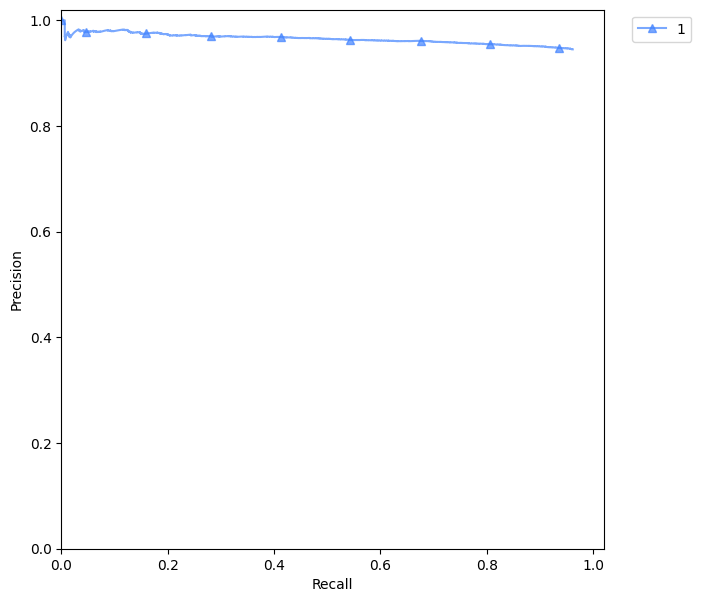

In [ ]:
# precision-recall curves
%matplotlib inline
from animaloc.vizual import PlotPrecisionRecall
pr_curve = PlotPrecisionRecall(legend=True)
metrics = test_evaluator._stored_metrics
for c in range(1, metrics.num_classes):
    rec, pre = metrics.rec_pre_lists(c)
    pr_curve.feed(rec, pre, str(c))

pr_curve.plot()

In [ ]:
# Train config files
%%writefile /content/HerdNet/configs/train/herdnet.yaml
wandb_project: 'hernet-finetunning'
wandb_entity: 'ghazaleh-serati'
wandb_run: 'myrun'
seed: 1
device_name: 'cuda'

model:
  name: 'HerdNet'
  from_torchvision: False
  load_from: null
  resume_from: null
  kwargs:
    num_layers: 34
    pretrained: True
    down_ratio: 2
    head_conv: 64
  freeze: null

losses:
  FocalLoss:
    print_name: 'focal_loss'
    from_torch: False
    output_idx: 0
    target_idx: 0
    lambda_const: 1.0
    kwargs:
      reduction: 'mean'
      normalize: False
  CrossEntropyLoss:
    print_name: 'ce_loss'
    from_torch: True
    output_idx: 1
    target_idx: 1
    lambda_const: 1.0
    kwargs:
      reduction: 'mean'
      weight: [0.1,5.,15.,1.]

datasets:
  img_size: [512,512]
  anno_type: 'point'
  num_classes: 1
  collate_fn: null

  class_def:
    1: 'caribou'


  train:
    name: 'CSVDataset'
    csv_file: '/content/Train_patches/gt.csv'
    root_dir: '/content/Train_patches'

    sampler: null

    albu_transforms:
      HorizontalFlip:
        p: 0.5
      MotionBlur:
        p: 0.5
      Normalize:
        p: 1.0

    end_transforms:
      MultiTransformsWrapper:
        FIDT:
          num_classes: ${train.datasets.num_classes}
          down_ratio: ${train.model.kwargs.down_ratio}
        PointsToMask:
          radius: 2
          num_classes: ${train.datasets.num_classes}
          squeeze: True
          down_ratio: 32

  validate:
    name: 'CSVDataset'
    csv_file: '/content/drive/MyDrive/val_patches/gt.csv'
    root_dir: '/content/drive/MyDrive/val_patches'

    albu_transforms:
      Normalize:
        p: 1.0

    end_transforms:
      DownSample:
        down_ratio: ${train.model.kwargs.down_ratio}
        anno_type: ${train.datasets.anno_type}

training_settings:
  trainer: 'Trainer'
  valid_freq: 1
  print_freq: 100
  batch_size: 4
  optimizer: 'adam'
  lr: 1e-4
  weight_decay: 0.0005
  auto_lr:
    mode: 'max'
    patience: 10
    threshold: 1e-4
    threshold_mode: 'rel'
    cooldown: 10
    min_lr: 1e-6
    verbose: True
  warmup_iters: 100
  vizual_fn: null
  epochs: 1
  evaluator:
    name: 'HerdNetEvaluator'
    threshold: 5
    select_mode: 'max'
    validate_on: 'f1_score'
    kwargs:
      print_freq: 10
      lmds_kwargs:
        kernel_size: [3,3]
        adapt_ts: 0.3
  stitcher:
    name: 'HerdNetStitcher'
    kwargs:
      overlap: 0
      down_ratio: ${train.model.kwargs.down_ratio}
      up: False
      reduction: 'mean'

Overwriting /content/HerdNet/configs/train/herdnet.yaml


In [ ]:
# TEST config files
%%writefile /content/HerdNet/configs/test/herdnet.yaml
wandb_project: 'HerdNet'
wandb_entity: 'ghazaleh-serati'
wandb_run: 'myrun'
device_name: 'cuda'

model:
  name: 'HerdNet'
  from_torchvision: False
  pth_file: '/content/drive/MyDrive/output/best_model.pth'
  kwargs:
    num_layers: 34
    pretrained: False
    down_ratio: 2
    head_conv: 64

dataset:
  img_size: [512,512]
  anno_type: 'point'
  num_classes: 1
  collate_fn: null

  class_def:
    1: 'caribou'


  name: 'CSVDataset'
  csv_file: '/content/test_patches/gt.csv'
  root_dir: '/content/test_patches'

  mean: [0.485, 0.456, 0.406]
  std: [0.229, 0.224, 0.225]

evaluator:
  name: 'HerdNetEvaluator'
  threshold: 5
  kwargs:
    lmds_kwargs:
      kernel_size: [3,3]
      adapt_ts: 0.3

stitcher:
  name: 'HerdNetStitcher'
  kwargs:
    overlap: 160
    down_ratio: ${test.model.kwargs.down_ratio}
    up: False
    reduction: 'mean'

In [ ]:
# Launching training and testing sessions with config files

!python /content/HerdNet/tools/train.py train=HerdNet

/content/HerdNet/tools/train.py:222: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='../configs', config_name="config")
In 'config': Could not find 'train/HerdNet'

Available options in 'train':
	dla34
	faster_rcnn
	herdnet
Config search path:
	provider=hydra, path=pkg://hydra.conf
	provider=main, path=file:///content/HerdNet/configs
	provider=schema, path=structured://

Set the environment variable HYDRA_FULL_ERROR=1 for a complete stack trace.


In [ ]:
!python /content/HerdNet/tools/train.py -m train=HerdNet train.training_settings.batch_size=1,2,4 train.training_settings.lr=1e-3,1e-4

In 'config': Could not find 'train/HerdNet'

Available options in 'train':
	dla34
	faster_rcnn
	herdnet
Config search path:
	provider=hydra, path=pkg://hydra.conf
	provider=main, path=file:///content/HerdNet/configs
	provider=schema, path=structured://

Set the environment variable HYDRA_FULL_ERROR=1 for a complete stack trace.


In [ ]:
!python /content/HerdNet/tools/test.py test=HerdNet

In 'config': Could not find 'test/HerdNet'

Available options in 'test':
	dla34
	faster_rcnn
	herdnet
Config search path:
	provider=hydra, path=pkg://hydra.conf
	provider=main, path=file:///content/HerdNet/configs
	provider=schema, path=structured://

Set the environment variable HYDRA_FULL_ERROR=1 for a complete stack trace.
